In [1]:
import os
import sys

import math
import numpy as np
import pandas as pd
import time
from calendar import monthrange
from datetime import datetime
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 70)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from bayes_opt import BayesianOptimization #From https://github.com/fmfn/BayesianOptimization

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, Reshape, Dense, Dropout, Concatenate, GRU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
sales_train = pd.read_csv('./data/sales_train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')
items = pd.read_csv('./data/items.csv')
item_categories = pd.read_csv('./data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')

In [4]:
items.columns = ['itemname','itemid','itemcategoryid']
item_categories.columns = ['itemcategoryname','itemcategoryid']
shops.columns = ['shopname','shopid']
sales_train.columns = ['date','month','shopid','itemid','price','target']
sales_train['date'] = pd.to_datetime(sales_train['date'],format='%d.%m.%Y')
test.columns = ['ID','shopid','itemid']

In [5]:
sales_train = sales_train.sort_values(['date','month','shopid','itemid'])
sales_train.head(1)

date  month  shopid  itemid  price  target
32569 2013-01-01      0       2     991   99.0     1.0

In [6]:
sales_train = sales_train[sales_train.price<100000]
sales_train = sales_train[sales_train.target<1001]
median = sales_train[(sales_train.shopid==32)&(sales_train.itemid==2973)&(sales_train.month==4)&(sales_train.price>0)].price.median()
sales_train.loc[sales_train.price<0, 'price'] = median

sales_train.loc[sales_train.shopid == 0, 'shopid'] = 57
test.loc[test.shopid == 0, 'shopid'] = 57
sales_train.loc[sales_train.shopid == 1, 'shopid'] = 58
test.loc[test.shopid == 1, 'shopid'] = 58
sales_train.loc[sales_train.shopid == 10, 'shopid'] = 11
test.loc[test.shopid == 10, 'shopid'] = 11

### First raw dataset (sales)

In [7]:
targets = sales_train.groupby(by=['month','shopid','itemid']).agg({'target':'sum'}).reset_index()
targets.head()

month  shopid  itemid  target
0      0       2      27     1.0
1      0       2      33     1.0
2      0       2     317     1.0
3      0       2     438     1.0
4      0       2     471     2.0

In [8]:
targets.target.max()

1644.0

In [9]:
targets.target.min()

-22.0

In [10]:
targets['target'] = targets['target'].clip(0,20)

In [11]:
targets['target'].unique()

array([ 1.,  2.,  3.,  4.,  6.,  5., 17.,  8.,  9., 10.,  7.,  0., 11.,
       12., 18., 14., 20., 15., 13., 19., 16.])

In [12]:
sales = pd.DataFrame()
for month in range(34):#0..33
    salesmonth = sales_train[sales_train.month==month]
    shopidsdf = pd.DataFrame({'shopid':salesmonth.shopid.unique()}).sort_values('shopid').reset_index(drop=True)
    shopidsdf['key'] = 0
    itemidsdf = pd.DataFrame({'itemid':salesmonth.itemid.unique()}).sort_values('itemid').reset_index(drop=True)
    itemidsdf['key'] = 0
    salesmonth = pd.merge(shopidsdf,itemidsdf,how='outer',on='key')
    salesmonth['month'] = month
    salesmonth = salesmonth.drop(columns='key')
    sales = sales.append(salesmonth)
sales = sales[['month','shopid','itemid']].sort_values(by=['month','shopid','itemid'])
print(sales.shape)

(10913804, 3)


In [13]:
sales = pd.merge(sales,targets,on=['month','shopid','itemid'],how='left')
sales = sales.fillna(0)
sales = pd.merge(sales,items[['itemid','itemcategoryid']],on=['itemid'],how='left')
print(sales.shape)
sales.head(3)

(10913804, 5)


month  shopid  itemid  target  itemcategoryid
0      0       2      19     0.0              40
1      0       2      27     1.0              19
2      0       2      28     0.0              30

In [14]:
del targets,salesmonth,itemidsdf,shopidsdf,median,month

In [15]:
print(sales.target.max())
print(sales.target.min())

20.0
0.0


### Feature engineering

Ideas :  
DONE- lags of shopid/itemid
DONE- lags of itemid over shops
DONE- means of shopid/itemid
DONE- item deprecated yes/no (no sale across all shops since x months)
DONE- means of itemid over shops
DONE- shopid/itemid deprecated yes/no (no sale across since x months on specific shopid)
DONE- extract city from shop names
DONE- extract type and subtype from category types
DONE- number of weekends within month, number of days within month, year,month number (from 1 to 12 to catch seasonnality)
- mean of sales across all shops on all months
- mean of sales across all shops on all months on active months
- mean of sales on specific shopid on all months
- mean of sales on specific shopid on all months on active months
DONE (date features?)- way of spotting seasonal products
DONE- nb of days since product launch, nb of days since shop opened
- performance of shop (nb of sales last month, month before, mean by month, mean by active month)
- item price range category
- shop monthly revenu last month, month before, mean across active months
- Infos from item name
DONE- deprecated (closed) shop

In [16]:
#merge test and sales

In [17]:
sales.head(1)

month  shopid  itemid  target  itemcategoryid
0      0       2      19     0.0              40

In [18]:
test.head(1)

ID  shopid  itemid
0   0       5    5037

In [16]:
test['month'] = 34
test['target'] = 0
test = pd.merge(test,items[['itemid','itemcategoryid']],on=['itemid'],how='left')
test.head(1)

ID  shopid  itemid  month  target  itemcategoryid
0   0       5    5037     34       0              19

In [17]:
test[test.isna().any(axis=1)]

Empty DataFrame
Columns: [ID, shopid, itemid, month, target, itemcategoryid]
Index: []

In [18]:
sales = pd.concat([sales, test[sales.columns]], ignore_index=True)
sales.head(2).append(sales.tail(2))

month  shopid  itemid  target  itemcategoryid
0             0       2      19     0.0              40
1             0       2      27     1.0              19
11128002     34      45   19648     0.0              40
11128003     34      45     969     0.0              37

In [19]:
#lags of shopid/itemid

In [20]:
sales = sales.sort_values(by=['month','shopid','itemid'])
sales.head(1).append(sales.tail(1))

month  shopid  itemid  target  itemcategoryid
0             0       2      19     0.0              40
11062181     34      59   22167     0.0              49

In [21]:
for i in [1,2,3,6,12]:
    lagsdf = sales[['month','shopid','itemid','target']]
    lagsdf['month'] += i
    lagsdf.columns = ['month','shopid','itemid','lagitemshop'+str(i)]
    print(sales.shape)
    sales = pd.merge(sales,lagsdf,how='left',on=['month','shopid','itemid'])
    print(sales.shape)

(11128004, 5)
(11128004, 6)
(11128004, 6)
(11128004, 7)
(11128004, 7)
(11128004, 8)
(11128004, 8)
(11128004, 9)
(11128004, 9)
(11128004, 10)


In [22]:
len(sales)-len(test)

10913804

In [23]:
sales = sales.fillna(0)

In [24]:
del lagsdf

In [25]:
#lags of itemid over shops

In [26]:
group = sales.groupby(['month','itemid']).agg({'target':'mean'}).reset_index()
for i in [1,2,3,6,12]:
    lagsdf = group.copy()
    lagsdf['month'] += i
    lagsdf.columns = ['month','itemid','lagitem'+str(i)]
    print(sales.shape)
    sales = pd.merge(sales,lagsdf,how='left',on=['month','itemid'])
    print(sales.shape)

(11128004, 10)
(11128004, 11)
(11128004, 11)
(11128004, 12)
(11128004, 12)
(11128004, 13)
(11128004, 13)
(11128004, 14)
(11128004, 14)
(11128004, 15)


In [27]:
for i in [1,2,3,6,12]:
    sales['lagitem'+str(i)] = sales['lagitem'+str(i)].fillna(0)

In [28]:
sales.head(1)

month  shopid  itemid  target  itemcategoryid  lagitemshop1  lagitemshop2  \
0      0       2      19     0.0              40           0.0           0.0   

   lagitemshop3  lagitemshop6  lagitemshop12  lagitem1  lagitem2  lagitem3  \
0           0.0           0.0            0.0       0.0       0.0       0.0   

   lagitem6  lagitem12  
0       0.0        0.0

In [29]:
del group,lagsdf

In [30]:
#means of shopid/itemid

In [31]:
sales['meanlagitemshop'] = (sales['lagitemshop1'] + sales['lagitemshop2'] + sales['lagitemshop3']) / 3
sales['meanlagitem'] = (sales['lagitem1'] + sales['lagitem2'] + sales['lagitem3']) / 3

In [32]:
#faster attempt of cumulative mean of shopid/item:
lagsdf = sales.groupby(['shopid','itemid','month']).agg({'target':'mean'}).reset_index()

In [33]:
sales_temp = sales[['month','shopid','itemid','target']].copy()
for i in range(1,35):#1..34
    lagsdf = sales[['month','shopid','itemid','target']].copy()
    lagsdf['month'] += i
    lagsdf.columns = ['month','shopid','itemid','lagitemshop'+str(i)]
    print(sales_temp.shape)
    sales_temp = pd.merge(sales_temp,lagsdf,how='left',on=['month','shopid','itemid'])
    print(sales_temp.shape)

(11128004, 4)
(11128004, 5)
(11128004, 5)
(11128004, 6)
(11128004, 6)
(11128004, 7)
(11128004, 7)
(11128004, 8)
(11128004, 8)
(11128004, 9)
(11128004, 9)
(11128004, 10)
(11128004, 10)
(11128004, 11)
(11128004, 11)
(11128004, 12)
(11128004, 12)
(11128004, 13)
(11128004, 13)
(11128004, 14)
(11128004, 14)
(11128004, 15)
(11128004, 15)
(11128004, 16)
(11128004, 16)
(11128004, 17)
(11128004, 17)
(11128004, 18)
(11128004, 18)
(11128004, 19)
(11128004, 19)
(11128004, 20)
(11128004, 20)
(11128004, 21)
(11128004, 21)
(11128004, 22)
(11128004, 22)
(11128004, 23)
(11128004, 23)
(11128004, 24)
(11128004, 24)
(11128004, 25)
(11128004, 25)
(11128004, 26)
(11128004, 26)
(11128004, 27)
(11128004, 27)
(11128004, 28)
(11128004, 28)
(11128004, 29)
(11128004, 29)
(11128004, 30)
(11128004, 30)
(11128004, 31)
(11128004, 31)
(11128004, 32)
(11128004, 32)
(11128004, 33)
(11128004, 33)
(11128004, 34)
(11128004, 34)
(11128004, 35)
(11128004, 35)
(11128004, 36)
(11128004, 36)
(11128004, 37)
(11128004, 37)
(11128

In [34]:
sales_temp = sales_temp.fillna(0)
sales_temp.head(1)

month  shopid  itemid  target  lagitemshop1  lagitemshop2  lagitemshop3  \
0      0       2      19     0.0           0.0           0.0           0.0   

   lagitemshop4  lagitemshop5  lagitemshop6  lagitemshop7  lagitemshop8  \
0           0.0           0.0           0.0           0.0           0.0   

   lagitemshop9  lagitemshop10  lagitemshop11  lagitemshop12  lagitemshop13  \
0           0.0            0.0            0.0            0.0            0.0   

   lagitemshop14  lagitemshop15  lagitemshop16  lagitemshop17  lagitemshop18  \
0            0.0            0.0            0.0            0.0            0.0   

   lagitemshop19  lagitemshop20  lagitemshop21  lagitemshop22  lagitemshop23  \
0            0.0            0.0            0.0            0.0            0.0   

   lagitemshop24  lagitemshop25  lagitemshop26  lagitemshop27  lagitemshop28  \
0            0.0            0.0            0.0            0.0            0.0   

   lagitemshop29  lagitemshop30  lagitemshop31  lagitemshop32  lagitemshop33  \
0            0.0            0.0            0.0            0.0            0.0   

   lagitemshop34  
0            0.0

In [35]:
for i in range(1,35):#1..34
    print('i : {}'.format(i))
    sales_temp.loc[sales_temp.month == i, 'cumulativemeanitemshop'] = 0
    for j in range(1,i+1):
        #print('j : {}'.format(j))
        sales_temp.loc[sales_temp.month == i, 'cumulativemeanitemshop'] += sales_temp.loc[sales_temp.month == i, 'lagitemshop'+str(j)]
    sales_temp.loc[sales_temp.month == i, 'cumulativemeanitemshop'] = sales_temp.loc[sales_temp.month == i, 'cumulativemeanitemshop'] / i

i : 1
i : 2
i : 3
i : 4
i : 5
i : 6
i : 7
i : 8
i : 9
i : 10
i : 11
i : 12
i : 13
i : 14
i : 15
i : 16
i : 17
i : 18
i : 19
i : 20
i : 21
i : 22
i : 23
i : 24
i : 25
i : 26
i : 27
i : 28
i : 29
i : 30
i : 31
i : 32
i : 33
i : 34


In [36]:
sales_temp = sales_temp.fillna(0)[['month','shopid','itemid','cumulativemeanitemshop']]

In [37]:
print(sales.shape)
sales = pd.merge(sales,sales_temp,how='left',on=['month','shopid','itemid'])
print(sales.shape)

(11128004, 17)
(11128004, 18)


In [38]:
sales[sales.isna().any(axis=1)]

Empty DataFrame
Columns: [month, shopid, itemid, target, itemcategoryid, lagitemshop1, lagitemshop2, lagitemshop3, lagitemshop6, lagitemshop12, lagitem1, lagitem2, lagitem3, lagitem6, lagitem12, meanlagitemshop, meanlagitem, cumulativemeanitemshop]
Index: []

In [39]:
del lagsdf,sales_temp

In [40]:
#item deprecated yes/no (no sale across all shops since x months)

In [41]:
sales['deprecateditemshop'] = np.where(sales['meanlagitemshop'] == 0, 1, 0)
sales['deprecateditem'] = np.where(sales['meanlagitem'] == 0, 1, 0)

In [42]:
#- extract city from shop names

In [43]:
shops.head(1)

shopname  shopid
0  !Якутск Орджоникидзе, 56 фран       0

In [44]:
#Shop infos: (https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data)
shops['shopname'] = shops['shopname'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shopcity'] = shops['shopname'].str.partition(' ')[0]
shops['shoptype'] = shops['shopname'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

shopname  shopid  shopcity shoptype
0    якутск орджоникидзе  фран       0    якутск  NO_DATA
1   якутск тц центральный фран       1    якутск       тц
2               адыгея тц мега       2    адыгея       тц
3  балашиха трк октябрькиномир       3  балашиха      трк
4       волжский тц волга молл       4  волжский       тц

In [45]:
encodercity = LabelEncoder()
shops['shopcityid'] = encodercity.fit_transform(shops['shopcity'])

encodertype = LabelEncoder()
shops['shoptypeid'] = encodertype.fit_transform(shops['shoptype'])

shops.head(1)

shopname  shopid shopcity shoptype  shopcityid  shoptypeid
0  якутск орджоникидзе  фран       0   якутск  NO_DATA          29           0

In [46]:
print(sales.shape)
sales = pd.merge(sales,shops[['shopid','shopcityid','shoptypeid']],how='left',on='shopid')
print(sales.shape)

(11128004, 20)
(11128004, 22)


In [47]:
#extract type and subtype from category types

In [48]:
item_categories.head(1)

itemcategoryname  itemcategoryid
0  PC - Гарнитуры/Наушники               0

In [49]:
#https://www.kaggle.com/dlarionov/feature-engineering-xgboost
item_categories['split'] = item_categories['itemcategoryname'].str.split('-')
item_categories['itemcategorytype'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['itemcategorytypeid'] = LabelEncoder().fit_transform(item_categories['itemcategorytype'])
# if subtype is nan then type
item_categories['itemcategorysubtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['itemcategorysubtypeid'] = LabelEncoder().fit_transform(item_categories['itemcategorysubtype'])
#cats = cats[['item_category_id','type_code', 'subtype_code']]
item_categories.head(3)

itemcategoryname  itemcategoryid                       split  \
0  PC - Гарнитуры/Наушники               0  [PC ,  Гарнитуры/Наушники]   
1         Аксессуары - PS2               1         [Аксессуары ,  PS2]   
2         Аксессуары - PS3               2         [Аксессуары ,  PS3]   

  itemcategorytype  itemcategorytypeid itemcategorysubtype  \
0               PC                   0  Гарнитуры/Наушники   
1       Аксессуары                   1                 PS2   
2       Аксессуары                   1                 PS3   

   itemcategorysubtypeid  
0                     29  
1                      9  
2                     10

In [50]:
print(sales.shape)
sales = pd.merge(sales,item_categories[['itemcategoryid','itemcategorytypeid','itemcategorysubtypeid']],how='left',on='itemcategoryid')
print(sales.shape)

(11128004, 22)
(11128004, 24)


In [51]:
#number of weekends within month, number of days within month, year,month number (from 1 to 12 to catch seasonnality)

In [52]:
print(sales_train.date.min())
print(sales_train.date.max())

2013-01-01 00:00:00
2015-10-31 00:00:00


In [53]:
dates = pd.DataFrame()
dates['date'] = pd.date_range(datetime(2013,1,1),datetime(2015,11,30))
dates['year'] = dates.date.dt.year - 2013
dates['monthofyear'] = dates.date.dt.month
dates['dayofweek'] = dates.date.dt.dayofweek + 1
dates['month'] = dates.year * 12 + dates.monthofyear - 1
dates.head(2).append(dates.tail(2))

date  year  monthofyear  dayofweek  month
0    2013-01-01     0            1          2      0
1    2013-01-02     0            1          3      0
1062 2015-11-29     2           11          7     34
1063 2015-11-30     2           11          1     34

In [54]:
nbweekends = dates[dates.dayofweek == 6].groupby('month').agg({'date':'count'}).reset_index()
nbweekends.columns = ['month','nbweekends']
datesdf = dates.groupby('month').agg({'date':'size','year':'mean','monthofyear':'mean'})
print(datesdf.shape)
datesdf = pd.merge(datesdf,nbweekends,on='month',how='left')
print(datesdf.shape)
datesdf.columns = ['month','nbdays','year','monthofyear','nbweekends']
datesdf

(35, 3)
(35, 5)


month  nbdays  year  monthofyear  nbweekends
0       0      31     0            1           4
1       1      28     0            2           4
2       2      31     0            3           5
3       3      30     0            4           4
4       4      31     0            5           4
5       5      30     0            6           5
6       6      31     0            7           4
7       7      31     0            8           5
8       8      30     0            9           4
9       9      31     0           10           4
10     10      30     0           11           5
11     11      31     0           12           4
12     12      31     1            1           4
13     13      28     1            2           4
14     14      31     1            3           5
15     15      30     1            4           4
16     16      31     1            5           5
17     17      30     1            6           4
18     18      31     1            7           4
19     19      31     1            8           5
20     20      30     1            9           4
21     21      31     1           10           4
22     22      30     1           11           5
23     23      31     1           12           4
24     24      31     2            1           5
25     25      28     2            2           4
26     26      31     2            3           4
27     27      30     2            4           4
28     28      31     2            5           5
29     29      30     2            6           4
30     30      31     2            7           4
31     31      31     2            8           5
32     32      30     2            9           4
33     33      31     2           10           5
34     34      30     2           11           4

In [55]:
print(sales.shape)
sales = pd.merge(sales,datesdf,on='month',how='left')
print(sales.shape)

(11128004, 24)
(11128004, 28)


In [56]:
del i,j,encodercity,encodertype,nbweekends,datesdf

In [57]:
#Months since product launch

In [58]:
itemsales = sales.groupby(['itemid','month']).agg({'target':'sum'}).reset_index()
print(itemsales.shape)
itemsales.head(3)

(239011, 3)


itemid  month  target
0       0     20     1.0
1       1     15     2.0
2       1     18     1.0

In [59]:
minmonths = itemsales.groupby('itemid').agg({'month':'min'})
minmonths = minmonths.reset_index()
print(minmonths.shape)
minmonths.head(3)

(22169, 2)


itemid  month
0       0     20
1       1     15
2       2     19

In [60]:
minmonths.columns = ['itemid','minmonth']
print(itemsales.shape)
itemsales = pd.merge(itemsales,minmonths,on='itemid',how='left')
print(itemsales.shape)
itemsales.head(5)

(239011, 3)
(239011, 4)


itemid  month  target  minmonth
0       0     20     1.0        20
1       1     15     2.0        15
2       1     18     1.0        15
3       1     19     1.0        15
4       1     20     1.0        15

In [61]:
itemsales['monthssinceitemlaunched'] = itemsales['month'] - itemsales['minmonth'] + 1
itemsales.head(5).append(itemsales.tail(5))

itemid  month  target  minmonth  monthssinceitemlaunched
0            0     20     1.0        20                        1
1            1     15     2.0        15                        1
2            1     18     1.0        15                        4
3            1     19     1.0        15                        5
4            1     20     1.0        15                        6
239006   22168      0     2.0         0                        1
239007   22168      1     2.0         0                        2
239008   22168      2     1.0         0                        3
239009   22168      8     1.0         0                        9
239010   22169     14     1.0        14                        1

In [62]:
itemsales[itemsales.isna().any(axis=1)]

Empty DataFrame
Columns: [itemid, month, target, minmonth, monthssinceitemlaunched]
Index: []

In [63]:
itemsales[itemsales.monthssinceitemlaunched < 0]

Empty DataFrame
Columns: [itemid, month, target, minmonth, monthssinceitemlaunched]
Index: []

In [64]:
print(sales.shape)
sales = pd.merge(sales,itemsales[['itemid','month','monthssinceitemlaunched']],on=['itemid','month'],how='left')
print(sales.shape)

(11128004, 28)
(11128004, 29)


In [65]:
new_itemids = sales[(sales.month==34)&(sales.monthssinceitemlaunched==1)].itemid.unique()

In [66]:
sales[(sales.month!=34)&(sales.itemid.isin(new_itemids))]

Empty DataFrame
Columns: [month, shopid, itemid, target, itemcategoryid, lagitemshop1, lagitemshop2, lagitemshop3, lagitemshop6, lagitemshop12, lagitem1, lagitem2, lagitem3, lagitem6, lagitem12, meanlagitemshop, meanlagitem, cumulativemeanitemshop, deprecateditemshop, deprecateditem, shopcityid, shoptypeid, itemcategorytypeid, itemcategorysubtypeid, nbdays, year, monthofyear, nbweekends, monthssinceitemlaunched]
Index: []

In [67]:
del minmonths,itemsales

In [68]:
#nb of days since shop opened
#même principe pour nb of days since shop opened

In [69]:
shoplaunched = sales.groupby(['shopid','month']).agg({'target':'sum'}).reset_index()
shoplaunched.head(5)

shopid  month  target
0       2      0  1146.0
1       2      1   489.0
2       2      2   751.0
3       2      3   585.0
4       2      4   553.0

In [70]:
minmonths = shoplaunched.groupby('shopid').agg({'month':'min'}).reset_index()
minmonths.head(3)

shopid  month
0       2      0
1       3      0
2       4      0

In [71]:
minmonths.columns = ['shopid','minmonth']
print(shoplaunched.shape)
shoplaunched = pd.merge(shoplaunched,minmonths,on='shopid',how='left')
print(shoplaunched.shape)
shoplaunched.head(3)

(1628, 3)
(1628, 4)


shopid  month  target  minmonth
0       2      0  1146.0         0
1       2      1   489.0         0
2       2      2   751.0         0

In [72]:
shoplaunched['monthssinceshoplaunched'] = shoplaunched['month'] - shoplaunched['minmonth'] + 1

In [73]:
shoplaunched = shoplaunched[['shopid','month','monthssinceshoplaunched']]
print(sales.shape)
sales = pd.merge(sales,shoplaunched,on=['shopid','month'],how='left')
print(sales.shape)

(11128004, 29)
(11128004, 30)


In [74]:
def isna(sales):
    isnadf = sales[sales.isna().any(axis=1)]
    return isnadf

In [75]:
isna(sales)

Empty DataFrame
Columns: [month, shopid, itemid, target, itemcategoryid, lagitemshop1, lagitemshop2, lagitemshop3, lagitemshop6, lagitemshop12, lagitem1, lagitem2, lagitem3, lagitem6, lagitem12, meanlagitemshop, meanlagitem, cumulativemeanitemshop, deprecateditemshop, deprecateditem, shopcityid, shoptypeid, itemcategorytypeid, itemcategorysubtypeid, nbdays, year, monthofyear, nbweekends, monthssinceitemlaunched, monthssinceshoplaunched]
Index: []

In [76]:
#Shop closed

In [77]:
shoplaunched = sales.groupby(['shopid','month']).agg({'target':'sum'}).reset_index()
shoplaunched

shopid  month  target
0          2      0  1146.0
1          2      1   489.0
2          2      2   751.0
3          2      3   585.0
4          2      4   553.0
5          2      5   808.0
6          2      6   807.0
7          2      7   852.0
8          2      8   843.0
9          2      9   716.0
10         2     10   814.0
11         2     11  1255.0
12         2     12   863.0
13         2     13   868.0
14         2     14   928.0
15         2     15   759.0
16         2     16   841.0
17         2     17   893.0
18         2     18   792.0
19         2     19   910.0
20         2     20   837.0
21         2     21   880.0
22         2     22   986.0
23         2     23  1745.0
24         2     24   945.0
...      ...    ...     ...
1603      59     10  1769.0
1604      59     11  2263.0
1605      59     12  1431.0
1606      59     13  1359.0
1607      59     14  1373.0
1608      59     15  1118.0
1609      59     16  1137.0
1610      59     17  1118.0
1611      59     18  1025.0
1612      59     19  1200.0
1613      59     20  1067.0
1614      59     21  1131.0
1615      59     22  1401.0
1616      59     23  1831.0
1617      59     24  1253.0
1618      59     25  1141.0
1619      59     26  1136.0
1620      59     27   917.0
1621      59     28   843.0
1622      59     29   898.0
1623      59     30   983.0
1624      59     31  1116.0
1625      59     32   914.0
1626      59     33   789.0
1627      59     34     0.0

[1628 rows x 3 columns]

In [78]:
shoplaunched[(shoplaunched.target==0)&(shoplaunched.month!=34)]

shopid  month  target
212       8      3     0.0
215       9     27     0.0
714      27     32     0.0
855      33     27     0.0

In [79]:
shoplaunched[(shoplaunched.shopid==33)]

shopid  month  target
847      33     19   125.0
848      33     20   572.0
849      33     21   577.0
850      33     22   777.0
851      33     23   994.0
852      33     24   959.0
853      33     25   766.0
854      33     26   483.0
855      33     27     0.0

In [80]:
sales[(sales.shopid==33)&(sales.month==27)].target.unique()

array([0.])

In [81]:
#put shop closed feature for
#shopid=8, month>=3
#shopid=9, month==27
#shopid=27, month>=32
#shopid=33, month>=27

In [82]:
sales['shopclosed'] = 0
sales.loc[(sales.shopid==8)&(sales.month>=3),'shopclosed'] = 1
sales.loc[(sales.shopid==9)&(sales.month==27),'shopclosed'] = 1
sales.loc[(sales.shopid==27)&(sales.month>=32),'shopclosed'] = 1
sales.loc[(sales.shopid==33)&(sales.month>=27),'shopclosed'] = 1

In [83]:
isna(sales)

Empty DataFrame
Columns: [month, shopid, itemid, target, itemcategoryid, lagitemshop1, lagitemshop2, lagitemshop3, lagitemshop6, lagitemshop12, lagitem1, lagitem2, lagitem3, lagitem6, lagitem12, meanlagitemshop, meanlagitem, cumulativemeanitemshop, deprecateditemshop, deprecateditem, shopcityid, shoptypeid, itemcategorytypeid, itemcategorysubtypeid, nbdays, year, monthofyear, nbweekends, monthssinceitemlaunched, monthssinceshoplaunched, shopclosed]
Index: []

In [84]:
del shoplaunched

In [85]:
#Average by month

In [86]:
group = sales.groupby(['month']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','lag1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month'])
print(sales.shape)

(11128004, 31)
(11128004, 32)


In [87]:
sales = sales.fillna(0)

In [88]:
del group,minmonths,new_itemids

In [89]:
#monthly average by shop over items, lagshop1,2,3,6,12

In [90]:
group = sales.groupby(['month','shopid']).agg({'target':'mean'}).reset_index()
for i in [1,2,3,6,12]:
    lagsdf = group.copy()
    lagsdf['month'] += i
    lagsdf.columns = ['month','shopid','lagshop'+str(i)]
    print(sales.shape)
    sales = pd.merge(sales,lagsdf,how='left',on=['month','shopid'])
    print(sales.shape)

(11128004, 32)
(11128004, 33)
(11128004, 33)
(11128004, 34)
(11128004, 34)
(11128004, 35)
(11128004, 35)
(11128004, 36)
(11128004, 36)
(11128004, 37)


In [91]:
for i in [1,2,3,6,12]:
    sales['lagshop'+str(i)] = sales['lagshop'+str(i)].fillna(0)

In [92]:
del dates,group,lagsdf,i

In [93]:
#avg month/itemcategoryid

In [94]:
group = sales.groupby(['month','itemcategoryid']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','itemcategoryid','lagitemcategoryidavg1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month','itemcategoryid'])
print(sales.shape)
sales = sales.fillna(0)

(11128004, 37)
(11128004, 38)


In [95]:
group = sales.groupby(['month','shopid','itemcategoryid']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','shopid','itemcategoryid','lagshopiditemcategoryidavg1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month','shopid','itemcategoryid'])
print(sales.shape)
sales = sales.fillna(0)

(11128004, 38)
(11128004, 39)


In [96]:
group = sales.groupby(['month','shopid','itemcategorytypeid']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','shopid','itemcategorytypeid','lagshopiditemcategorytypeidavg1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month','shopid','itemcategorytypeid'])
print(sales.shape)
sales = sales.fillna(0)

(11128004, 39)
(11128004, 40)


In [97]:
group = sales.groupby(['month','shopid','itemcategorysubtypeid']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','shopid','itemcategorysubtypeid','lagshopiditemcategorysubtypeidavg1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month','shopid','itemcategorysubtypeid'])
print(sales.shape)
sales = sales.fillna(0)

(11128004, 40)
(11128004, 41)


In [98]:
group = sales.groupby(['month','shopid','shopcityid']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','shopid','shopcityid','lagshopidshopcityidavg1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month','shopid','shopcityid'])
print(sales.shape)
sales = sales.fillna(0)

(11128004, 41)
(11128004, 42)


In [99]:
group = sales.groupby(['month','itemid','shopcityid']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','itemid','shopcityid','lagitemidshopcityidavg1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month','itemid','shopcityid'])
print(sales.shape)
sales = sales.fillna(0)

(11128004, 42)
(11128004, 43)


In [100]:
group = sales.groupby(['month','shoptypeid']).agg({'target':'mean'}).reset_index()
group['month'] += 1
group.columns = ['month','shoptypeid','lagshoptypeid1']
print(sales.shape)
sales = pd.merge(sales,group,how='left',on=['month','shoptypeid'])
print(sales.shape)
sales = sales.fillna(0)

(11128004, 43)
(11128004, 44)


### Item price features

In [101]:
group = sales_train.groupby(['itemid']).agg({'price':['mean','min','max']}).reset_index()
group.head(2).append(group.tail(2))

itemid        price                
                     mean     min     max
0          0    58.000000    58.0    58.0
1          1  4490.000000  4490.0  4490.0
21804  22168   798.916667   798.5   799.0
21805  22169  4349.000000  4349.0  4349.0

In [102]:
group.columns = group.columns.get_level_values(0)
group.columns = ['itemid','itempriceavg','itempricemin','itempricemax']
group.head(2).append(group.tail(2))

itemid  itempriceavg  itempricemin  itempricemax
0           0     58.000000          58.0          58.0
1           1   4490.000000        4490.0        4490.0
21804   22168    798.916667         798.5         799.0
21805   22169   4349.000000        4349.0        4349.0

In [103]:
print(sales.shape)
sales = pd.merge(sales,group,on=['itemid'],how='left')
print(sales.shape)

(11128004, 44)
(11128004, 47)


In [104]:
sales = sales.fillna(0)

In [105]:
group = sales_train.groupby(['itemid','month']).agg({'price':'mean'}).reset_index()
group.head(2).append(group.tail(2))

itemid  month   price
0            0     20    58.0
1            1     15  4490.0
233909   22168      8   799.0
233910   22169     14  4349.0

In [106]:
print(sales.shape)
sales = pd.merge(sales,group,on=['itemid','month'],how='left')
print(sales.shape)

(11128004, 47)
(11128004, 48)


In [107]:
sales['price'] = sales['price'].fillna(0)

In [108]:
def lastprice(month,itemid,lag):
    prices = group[(group.month < month)&(group.itemid==itemid)]['price']
    if len(prices) >= 2:
        return prices.values[-lag]
    elif len(prices) >= 1:
        return prices.values[-1]
    else:
        return 0

In [109]:
group['lastitemprice'] = group.apply(lambda df: lastprice(df['month'],df['itemid'],1),axis=1)

In [110]:
group['antelastitemprice'] = group.apply(lambda df: lastprice(df['month'],df['itemid'],2),axis=1)

In [111]:
print(sales.shape)
sales = pd.merge(sales,group[['itemid','month','lastitemprice','antelastitemprice']],on=['itemid','month'],how='left')
print(sales.shape)

(11128004, 48)
(11128004, 50)


In [112]:
sales = sales.fillna(0)

In [113]:
sales['ratiolastanteprice'] = 100 * sales['lastitemprice'] / sales['antelastitemprice']
sales['ratiolastavgprice'] = 100 * sales['lastitemprice'] / sales['itempriceavg']
sales['ratiolastminprice'] = 100 * sales['lastitemprice'] / sales['itempricemin']
sales['ratiolastmaxprice'] = 100 * sales['lastitemprice'] / sales['itempricemax']
sales['ratiominmaxprice'] = 100 * sales['itempricemax'] / sales['itempricemin']

In [114]:
sales['newitem'] = np.where(sales.monthssinceitemlaunched==1,1,0)

In [115]:
sales.loc[sales.newitem==1,'ratiolastanteprice'] = 1
sales.loc[sales.newitem==1,'ratiolastavgprice'] = 1
sales.loc[sales.newitem==1,'ratiolastminprice'] = 1
sales.loc[sales.newitem==1,'ratiolastmaxprice'] = 1
#sales.loc[sales.newitem==1,'ratiominmaxprice'] = 1

In [116]:
sales.loc[sales.ratiolastanteprice.isna(),'ratiolastanteprice'] = 1
sales.loc[sales.ratiolastavgprice.isna(),'ratiolastavgprice'] = 1
sales.loc[sales.ratiolastminprice.isna(),'ratiolastminprice'] = 1
sales.loc[sales.ratiolastminprice.isna(),'ratiolastmaxprice'] = 1
sales.loc[sales.ratiominmaxprice.isna(),'ratiominmaxprice'] = 1
sales.loc[sales.ratiolastanteprice==0,'ratiolastanteprice'] = 1
sales.loc[sales.ratiolastavgprice==0,'ratiolastavgprice'] = 1
sales.loc[sales.ratiolastminprice==0,'ratiolastminprice'] = 1
sales.loc[sales.ratiolastminprice==0,'ratiolastmaxprice'] = 1
sales.loc[sales.ratiominmaxprice==0,'ratiominmaxprice'] = 1

In [117]:
#Fix deprecateditemshop & deprecateditem when newitem

In [118]:
sales.loc[sales.newitem==1,'deprecateditem'] = 0
sales.loc[sales.newitem==1,'deprecateditemshop'] = 0

### Time series for Recurrent networks : 

In [28]:
def timeserie(feature,sales):
    group = sales.groupby(['month',feature]).agg({'target':'mean'}).reset_index()
    for i in range(1,13):#1..12
        lagsdf = group.copy()
        lagsdf['month'] += i
        lagsdf.columns = ['month',feature,'ts'+feature+str(i)]
        print(lagsdf.columns)
        print(sales.shape)
        sales = pd.merge(sales,lagsdf,how='left',on=['month',feature])
        print(sales.shape)
    return sales

In [29]:
#for feature in ['shopid','shopcityid','shoptypeid','itemcategoryid','itemcategorytypeid','itemcategorysubtypeid']:#,
for feature in ['itemid']:#,
    print(feature)
    sales = timeserie(feature,sales)

itemid
Index(['month', 'itemid', 'tsitemid1'], dtype='object')
(11128004, 320)
(11128004, 321)
Index(['month', 'itemid', 'tsitemid2'], dtype='object')
(11128004, 321)
(11128004, 322)
Index(['month', 'itemid', 'tsitemid3'], dtype='object')
(11128004, 322)
(11128004, 323)
Index(['month', 'itemid', 'tsitemid4'], dtype='object')
(11128004, 323)
(11128004, 324)
Index(['month', 'itemid', 'tsitemid5'], dtype='object')
(11128004, 324)
(11128004, 325)
Index(['month', 'itemid', 'tsitemid6'], dtype='object')
(11128004, 325)
(11128004, 326)
Index(['month', 'itemid', 'tsitemid7'], dtype='object')
(11128004, 326)
(11128004, 327)
Index(['month', 'itemid', 'tsitemid8'], dtype='object')
(11128004, 327)
(11128004, 328)
Index(['month', 'itemid', 'tsitemid9'], dtype='object')
(11128004, 328)
(11128004, 329)
Index(['month', 'itemid', 'tsitemid10'], dtype='object')
(11128004, 329)
(11128004, 330)
Index(['month', 'itemid', 'tsitemid11'], dtype='object')
(11128004, 330)
(11128004, 331)
Index(['month', 'itemid

In [28]:
sales = pd.read_csv('sales.csv')

In [32]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Columns: 128 entries, month to tsitemcategorysubtypeid12
dtypes: float16(110), int64(1), int8(17)
memory usage: 2.5 GB


In [31]:
sales['month'] = sales['month'].astype(np.int8)
sales['shopid'] = sales['shopid'].astype(np.int8)
sales['target'] = sales['target'].astype(np.float16)
sales['itemcategoryid'] = sales['itemcategoryid'].astype(np.int8)
sales['lagitemshop1'] = sales['lagitemshop1'].astype(np.float16)
sales['lagitemshop2'] = sales['lagitemshop2'].astype(np.float16)
sales['lagitemshop3'] = sales['lagitemshop3'].astype(np.float16)
sales['lagitemshop6'] = sales['lagitemshop6'].astype(np.float16)
sales['lagitemshop12'] = sales['lagitemshop12'].astype(np.float16)
sales['lagitem1'] = sales['lagitem1'].astype(np.float16)
sales['lagitem2'] = sales['lagitem2'].astype(np.float16)
sales['lagitem3'] = sales['lagitem3'].astype(np.float16)
sales['lagitem6'] = sales['lagitem6'].astype(np.float16)
sales['lagitem12'] = sales['lagitem12'].astype(np.float16)
sales['meanlagitemshop'] = sales['meanlagitemshop'].astype(np.float16)
sales['meanlagitem'] = sales['meanlagitem'].astype(np.float16)
sales['cumulativemeanitemshop'] = sales['cumulativemeanitemshop'].astype(np.float16)
sales['deprecateditemshop'] = sales['deprecateditemshop'].astype(np.int8)
sales['deprecateditem'] = sales['deprecateditem'].astype(np.int8)
sales['shopcityid'] = sales['shopcityid'].astype(np.int8)
sales['shoptypeid'] = sales['shoptypeid'].astype(np.int8)
sales['itemcategorytypeid'] = sales['itemcategorytypeid'].astype(np.int8)
sales['itemcategorysubtypeid'] = sales['itemcategorysubtypeid'].astype(np.int8)
sales['nbdays'] = sales['nbdays'].astype(np.int8)
sales['year'] = sales['year'].astype(np.int8)
sales['monthofyear'] = sales['monthofyear'].astype(np.int8)
sales['nbweekends'] = sales['nbweekends'].astype(np.int8)
sales['monthssinceitemlaunched'] = sales['monthssinceitemlaunched'].astype(np.int8)
sales['monthssinceshoplaunched'] = sales['monthssinceshoplaunched'].astype(np.int8)
sales['shopclosed'] = sales['shopclosed'].astype(np.int8)
sales['lag1'] = sales['lag1'].astype(np.float16)
sales['lagshop1'] = sales['lagshop1'].astype(np.float16)
sales['lagshop2'] = sales['lagshop2'].astype(np.float16)
sales['lagshop3'] = sales['lagshop3'].astype(np.float16)
sales['lagshop6'] = sales['lagshop6'].astype(np.float16)
sales['lagshop12'] = sales['lagshop12'].astype(np.float16)
sales['lagitemcategoryidavg1'] = sales['lagitemcategoryidavg1'].astype(np.float16)
sales['lagshopiditemcategoryidavg1'] = sales['lagshopiditemcategoryidavg1'].astype(np.float16)
sales['lagshopiditemcategorytypeidavg1'] = sales['lagshopiditemcategorytypeidavg1'].astype(np.float16)
sales['lagshopiditemcategorysubtypeidavg1'] = sales['lagshopiditemcategorysubtypeidavg1'].astype(np.float16)
sales['lagshopidshopcityidavg1'] = sales['lagshopidshopcityidavg1'].astype(np.float16)
sales['lagitemidshopcityidavg1'] = sales['lagitemidshopcityidavg1'].astype(np.float16)
sales['lagshoptypeid1'] = sales['lagshoptypeid1'].astype(np.float16)
sales['itempriceavg'] = sales['itempriceavg'].astype(np.float16)
sales['itempricemin'] = sales['itempricemin'].astype(np.float16)
sales['itempricemax'] = sales['itempricemax'].astype(np.float16)
sales['price'] = sales['price'].astype(np.float16)
sales['lastitemprice'] = sales['lastitemprice'].astype(np.float16)
sales['antelastitemprice'] = sales['antelastitemprice'].astype(np.float16)
sales['ratiolastanteprice'] = sales['ratiolastanteprice'].astype(np.float16)
sales['ratiolastavgprice'] = sales['ratiolastavgprice'].astype(np.float16)
sales['ratiolastminprice'] = sales['ratiolastminprice'].astype(np.float16)
sales['ratiolastmaxprice'] = sales['ratiolastmaxprice'].astype(np.float16)
sales['ratiominmaxprice'] = sales['ratiominmaxprice'].astype(np.float16)
sales['newitem'] = sales['newitem'].astype(np.int8)
sales['tsshopid1'] = sales['tsshopid1'].astype(np.float16)
sales['tsshopid2'] = sales['tsshopid2'].astype(np.float16)
sales['tsshopid3'] = sales['tsshopid3'].astype(np.float16)
sales['tsshopid4'] = sales['tsshopid4'].astype(np.float16)
sales['tsshopid5'] = sales['tsshopid5'].astype(np.float16)
sales['tsshopid6'] = sales['tsshopid6'].astype(np.float16)
sales['tsshopid7'] = sales['tsshopid7'].astype(np.float16)
sales['tsshopid8'] = sales['tsshopid8'].astype(np.float16)
sales['tsshopid9'] = sales['tsshopid9'].astype(np.float16)
sales['tsshopid10'] = sales['tsshopid10'].astype(np.float16)
sales['tsshopid11'] = sales['tsshopid11'].astype(np.float16)
sales['tsshopid12'] = sales['tsshopid12'].astype(np.float16)
sales['tsshopcityid1'] = sales['tsshopcityid1'].astype(np.float16)
sales['tsshopcityid2'] = sales['tsshopcityid2'].astype(np.float16)
sales['tsshopcityid3'] = sales['tsshopcityid3'].astype(np.float16)
sales['tsshopcityid4'] = sales['tsshopcityid4'].astype(np.float16)
sales['tsshopcityid5'] = sales['tsshopcityid5'].astype(np.float16)
sales['tsshopcityid6'] = sales['tsshopcityid6'].astype(np.float16)
sales['tsshopcityid7'] = sales['tsshopcityid7'].astype(np.float16)
sales['tsshopcityid8'] = sales['tsshopcityid8'].astype(np.float16)
sales['tsshopcityid9'] = sales['tsshopcityid9'].astype(np.float16)
sales['tsshopcityid10'] = sales['tsshopcityid10'].astype(np.float16)
sales['tsshopcityid11'] = sales['tsshopcityid11'].astype(np.float16)
sales['tsshopcityid12'] = sales['tsshopcityid12'].astype(np.float16)
sales['tsshoptypeid1'] = sales['tsshoptypeid1'].astype(np.float16)
sales['tsshoptypeid2'] = sales['tsshoptypeid2'].astype(np.float16)
sales['tsshoptypeid3'] = sales['tsshoptypeid3'].astype(np.float16)
sales['tsshoptypeid4'] = sales['tsshoptypeid4'].astype(np.float16)
sales['tsshoptypeid5'] = sales['tsshoptypeid5'].astype(np.float16)
sales['tsshoptypeid6'] = sales['tsshoptypeid6'].astype(np.float16)
sales['tsshoptypeid7'] = sales['tsshoptypeid7'].astype(np.float16)
sales['tsshoptypeid8'] = sales['tsshoptypeid8'].astype(np.float16)
sales['tsshoptypeid9'] = sales['tsshoptypeid9'].astype(np.float16)
sales['tsshoptypeid10'] = sales['tsshoptypeid10'].astype(np.float16)
sales['tsshoptypeid11'] = sales['tsshoptypeid11'].astype(np.float16)
sales['tsshoptypeid12'] = sales['tsshoptypeid12'].astype(np.float16)
sales['tsitemcategoryid1'] = sales['tsitemcategoryid1'].astype(np.float16)
sales['tsitemcategoryid2'] = sales['tsitemcategoryid2'].astype(np.float16)
sales['tsitemcategoryid3'] = sales['tsitemcategoryid3'].astype(np.float16)
sales['tsitemcategoryid4'] = sales['tsitemcategoryid4'].astype(np.float16)
sales['tsitemcategoryid5'] = sales['tsitemcategoryid5'].astype(np.float16)
sales['tsitemcategoryid6'] = sales['tsitemcategoryid6'].astype(np.float16)
sales['tsitemcategoryid7'] = sales['tsitemcategoryid7'].astype(np.float16)
sales['tsitemcategoryid8'] = sales['tsitemcategoryid8'].astype(np.float16)
sales['tsitemcategoryid9'] = sales['tsitemcategoryid9'].astype(np.float16)
sales['tsitemcategoryid10'] = sales['tsitemcategoryid10'].astype(np.float16)
sales['tsitemcategoryid11'] = sales['tsitemcategoryid11'].astype(np.float16)
sales['tsitemcategoryid12'] = sales['tsitemcategoryid12'].astype(np.float16)
sales['tsitemcategorytypeid1'] = sales['tsitemcategorytypeid1'].astype(np.float16)
sales['tsitemcategorytypeid2'] = sales['tsitemcategorytypeid2'].astype(np.float16)
sales['tsitemcategorytypeid3'] = sales['tsitemcategorytypeid3'].astype(np.float16)
sales['tsitemcategorytypeid4'] = sales['tsitemcategorytypeid4'].astype(np.float16)
sales['tsitemcategorytypeid5'] = sales['tsitemcategorytypeid5'].astype(np.float16)
sales['tsitemcategorytypeid6'] = sales['tsitemcategorytypeid6'].astype(np.float16)
sales['tsitemcategorytypeid7'] = sales['tsitemcategorytypeid7'].astype(np.float16)
sales['tsitemcategorytypeid8'] = sales['tsitemcategorytypeid8'].astype(np.float16)
sales['tsitemcategorytypeid9'] = sales['tsitemcategorytypeid9'].astype(np.float16)
sales['tsitemcategorytypeid10'] = sales['tsitemcategorytypeid10'].astype(np.float16)
sales['tsitemcategorytypeid11'] = sales['tsitemcategorytypeid11'].astype(np.float16)
sales['tsitemcategorytypeid12'] = sales['tsitemcategorytypeid12'].astype(np.float16)
sales['tsitemcategorysubtypeid1'] = sales['tsitemcategorysubtypeid1'].astype(np.float16)
sales['tsitemcategorysubtypeid2'] = sales['tsitemcategorysubtypeid2'].astype(np.float16)
sales['tsitemcategorysubtypeid3'] = sales['tsitemcategorysubtypeid3'].astype(np.float16)
sales['tsitemcategorysubtypeid4'] = sales['tsitemcategorysubtypeid4'].astype(np.float16)
sales['tsitemcategorysubtypeid5'] = sales['tsitemcategorysubtypeid5'].astype(np.float16)
sales['tsitemcategorysubtypeid6'] = sales['tsitemcategorysubtypeid6'].astype(np.float16)
sales['tsitemcategorysubtypeid7'] = sales['tsitemcategorysubtypeid7'].astype(np.float16)
sales['tsitemcategorysubtypeid8'] = sales['tsitemcategorysubtypeid8'].astype(np.float16)
sales['tsitemcategorysubtypeid9'] = sales['tsitemcategorysubtypeid9'].astype(np.float16)
sales['tsitemcategorysubtypeid10'] = sales['tsitemcategorysubtypeid10'].astype(np.float16)
sales['tsitemcategorysubtypeid11'] = sales['tsitemcategorysubtypeid11'].astype(np.float16)
sales['tsitemcategorysubtypeid12'] = sales['tsitemcategorysubtypeid12'].astype(np.float16)

In [29]:
for column in sales.columns:
    print("sales['{}'] = sales['{}'].astype(np.float16)".format(column,column))

sales['month'] = sales['month'].astype(np.float16)
sales['shopid'] = sales['shopid'].astype(np.float16)
sales['itemid'] = sales['itemid'].astype(np.float16)
sales['target'] = sales['target'].astype(np.float16)
sales['itemcategoryid'] = sales['itemcategoryid'].astype(np.float16)
sales['lagitemshop1'] = sales['lagitemshop1'].astype(np.float16)
sales['lagitemshop2'] = sales['lagitemshop2'].astype(np.float16)
sales['lagitemshop3'] = sales['lagitemshop3'].astype(np.float16)
sales['lagitemshop6'] = sales['lagitemshop6'].astype(np.float16)
sales['lagitemshop12'] = sales['lagitemshop12'].astype(np.float16)
sales['lagitem1'] = sales['lagitem1'].astype(np.float16)
sales['lagitem2'] = sales['lagitem2'].astype(np.float16)
sales['lagitem3'] = sales['lagitem3'].astype(np.float16)
sales['lagitem6'] = sales['lagitem6'].astype(np.float16)
sales['lagitem12'] = sales['lagitem12'].astype(np.float16)
sales['meanlagitemshop'] = sales['meanlagitemshop'].astype(np.float16)
sales['meanlagitem'] = sales['meanla

In [ ]:
    itemcategoryid/itemcategorytypeid
    itemcategoryid/itemcategorysubtypeid
    itemcategoryid/shopcityid
    itemcategoryid/shoptypeid
    itemcategoryid/shopid
    
    itemcategorytypeid/itemcategorysubtypeid
    itemcategorytypeid/shopcityid
    itemcategorytypeid/shoptypeid
    itemcategorytypeid/shopid
    
    itemcategorysubtypeid/shopcityid
    itemcategorysubtypeid/shoptypeid
    itemcategorysubtypeid/shopid
    
    shopcityid/shoptypeid
    shopcityid/shopid
    
    shoptypeid/shopid

In [30]:
def timeserie2features(feature1,feature2,sales):
    group = sales.groupby(['month',feature1,feature2]).agg({'target':'mean'}).reset_index()
    for i in range(1,13):#1..12
        lagsdf = group.copy()
        lagsdf['month'] += i
        lagsdf.columns = ['month',feature1,feature2,'ts'+feature1+feature2+str(i)]
        print(lagsdf.columns)
        print(sales.shape)
        sales = pd.merge(sales,lagsdf,how='left',on=['month',feature1,feature2])
        sales['ts'+feature1+feature2+str(i)] = sales['ts'+feature1+feature2+str(i)].astype(np.float16)
        print(sales.shape)
    return sales

In [31]:
"""
featurescouples = [
    ['itemcategoryid','itemcategorytypeid'],
    ['itemcategoryid','itemcategorysubtypeid'],
    ['itemcategoryid','shopcityid'],
    ['itemcategoryid','shoptypeid'],
    ['itemcategoryid','shopid'],
    ['itemcategorytypeid','itemcategorysubtypeid'],
    ['itemcategorytypeid','shopcityid'],
    ['itemcategorytypeid','shoptypeid'],
    ['itemcategorytypeid','shopid'],
    ['itemcategorysubtypeid','shopcityid'],
    ['itemcategorysubtypeid','shoptypeid'],
    ['itemcategorysubtypeid','shopid'],
    ['shopcityid','shoptypeid'],
    ['shopcityid','shopid'],
    ['shoptypeid','shopid']
]
"""

featurescouples = [
    ['shopid','itemid']
]
    

In [32]:
for featurescouple in featurescouples:
    print(featurescouple)
    sales = timeserie2features(featurescouple[0],featurescouple[1],sales)

['shopid', 'itemid']
Index(['month', 'shopid', 'itemid', 'tsshopiditemid1'], dtype='object')
(11128004, 332)
(11128004, 333)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid2'], dtype='object')
(11128004, 333)
(11128004, 334)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid3'], dtype='object')
(11128004, 334)
(11128004, 335)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid4'], dtype='object')
(11128004, 335)
(11128004, 336)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid5'], dtype='object')
(11128004, 336)
(11128004, 337)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid6'], dtype='object')
(11128004, 337)
(11128004, 338)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid7'], dtype='object')
(11128004, 338)
(11128004, 339)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid8'], dtype='object')
(11128004, 339)
(11128004, 340)
Index(['month', 'shopid', 'itemid', 'tsshopiditemid9'], dtype='object')
(11128004, 340)
(11128004, 341)
Index(['month', 'shopid', 'itemid', 'tsshop

In [33]:
sales.to_csv('sales.csv',index=False)

In [15]:
sales = pd.read_csv('sales.csv', nrows=100)

float_cols = [c for c in sales if sales[c].dtype == "float64"]
float16_cols = {c: np.float16 for c in float_cols}

int_cols = [c for c in sales if (sales[c].dtype == "int64")&(c != 'itemid')]
int8_cols = {c: np.int8 for c in int_cols}

float16_cols.update(int8_cols)

In [16]:
sales = pd.read_csv('sales.csv', engine='c', dtype=float16_cols)

In [17]:
sales.shape

(11128004, 308)

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Columns: 308 entries, month to tsshoptypeidshopid12
dtypes: float16(290), int64(18)
memory usage: 7.5 GB


In [12]:
float16_cols.update(int8_cols)

In [14]:
#int8_cols
float16_cols

{'target': numpy.float16,
 'lagitemshop1': numpy.float16,
 'lagitemshop2': numpy.float16,
 'lagitemshop3': numpy.float16,
 'lagitemshop6': numpy.float16,
 'lagitemshop12': numpy.float16,
 'lagitem1': numpy.float16,
 'lagitem2': numpy.float16,
 'lagitem3': numpy.float16,
 'lagitem6': numpy.float16,
 'lagitem12': numpy.float16,
 'meanlagitemshop': numpy.float16,
 'meanlagitem': numpy.float16,
 'cumulativemeanitemshop': numpy.float16,
 'lag1': numpy.float16,
 'lagshop1': numpy.float16,
 'lagshop2': numpy.float16,
 'lagshop3': numpy.float16,
 'lagshop6': numpy.float16,
 'lagshop12': numpy.float16,
 'lagitemcategoryidavg1': numpy.float16,
 'lagshopiditemcategoryidavg1': numpy.float16,
 'lagshopiditemcategorytypeidavg1': numpy.float16,
 'lagshopiditemcategorysubtypeidavg1': numpy.float16,
 'lagshopidshopcityidavg1': numpy.float16,
 'lagitemidshopcityidavg1': numpy.float16,
 'lagshoptypeid1': numpy.float16,
 'itempriceavg': numpy.float16,
 'itempricemin': numpy.float16,
 'itempricemax': numpy

In [9]:
int_cols = [c for c in sales if (sales[c].dtype == "int64")&(c != 'itemid')]
int8_cols = {c: np.int8 for c in int_cols}

In [203]:
sales.columns

Index(['month', 'shopid', 'itemid', 'target', 'itemcategoryid', 'lagitemshop1',
       'lagitemshop2', 'lagitemshop3', 'lagitemshop6', 'lagitemshop12',
       'lagitem1', 'lagitem2', 'lagitem3', 'lagitem6', 'lagitem12',
       'meanlagitemshop', 'meanlagitem', 'cumulativemeanitemshop',
       'deprecateditemshop', 'deprecateditem', 'shopcityid', 'shoptypeid',
       'itemcategorytypeid', 'itemcategorysubtypeid', 'nbdays', 'year',
       'monthofyear', 'nbweekends', 'monthssinceitemlaunched',
       'monthssinceshoplaunched', 'shopclosed', 'lag1', 'lagshop1', 'lagshop2',
       'lagshop3', 'lagshop6', 'lagshop12', 'lagitemcategoryidavg1',
       'lagshopiditemcategoryidavg1', 'lagshopiditemcategorytypeidavg1',
       'lagshopiditemcategorysubtypeidavg1', 'lagshopidshopcityidavg1',
       'lagitemidshopcityidavg1', 'lagshoptypeid1', 'itempriceavg',
       'itempricemin', 'itempricemax', 'price', 'lastitemprice',
       'antelastitemprice', 'ratiolastanteprice', 'ratiolastavgprice',
     

In [195]:
[column for column in sales.columns if 'ts' in column]

['tsshopid1_x', 'tsshopid2_x', 'tsshopid1_y', 'tsshopid2_y']

### Shop revenu feature

In [18]:
sales_train = pd.read_csv('./data/sales_train.csv')
sales_train.columns = ['date','month','shopid','itemid','price','target']
sales_train = sales_train[sales_train.price<100000]
sales_train = sales_train[sales_train.target<1001]
median = sales_train[(sales_train.shopid==32)&(sales_train.itemid==2973)&(sales_train.month==4)&(sales_train.price>0)].price.median()
sales_train.loc[sales_train.price<0, 'price'] = median

sales_train.loc[sales_train.shopid == 0, 'shopid'] = 57
sales_train.loc[sales_train.shopid == 1, 'shopid'] = 58
sales_train.loc[sales_train.shopid == 10, 'shopid'] = 11

In [19]:
sales_train['revenue'] = sales_train['price'] * sales_train['target']

In [23]:
group = sales_train.groupby(['month','shopid']).agg({'revenue':'sum'}).reset_index()
group.head(5)

month  shopid     revenue
0      0       2  1085064.80
1      0       3   560585.01
2      0       4  1433666.00
3      0       6  2743015.00
4      0       7  1870467.00

In [24]:
groupinitial = group.copy()
for i in range(1,13):#1..12
    lagsdf = groupinitial.copy()
    lagsdf['month'] += i
    lagsdf.columns = ['month','shopid','ts'+'revenue'+str(i)]
    print(lagsdf.columns)
    print(group.shape)
    group = pd.merge(group,lagsdf,how='left',on=['month','shopid'])
    print(group.shape)

Index(['month', 'shopid', 'tsrevenue1'], dtype='object')
(1586, 3)
(1586, 4)
Index(['month', 'shopid', 'tsrevenue2'], dtype='object')
(1586, 4)
(1586, 5)
Index(['month', 'shopid', 'tsrevenue3'], dtype='object')
(1586, 5)
(1586, 6)
Index(['month', 'shopid', 'tsrevenue4'], dtype='object')
(1586, 6)
(1586, 7)
Index(['month', 'shopid', 'tsrevenue5'], dtype='object')
(1586, 7)
(1586, 8)
Index(['month', 'shopid', 'tsrevenue6'], dtype='object')
(1586, 8)
(1586, 9)
Index(['month', 'shopid', 'tsrevenue7'], dtype='object')
(1586, 9)
(1586, 10)
Index(['month', 'shopid', 'tsrevenue8'], dtype='object')
(1586, 10)
(1586, 11)
Index(['month', 'shopid', 'tsrevenue9'], dtype='object')
(1586, 11)
(1586, 12)
Index(['month', 'shopid', 'tsrevenue10'], dtype='object')
(1586, 12)
(1586, 13)
Index(['month', 'shopid', 'tsrevenue11'], dtype='object')
(1586, 13)
(1586, 14)
Index(['month', 'shopid', 'tsrevenue12'], dtype='object')
(1586, 14)
(1586, 15)


In [25]:
group.tail(3)

month  shopid    revenue  tsrevenue1  tsrevenue2  tsrevenue3  \
1583     33      57  2417292.0   2134761.0  2169148.21   1887001.0   
1584     33      58  1762288.0   1522606.0  1706549.00   1427139.0   
1585     33      59   972717.0   1096854.0   998975.00    854894.5   

      tsrevenue4  tsrevenue5  tsrevenue6  tsrevenue7  tsrevenue8  tsrevenue9  \
1583   2102424.0   2309767.0   2528872.0  2616525.00  3041479.00  4337421.00   
1584   1519437.0   1250199.0   1779872.0  2485409.66  2152130.73  2499178.37   
1585    862364.0   1025225.5   1044684.0  1014051.52  1151477.00  1339902.00   

      tsrevenue10  tsrevenue11  tsrevenue12  
1583    9146673.0    3526914.0   3488300.67  
1584    6674938.0    2198128.0   1892411.00  
1585    2607920.0    2278885.7   1385045.00

In [26]:
group = group.drop(columns='revenue')
print(sales.shape)
sales = pd.merge(sales,group,on=['month','shopid'],how='left')
print(sales.shape)
for i in range(1,13):#1..12
    sales['tsrevenue'+str(i)] = sales['tsrevenue'+str(i)].fillna(0)

(11128004, 308)
(11128004, 320)


In [27]:
sales[sales.month==33].target.unique()

array([ 0.,  1.,  3.,  2.,  4.,  9.,  5.,  8.,  6., 16., 12., 20.,  7.,
       11., 10., 14., 15., 18., 17., 13., 19.])

In [55]:
### Analyze errors in month 33

In [78]:
### Analyze items appering for the first time in test data, and more generally analyze the features of test data, create a separate model for items with no historic?


missing features: 'itempriceavg','itempricemin','itempricemax'

### First simple lgb

In [ ]:
sales.columns

In [ ]:
3 ts de 12 lag itemid,shopid + 1 ts sur price de 12 lags

categorical itemid

other monthssinceitemlaunched, itempriceavg, itempricemin, itempricemax,

In [166]:
features = [
    'month',
    'shopid',
    'itemid',
    'itemcategoryid',
    'lagitemshop1',
    'lagitemshop2',
    'lagitemshop3',
    'lagitemshop6',
    'lagitemshop12',
    'lagitem1',
    'lagitem2',
    'lagitem3',
    'lagitem6',
    'lagitem12',
    'meanlagitemshop',
    'meanlagitem',
    'cumulativemeanitemshop',
    'deprecateditemshop',
    'deprecateditem',
    'shopcityid',
    'shoptypeid',
    'itemcategorytypeid',
    'itemcategorysubtypeid',
    'nbdays',
    'year',
    'monthofyear',
    'nbweekends',
    'monthssinceitemlaunched',
    'monthssinceshoplaunched',
    'shopclosed',
    'lag1',
    'lagshop1',
    'lagshop2',
    'lagshop3',
    'lagshop6',
    'lagshop12',
    'lagitemcategoryidavg1',
    'lagshopiditemcategoryidavg1',
    'lagshopiditemcategorytypeidavg1',
    'lagshopiditemcategorysubtypeidavg1',
    'lagshopidshopcityidavg1',
    'lagitemidshopcityidavg1',
    'lagshoptypeid1',
    #'itempriceavg',#can't be used for items in test set
    #'itempricemin',#can't be used for items in test set
    #'itempricemax',#can't be used for items in test set
    #'lastitemprice',#can't be used for newitems
    #'antelastitemprice',#can't be used for newitems
    'ratiolastanteprice',
    'ratiolastavgprice',
    'ratiolastminprice',
    'ratiolastmaxprice',
    'ratiominmaxprice',
    'newitem'
]

categorical_features = [
    'shopid',
    'itemid',
    'itemcategoryid',
    'deprecateditemshop',
    'deprecateditem',
    'shopcityid',
    'shoptypeid',
    'itemcategorytypeid',
    'itemcategorysubtypeid',
    'shopclosed',
    'newitem'
]

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 44,#71
    'max_depth': 19,#15
    'feature_fraction': 0.9639040863246328,#0.930233257263184
    'bagging_fraction': 0.9149216274612932, #0.9417022004702574
    'bagging_freq': 18,#3
    'learning_rate': 0.01,#0.05
    'early_stopping_round': 60,
    'lambda': 0.8378024755045912,#0.44026767245133913
    'min_split_gain': 7.20114889206731,#0.8178089989260697
    'min_child_samples': 39,#85
    'min_data_per_group': 369,#342
    'min_child_weight': 6.683586781569385,#2.155266936013428
    'cat_smooth': 0.05596554352078842,#1.0113231069171438
    'min_data_in_leaf': 69,#126
    'max_bin': 37,#157
    'verbosity' : -1
}

sales_test = sales[sales.month > 11]

ROUNDS = 35000
traindf = sales_test[sales_test.month < 32]
testdf = sales_test[sales_test.month == 32]
traingbm = lgb.Dataset(traindf[features], label=traindf['target'], categorical_feature=categorical_features, free_raw_data=False)
testgbm = lgb.Dataset(testdf[features], label=testdf['target'], categorical_feature=categorical_features, free_raw_data=False)
m = lgb.train(params, traingbm, ROUNDS, valid_sets=[traingbm, testgbm], verbose_eval=1)
predsgbm = m.predict(testdf[features])
mse = mean_squared_error(testdf['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))
predsgbm = m.predict(testdf[testdf.newitem==1][features])
mse = mean_squared_error(testdf[testdf.newitem==1]['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse new items: {}'.format(rmse))
print('with {} rows'.format(len(testdf[testdf.newitem==1])))
predsgbm = m.predict(testdf[testdf.newitem!=1][features])
mse = mean_squared_error(testdf[testdf.newitem!=1]['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse old items: {}'.format(rmse))
print('with {} rows'.format(len(testdf[testdf.newitem!=1])))

traindf = sales_test[sales_test.month < 33]
testdf = sales_test[sales_test.month == 33]
traingbm = lgb.Dataset(traindf[features], label=traindf['target'], categorical_feature=categorical_features, free_raw_data=False)
testgbm = lgb.Dataset(testdf[features], label=testdf['target'], categorical_feature=categorical_features, free_raw_data=False)
m = lgb.train(params, traingbm, ROUNDS, valid_sets=[traingbm, testgbm], verbose_eval=1)
predsgbm = m.predict(testdf[features])
mse = mean_squared_error(testdf['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))
predsgbm = m.predict(testdf[testdf.newitem==1][features])
mse = mean_squared_error(testdf[testdf.newitem==1]['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse new items: {}'.format(rmse))
print('with {} rows'.format(len(testdf[testdf.newitem==1])))
predsgbm = m.predict(testdf[testdf.newitem!=1][features])
mse = mean_squared_error(testdf[testdf.newitem!=1]['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse old items: {}'.format(rmse))
print('with {} rows'.format(len(testdf[testdf.newitem!=1])))

[1]	training's rmse: 1.18402	valid_1's rmse: 1.15028
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 1.17839	valid_1's rmse: 1.14623
[3]	training's rmse: 1.17294	valid_1's rmse: 1.14241
[4]	training's rmse: 1.16748	valid_1's rmse: 1.13847
[5]	training's rmse: 1.16219	valid_1's rmse: 1.13479
[6]	training's rmse: 1.1569	valid_1's rmse: 1.13101
[7]	training's rmse: 1.15175	valid_1's rmse: 1.12716
[8]	training's rmse: 1.14661	valid_1's rmse: 1.12346
[9]	training's rmse: 1.1418	valid_1's rmse: 1.11945
[10]	training's rmse: 1.1368	valid_1's rmse: 1.11619
[11]	training's rmse: 1.13168	valid_1's rmse: 1.11274
[12]	training's rmse: 1.12693	valid_1's rmse: 1.10903
[13]	training's rmse: 1.12214	valid_1's rmse: 1.10563
[14]	training's rmse: 1.11759	valid_1's rmse: 1.1021
[15]	training's rmse: 1.11301	valid_1's rmse: 1.09862
[16]	training's rmse: 1.10839	valid_1's rmse: 1.09562
[17]	training's rmse: 1.10395	valid_1's rmse: 1.09232
[18]	training's rmse: 1.09944	val

[148]	training's rmse: 0.832028	valid_1's rmse: 0.907481
[149]	training's rmse: 0.831322	valid_1's rmse: 0.906953
[150]	training's rmse: 0.830593	valid_1's rmse: 0.906452
[151]	training's rmse: 0.829758	valid_1's rmse: 0.906106
[152]	training's rmse: 0.829065	valid_1's rmse: 0.905627
[153]	training's rmse: 0.828245	valid_1's rmse: 0.9053
[154]	training's rmse: 0.827437	valid_1's rmse: 0.905015
[155]	training's rmse: 0.826579	valid_1's rmse: 0.904718
[156]	training's rmse: 0.825806	valid_1's rmse: 0.904423
[157]	training's rmse: 0.825148	valid_1's rmse: 0.903884
[158]	training's rmse: 0.824379	valid_1's rmse: 0.903596
[159]	training's rmse: 0.823645	valid_1's rmse: 0.903097
[160]	training's rmse: 0.822872	valid_1's rmse: 0.90271
[161]	training's rmse: 0.822252	valid_1's rmse: 0.902233
[162]	training's rmse: 0.821464	valid_1's rmse: 0.902
[163]	training's rmse: 0.820697	valid_1's rmse: 0.901767
[164]	training's rmse: 0.819963	valid_1's rmse: 0.901489
[165]	training's rmse: 0.819195	valid

[293]	training's rmse: 0.764996	valid_1's rmse: 0.886932
[294]	training's rmse: 0.764768	valid_1's rmse: 0.886983
[295]	training's rmse: 0.764538	valid_1's rmse: 0.886937
[296]	training's rmse: 0.764323	valid_1's rmse: 0.886915
[297]	training's rmse: 0.764085	valid_1's rmse: 0.886839
[298]	training's rmse: 0.763745	valid_1's rmse: 0.88682
[299]	training's rmse: 0.76345	valid_1's rmse: 0.886841
[300]	training's rmse: 0.763192	valid_1's rmse: 0.886704
[301]	training's rmse: 0.762952	valid_1's rmse: 0.886645
[302]	training's rmse: 0.76271	valid_1's rmse: 0.886635
[303]	training's rmse: 0.762465	valid_1's rmse: 0.886559
[304]	training's rmse: 0.762202	valid_1's rmse: 0.886568
[305]	training's rmse: 0.761962	valid_1's rmse: 0.886426
[306]	training's rmse: 0.761719	valid_1's rmse: 0.886489
[307]	training's rmse: 0.761449	valid_1's rmse: 0.886499
[308]	training's rmse: 0.761179	valid_1's rmse: 0.886509
[309]	training's rmse: 0.760955	valid_1's rmse: 0.886545
[310]	training's rmse: 0.760689	va

[71]	training's rmse: 0.935075	valid_1's rmse: 0.97184
[72]	training's rmse: 0.933109	valid_1's rmse: 0.970745
[73]	training's rmse: 0.931179	valid_1's rmse: 0.969589
[74]	training's rmse: 0.929309	valid_1's rmse: 0.968179
[75]	training's rmse: 0.92743	valid_1's rmse: 0.967082
[76]	training's rmse: 0.925592	valid_1's rmse: 0.965721
[77]	training's rmse: 0.923761	valid_1's rmse: 0.964407
[78]	training's rmse: 0.921969	valid_1's rmse: 0.963413
[79]	training's rmse: 0.920206	valid_1's rmse: 0.962321
[80]	training's rmse: 0.918459	valid_1's rmse: 0.961225
[81]	training's rmse: 0.916713	valid_1's rmse: 0.960207
[82]	training's rmse: 0.914912	valid_1's rmse: 0.95891
[83]	training's rmse: 0.913295	valid_1's rmse: 0.957784
[84]	training's rmse: 0.911187	valid_1's rmse: 0.957002
[85]	training's rmse: 0.909525	valid_1's rmse: 0.956127
[86]	training's rmse: 0.907808	valid_1's rmse: 0.954879
[87]	training's rmse: 0.906187	valid_1's rmse: 0.95389
[88]	training's rmse: 0.90458	valid_1's rmse: 0.9530

[216]	training's rmse: 0.794581	valid_1's rmse: 0.902178
[217]	training's rmse: 0.794103	valid_1's rmse: 0.902067
[218]	training's rmse: 0.793622	valid_1's rmse: 0.901985
[219]	training's rmse: 0.793243	valid_1's rmse: 0.901544
[220]	training's rmse: 0.792787	valid_1's rmse: 0.901447
[221]	training's rmse: 0.792337	valid_1's rmse: 0.901332
[222]	training's rmse: 0.791894	valid_1's rmse: 0.901238
[223]	training's rmse: 0.791524	valid_1's rmse: 0.900825
[224]	training's rmse: 0.791094	valid_1's rmse: 0.900744
[225]	training's rmse: 0.790657	valid_1's rmse: 0.900696
[226]	training's rmse: 0.790307	valid_1's rmse: 0.900512
[227]	training's rmse: 0.789871	valid_1's rmse: 0.900419
[228]	training's rmse: 0.789478	valid_1's rmse: 0.900384
[229]	training's rmse: 0.789094	valid_1's rmse: 0.900311
[230]	training's rmse: 0.788707	valid_1's rmse: 0.900241
[231]	training's rmse: 0.788318	valid_1's rmse: 0.900234
[232]	training's rmse: 0.787932	valid_1's rmse: 0.900196
[233]	training's rmse: 0.787554

[361]	training's rmse: 0.7534	valid_1's rmse: 0.898092
[362]	training's rmse: 0.753189	valid_1's rmse: 0.898184
[363]	training's rmse: 0.753028	valid_1's rmse: 0.898083
[364]	training's rmse: 0.752876	valid_1's rmse: 0.897972
[365]	training's rmse: 0.752694	valid_1's rmse: 0.898064
[366]	training's rmse: 0.752571	valid_1's rmse: 0.897999
[367]	training's rmse: 0.752453	valid_1's rmse: 0.897923
[368]	training's rmse: 0.752249	valid_1's rmse: 0.897845
[369]	training's rmse: 0.752134	valid_1's rmse: 0.897765
[370]	training's rmse: 0.752009	valid_1's rmse: 0.897737
[371]	training's rmse: 0.751794	valid_1's rmse: 0.897758
[372]	training's rmse: 0.751621	valid_1's rmse: 0.897849
[373]	training's rmse: 0.751476	valid_1's rmse: 0.897858
[374]	training's rmse: 0.751342	valid_1's rmse: 0.8979
[375]	training's rmse: 0.751232	valid_1's rmse: 0.897841
[376]	training's rmse: 0.751113	valid_1's rmse: 0.897838
[377]	training's rmse: 0.75091	valid_1's rmse: 0.897832
[378]	training's rmse: 0.750742	vali

best new features : 0.891056 (0.97482 en re entrainant jusque mois 33, cheat : 0.94116)

month32: [305]	training's rmse: 0.761962	valid_1's rmse: 0.886426
total rmse new items: 2.314206726913748
with 12986 rows
total rmse old items: 0.7051330518392883
with 205669 rows

month33: [320]	training's rmse: 0.761758	valid_1's rmse: 0.897536
total rmse new items: 1.7001472640260322
with 20900 rows
total rmse old items: 0.777827210006099
with 217272 rows

In [124]:
testdf = sales[sales.month == 34]
print('newitem {} rows'.format(len(testdf[testdf.newitem==1])))
print('olditem {} rows'.format(len(testdf[testdf.newitem!=1])))

newitem 15246 rows
olditem 198954 rows


In [255]:
predsgbm = m.predict(testdf[features])
mse = mean_squared_error(testdf['target'],predsgbm)
rmse = math.sqrt(mse)
print(rmse)

0.8947138188375272


In [256]:
testdf['preds'] = predsgbm
print(testdf['preds'].max())
print(testdf['preds'].min())

18.560692603085386
-0.13381371068971556


In [257]:
testdf['preds'] = testdf['preds'].clip(0,20)
mse = mean_squared_error(testdf['target'],testdf['preds'])
print(math.sqrt(mse))

0.8947108764498439


In [176]:
#Retrain on whole dataset before submission if needed
traindf = sales_test[sales_test.month < 34]
ROUNDS = 312
traingbm = lgb.Dataset(traindf[features], label=traindf['target'], categorical_feature=categorical_features, free_raw_data=False)
m = lgb.train(params, traingbm, ROUNDS, valid_sets=[traingbm], verbose_eval=1)

[1]	training's rmse: 1.18101
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 1.17557
[3]	training's rmse: 1.17023
[4]	training's rmse: 1.16495
[5]	training's rmse: 1.15977
[6]	training's rmse: 1.15465
[7]	training's rmse: 1.14961
[8]	training's rmse: 1.14465
[9]	training's rmse: 1.13992
[10]	training's rmse: 1.13511
[11]	training's rmse: 1.13009
[12]	training's rmse: 1.12547
[13]	training's rmse: 1.12078
[14]	training's rmse: 1.11629
[15]	training's rmse: 1.11181
[16]	training's rmse: 1.10729
[17]	training's rmse: 1.10292
[18]	training's rmse: 1.09857
[19]	training's rmse: 1.09432
[20]	training's rmse: 1.09013
[21]	training's rmse: 1.08603
[22]	training's rmse: 1.082
[23]	training's rmse: 1.07794
[24]	training's rmse: 1.074
[25]	training's rmse: 1.07007
[26]	training's rmse: 1.06625
[27]	training's rmse: 1.06243
[28]	training's rmse: 1.05873
[29]	training's rmse: 1.05514
[30]	training's rmse: 1.05154
[31]	training's rmse: 1.04789
[32]	training's rmse:

[261]	training's rmse: 0.781772
[262]	training's rmse: 0.781545
[263]	training's rmse: 0.781208
[264]	training's rmse: 0.780865
[265]	training's rmse: 0.78058
[266]	training's rmse: 0.780259
[267]	training's rmse: 0.779968
[268]	training's rmse: 0.779557
[269]	training's rmse: 0.779243
[270]	training's rmse: 0.778945
[271]	training's rmse: 0.778651
[272]	training's rmse: 0.778221
[273]	training's rmse: 0.777916
[274]	training's rmse: 0.777586
[275]	training's rmse: 0.777301
[276]	training's rmse: 0.776892
[277]	training's rmse: 0.776487
[278]	training's rmse: 0.776248
[279]	training's rmse: 0.775943
[280]	training's rmse: 0.775648
[281]	training's rmse: 0.77531
[282]	training's rmse: 0.775017
[283]	training's rmse: 0.774728
[284]	training's rmse: 0.774422
[285]	training's rmse: 0.774204
[286]	training's rmse: 0.773932
[287]	training's rmse: 0.773721
[288]	training's rmse: 0.773413
[289]	training's rmse: 0.773184
[290]	training's rmse: 0.77296
[291]	training's rmse: 0.772615
[292]	train

In [177]:
testdf = sales[sales.month == 34]
preds = m.predict(testdf[features])
testdf['item_cnt_month'] = preds

In [285]:
testdf[(testdf.item_cnt_month>=2.56845)&(testdf.item_cnt_month<=2.56846)].newitem.unique()

array([1])

In [292]:
with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(testdf[(testdf.item_cnt_month>=9.0402)&(testdf.item_cnt_month<=9.0403)])#(testdf.shopid==25)&

month  shopid  itemid  target  itemcategoryid  lagitemshop1  \
11030875     34      36   20949     0.0              71          16.0   

          lagitemshop2  lagitemshop3  lagitemshop6  lagitemshop12  \
11030875           0.0           0.0           0.0            0.0   

          meanlagitemshop  meanlagitem  cumulativemeanitemshop  \
11030875         5.333333    17.082117                0.470588   

          deprecateditemshop  deprecateditem  shopcityid  shoptypeid  \
11030875                   0               0          16           4   

          itemcategorytypeid  itemcategorysubtypeid  nbdays  year  \
11030875                  14                     58      30     2   

          monthofyear  nbweekends  monthssinceitemlaunched  \
11030875           11           4                       32   

          monthssinceshoplaunched  shopclosed      lag1  \
11030875                        2           0  0.258565   

          lagitemcategoryidavg1  lagshopiditemcategoryidavg1  \
11030875              17.454545                         16.0   

          lagshopiditemcategorytypeidavg1  lagshopiditemcategorysubtypeidavg1  \
11030875                         0.067969                                16.0   

          lagshopidshopcityidavg1  lagitemidshopcityidavg1  lagshoptypeid1  \
11030875                 0.060964                     18.0         0.18474   

          itempriceavg  itempricemin  itempricemax  price  lastitemprice  \
11030875      4.914856          1.83           5.0    0.0            0.0   

          antelastitemprice  ratiolastanteprice  ratiolastavgprice  \
11030875                0.0                 1.0                1.0   

          ratiolastminprice  ratiolastmaxprice  ratiominmaxprice  newitem  \
11030875                1.0                0.0        273.224044        0   

          lagshop1  lagshop2  lagshop3  lagshop6  lagshop12   lagitem1  \
11030875  0.060964       NaN       NaN       NaN        NaN  17.454545   

           lagitem2   lagitem3   lagitem6  lagitem12  item_cnt_month  
11030875  16.744186  17.047619  17.045455       18.5        9.040203

In [260]:
testdf.shape

(214200, 57)

In [168]:
test = pd.read_csv('./data/test.csv')
test.columns = ['ID','shopid','itemid']
test.loc[test.shopid == 0, 'shopid'] = 57
test.loc[test.shopid == 1, 'shopid'] = 58
test.loc[test.shopid == 10, 'shopid'] = 11
test.head(1)

ID  shopid  itemid
0   0       5    5037

In [178]:
submission = pd.merge(test,testdf[['shopid','itemid','item_cnt_month']],on=['shopid','itemid'],how='left')
submission.head(2)

ID  shopid  itemid  item_cnt_month
0   0       5    5037        0.993033
1   1       5    5320        0.184567

In [179]:
na_df = submission[submission.isna().any(axis=1)]
na_df

Empty DataFrame
Columns: [ID, shopid, itemid, item_cnt_month]
Index: []

In [180]:
submission = submission[['ID','item_cnt_month']]
print(submission.shape)

(214200, 2)


In [181]:
print(submission['item_cnt_month'].min())
print(submission['item_cnt_month'].max())

-0.2424884745885006
18.53456153413251


In [182]:
submission['item_cnt_month'] = submission['item_cnt_month'].clip(0,20)
print(submission['item_cnt_month'].min())
print(submission['item_cnt_month'].max())

0.0
18.53456153413251


In [183]:
submission.to_csv('submission_perso.csv',index=False)

In [270]:
perso = pd.read_csv('submission_perso.csv')
cheat = pd.read_csv('submission_cheat.csv')

In [273]:
perso.columns = ['ID','targetperso']
print(perso.shape)
perso = pd.merge(perso,test,how='left',on='ID')
print(perso.shape)
perso.head(1)

(214200, 2)
(214200, 4)


ID  targetperso  shopid  itemid
0   0     1.013316       5    5037

In [274]:
cheat.columns = ['ID','targetcheat']
print(perso.shape)
perso = pd.merge(perso,cheat,how='left',on='ID')
print(perso.shape)
perso.head(1)

(214200, 4)
(214200, 5)


ID  targetperso  shopid  itemid  targetcheat
0   0     1.013316       5    5037     1.290375

In [275]:
perso['diff'] = np.abs(perso['targetperso']-perso['targetcheat'])

In [298]:
perso = perso.sort_values(by='diff',ascending=False)
with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(perso[perso['diff']<3.286949].head(100))

ID  targetperso  shopid  itemid  targetcheat      diff
41416    41416     6.175719      28    1581     2.894440  3.281278
65107    65107     4.109238      22    3042     0.881551  3.227687
194260  194260    13.996632      41   20949    17.167374  3.170742
60069    60069     2.078654      25    2420     5.235377  3.156724
56518    56518     2.078654      25    2326     5.235377  3.156724
56177    56177     2.078654      25    3405     5.235377  3.156724
56164    56164     2.078654      25    3538     5.235377  3.156724
56321    56321     2.078654      25    6742     5.235377  3.156724
47003    47003     6.391944      31    8735     9.544510  3.152566
45981    45981     2.737150      31    3444     5.849381  3.112231
56721    56721     4.104686      25    1577     7.196572  3.091886
56600    56600     4.104686      25    1585     7.196572  3.091886
56343    56343     4.104686      25    6743     7.196572  3.091886
165267  165267     2.100704      36    1556     5.139080  3.038375
75201    75201     3.826899      21    3034     0.801411  3.025488
102466  102466     4.522771      42   21450     1.509584  3.013187
189316  189316     4.475525      46    1581     1.481442  2.994083
46303    46303     6.098457      31    2423     9.070961  2.972505
37616    37616     1.696278      12    6996     4.632821  2.936544
36126    36126     1.696278      12    2966     4.632821  2.936544
39693    39693     1.696278      12   19417     4.632821  2.936544
35775    35775     1.696278      12    3408     4.632821  2.936544
35704    35704     1.696278      12    5268     4.632821  2.936544
36236    36236     1.696278      12    2427     4.632821  2.936544
36241    36241     1.696278      12    2325     4.632821  2.936544
37339    37339     1.696278      12   10203     4.632821  2.936544
36278    36278     1.696278      12    1386     4.632821  2.936544
35899    35899     1.696278      12    6729     4.632821  2.936544
39678    39678     1.696278      12    6169     4.632821  2.936544
35901    35901     1.696278      12    6732     4.632821  2.936544
36777    36777     1.696278      12    7728     4.632821  2.936544
38814    38814     1.696278      12    6532     4.632821  2.936544
36117    36117     1.696278      12    2323     4.632821  2.936544
37246    37246     1.696278      12    6903     4.632821  2.936544
36109    36109     1.696278      12    2327     4.632821  2.936544
35922    35922     1.696278      12    7782     4.632821  2.936544
104883  104883     5.136776      42    7134     2.202217  2.934559
40881    40881     3.069863      28    3444     5.967373  2.897510
56181    56181     3.089793      25    3444     5.982389  2.892596
209560  209560    12.473108      45   20949    15.320383  2.847275
179116  179116     4.263992      38    1581     1.428192  2.835800
93716    93716     1.159517      14    6996     3.992675  2.833158
92022    92022     1.159517      14    7782     3.992675  2.833158
92209    92209     1.159517      14    2327     3.992675  2.833158
92226    92226     1.159517      14    2966     3.992675  2.833158
91804    91804     1.159517      14    5268     3.992675  2.833158
93346    93346     1.159517      14    6903     3.992675  2.833158
92877    92877     1.159517      14    7728     3.992675  2.833158
94914    94914     1.159517      14    6532     3.992675  2.833158
95793    95793     1.159517      14   19417     3.992675  2.833158
92001    92001     1.159517      14    6732     3.992675  2.833158
95778    95778     1.159517      14    6169     3.992675  2.833158
91999    91999     1.159517      14    6729     3.992675  2.833158
92341    92341     1.159517      14    2325     3.992675  2.833158
92378    92378     1.159517      14    1386     3.992675  2.833158
92217    92217     1.159517      14    2323     3.992675  2.833158
91875    91875     1.159517      14    3408     3.992675  2.833158
92336    92336     1.159517      14    2427     3.992675  2.833158
93439    93439     1.159517      14   10203     3.992675  2

In [272]:
test.head(1)

ID  shopid  itemid
0   0       5    5037

In [289]:
sales[sales.newitem==1].month.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [ ]:
-mettre une feature new item (first month) (se servir de monthssinceitemlaunched? =1 pour new item?)
-deprecateditemshop et deprecateditem: mettre à 0 qd new item
-lagshopi, mettre moyenne et pas sum
-lastitemprice et antelastitemprice, quoi mettre qd newitem=1?
-ratios de price, mettre à 1 et pas nan qd newitem?
-lagitemi, mettre avg plutôt que sum
-lastitemprice et antelastitemprice sont à 0 pour month =34, ratios les utilisants à nan ou 0

-retravailler les new items (faire modèle unique)

In [211]:
testdf.lastitemprice.unique()

array([0.])

In [209]:
with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(testdf[testdf.itemid.isin([4806])])

month  shopid  itemid  target  itemcategoryid  lagitemshop1  \
10914925     34       2    4806     0.0              30           2.0   
10920025     34       3    4806     0.0              30           5.0   
10925125     34       4    4806     0.0              30           6.0   
10930225     34       5    4806     0.0              30           3.0   
10935325     34       6    4806     0.0              30           2.0   
10940425     34       7    4806     0.0              30           6.0   
10945525     34      11    4806     0.0              30           4.0   
10950625     34      12    4806     0.0              30           0.0   
10955725     34      14    4806     0.0              30           0.0   
10960825     34      15    4806     0.0              30           0.0   
10965925     34      16    4806     0.0              30           0.0   
10971025     34      18    4806     0.0              30           2.0   
10976125     34      19    4806     0.0              30           2.0   
10981225     34      21    4806     0.0              30          10.0   
10986325     34      22    4806     0.0              30           1.0   
10991425     34      24    4806     0.0              30           1.0   
10996525     34      25    4806     0.0              30           9.0   
11001625     34      26    4806     0.0              30           1.0   
11006725     34      28    4806     0.0              30           3.0   
11011825     34      31    4806     0.0              30           2.0   
11016925     34      34    4806     0.0              30           1.0   
11022025     34      35    4806     0.0              30           5.0   
11027125     34      36    4806     0.0              30           1.0   
11032225     34      37    4806     0.0              30           1.0   
11037325     34      38    4806     0.0              30           2.0   
11042425     34      39    4806     0.0              30           2.0   
11047525     34      41    4806     0.0              30           2.0   
11052625     34      42    4806     0.0              30           8.0   
11057725     34      44    4806     0.0              30           1.0   
11062825     34      45    4806     0.0              30           0.0   
11067925     34      46    4806     0.0              30           2.0   
11073025     34      47    4806     0.0              30           4.0   
11078125     34      48    4806     0.0              30           0.0   
11083225     34      49    4806     0.0              30           1.0   
11088325     34      50    4806     0.0              30           2.0   
11093425     34      52    4806     0.0              30           6.0   
11098525     34      53    4806     0.0              30          10.0   
11103625     34      55    4806     0.0              30           0.0   
11108725     34      56    4806     0.0              30           2.0   
11113825     34      57    4806     0.0              30           5.0   
11118925     34      58    4806     0.0              30           4.0   
11124025     34      59    4806     0.0              30           5.0   

          lagitemshop2  lagitemshop3  lagitemshop6  lagitemshop12  lagitem1  \
10914925           4.0           1.0           4.0            1.0     123.0   
10920025           3.0           1.0           2.0            0.0     123.0   
10925125           2.0          10.0           2.0            2.0     123.0   
10930225           2.0           5.0           6.0            2.0     123.0   
10935325           7.0           8.0           9.0            1.0     123.0   
10940425           3.0          10.0           1.0            3.0     123.0   
10945525           2.0           3.0           0.0            0.0     123.0   
10950625           2.0           6.0           1.0            0.0     123.0   
10955725           1.0           9.0           2.0            0.0     123.0   
10960825           4.0           5.0           5.0            3.0     123.0   
1

In [21]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission.head(1)

ID  item_cnt_month
0   0             0.5

In [33]:
subcsv = pd.read_csv('submission.csv')
subcsv.head(5).append(subcsv.tail(5))

ID  item_cnt_month
0            0        0.456188
1            1        0.528485
2            2        0.806174
3            3        0.409165
4            4        0.013282
214195  214195        0.094685
214196  214196        0.012982
214197  214197        0.033807
214198  214198        0.008989
214199  214199        0.014926

In [34]:
subcsv.loc[30602]

ID                30602.0
item_cnt_month        NaN
Name: 30602, dtype: float64

In [4]:
def get_features_importance(model):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame(
        {
            'feature':model.feature_name(), 
            'split':model.feature_importance('split'), 
            'gain':100 * gain / gain.sum()
        }
    ).sort_values('gain', ascending=False)
    return feat_imp

In [6]:
feature_importance = get_features_importance(m)
feature_importance

feature  split       gain
4                         lagitemshop1   1087  43.884179
14                     meanlagitemshop    724  14.593581
27             monthssinceitemlaunched   2616  12.664471
2                               itemid   3900   6.039730
9                             lagitem1   1337   3.804803
1                               shopid   1787   2.967396
3                       itemcategoryid   1308   2.463781
39  lagshopiditemcategorysubtypeidavg1    683   2.057913
25                         monthofyear   1225   1.360032
35                           lagshop12    766   1.200258
37         lagshopiditemcategoryidavg1    425   1.002135
10                            lagitem2    692   0.828925
16              cumulativemeanitemshop    294   0.822179
21                  itemcategorytypeid    397   0.773992
17                  deprecateditemshop     36   0.710669
15                         meanlagitem    246   0.698113
38     lagshopiditemcategorytypeidavg1    242   0.545010
0                                month    578   0.504743
7                         lagitemshop6    260   0.497591
28             monthssinceshoplaunched    265   0.435147
41             lagitemidshopcityidavg1    211   0.317866
31                            lagshop1    226   0.292101
6                         lagitemshop3     61   0.226753
32                            lagshop2    148   0.221477
5                         lagitemshop2    212   0.169537
11                            lagitem3    196   0.163748
22               itemcategorysubtypeid    133   0.154019
30                                lag1    217   0.148628
33                            lagshop3    115   0.115679
34                            lagshop6     84   0.094535
12                            lagitem6     94   0.063099
8                        lagitemshop12     60   0.036832
23                              nbdays     54   0.033780
36               lagitemcategoryidavg1     66   0.030377
18                      deprecateditem      3   0.023063
13                           lagitem12     20   0.018796
42                      lagshoptypeid1     22   0.013316
40             lagshopidshopcityidavg1     11   0.010408
19                          shopcityid      7   0.008188
24                                year      4   0.003151
29                          shopclosed      0   0.000000
26                          nbweekends      0   0.000000
20                          shoptypeid      0   0.000000

In [7]:
results_features = [
 {'feature': 'month', 'rmse': 0.40969},
 {'feature': 'shopid', 'rmse': 0.410689},
 {'feature': 'itemid', 'rmse': 0.407368},
 {'feature': 'itemcategoryid', 'rmse': 0.410594},
 {'feature': 'lagitemshop1', 'rmse': 0.409154},
 {'feature': 'lagitemshop2', 'rmse': 0.410127},
 {'feature': 'lagitemshop3', 'rmse': 0.410229},
 {'feature': 'lagitemshop6', 'rmse': 0.411049},
 {'feature': 'lagitemshop12', 'rmse': 0.409762},
 {'feature': 'lagitem1', 'rmse': 0.413621},
 {'feature': 'lagitem2', 'rmse': 0.410142},
 {'feature': 'lagitem3', 'rmse': 0.410268},
 {'feature': 'lagitem6', 'rmse': 0.410205},
 {'feature': 'lagitem12', 'rmse': 0.409663},
 {'feature': 'meanlagitemshop', 'rmse': 0.41147},
 {'feature': 'meanlagitem', 'rmse': 0.410182},
 {'feature': 'cumulativemeanitemshop', 'rmse': 0.409577},
 {'feature': 'deprecateditemshop', 'rmse': 0.40979},
 {'feature': 'deprecateditem', 'rmse': 0.410003},
 {'feature': 'shopcityid', 'rmse': 0.409934},
 {'feature': 'shoptypeid', 'rmse': 0.410003},
 {'feature': 'itemcategorytypeid', 'rmse': 0.409884},
 {'feature': 'itemcategorysubtypeid', 'rmse': 0.409625},
 {'feature': 'nbdays', 'rmse': 0.409846},
 {'feature': 'year', 'rmse': 0.409779},
 {'feature': 'monthofyear', 'rmse': 0.411495},
 {'feature': 'nbweekends', 'rmse': 0.410107},
 {'feature': 'monthssinceitemlaunched', 'rmse': 0.429873},
 {'feature': 'monthssinceshoplaunched', 'rmse': 0.410356},
 {'feature': 'shopclosed', 'rmse': 0.409767},
 {'feature': 'lag1', 'rmse': 0.409537},
 {'feature': 'lagshop1', 'rmse': 0.409918},
 {'feature': 'lagshop2', 'rmse': 0.410429},
 {'feature': 'lagshop3', 'rmse': 0.410376},
 {'feature': 'lagshop6', 'rmse': 0.410454},
 {'feature': 'lagshop12', 'rmse': 0.410815},
 {'feature': 'lagitemcategoryidavg1', 'rmse': 0.409898},
 {'feature': 'lagshopiditemcategoryidavg1', 'rmse': 0.409883},
 {'feature': 'lagshopiditemcategorytypeidavg1', 'rmse': 0.409951},
 {'feature': 'lagshopiditemcategorysubtypeidavg1', 'rmse': 0.410288},
 {'feature': 'lagshopidshopcityidavg1', 'rmse': 0.410127},
 {'feature': 'lagitemidshopcityidavg1', 'rmse': 0.410397},
 {'feature': 'lagshoptypeid1', 'rmse': 0.409894}]

In [12]:
results_features = sorted(results_features, key=lambda k: k['rmse'])
rmse_feature_df = pd.DataFrame()
rmse_feature_df['feature'] = [item['feature'] for item in results_features]
rmse_feature_df['rmse'] = [item['rmse'] for item in results_features]
rmse_feature_df

feature      rmse
0                               itemid  0.407368
1                         lagitemshop1  0.409154
2                                 lag1  0.409537
3               cumulativemeanitemshop  0.409577
4                itemcategorysubtypeid  0.409625
5                            lagitem12  0.409663
6                                month  0.409690
7                        lagitemshop12  0.409762
8                           shopclosed  0.409767
9                                 year  0.409779
10                  deprecateditemshop  0.409790
11                              nbdays  0.409846
12         lagshopiditemcategoryidavg1  0.409883
13                  itemcategorytypeid  0.409884
14                      lagshoptypeid1  0.409894
15               lagitemcategoryidavg1  0.409898
16                            lagshop1  0.409918
17                          shopcityid  0.409934
18     lagshopiditemcategorytypeidavg1  0.409951
19                      deprecateditem  0.410003
20                          shoptypeid  0.410003
21                          nbweekends  0.410107
22                        lagitemshop2  0.410127
23             lagshopidshopcityidavg1  0.410127
24                            lagitem2  0.410142
25                         meanlagitem  0.410182
26                            lagitem6  0.410205
27                        lagitemshop3  0.410229
28                            lagitem3  0.410268
29  lagshopiditemcategorysubtypeidavg1  0.410288
30             monthssinceshoplaunched  0.410356
31                            lagshop3  0.410376
32             lagitemidshopcityidavg1  0.410397
33                            lagshop2  0.410429
34                            lagshop6  0.410454
35                      itemcategoryid  0.410594
36                              shopid  0.410689
37                           lagshop12  0.410815
38                        lagitemshop6  0.411049
39                     meanlagitemshop  0.411470
40                         monthofyear  0.411495
41                            lagitem1  0.413621
42             monthssinceitemlaunched  0.429873

In [13]:
feature_importance = pd.merge(feature_importance, rmse_feature_df, on='feature', how='left')
feature_importance

feature  split       gain      rmse
0                         lagitemshop1   1087  43.884179  0.409154
1                      meanlagitemshop    724  14.593581  0.411470
2              monthssinceitemlaunched   2616  12.664471  0.429873
3                               itemid   3900   6.039730  0.407368
4                             lagitem1   1337   3.804803  0.413621
5                               shopid   1787   2.967396  0.410689
6                       itemcategoryid   1308   2.463781  0.410594
7   lagshopiditemcategorysubtypeidavg1    683   2.057913  0.410288
8                          monthofyear   1225   1.360032  0.411495
9                            lagshop12    766   1.200258  0.410815
10         lagshopiditemcategoryidavg1    425   1.002135  0.409883
11                            lagitem2    692   0.828925  0.410142
12              cumulativemeanitemshop    294   0.822179  0.409577
13                  itemcategorytypeid    397   0.773992  0.409884
14                  deprecateditemshop     36   0.710669  0.409790
15                         meanlagitem    246   0.698113  0.410182
16     lagshopiditemcategorytypeidavg1    242   0.545010  0.409951
17                               month    578   0.504743  0.409690
18                        lagitemshop6    260   0.497591  0.411049
19             monthssinceshoplaunched    265   0.435147  0.410356
20             lagitemidshopcityidavg1    211   0.317866  0.410397
21                            lagshop1    226   0.292101  0.409918
22                        lagitemshop3     61   0.226753  0.410229
23                            lagshop2    148   0.221477  0.410429
24                        lagitemshop2    212   0.169537  0.410127
25                            lagitem3    196   0.163748  0.410268
26               itemcategorysubtypeid    133   0.154019  0.409625
27                                lag1    217   0.148628  0.409537
28                            lagshop3    115   0.115679  0.410376
29                            lagshop6     84   0.094535  0.410454
30                            lagitem6     94   0.063099  0.410205
31                       lagitemshop12     60   0.036832  0.409762
32                              nbdays     54   0.033780  0.409846
33               lagitemcategoryidavg1     66   0.030377  0.409898
34                      deprecateditem      3   0.023063  0.410003
35                           lagitem12     20   0.018796  0.409663
36                      lagshoptypeid1     22   0.013316  0.409894
37             lagshopidshopcityidavg1     11   0.010408  0.410127
38                          shopcityid      7   0.008188  0.409934
39                                year      4   0.003151  0.409779
40                          shopclosed      0   0.000000  0.409767
41                          nbweekends      0   0.000000  0.410107
42                          shoptypeid      0   0.000000  0.410003

In [21]:
results_features = []
for feature in features:
    print('test feature : {}'.format(feature))
    features_try = [feature_try for feature_try in features if feature_try != feature]
    categorical_features_try = [categorical_feature_try for categorical_feature_try in categorical_features if categorical_feature_try != feature]
    rmse = rmse_by_features(features_try,categorical_features_try)
    results_features.append({'feature':feature,'rmse':rmse})

test feature : month
[1]	training's rmse: 0.585302	valid_1's rmse: 0.506467
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.582615	valid_1's rmse: 0.504963
[3]	training's rmse: 0.579979	valid_1's rmse: 0.503525
[4]	training's rmse: 0.577444	valid_1's rmse: 0.501726
[5]	training's rmse: 0.574878	valid_1's rmse: 0.500314
[6]	training's rmse: 0.572342	valid_1's rmse: 0.498938
[7]	training's rmse: 0.569847	valid_1's rmse: 0.497601
[8]	training's rmse: 0.567382	valid_1's rmse: 0.496247
[9]	training's rmse: 0.564962	valid_1's rmse: 0.494952
[10]	training's rmse: 0.562568	valid_1's rmse: 0.493665
[11]	training's rmse: 0.560415	valid_1's rmse: 0.492405
[12]	training's rmse: 0.558079	valid_1's rmse: 0.491158
[13]	training's rmse: 0.555806	valid_1's rmse: 0.489994
[14]	training's rmse: 0.553552	valid_1's rmse: 0.488804
[15]	training's rmse: 0.551319	valid_1's rmse: 0.487641
[16]	training's rmse: 0.549147	valid_1's rmse: 0.486145
[17]	training's rmse: 0.546988

[146]	training's rmse: 0.416282	valid_1's rmse: 0.419711
[147]	training's rmse: 0.415866	valid_1's rmse: 0.419499
[148]	training's rmse: 0.415473	valid_1's rmse: 0.419294
[149]	training's rmse: 0.415103	valid_1's rmse: 0.419222
[150]	training's rmse: 0.414734	valid_1's rmse: 0.41914
[151]	training's rmse: 0.414394	valid_1's rmse: 0.419068
[152]	training's rmse: 0.414038	valid_1's rmse: 0.41899
[153]	training's rmse: 0.413672	valid_1's rmse: 0.418924
[154]	training's rmse: 0.41329	valid_1's rmse: 0.418844
[155]	training's rmse: 0.412936	valid_1's rmse: 0.418757
[156]	training's rmse: 0.412561	valid_1's rmse: 0.418531
[157]	training's rmse: 0.412252	valid_1's rmse: 0.418472
[158]	training's rmse: 0.411919	valid_1's rmse: 0.418243
[159]	training's rmse: 0.411548	valid_1's rmse: 0.418177
[160]	training's rmse: 0.411207	valid_1's rmse: 0.418129
[161]	training's rmse: 0.41077	valid_1's rmse: 0.417991
[162]	training's rmse: 0.410402	valid_1's rmse: 0.417916
[163]	training's rmse: 0.410107	val

[291]	training's rmse: 0.382825	valid_1's rmse: 0.411945
[292]	training's rmse: 0.382691	valid_1's rmse: 0.411937
[293]	training's rmse: 0.382548	valid_1's rmse: 0.411914
[294]	training's rmse: 0.382435	valid_1's rmse: 0.411911
[295]	training's rmse: 0.382333	valid_1's rmse: 0.411914
[296]	training's rmse: 0.382224	valid_1's rmse: 0.411915
[297]	training's rmse: 0.382106	valid_1's rmse: 0.411939
[298]	training's rmse: 0.381994	valid_1's rmse: 0.411942
[299]	training's rmse: 0.381859	valid_1's rmse: 0.411941
[300]	training's rmse: 0.381741	valid_1's rmse: 0.411931
[301]	training's rmse: 0.38164	valid_1's rmse: 0.411936
[302]	training's rmse: 0.381517	valid_1's rmse: 0.411938
[303]	training's rmse: 0.38141	valid_1's rmse: 0.411938
[304]	training's rmse: 0.381294	valid_1's rmse: 0.411936
[305]	training's rmse: 0.381175	valid_1's rmse: 0.411941
[306]	training's rmse: 0.381061	valid_1's rmse: 0.411934
[307]	training's rmse: 0.380946	valid_1's rmse: 0.411923
[308]	training's rmse: 0.380831	v

[436]	training's rmse: 0.36808	valid_1's rmse: 0.410035
[437]	training's rmse: 0.368017	valid_1's rmse: 0.410027
[438]	training's rmse: 0.367947	valid_1's rmse: 0.410025
[439]	training's rmse: 0.367895	valid_1's rmse: 0.410026
[440]	training's rmse: 0.36779	valid_1's rmse: 0.410026
[441]	training's rmse: 0.367735	valid_1's rmse: 0.410011
[442]	training's rmse: 0.36767	valid_1's rmse: 0.41001
[443]	training's rmse: 0.367611	valid_1's rmse: 0.410007
[444]	training's rmse: 0.36756	valid_1's rmse: 0.410005
[445]	training's rmse: 0.367499	valid_1's rmse: 0.409998
[446]	training's rmse: 0.367441	valid_1's rmse: 0.409983
[447]	training's rmse: 0.367381	valid_1's rmse: 0.409982
[448]	training's rmse: 0.367198	valid_1's rmse: 0.409958
[449]	training's rmse: 0.36714	valid_1's rmse: 0.409957
[450]	training's rmse: 0.367095	valid_1's rmse: 0.409946
[451]	training's rmse: 0.367023	valid_1's rmse: 0.40995
[452]	training's rmse: 0.366954	valid_1's rmse: 0.409951
[453]	training's rmse: 0.366895	valid_

[32]	training's rmse: 0.517377	valid_1's rmse: 0.468979
[33]	training's rmse: 0.515673	valid_1's rmse: 0.468155
[34]	training's rmse: 0.513957	valid_1's rmse: 0.467014
[35]	training's rmse: 0.512184	valid_1's rmse: 0.465948
[36]	training's rmse: 0.51055	valid_1's rmse: 0.465159
[37]	training's rmse: 0.508945	valid_1's rmse: 0.464368
[38]	training's rmse: 0.507374	valid_1's rmse: 0.46361
[39]	training's rmse: 0.50582	valid_1's rmse: 0.462867
[40]	training's rmse: 0.504287	valid_1's rmse: 0.462136
[41]	training's rmse: 0.502738	valid_1's rmse: 0.461432
[42]	training's rmse: 0.501239	valid_1's rmse: 0.460731
[43]	training's rmse: 0.499651	valid_1's rmse: 0.459832
[44]	training's rmse: 0.498191	valid_1's rmse: 0.459166
[45]	training's rmse: 0.496741	valid_1's rmse: 0.458498
[46]	training's rmse: 0.495328	valid_1's rmse: 0.457845
[47]	training's rmse: 0.493824	valid_1's rmse: 0.457046
[48]	training's rmse: 0.492451	valid_1's rmse: 0.456415
[49]	training's rmse: 0.491061	valid_1's rmse: 0.45

[178]	training's rmse: 0.406332	valid_1's rmse: 0.417878
[179]	training's rmse: 0.406041	valid_1's rmse: 0.417716
[180]	training's rmse: 0.405808	valid_1's rmse: 0.417675
[181]	training's rmse: 0.4056	valid_1's rmse: 0.417607
[182]	training's rmse: 0.405301	valid_1's rmse: 0.417477
[183]	training's rmse: 0.405019	valid_1's rmse: 0.417414
[184]	training's rmse: 0.404749	valid_1's rmse: 0.417254
[185]	training's rmse: 0.40445	valid_1's rmse: 0.417213
[186]	training's rmse: 0.40421	valid_1's rmse: 0.417196
[187]	training's rmse: 0.403941	valid_1's rmse: 0.417078
[188]	training's rmse: 0.403686	valid_1's rmse: 0.416936
[189]	training's rmse: 0.403428	valid_1's rmse: 0.416925
[190]	training's rmse: 0.403166	valid_1's rmse: 0.416793
[191]	training's rmse: 0.402915	valid_1's rmse: 0.416646
[192]	training's rmse: 0.402663	valid_1's rmse: 0.416516
[193]	training's rmse: 0.402435	valid_1's rmse: 0.41646
[194]	training's rmse: 0.402063	valid_1's rmse: 0.416374
[195]	training's rmse: 0.40178	valid

[323]	training's rmse: 0.379984	valid_1's rmse: 0.413063
[324]	training's rmse: 0.379885	valid_1's rmse: 0.413049
[325]	training's rmse: 0.379777	valid_1's rmse: 0.413042
[326]	training's rmse: 0.379674	valid_1's rmse: 0.413043
[327]	training's rmse: 0.379609	valid_1's rmse: 0.41303
[328]	training's rmse: 0.379506	valid_1's rmse: 0.413033
[329]	training's rmse: 0.37941	valid_1's rmse: 0.413026
[330]	training's rmse: 0.379309	valid_1's rmse: 0.41302
[331]	training's rmse: 0.379188	valid_1's rmse: 0.413024
[332]	training's rmse: 0.379113	valid_1's rmse: 0.413007
[333]	training's rmse: 0.379016	valid_1's rmse: 0.413006
[334]	training's rmse: 0.378908	valid_1's rmse: 0.413005
[335]	training's rmse: 0.37881	valid_1's rmse: 0.412983
[336]	training's rmse: 0.378736	valid_1's rmse: 0.412965
[337]	training's rmse: 0.378631	valid_1's rmse: 0.412965
[338]	training's rmse: 0.378539	valid_1's rmse: 0.412921
[339]	training's rmse: 0.378442	valid_1's rmse: 0.412869
[340]	training's rmse: 0.37834	vali

[468]	training's rmse: 0.36842	valid_1's rmse: 0.411205
[469]	training's rmse: 0.368367	valid_1's rmse: 0.411205
[470]	training's rmse: 0.36831	valid_1's rmse: 0.411198
[471]	training's rmse: 0.368255	valid_1's rmse: 0.411191
[472]	training's rmse: 0.368202	valid_1's rmse: 0.411202
[473]	training's rmse: 0.368146	valid_1's rmse: 0.411213
[474]	training's rmse: 0.368099	valid_1's rmse: 0.411198
[475]	training's rmse: 0.36805	valid_1's rmse: 0.411193
[476]	training's rmse: 0.367996	valid_1's rmse: 0.411198
[477]	training's rmse: 0.367944	valid_1's rmse: 0.411193
[478]	training's rmse: 0.367874	valid_1's rmse: 0.411147
[479]	training's rmse: 0.367804	valid_1's rmse: 0.411105
[480]	training's rmse: 0.367757	valid_1's rmse: 0.411072
[481]	training's rmse: 0.367703	valid_1's rmse: 0.411063
[482]	training's rmse: 0.367632	valid_1's rmse: 0.411005
[483]	training's rmse: 0.367578	valid_1's rmse: 0.410998
[484]	training's rmse: 0.367517	valid_1's rmse: 0.410985
[485]	training's rmse: 0.367475	va

[34]	training's rmse: 0.517584	valid_1's rmse: 0.460249
[35]	training's rmse: 0.515955	valid_1's rmse: 0.459185
[36]	training's rmse: 0.514364	valid_1's rmse: 0.458176
[37]	training's rmse: 0.512782	valid_1's rmse: 0.457158
[38]	training's rmse: 0.511236	valid_1's rmse: 0.456147
[39]	training's rmse: 0.509711	valid_1's rmse: 0.455172
[40]	training's rmse: 0.50821	valid_1's rmse: 0.454224
[41]	training's rmse: 0.506734	valid_1's rmse: 0.453283
[42]	training's rmse: 0.505288	valid_1's rmse: 0.452349
[43]	training's rmse: 0.503869	valid_1's rmse: 0.451475
[44]	training's rmse: 0.502469	valid_1's rmse: 0.450581
[45]	training's rmse: 0.501079	valid_1's rmse: 0.449717
[46]	training's rmse: 0.499689	valid_1's rmse: 0.448828
[47]	training's rmse: 0.49834	valid_1's rmse: 0.447992
[48]	training's rmse: 0.497024	valid_1's rmse: 0.447148
[49]	training's rmse: 0.495716	valid_1's rmse: 0.446333
[50]	training's rmse: 0.494403	valid_1's rmse: 0.445493
[51]	training's rmse: 0.493132	valid_1's rmse: 0.4

[180]	training's rmse: 0.422877	valid_1's rmse: 0.409532
[181]	training's rmse: 0.422719	valid_1's rmse: 0.4095
[182]	training's rmse: 0.422535	valid_1's rmse: 0.409409
[183]	training's rmse: 0.422318	valid_1's rmse: 0.409314
[184]	training's rmse: 0.422146	valid_1's rmse: 0.409285
[185]	training's rmse: 0.421943	valid_1's rmse: 0.409195
[186]	training's rmse: 0.421781	valid_1's rmse: 0.409137
[187]	training's rmse: 0.421616	valid_1's rmse: 0.409103
[188]	training's rmse: 0.421449	valid_1's rmse: 0.409084
[189]	training's rmse: 0.421248	valid_1's rmse: 0.408997
[190]	training's rmse: 0.421022	valid_1's rmse: 0.40891
[191]	training's rmse: 0.42086	valid_1's rmse: 0.408849
[192]	training's rmse: 0.420714	valid_1's rmse: 0.408831
[193]	training's rmse: 0.420559	valid_1's rmse: 0.408777
[194]	training's rmse: 0.420419	valid_1's rmse: 0.40876
[195]	training's rmse: 0.420245	valid_1's rmse: 0.408705
[196]	training's rmse: 0.420098	valid_1's rmse: 0.408678
[197]	training's rmse: 0.41994	valid

[14]	training's rmse: 0.553555	valid_1's rmse: 0.489193
[15]	training's rmse: 0.551351	valid_1's rmse: 0.488027
[16]	training's rmse: 0.549165	valid_1's rmse: 0.48688
[17]	training's rmse: 0.546995	valid_1's rmse: 0.485752
[18]	training's rmse: 0.54486	valid_1's rmse: 0.484627
[19]	training's rmse: 0.542793	valid_1's rmse: 0.483536
[20]	training's rmse: 0.540758	valid_1's rmse: 0.482504
[21]	training's rmse: 0.538736	valid_1's rmse: 0.481459
[22]	training's rmse: 0.536631	valid_1's rmse: 0.48021
[23]	training's rmse: 0.534534	valid_1's rmse: 0.478943
[24]	training's rmse: 0.532599	valid_1's rmse: 0.477956
[25]	training's rmse: 0.530561	valid_1's rmse: 0.476707
[26]	training's rmse: 0.528665	valid_1's rmse: 0.47575
[27]	training's rmse: 0.526672	valid_1's rmse: 0.474567
[28]	training's rmse: 0.524788	valid_1's rmse: 0.473652
[29]	training's rmse: 0.522978	valid_1's rmse: 0.472756
[30]	training's rmse: 0.521064	valid_1's rmse: 0.471631
[31]	training's rmse: 0.519227	valid_1's rmse: 0.470

[160]	training's rmse: 0.411404	valid_1's rmse: 0.419183
[161]	training's rmse: 0.411075	valid_1's rmse: 0.419121
[162]	training's rmse: 0.410751	valid_1's rmse: 0.418954
[163]	training's rmse: 0.410456	valid_1's rmse: 0.418886
[164]	training's rmse: 0.410111	valid_1's rmse: 0.418834
[165]	training's rmse: 0.409632	valid_1's rmse: 0.418696
[166]	training's rmse: 0.409298	valid_1's rmse: 0.418493
[167]	training's rmse: 0.408841	valid_1's rmse: 0.41838
[168]	training's rmse: 0.408568	valid_1's rmse: 0.418332
[169]	training's rmse: 0.408281	valid_1's rmse: 0.418265
[170]	training's rmse: 0.40797	valid_1's rmse: 0.418091
[171]	training's rmse: 0.407653	valid_1's rmse: 0.417959
[172]	training's rmse: 0.407342	valid_1's rmse: 0.417754
[173]	training's rmse: 0.407089	valid_1's rmse: 0.417703
[174]	training's rmse: 0.406789	valid_1's rmse: 0.417576
[175]	training's rmse: 0.406515	valid_1's rmse: 0.417533
[176]	training's rmse: 0.406228	valid_1's rmse: 0.417367
[177]	training's rmse: 0.405997	v

[305]	training's rmse: 0.381662	valid_1's rmse: 0.412843
[306]	training's rmse: 0.381569	valid_1's rmse: 0.412805
[307]	training's rmse: 0.38146	valid_1's rmse: 0.412801
[308]	training's rmse: 0.381341	valid_1's rmse: 0.412799
[309]	training's rmse: 0.38122	valid_1's rmse: 0.412805
[310]	training's rmse: 0.381052	valid_1's rmse: 0.412751
[311]	training's rmse: 0.380961	valid_1's rmse: 0.41282
[312]	training's rmse: 0.38081	valid_1's rmse: 0.412819
[313]	training's rmse: 0.380721	valid_1's rmse: 0.412833
[314]	training's rmse: 0.380595	valid_1's rmse: 0.412749
[315]	training's rmse: 0.380481	valid_1's rmse: 0.412748
[316]	training's rmse: 0.380373	valid_1's rmse: 0.412747
[317]	training's rmse: 0.380297	valid_1's rmse: 0.412764
[318]	training's rmse: 0.380181	valid_1's rmse: 0.412762
[319]	training's rmse: 0.380068	valid_1's rmse: 0.412765
[320]	training's rmse: 0.379957	valid_1's rmse: 0.412765
[321]	training's rmse: 0.379871	valid_1's rmse: 0.412776
[322]	training's rmse: 0.379757	val

[450]	training's rmse: 0.368808	valid_1's rmse: 0.41077
[451]	training's rmse: 0.368748	valid_1's rmse: 0.410799
[452]	training's rmse: 0.368688	valid_1's rmse: 0.410795
[453]	training's rmse: 0.368617	valid_1's rmse: 0.410787
[454]	training's rmse: 0.368549	valid_1's rmse: 0.410788
[455]	training's rmse: 0.36847	valid_1's rmse: 0.410747
[456]	training's rmse: 0.368405	valid_1's rmse: 0.41075
[457]	training's rmse: 0.368327	valid_1's rmse: 0.410714
[458]	training's rmse: 0.368277	valid_1's rmse: 0.410714
[459]	training's rmse: 0.368221	valid_1's rmse: 0.410714
[460]	training's rmse: 0.368142	valid_1's rmse: 0.410678
[461]	training's rmse: 0.368094	valid_1's rmse: 0.410682
[462]	training's rmse: 0.368033	valid_1's rmse: 0.410684
[463]	training's rmse: 0.367957	valid_1's rmse: 0.410645
[464]	training's rmse: 0.367888	valid_1's rmse: 0.410647
[465]	training's rmse: 0.367815	valid_1's rmse: 0.410621
[466]	training's rmse: 0.367736	valid_1's rmse: 0.410613
[467]	training's rmse: 0.367681	va

[48]	training's rmse: 0.494112	valid_1's rmse: 0.458145
[49]	training's rmse: 0.492646	valid_1's rmse: 0.457295
[50]	training's rmse: 0.491336	valid_1's rmse: 0.456668
[51]	training's rmse: 0.49003	valid_1's rmse: 0.456071
[52]	training's rmse: 0.488658	valid_1's rmse: 0.455177
[53]	training's rmse: 0.487393	valid_1's rmse: 0.454625
[54]	training's rmse: 0.486146	valid_1's rmse: 0.454058
[55]	training's rmse: 0.484828	valid_1's rmse: 0.453243
[56]	training's rmse: 0.483581	valid_1's rmse: 0.452729
[57]	training's rmse: 0.482387	valid_1's rmse: 0.452176
[58]	training's rmse: 0.481112	valid_1's rmse: 0.451391
[59]	training's rmse: 0.479967	valid_1's rmse: 0.450843
[60]	training's rmse: 0.47873	valid_1's rmse: 0.450082
[61]	training's rmse: 0.477584	valid_1's rmse: 0.449599
[62]	training's rmse: 0.476384	valid_1's rmse: 0.448844
[63]	training's rmse: 0.47527	valid_1's rmse: 0.448373
[64]	training's rmse: 0.474197	valid_1's rmse: 0.447873
[65]	training's rmse: 0.473034	valid_1's rmse: 0.44

[194]	training's rmse: 0.403065	valid_1's rmse: 0.414138
[195]	training's rmse: 0.402667	valid_1's rmse: 0.414094
[196]	training's rmse: 0.402443	valid_1's rmse: 0.414076
[197]	training's rmse: 0.402071	valid_1's rmse: 0.414023
[198]	training's rmse: 0.401853	valid_1's rmse: 0.414007
[199]	training's rmse: 0.401479	valid_1's rmse: 0.413961
[200]	training's rmse: 0.401151	valid_1's rmse: 0.413909
[201]	training's rmse: 0.400907	valid_1's rmse: 0.413874
[202]	training's rmse: 0.400693	valid_1's rmse: 0.413845
[203]	training's rmse: 0.400472	valid_1's rmse: 0.41382
[204]	training's rmse: 0.40017	valid_1's rmse: 0.413762
[205]	training's rmse: 0.399948	valid_1's rmse: 0.413735
[206]	training's rmse: 0.399736	valid_1's rmse: 0.413703
[207]	training's rmse: 0.399476	valid_1's rmse: 0.413541
[208]	training's rmse: 0.399216	valid_1's rmse: 0.413447
[209]	training's rmse: 0.398975	valid_1's rmse: 0.413329
[210]	training's rmse: 0.398782	valid_1's rmse: 0.413295
[211]	training's rmse: 0.39854	va

[339]	training's rmse: 0.379169	valid_1's rmse: 0.411067
[340]	training's rmse: 0.379068	valid_1's rmse: 0.411026
[341]	training's rmse: 0.378998	valid_1's rmse: 0.411006
[342]	training's rmse: 0.37889	valid_1's rmse: 0.411012
[343]	training's rmse: 0.378804	valid_1's rmse: 0.411021
[344]	training's rmse: 0.378706	valid_1's rmse: 0.411002
[345]	training's rmse: 0.378595	valid_1's rmse: 0.410993
[346]	training's rmse: 0.378513	valid_1's rmse: 0.410993
[347]	training's rmse: 0.378399	valid_1's rmse: 0.410893
[348]	training's rmse: 0.378297	valid_1's rmse: 0.410895
[349]	training's rmse: 0.378199	valid_1's rmse: 0.410896
[350]	training's rmse: 0.378109	valid_1's rmse: 0.410892
[351]	training's rmse: 0.37803	valid_1's rmse: 0.410885
[352]	training's rmse: 0.377923	valid_1's rmse: 0.410884
[353]	training's rmse: 0.377856	valid_1's rmse: 0.410888
[354]	training's rmse: 0.377755	valid_1's rmse: 0.410838
[355]	training's rmse: 0.377657	valid_1's rmse: 0.410829
[356]	training's rmse: 0.377585	v

[484]	training's rmse: 0.365469	valid_1's rmse: 0.409254
[485]	training's rmse: 0.365421	valid_1's rmse: 0.409243
[486]	training's rmse: 0.365379	valid_1's rmse: 0.409244
[487]	training's rmse: 0.365339	valid_1's rmse: 0.409254
[488]	training's rmse: 0.36528	valid_1's rmse: 0.409288
[489]	training's rmse: 0.365235	valid_1's rmse: 0.409338
[490]	training's rmse: 0.365199	valid_1's rmse: 0.40933
[491]	training's rmse: 0.365153	valid_1's rmse: 0.409337
[492]	training's rmse: 0.365097	valid_1's rmse: 0.409336
[493]	training's rmse: 0.365036	valid_1's rmse: 0.409364
[494]	training's rmse: 0.364962	valid_1's rmse: 0.409366
[495]	training's rmse: 0.364891	valid_1's rmse: 0.409322
[496]	training's rmse: 0.364853	valid_1's rmse: 0.409325
[497]	training's rmse: 0.364782	valid_1's rmse: 0.409274
[498]	training's rmse: 0.364739	valid_1's rmse: 0.409319
[499]	training's rmse: 0.364691	valid_1's rmse: 0.409265
[500]	training's rmse: 0.364625	valid_1's rmse: 0.4092
[501]	training's rmse: 0.364579	val

[63]	training's rmse: 0.473212	valid_1's rmse: 0.447361
[64]	training's rmse: 0.47208	valid_1's rmse: 0.446889
[65]	training's rmse: 0.470908	valid_1's rmse: 0.446201
[66]	training's rmse: 0.469855	valid_1's rmse: 0.445771
[67]	training's rmse: 0.468762	valid_1's rmse: 0.445335
[68]	training's rmse: 0.467738	valid_1's rmse: 0.444912
[69]	training's rmse: 0.466683	valid_1's rmse: 0.444491
[70]	training's rmse: 0.465638	valid_1's rmse: 0.444058
[71]	training's rmse: 0.464579	valid_1's rmse: 0.443485
[72]	training's rmse: 0.463723	valid_1's rmse: 0.443081
[73]	training's rmse: 0.462674	valid_1's rmse: 0.442458
[74]	training's rmse: 0.461715	valid_1's rmse: 0.44209
[75]	training's rmse: 0.460703	valid_1's rmse: 0.441521
[76]	training's rmse: 0.459702	valid_1's rmse: 0.44093
[77]	training's rmse: 0.458776	valid_1's rmse: 0.440567
[78]	training's rmse: 0.4578	valid_1's rmse: 0.439982
[79]	training's rmse: 0.456846	valid_1's rmse: 0.439414
[80]	training's rmse: 0.455923	valid_1's rmse: 0.4388

[208]	training's rmse: 0.397789	valid_1's rmse: 0.414286
[209]	training's rmse: 0.397588	valid_1's rmse: 0.414265
[210]	training's rmse: 0.397379	valid_1's rmse: 0.414237
[211]	training's rmse: 0.397033	valid_1's rmse: 0.414179
[212]	training's rmse: 0.396887	valid_1's rmse: 0.414151
[213]	training's rmse: 0.396671	valid_1's rmse: 0.413986
[214]	training's rmse: 0.396494	valid_1's rmse: 0.413956
[215]	training's rmse: 0.396177	valid_1's rmse: 0.413902
[216]	training's rmse: 0.395952	valid_1's rmse: 0.41377
[217]	training's rmse: 0.395736	valid_1's rmse: 0.413742
[218]	training's rmse: 0.395385	valid_1's rmse: 0.413702
[219]	training's rmse: 0.395202	valid_1's rmse: 0.413674
[220]	training's rmse: 0.394979	valid_1's rmse: 0.413544
[221]	training's rmse: 0.394691	valid_1's rmse: 0.413493
[222]	training's rmse: 0.39448	valid_1's rmse: 0.413469
[223]	training's rmse: 0.394268	valid_1's rmse: 0.41344
[224]	training's rmse: 0.394054	valid_1's rmse: 0.413356
[225]	training's rmse: 0.393874	va

[353]	training's rmse: 0.376221	valid_1's rmse: 0.411133
[354]	training's rmse: 0.376143	valid_1's rmse: 0.411133
[355]	training's rmse: 0.376038	valid_1's rmse: 0.411131
[356]	training's rmse: 0.375969	valid_1's rmse: 0.411125
[357]	training's rmse: 0.375865	valid_1's rmse: 0.411127
[358]	training's rmse: 0.37579	valid_1's rmse: 0.411117
[359]	training's rmse: 0.37569	valid_1's rmse: 0.411116
[360]	training's rmse: 0.375617	valid_1's rmse: 0.411108
[361]	training's rmse: 0.375527	valid_1's rmse: 0.411112
[362]	training's rmse: 0.375435	valid_1's rmse: 0.411109
[363]	training's rmse: 0.375273	valid_1's rmse: 0.411067
[364]	training's rmse: 0.375195	valid_1's rmse: 0.411043
[365]	training's rmse: 0.375104	valid_1's rmse: 0.411045
[366]	training's rmse: 0.37503	valid_1's rmse: 0.411025
[367]	training's rmse: 0.374932	valid_1's rmse: 0.411031
[368]	training's rmse: 0.374824	valid_1's rmse: 0.411009
[369]	training's rmse: 0.374735	valid_1's rmse: 0.411014
[370]	training's rmse: 0.374663	va

[498]	training's rmse: 0.364535	valid_1's rmse: 0.410205
[499]	training's rmse: 0.364474	valid_1's rmse: 0.410184
[500]	training's rmse: 0.364422	valid_1's rmse: 0.410165
[501]	training's rmse: 0.364368	valid_1's rmse: 0.410166
[502]	training's rmse: 0.364331	valid_1's rmse: 0.410208
[503]	training's rmse: 0.364268	valid_1's rmse: 0.410186
[504]	training's rmse: 0.364223	valid_1's rmse: 0.410154
[505]	training's rmse: 0.364172	valid_1's rmse: 0.41017
[506]	training's rmse: 0.364123	valid_1's rmse: 0.410193
[507]	training's rmse: 0.364072	valid_1's rmse: 0.410211
[508]	training's rmse: 0.364023	valid_1's rmse: 0.410231
[509]	training's rmse: 0.363975	valid_1's rmse: 0.41025
[510]	training's rmse: 0.363921	valid_1's rmse: 0.410258
[511]	training's rmse: 0.363864	valid_1's rmse: 0.410263
[512]	training's rmse: 0.363819	valid_1's rmse: 0.410265
[513]	training's rmse: 0.363766	valid_1's rmse: 0.410269
[514]	training's rmse: 0.363723	valid_1's rmse: 0.410279
[515]	training's rmse: 0.363664	v

[96]	training's rmse: 0.443224	valid_1's rmse: 0.432465
[97]	training's rmse: 0.442494	valid_1's rmse: 0.432008
[98]	training's rmse: 0.441808	valid_1's rmse: 0.431771
[99]	training's rmse: 0.441094	valid_1's rmse: 0.431522
[100]	training's rmse: 0.440421	valid_1's rmse: 0.431297
[101]	training's rmse: 0.439731	valid_1's rmse: 0.430817
[102]	training's rmse: 0.438994	valid_1's rmse: 0.430397
[103]	training's rmse: 0.438288	valid_1's rmse: 0.429973
[104]	training's rmse: 0.437605	valid_1's rmse: 0.42977
[105]	training's rmse: 0.436943	valid_1's rmse: 0.429511
[106]	training's rmse: 0.436415	valid_1's rmse: 0.429325
[107]	training's rmse: 0.435705	valid_1's rmse: 0.429019
[108]	training's rmse: 0.435061	valid_1's rmse: 0.428602
[109]	training's rmse: 0.43447	valid_1's rmse: 0.428415
[110]	training's rmse: 0.433848	valid_1's rmse: 0.428035
[111]	training's rmse: 0.433226	valid_1's rmse: 0.427613
[112]	training's rmse: 0.432609	valid_1's rmse: 0.427215
[113]	training's rmse: 0.432079	valid

[241]	training's rmse: 0.391139	valid_1's rmse: 0.413171
[242]	training's rmse: 0.390972	valid_1's rmse: 0.413157
[243]	training's rmse: 0.39081	valid_1's rmse: 0.413158
[244]	training's rmse: 0.390661	valid_1's rmse: 0.413185
[245]	training's rmse: 0.39045	valid_1's rmse: 0.413114
[246]	training's rmse: 0.390262	valid_1's rmse: 0.413102
[247]	training's rmse: 0.390118	valid_1's rmse: 0.413111
[248]	training's rmse: 0.389914	valid_1's rmse: 0.413035
[249]	training's rmse: 0.389587	valid_1's rmse: 0.413029
[250]	training's rmse: 0.389353	valid_1's rmse: 0.412947
[251]	training's rmse: 0.389151	valid_1's rmse: 0.412864
[252]	training's rmse: 0.38899	valid_1's rmse: 0.412829
[253]	training's rmse: 0.38884	valid_1's rmse: 0.412792
[254]	training's rmse: 0.388672	valid_1's rmse: 0.412779
[255]	training's rmse: 0.388514	valid_1's rmse: 0.412761
[256]	training's rmse: 0.388368	valid_1's rmse: 0.412724
[257]	training's rmse: 0.388207	valid_1's rmse: 0.412708
[258]	training's rmse: 0.388058	val

[386]	training's rmse: 0.373408	valid_1's rmse: 0.411142
[387]	training's rmse: 0.37323	valid_1's rmse: 0.411089
[388]	training's rmse: 0.373163	valid_1's rmse: 0.41109
[389]	training's rmse: 0.372991	valid_1's rmse: 0.411042
[390]	training's rmse: 0.372883	valid_1's rmse: 0.411038
[391]	training's rmse: 0.372784	valid_1's rmse: 0.410988
[392]	training's rmse: 0.372738	valid_1's rmse: 0.410965
[393]	training's rmse: 0.372678	valid_1's rmse: 0.410951
[394]	training's rmse: 0.372523	valid_1's rmse: 0.410903
[395]	training's rmse: 0.372452	valid_1's rmse: 0.410911
[396]	training's rmse: 0.37236	valid_1's rmse: 0.410851
[397]	training's rmse: 0.372269	valid_1's rmse: 0.410777
[398]	training's rmse: 0.372164	valid_1's rmse: 0.410778
[399]	training's rmse: 0.372098	valid_1's rmse: 0.410781
[400]	training's rmse: 0.372015	valid_1's rmse: 0.410779
[401]	training's rmse: 0.371911	valid_1's rmse: 0.410779
[402]	training's rmse: 0.371827	valid_1's rmse: 0.410773
[403]	training's rmse: 0.371586	va

[3]	training's rmse: 0.579981	valid_1's rmse: 0.503553
[4]	training's rmse: 0.577376	valid_1's rmse: 0.502143
[5]	training's rmse: 0.574837	valid_1's rmse: 0.50075
[6]	training's rmse: 0.572316	valid_1's rmse: 0.499355
[7]	training's rmse: 0.569826	valid_1's rmse: 0.498017
[8]	training's rmse: 0.567371	valid_1's rmse: 0.496681
[9]	training's rmse: 0.564986	valid_1's rmse: 0.495432
[10]	training's rmse: 0.562591	valid_1's rmse: 0.494147
[11]	training's rmse: 0.560436	valid_1's rmse: 0.492893
[12]	training's rmse: 0.558107	valid_1's rmse: 0.491655
[13]	training's rmse: 0.555829	valid_1's rmse: 0.490426
[14]	training's rmse: 0.553575	valid_1's rmse: 0.48924
[15]	training's rmse: 0.551344	valid_1's rmse: 0.488075
[16]	training's rmse: 0.549148	valid_1's rmse: 0.486925
[17]	training's rmse: 0.546982	valid_1's rmse: 0.485823
[18]	training's rmse: 0.544848	valid_1's rmse: 0.484715
[19]	training's rmse: 0.542779	valid_1's rmse: 0.483643
[20]	training's rmse: 0.540728	valid_1's rmse: 0.482619
[

[150]	training's rmse: 0.414912	valid_1's rmse: 0.419201
[151]	training's rmse: 0.414562	valid_1's rmse: 0.419135
[152]	training's rmse: 0.414158	valid_1's rmse: 0.419047
[153]	training's rmse: 0.41382	valid_1's rmse: 0.418986
[154]	training's rmse: 0.413422	valid_1's rmse: 0.418923
[155]	training's rmse: 0.413038	valid_1's rmse: 0.418796
[156]	training's rmse: 0.412687	valid_1's rmse: 0.418752
[157]	training's rmse: 0.412346	valid_1's rmse: 0.418595
[158]	training's rmse: 0.412007	valid_1's rmse: 0.418545
[159]	training's rmse: 0.411654	valid_1's rmse: 0.418455
[160]	training's rmse: 0.411314	valid_1's rmse: 0.41825
[161]	training's rmse: 0.410983	valid_1's rmse: 0.418211
[162]	training's rmse: 0.410671	valid_1's rmse: 0.418057
[163]	training's rmse: 0.410369	valid_1's rmse: 0.417995
[164]	training's rmse: 0.410038	valid_1's rmse: 0.417941
[165]	training's rmse: 0.409654	valid_1's rmse: 0.417791
[166]	training's rmse: 0.409321	valid_1's rmse: 0.417591
[167]	training's rmse: 0.409017	v

[295]	training's rmse: 0.382914	valid_1's rmse: 0.412488
[296]	training's rmse: 0.382782	valid_1's rmse: 0.412373
[297]	training's rmse: 0.382664	valid_1's rmse: 0.412373
[298]	training's rmse: 0.382549	valid_1's rmse: 0.412375
[299]	training's rmse: 0.38243	valid_1's rmse: 0.412372
[300]	training's rmse: 0.382323	valid_1's rmse: 0.412373
[301]	training's rmse: 0.382177	valid_1's rmse: 0.412356
[302]	training's rmse: 0.382066	valid_1's rmse: 0.412354
[303]	training's rmse: 0.381948	valid_1's rmse: 0.412382
[304]	training's rmse: 0.381838	valid_1's rmse: 0.412336
[305]	training's rmse: 0.381726	valid_1's rmse: 0.412357
[306]	training's rmse: 0.381638	valid_1's rmse: 0.412334
[307]	training's rmse: 0.381522	valid_1's rmse: 0.412334
[308]	training's rmse: 0.381379	valid_1's rmse: 0.41233
[309]	training's rmse: 0.381292	valid_1's rmse: 0.412363
[310]	training's rmse: 0.381164	valid_1's rmse: 0.412366
[311]	training's rmse: 0.381084	valid_1's rmse: 0.412396
[312]	training's rmse: 0.380991	v

[440]	training's rmse: 0.368111	valid_1's rmse: 0.411115
[441]	training's rmse: 0.368045	valid_1's rmse: 0.411116
[442]	training's rmse: 0.367989	valid_1's rmse: 0.411106
[443]	training's rmse: 0.367932	valid_1's rmse: 0.411111
[444]	training's rmse: 0.36786	valid_1's rmse: 0.411113
[445]	training's rmse: 0.367792	valid_1's rmse: 0.411117
[446]	training's rmse: 0.367747	valid_1's rmse: 0.411116
[447]	training's rmse: 0.367637	valid_1's rmse: 0.411135
[448]	training's rmse: 0.367481	valid_1's rmse: 0.411115
[449]	training's rmse: 0.367426	valid_1's rmse: 0.411115
[450]	training's rmse: 0.367369	valid_1's rmse: 0.411126
[451]	training's rmse: 0.367296	valid_1's rmse: 0.411125
[452]	training's rmse: 0.367238	valid_1's rmse: 0.411126
[453]	training's rmse: 0.367166	valid_1's rmse: 0.411126
[454]	training's rmse: 0.367116	valid_1's rmse: 0.411147
[455]	training's rmse: 0.367057	valid_1's rmse: 0.411147
[456]	training's rmse: 0.366885	valid_1's rmse: 0.411164
[457]	training's rmse: 0.366724	

[102]	training's rmse: 0.438743	valid_1's rmse: 0.430322
[103]	training's rmse: 0.438021	valid_1's rmse: 0.429931
[104]	training's rmse: 0.437338	valid_1's rmse: 0.429721
[105]	training's rmse: 0.436678	valid_1's rmse: 0.429462
[106]	training's rmse: 0.436159	valid_1's rmse: 0.429252
[107]	training's rmse: 0.435567	valid_1's rmse: 0.429059
[108]	training's rmse: 0.434909	valid_1's rmse: 0.428595
[109]	training's rmse: 0.434357	valid_1's rmse: 0.428396
[110]	training's rmse: 0.433814	valid_1's rmse: 0.428211
[111]	training's rmse: 0.433283	valid_1's rmse: 0.428014
[112]	training's rmse: 0.432667	valid_1's rmse: 0.427595
[113]	training's rmse: 0.432137	valid_1's rmse: 0.427412
[114]	training's rmse: 0.431544	valid_1's rmse: 0.427252
[115]	training's rmse: 0.430961	valid_1's rmse: 0.426854
[116]	training's rmse: 0.430382	valid_1's rmse: 0.426458
[117]	training's rmse: 0.429822	valid_1's rmse: 0.426316
[118]	training's rmse: 0.429255	valid_1's rmse: 0.425924
[119]	training's rmse: 0.428766

[247]	training's rmse: 0.389785	valid_1's rmse: 0.412818
[248]	training's rmse: 0.389631	valid_1's rmse: 0.412839
[249]	training's rmse: 0.38945	valid_1's rmse: 0.412814
[250]	training's rmse: 0.389254	valid_1's rmse: 0.412724
[251]	training's rmse: 0.389093	valid_1's rmse: 0.412696
[252]	training's rmse: 0.388932	valid_1's rmse: 0.412663
[253]	training's rmse: 0.388782	valid_1's rmse: 0.412622
[254]	training's rmse: 0.388613	valid_1's rmse: 0.412605
[255]	training's rmse: 0.38845	valid_1's rmse: 0.412577
[256]	training's rmse: 0.388295	valid_1's rmse: 0.412561
[257]	training's rmse: 0.388115	valid_1's rmse: 0.412446
[258]	training's rmse: 0.387971	valid_1's rmse: 0.412436
[259]	training's rmse: 0.3878	valid_1's rmse: 0.412314
[260]	training's rmse: 0.387651	valid_1's rmse: 0.412302
[261]	training's rmse: 0.387506	valid_1's rmse: 0.412296
[262]	training's rmse: 0.387359	valid_1's rmse: 0.412287
[263]	training's rmse: 0.387222	valid_1's rmse: 0.412276
[264]	training's rmse: 0.387064	val

[392]	training's rmse: 0.37312	valid_1's rmse: 0.410407
[393]	training's rmse: 0.373048	valid_1's rmse: 0.410406
[394]	training's rmse: 0.372988	valid_1's rmse: 0.410384
[395]	training's rmse: 0.372768	valid_1's rmse: 0.410325
[396]	training's rmse: 0.372666	valid_1's rmse: 0.410324
[397]	training's rmse: 0.372576	valid_1's rmse: 0.41025
[398]	training's rmse: 0.372483	valid_1's rmse: 0.410248
[399]	training's rmse: 0.37241	valid_1's rmse: 0.410253
[400]	training's rmse: 0.372326	valid_1's rmse: 0.41025
[401]	training's rmse: 0.372266	valid_1's rmse: 0.410257
[402]	training's rmse: 0.37204	valid_1's rmse: 0.410193
[403]	training's rmse: 0.37197	valid_1's rmse: 0.4102
[404]	training's rmse: 0.371752	valid_1's rmse: 0.410144
[405]	training's rmse: 0.371681	valid_1's rmse: 0.41015
[406]	training's rmse: 0.371581	valid_1's rmse: 0.410152
[407]	training's rmse: 0.371491	valid_1's rmse: 0.410094
[408]	training's rmse: 0.37142	valid_1's rmse: 0.410099
[409]	training's rmse: 0.37135	valid_1's 

[537]	training's rmse: 0.362811	valid_1's rmse: 0.410209
[538]	training's rmse: 0.362758	valid_1's rmse: 0.410206
[539]	training's rmse: 0.362713	valid_1's rmse: 0.410222
[540]	training's rmse: 0.362656	valid_1's rmse: 0.410223
[541]	training's rmse: 0.36262	valid_1's rmse: 0.410263
[542]	training's rmse: 0.362574	valid_1's rmse: 0.410288
[543]	training's rmse: 0.362533	valid_1's rmse: 0.410292
[544]	training's rmse: 0.362489	valid_1's rmse: 0.41029
[545]	training's rmse: 0.362454	valid_1's rmse: 0.410294
[546]	training's rmse: 0.362416	valid_1's rmse: 0.410294
Early stopping, best iteration is:
[486]	training's rmse: 0.365308	valid_1's rmse: 0.409762
test feature : lagitem1
[1]	training's rmse: 0.585277	valid_1's rmse: 0.506472
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.58261	valid_1's rmse: 0.504958
[3]	training's rmse: 0.579971	valid_1's rmse: 0.503512
[4]	training's rmse: 0.577375	valid_1's rmse: 0.502088
[5]	training's rmse: 0.574855	valid

[135]	training's rmse: 0.42258	valid_1's rmse: 0.422057
[136]	training's rmse: 0.422166	valid_1's rmse: 0.421952
[137]	training's rmse: 0.421739	valid_1's rmse: 0.421678
[138]	training's rmse: 0.421308	valid_1's rmse: 0.421467
[139]	training's rmse: 0.420879	valid_1's rmse: 0.421223
[140]	training's rmse: 0.420464	valid_1's rmse: 0.421022
[141]	training's rmse: 0.420059	valid_1's rmse: 0.420763
[142]	training's rmse: 0.419641	valid_1's rmse: 0.420549
[143]	training's rmse: 0.419267	valid_1's rmse: 0.420438
[144]	training's rmse: 0.418877	valid_1's rmse: 0.420215
[145]	training's rmse: 0.418484	valid_1's rmse: 0.419995
[146]	training's rmse: 0.418084	valid_1's rmse: 0.419804
[147]	training's rmse: 0.417706	valid_1's rmse: 0.419737
[148]	training's rmse: 0.417347	valid_1's rmse: 0.419666
[149]	training's rmse: 0.416977	valid_1's rmse: 0.419454
[150]	training's rmse: 0.416609	valid_1's rmse: 0.419345
[151]	training's rmse: 0.416238	valid_1's rmse: 0.419133
[152]	training's rmse: 0.415874	

[280]	training's rmse: 0.387595	valid_1's rmse: 0.413674
[281]	training's rmse: 0.387481	valid_1's rmse: 0.413696
[282]	training's rmse: 0.38735	valid_1's rmse: 0.413655
[283]	training's rmse: 0.387219	valid_1's rmse: 0.413654
[284]	training's rmse: 0.387116	valid_1's rmse: 0.413654
[285]	training's rmse: 0.387007	valid_1's rmse: 0.413658
[286]	training's rmse: 0.38691	valid_1's rmse: 0.413704
[287]	training's rmse: 0.386788	valid_1's rmse: 0.413708
[288]	training's rmse: 0.386658	valid_1's rmse: 0.413703
[289]	training's rmse: 0.386563	valid_1's rmse: 0.413736
[290]	training's rmse: 0.386461	valid_1's rmse: 0.413798
[291]	training's rmse: 0.386334	valid_1's rmse: 0.413727
[292]	training's rmse: 0.386239	valid_1's rmse: 0.413729
[293]	training's rmse: 0.386141	valid_1's rmse: 0.413732
[294]	training's rmse: 0.386037	valid_1's rmse: 0.413736
[295]	training's rmse: 0.385928	valid_1's rmse: 0.413725
[296]	training's rmse: 0.385816	valid_1's rmse: 0.413679
[297]	training's rmse: 0.385716	v

[90]	training's rmse: 0.447503	valid_1's rmse: 0.43458
[91]	training's rmse: 0.446725	valid_1's rmse: 0.434281
[92]	training's rmse: 0.445945	valid_1's rmse: 0.433999
[93]	training's rmse: 0.44516	valid_1's rmse: 0.433488
[94]	training's rmse: 0.444559	valid_1's rmse: 0.433217
[95]	training's rmse: 0.443766	valid_1's rmse: 0.432745
[96]	training's rmse: 0.443034	valid_1's rmse: 0.432482
[97]	training's rmse: 0.442316	valid_1's rmse: 0.432018
[98]	training's rmse: 0.441652	valid_1's rmse: 0.431775
[99]	training's rmse: 0.440949	valid_1's rmse: 0.431532
[100]	training's rmse: 0.440191	valid_1's rmse: 0.431116
[101]	training's rmse: 0.439483	valid_1's rmse: 0.430672
[102]	training's rmse: 0.438767	valid_1's rmse: 0.430242
[103]	training's rmse: 0.438056	valid_1's rmse: 0.429824
[104]	training's rmse: 0.437383	valid_1's rmse: 0.429558
[105]	training's rmse: 0.436717	valid_1's rmse: 0.429295
[106]	training's rmse: 0.436188	valid_1's rmse: 0.429095
[107]	training's rmse: 0.435599	valid_1's r

[235]	training's rmse: 0.392222	valid_1's rmse: 0.412571
[236]	training's rmse: 0.392052	valid_1's rmse: 0.412573
[237]	training's rmse: 0.391876	valid_1's rmse: 0.412572
[238]	training's rmse: 0.391705	valid_1's rmse: 0.412584
[239]	training's rmse: 0.391551	valid_1's rmse: 0.41259
[240]	training's rmse: 0.391392	valid_1's rmse: 0.412584
[241]	training's rmse: 0.391232	valid_1's rmse: 0.412578
[242]	training's rmse: 0.391045	valid_1's rmse: 0.412558
[243]	training's rmse: 0.390844	valid_1's rmse: 0.412539
[244]	training's rmse: 0.390697	valid_1's rmse: 0.412541
[245]	training's rmse: 0.390495	valid_1's rmse: 0.412534
[246]	training's rmse: 0.390333	valid_1's rmse: 0.412533
[247]	training's rmse: 0.390162	valid_1's rmse: 0.412526
[248]	training's rmse: 0.389974	valid_1's rmse: 0.412514
[249]	training's rmse: 0.389773	valid_1's rmse: 0.412476
[250]	training's rmse: 0.389621	valid_1's rmse: 0.412478
[251]	training's rmse: 0.389457	valid_1's rmse: 0.412454
[252]	training's rmse: 0.389296	

[380]	training's rmse: 0.374249	valid_1's rmse: 0.411025
[381]	training's rmse: 0.374175	valid_1's rmse: 0.411026
[382]	training's rmse: 0.374071	valid_1's rmse: 0.410969
[383]	training's rmse: 0.374015	valid_1's rmse: 0.41096
[384]	training's rmse: 0.373941	valid_1's rmse: 0.41097
[385]	training's rmse: 0.373767	valid_1's rmse: 0.410919
[386]	training's rmse: 0.373593	valid_1's rmse: 0.410868
[387]	training's rmse: 0.373523	valid_1's rmse: 0.410871
[388]	training's rmse: 0.373422	valid_1's rmse: 0.410873
[389]	training's rmse: 0.373323	valid_1's rmse: 0.410805
[390]	training's rmse: 0.373257	valid_1's rmse: 0.410808
[391]	training's rmse: 0.373159	valid_1's rmse: 0.410813
[392]	training's rmse: 0.3731	valid_1's rmse: 0.410804
[393]	training's rmse: 0.37304	valid_1's rmse: 0.410783
[394]	training's rmse: 0.372975	valid_1's rmse: 0.410784
[395]	training's rmse: 0.372913	valid_1's rmse: 0.410768
[396]	training's rmse: 0.372818	valid_1's rmse: 0.410721
[397]	training's rmse: 0.372733	vali

[525]	training's rmse: 0.362268	valid_1's rmse: 0.410225
[526]	training's rmse: 0.36223	valid_1's rmse: 0.410243
[527]	training's rmse: 0.362195	valid_1's rmse: 0.410251
[528]	training's rmse: 0.362158	valid_1's rmse: 0.410265
[529]	training's rmse: 0.362107	valid_1's rmse: 0.410264
[530]	training's rmse: 0.362071	valid_1's rmse: 0.410266
[531]	training's rmse: 0.36202	valid_1's rmse: 0.410267
[532]	training's rmse: 0.361976	valid_1's rmse: 0.410268
[533]	training's rmse: 0.361925	valid_1's rmse: 0.410279
[534]	training's rmse: 0.361889	valid_1's rmse: 0.410292
[535]	training's rmse: 0.361849	valid_1's rmse: 0.410324
[536]	training's rmse: 0.361789	valid_1's rmse: 0.410282
[537]	training's rmse: 0.361742	valid_1's rmse: 0.410275
[538]	training's rmse: 0.3617	valid_1's rmse: 0.41027
[539]	training's rmse: 0.361658	valid_1's rmse: 0.41027
[540]	training's rmse: 0.361622	valid_1's rmse: 0.410277
[541]	training's rmse: 0.361579	valid_1's rmse: 0.410283
[542]	training's rmse: 0.361532	valid

[123]	training's rmse: 0.426721	valid_1's rmse: 0.424937
[124]	training's rmse: 0.426158	valid_1's rmse: 0.424661
[125]	training's rmse: 0.425612	valid_1's rmse: 0.424253
[126]	training's rmse: 0.425168	valid_1's rmse: 0.424113
[127]	training's rmse: 0.424678	valid_1's rmse: 0.423812
[128]	training's rmse: 0.424214	valid_1's rmse: 0.423688
[129]	training's rmse: 0.423738	valid_1's rmse: 0.423426
[130]	training's rmse: 0.42326	valid_1's rmse: 0.423314
[131]	training's rmse: 0.422792	valid_1's rmse: 0.423053
[132]	training's rmse: 0.422317	valid_1's rmse: 0.422933
[133]	training's rmse: 0.421902	valid_1's rmse: 0.422807
[134]	training's rmse: 0.421491	valid_1's rmse: 0.422689
[135]	training's rmse: 0.421031	valid_1's rmse: 0.42236
[136]	training's rmse: 0.420598	valid_1's rmse: 0.422243
[137]	training's rmse: 0.420147	valid_1's rmse: 0.421992
[138]	training's rmse: 0.419687	valid_1's rmse: 0.421696
[139]	training's rmse: 0.419266	valid_1's rmse: 0.421584
[140]	training's rmse: 0.418853	v

[268]	training's rmse: 0.386448	valid_1's rmse: 0.412428
[269]	training's rmse: 0.386277	valid_1's rmse: 0.412422
[270]	training's rmse: 0.386113	valid_1's rmse: 0.41236
[271]	training's rmse: 0.385948	valid_1's rmse: 0.412346
[272]	training's rmse: 0.385786	valid_1's rmse: 0.412333
[273]	training's rmse: 0.385626	valid_1's rmse: 0.412322
[274]	training's rmse: 0.385471	valid_1's rmse: 0.412325
[275]	training's rmse: 0.385326	valid_1's rmse: 0.412323
[276]	training's rmse: 0.385174	valid_1's rmse: 0.412305
[277]	training's rmse: 0.385032	valid_1's rmse: 0.4123
[278]	training's rmse: 0.384872	valid_1's rmse: 0.412305
[279]	training's rmse: 0.384715	valid_1's rmse: 0.412281
[280]	training's rmse: 0.384582	valid_1's rmse: 0.412278
[281]	training's rmse: 0.384437	valid_1's rmse: 0.412258
[282]	training's rmse: 0.384296	valid_1's rmse: 0.412255
[283]	training's rmse: 0.384151	valid_1's rmse: 0.412246
[284]	training's rmse: 0.384016	valid_1's rmse: 0.412243
[285]	training's rmse: 0.38389	val

[413]	training's rmse: 0.37052	valid_1's rmse: 0.410572
[414]	training's rmse: 0.370365	valid_1's rmse: 0.410573
[415]	training's rmse: 0.370302	valid_1's rmse: 0.410574
[416]	training's rmse: 0.370243	valid_1's rmse: 0.41058
[417]	training's rmse: 0.370093	valid_1's rmse: 0.410551
[418]	training's rmse: 0.370015	valid_1's rmse: 0.41056
[419]	training's rmse: 0.369804	valid_1's rmse: 0.410538
[420]	training's rmse: 0.369754	valid_1's rmse: 0.41055
[421]	training's rmse: 0.369545	valid_1's rmse: 0.410529
[422]	training's rmse: 0.369497	valid_1's rmse: 0.410527
[423]	training's rmse: 0.369284	valid_1's rmse: 0.410507
[424]	training's rmse: 0.369086	valid_1's rmse: 0.410475
[425]	training's rmse: 0.369021	valid_1's rmse: 0.410476
[426]	training's rmse: 0.368952	valid_1's rmse: 0.410473
[427]	training's rmse: 0.368894	valid_1's rmse: 0.410474
[428]	training's rmse: 0.368846	valid_1's rmse: 0.410489
[429]	training's rmse: 0.368653	valid_1's rmse: 0.410467
[430]	training's rmse: 0.368597	val

[27]	training's rmse: 0.526784	valid_1's rmse: 0.474809
[28]	training's rmse: 0.524804	valid_1's rmse: 0.473605
[29]	training's rmse: 0.522978	valid_1's rmse: 0.472708
[30]	training's rmse: 0.521063	valid_1's rmse: 0.471559
[31]	training's rmse: 0.519309	valid_1's rmse: 0.470679
[32]	training's rmse: 0.517435	valid_1's rmse: 0.469607
[33]	training's rmse: 0.515642	valid_1's rmse: 0.468461
[34]	training's rmse: 0.513955	valid_1's rmse: 0.467651
[35]	training's rmse: 0.512174	valid_1's rmse: 0.46664
[36]	training's rmse: 0.510536	valid_1's rmse: 0.465844
[37]	training's rmse: 0.508938	valid_1's rmse: 0.465062
[38]	training's rmse: 0.507357	valid_1's rmse: 0.464301
[39]	training's rmse: 0.505669	valid_1's rmse: 0.463291
[40]	training's rmse: 0.50412	valid_1's rmse: 0.462541
[41]	training's rmse: 0.502572	valid_1's rmse: 0.461514
[42]	training's rmse: 0.500951	valid_1's rmse: 0.46056
[43]	training's rmse: 0.499468	valid_1's rmse: 0.459865
[44]	training's rmse: 0.498008	valid_1's rmse: 0.45

[173]	training's rmse: 0.406984	valid_1's rmse: 0.416888
[174]	training's rmse: 0.406688	valid_1's rmse: 0.416792
[175]	training's rmse: 0.40646	valid_1's rmse: 0.416749
[176]	training's rmse: 0.40616	valid_1's rmse: 0.416581
[177]	training's rmse: 0.405916	valid_1's rmse: 0.416533
[178]	training's rmse: 0.4056	valid_1's rmse: 0.416399
[179]	training's rmse: 0.405318	valid_1's rmse: 0.416278
[180]	training's rmse: 0.405019	valid_1's rmse: 0.416283
[181]	training's rmse: 0.404811	valid_1's rmse: 0.416256
[182]	training's rmse: 0.404551	valid_1's rmse: 0.416142
[183]	training's rmse: 0.404254	valid_1's rmse: 0.41604
[184]	training's rmse: 0.40398	valid_1's rmse: 0.415894
[185]	training's rmse: 0.403664	valid_1's rmse: 0.415856
[186]	training's rmse: 0.40345	valid_1's rmse: 0.415816
[187]	training's rmse: 0.403173	valid_1's rmse: 0.415669
[188]	training's rmse: 0.402912	valid_1's rmse: 0.41552
[189]	training's rmse: 0.402615	valid_1's rmse: 0.415487
[190]	training's rmse: 0.402326	valid_1

[318]	training's rmse: 0.380101	valid_1's rmse: 0.41204
[319]	training's rmse: 0.379963	valid_1's rmse: 0.41205
[320]	training's rmse: 0.37988	valid_1's rmse: 0.412089
[321]	training's rmse: 0.379771	valid_1's rmse: 0.412089
[322]	training's rmse: 0.379664	valid_1's rmse: 0.412095
[323]	training's rmse: 0.379475	valid_1's rmse: 0.412011
[324]	training's rmse: 0.379375	valid_1's rmse: 0.412005
[325]	training's rmse: 0.37927	valid_1's rmse: 0.412019
[326]	training's rmse: 0.379165	valid_1's rmse: 0.412029
[327]	training's rmse: 0.379044	valid_1's rmse: 0.412015
[328]	training's rmse: 0.378966	valid_1's rmse: 0.411995
[329]	training's rmse: 0.378846	valid_1's rmse: 0.411997
[330]	training's rmse: 0.378744	valid_1's rmse: 0.412005
[331]	training's rmse: 0.378629	valid_1's rmse: 0.411999
[332]	training's rmse: 0.378515	valid_1's rmse: 0.411987
[333]	training's rmse: 0.378413	valid_1's rmse: 0.411981
[334]	training's rmse: 0.378309	valid_1's rmse: 0.41196
[335]	training's rmse: 0.378185	vali

[463]	training's rmse: 0.366283	valid_1's rmse: 0.410389
[464]	training's rmse: 0.366236	valid_1's rmse: 0.410392
[465]	training's rmse: 0.366079	valid_1's rmse: 0.410366
[466]	training's rmse: 0.366017	valid_1's rmse: 0.410358
[467]	training's rmse: 0.365955	valid_1's rmse: 0.410364
[468]	training's rmse: 0.365898	valid_1's rmse: 0.410382
[469]	training's rmse: 0.365851	valid_1's rmse: 0.410409
[470]	training's rmse: 0.365773	valid_1's rmse: 0.410375
[471]	training's rmse: 0.365718	valid_1's rmse: 0.410376
[472]	training's rmse: 0.365645	valid_1's rmse: 0.410333
[473]	training's rmse: 0.365588	valid_1's rmse: 0.41033
[474]	training's rmse: 0.365526	valid_1's rmse: 0.410332
[475]	training's rmse: 0.365478	valid_1's rmse: 0.410338
[476]	training's rmse: 0.365418	valid_1's rmse: 0.410331
[477]	training's rmse: 0.365329	valid_1's rmse: 0.410298
[478]	training's rmse: 0.365276	valid_1's rmse: 0.410299
[479]	training's rmse: 0.365228	valid_1's rmse: 0.410287
[480]	training's rmse: 0.365156	

[61]	training's rmse: 0.475398	valid_1's rmse: 0.447943
[62]	training's rmse: 0.474235	valid_1's rmse: 0.447463
[63]	training's rmse: 0.473036	valid_1's rmse: 0.446744
[64]	training's rmse: 0.471933	valid_1's rmse: 0.446295
[65]	training's rmse: 0.470811	valid_1's rmse: 0.445836
[66]	training's rmse: 0.46976	valid_1's rmse: 0.445393
[67]	training's rmse: 0.468672	valid_1's rmse: 0.444957
[68]	training's rmse: 0.467636	valid_1's rmse: 0.444528
[69]	training's rmse: 0.466558	valid_1's rmse: 0.444102
[70]	training's rmse: 0.465473	valid_1's rmse: 0.443454
[71]	training's rmse: 0.46444	valid_1's rmse: 0.443042
[72]	training's rmse: 0.463586	valid_1's rmse: 0.44265
[73]	training's rmse: 0.462462	valid_1's rmse: 0.44211
[74]	training's rmse: 0.461436	valid_1's rmse: 0.441542
[75]	training's rmse: 0.460424	valid_1's rmse: 0.440969
[76]	training's rmse: 0.459432	valid_1's rmse: 0.440386
[77]	training's rmse: 0.458498	valid_1's rmse: 0.440017
[78]	training's rmse: 0.457569	valid_1's rmse: 0.439

[207]	training's rmse: 0.397662	valid_1's rmse: 0.414442
[208]	training's rmse: 0.39735	valid_1's rmse: 0.414379
[209]	training's rmse: 0.397154	valid_1's rmse: 0.414343
[210]	training's rmse: 0.396777	valid_1's rmse: 0.4143
[211]	training's rmse: 0.396568	valid_1's rmse: 0.41428
[212]	training's rmse: 0.396422	valid_1's rmse: 0.414251
[213]	training's rmse: 0.396213	valid_1's rmse: 0.414073
[214]	training's rmse: 0.396036	valid_1's rmse: 0.414049
[215]	training's rmse: 0.395861	valid_1's rmse: 0.414019
[216]	training's rmse: 0.395546	valid_1's rmse: 0.413965
[217]	training's rmse: 0.39533	valid_1's rmse: 0.413938
[218]	training's rmse: 0.395098	valid_1's rmse: 0.41381
[219]	training's rmse: 0.394872	valid_1's rmse: 0.413686
[220]	training's rmse: 0.394667	valid_1's rmse: 0.413671
[221]	training's rmse: 0.394366	valid_1's rmse: 0.413626
[222]	training's rmse: 0.394079	valid_1's rmse: 0.413589
[223]	training's rmse: 0.39386	valid_1's rmse: 0.41347
[224]	training's rmse: 0.39369	valid_1'

[352]	training's rmse: 0.376322	valid_1's rmse: 0.411413
[353]	training's rmse: 0.376258	valid_1's rmse: 0.411398
[354]	training's rmse: 0.376169	valid_1's rmse: 0.411394
[355]	training's rmse: 0.376031	valid_1's rmse: 0.411337
[356]	training's rmse: 0.375935	valid_1's rmse: 0.41134
[357]	training's rmse: 0.375839	valid_1's rmse: 0.411291
[358]	training's rmse: 0.375756	valid_1's rmse: 0.411284
[359]	training's rmse: 0.37564	valid_1's rmse: 0.411292
[360]	training's rmse: 0.375575	valid_1's rmse: 0.411271
[361]	training's rmse: 0.375488	valid_1's rmse: 0.411276
[362]	training's rmse: 0.375384	valid_1's rmse: 0.411282
[363]	training's rmse: 0.375318	valid_1's rmse: 0.411327
[364]	training's rmse: 0.375234	valid_1's rmse: 0.411342
[365]	training's rmse: 0.375105	valid_1's rmse: 0.411338
[366]	training's rmse: 0.375008	valid_1's rmse: 0.411339
[367]	training's rmse: 0.374942	valid_1's rmse: 0.411317
[368]	training's rmse: 0.374854	valid_1's rmse: 0.411301
[369]	training's rmse: 0.374793	v

[497]	training's rmse: 0.364165	valid_1's rmse: 0.409742
[498]	training's rmse: 0.364119	valid_1's rmse: 0.40974
[499]	training's rmse: 0.364077	valid_1's rmse: 0.409738
[500]	training's rmse: 0.364021	valid_1's rmse: 0.409716
[501]	training's rmse: 0.363981	valid_1's rmse: 0.409728
[502]	training's rmse: 0.363917	valid_1's rmse: 0.409663
[503]	training's rmse: 0.363858	valid_1's rmse: 0.409702
[504]	training's rmse: 0.363823	valid_1's rmse: 0.409695
[505]	training's rmse: 0.363784	valid_1's rmse: 0.409694
[506]	training's rmse: 0.363724	valid_1's rmse: 0.409716
[507]	training's rmse: 0.36367	valid_1's rmse: 0.409728
[508]	training's rmse: 0.363622	valid_1's rmse: 0.409742
[509]	training's rmse: 0.363582	valid_1's rmse: 0.409732
[510]	training's rmse: 0.363541	valid_1's rmse: 0.409734
[511]	training's rmse: 0.36349	valid_1's rmse: 0.409751
[512]	training's rmse: 0.363452	valid_1's rmse: 0.409761
[513]	training's rmse: 0.363394	valid_1's rmse: 0.409739
[514]	training's rmse: 0.36335	val

[78]	training's rmse: 0.45831	valid_1's rmse: 0.439429
[79]	training's rmse: 0.457352	valid_1's rmse: 0.438892
[80]	training's rmse: 0.456431	valid_1's rmse: 0.438544
[81]	training's rmse: 0.455553	valid_1's rmse: 0.438198
[82]	training's rmse: 0.454703	valid_1's rmse: 0.437869
[83]	training's rmse: 0.453812	valid_1's rmse: 0.43733
[84]	training's rmse: 0.452957	valid_1's rmse: 0.436805
[85]	training's rmse: 0.452094	valid_1's rmse: 0.436307
[86]	training's rmse: 0.45135	valid_1's rmse: 0.435999
[87]	training's rmse: 0.450497	valid_1's rmse: 0.435478
[88]	training's rmse: 0.449696	valid_1's rmse: 0.435206
[89]	training's rmse: 0.448864	valid_1's rmse: 0.434691
[90]	training's rmse: 0.448064	valid_1's rmse: 0.434233
[91]	training's rmse: 0.447268	valid_1's rmse: 0.433976
[92]	training's rmse: 0.446452	valid_1's rmse: 0.433666
[93]	training's rmse: 0.44569	valid_1's rmse: 0.433201
[94]	training's rmse: 0.445058	valid_1's rmse: 0.432918
[95]	training's rmse: 0.444275	valid_1's rmse: 0.432

[223]	training's rmse: 0.39507	valid_1's rmse: 0.414681
[224]	training's rmse: 0.394855	valid_1's rmse: 0.414679
[225]	training's rmse: 0.394635	valid_1's rmse: 0.414659
[226]	training's rmse: 0.394412	valid_1's rmse: 0.414659
[227]	training's rmse: 0.394263	valid_1's rmse: 0.414713
[228]	training's rmse: 0.394069	valid_1's rmse: 0.414712
[229]	training's rmse: 0.393841	valid_1's rmse: 0.414624
[230]	training's rmse: 0.393647	valid_1's rmse: 0.414623
[231]	training's rmse: 0.39347	valid_1's rmse: 0.414608
[232]	training's rmse: 0.393279	valid_1's rmse: 0.414604
[233]	training's rmse: 0.393114	valid_1's rmse: 0.414519
[234]	training's rmse: 0.392921	valid_1's rmse: 0.414452
[235]	training's rmse: 0.392746	valid_1's rmse: 0.414446
[236]	training's rmse: 0.392568	valid_1's rmse: 0.414437
[237]	training's rmse: 0.392396	valid_1's rmse: 0.41443
[238]	training's rmse: 0.392218	valid_1's rmse: 0.41437
[239]	training's rmse: 0.392056	valid_1's rmse: 0.414356
[240]	training's rmse: 0.391863	val

[368]	training's rmse: 0.375558	valid_1's rmse: 0.411913
[369]	training's rmse: 0.375487	valid_1's rmse: 0.411915
[370]	training's rmse: 0.375328	valid_1's rmse: 0.411877
[371]	training's rmse: 0.375218	valid_1's rmse: 0.41187
[372]	training's rmse: 0.375161	valid_1's rmse: 0.411867
[373]	training's rmse: 0.375021	valid_1's rmse: 0.411797
[374]	training's rmse: 0.374931	valid_1's rmse: 0.411797
[375]	training's rmse: 0.374868	valid_1's rmse: 0.411795
[376]	training's rmse: 0.374714	valid_1's rmse: 0.411766
[377]	training's rmse: 0.374604	valid_1's rmse: 0.411774
[378]	training's rmse: 0.374489	valid_1's rmse: 0.411771
[379]	training's rmse: 0.374418	valid_1's rmse: 0.411799
[380]	training's rmse: 0.374323	valid_1's rmse: 0.41179
[381]	training's rmse: 0.37422	valid_1's rmse: 0.411778
[382]	training's rmse: 0.374125	valid_1's rmse: 0.411778
[383]	training's rmse: 0.374074	valid_1's rmse: 0.411751
[384]	training's rmse: 0.374009	valid_1's rmse: 0.411759
[385]	training's rmse: 0.373906	va

[513]	training's rmse: 0.363852	valid_1's rmse: 0.411987
[514]	training's rmse: 0.363807	valid_1's rmse: 0.411983
[515]	training's rmse: 0.363767	valid_1's rmse: 0.411982
[516]	training's rmse: 0.36371	valid_1's rmse: 0.41193
[517]	training's rmse: 0.363656	valid_1's rmse: 0.411872
[518]	training's rmse: 0.363615	valid_1's rmse: 0.411877
[519]	training's rmse: 0.363579	valid_1's rmse: 0.411868
[520]	training's rmse: 0.363534	valid_1's rmse: 0.411848
[521]	training's rmse: 0.363484	valid_1's rmse: 0.411858
[522]	training's rmse: 0.363442	valid_1's rmse: 0.411851
[523]	training's rmse: 0.363407	valid_1's rmse: 0.411876
[524]	training's rmse: 0.363373	valid_1's rmse: 0.411889
Early stopping, best iteration is:
[464]	training's rmse: 0.366153	valid_1's rmse: 0.41147
test feature : meanlagitem
[1]	training's rmse: 0.585308	valid_1's rmse: 0.506457
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.582618	valid_1's rmse: 0.504968
[3]	training's rmse: 0.57998

[132]	training's rmse: 0.422195	valid_1's rmse: 0.421909
[133]	training's rmse: 0.421798	valid_1's rmse: 0.421788
[134]	training's rmse: 0.421348	valid_1's rmse: 0.42161
[135]	training's rmse: 0.420966	valid_1's rmse: 0.421498
[136]	training's rmse: 0.420522	valid_1's rmse: 0.421154
[137]	training's rmse: 0.420096	valid_1's rmse: 0.420919
[138]	training's rmse: 0.419653	valid_1's rmse: 0.420671
[139]	training's rmse: 0.41927	valid_1's rmse: 0.420568
[140]	training's rmse: 0.418858	valid_1's rmse: 0.420478
[141]	training's rmse: 0.418464	valid_1's rmse: 0.420245
[142]	training's rmse: 0.418031	valid_1's rmse: 0.419995
[143]	training's rmse: 0.417538	valid_1's rmse: 0.419819
[144]	training's rmse: 0.417121	valid_1's rmse: 0.419547
[145]	training's rmse: 0.416758	valid_1's rmse: 0.419477
[146]	training's rmse: 0.416357	valid_1's rmse: 0.419248
[147]	training's rmse: 0.415953	valid_1's rmse: 0.419032
[148]	training's rmse: 0.415541	valid_1's rmse: 0.418841
[149]	training's rmse: 0.41514	va

[277]	training's rmse: 0.385289	valid_1's rmse: 0.412189
[278]	training's rmse: 0.385148	valid_1's rmse: 0.412185
[279]	training's rmse: 0.38499	valid_1's rmse: 0.412161
[280]	training's rmse: 0.384828	valid_1's rmse: 0.412176
[281]	training's rmse: 0.384692	valid_1's rmse: 0.412177
[282]	training's rmse: 0.384556	valid_1's rmse: 0.412176
[283]	training's rmse: 0.384419	valid_1's rmse: 0.412201
[284]	training's rmse: 0.384224	valid_1's rmse: 0.412128
[285]	training's rmse: 0.384076	valid_1's rmse: 0.412116
[286]	training's rmse: 0.383953	valid_1's rmse: 0.412099
[287]	training's rmse: 0.383822	valid_1's rmse: 0.412098
[288]	training's rmse: 0.383691	valid_1's rmse: 0.412085
[289]	training's rmse: 0.383535	valid_1's rmse: 0.412067
[290]	training's rmse: 0.383419	valid_1's rmse: 0.412082
[291]	training's rmse: 0.383223	valid_1's rmse: 0.41201
[292]	training's rmse: 0.383088	valid_1's rmse: 0.412002
[293]	training's rmse: 0.382967	valid_1's rmse: 0.411988
[294]	training's rmse: 0.382842	v

[422]	training's rmse: 0.369608	valid_1's rmse: 0.410599
[423]	training's rmse: 0.369541	valid_1's rmse: 0.410605
[424]	training's rmse: 0.369331	valid_1's rmse: 0.410584
[425]	training's rmse: 0.369251	valid_1's rmse: 0.41059
[426]	training's rmse: 0.369186	valid_1's rmse: 0.410586
[427]	training's rmse: 0.369137	valid_1's rmse: 0.410592
[428]	training's rmse: 0.369058	valid_1's rmse: 0.410595
[429]	training's rmse: 0.369006	valid_1's rmse: 0.410602
[430]	training's rmse: 0.368804	valid_1's rmse: 0.410578
[431]	training's rmse: 0.368743	valid_1's rmse: 0.410584
[432]	training's rmse: 0.368688	valid_1's rmse: 0.410586
[433]	training's rmse: 0.368632	valid_1's rmse: 0.410585
[434]	training's rmse: 0.368573	valid_1's rmse: 0.410578
[435]	training's rmse: 0.368507	valid_1's rmse: 0.410577
[436]	training's rmse: 0.36844	valid_1's rmse: 0.410576
[437]	training's rmse: 0.36838	valid_1's rmse: 0.410574
[438]	training's rmse: 0.368316	valid_1's rmse: 0.41056
[439]	training's rmse: 0.368235	val

[567]	training's rmse: 0.360263	valid_1's rmse: 0.410564
[568]	training's rmse: 0.360235	valid_1's rmse: 0.410595
[569]	training's rmse: 0.3602	valid_1's rmse: 0.410601
[570]	training's rmse: 0.360157	valid_1's rmse: 0.410612
[571]	training's rmse: 0.360114	valid_1's rmse: 0.410611
[572]	training's rmse: 0.360076	valid_1's rmse: 0.410636
[573]	training's rmse: 0.360037	valid_1's rmse: 0.410638
[574]	training's rmse: 0.359993	valid_1's rmse: 0.410641
[575]	training's rmse: 0.359954	valid_1's rmse: 0.410664
[576]	training's rmse: 0.359924	valid_1's rmse: 0.410711
[577]	training's rmse: 0.359889	valid_1's rmse: 0.410707
[578]	training's rmse: 0.359847	valid_1's rmse: 0.410734
Early stopping, best iteration is:
[518]	training's rmse: 0.362572	valid_1's rmse: 0.410182
test feature : cumulativemeanitemshop
[1]	training's rmse: 0.585309	valid_1's rmse: 0.506448
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.582622	valid_1's rmse: 0.504937
[3]	training's r

[132]	training's rmse: 0.422226	valid_1's rmse: 0.422173
[133]	training's rmse: 0.421795	valid_1's rmse: 0.422055
[134]	training's rmse: 0.421347	valid_1's rmse: 0.421764
[135]	training's rmse: 0.420911	valid_1's rmse: 0.421645
[136]	training's rmse: 0.420471	valid_1's rmse: 0.421397
[137]	training's rmse: 0.419989	valid_1's rmse: 0.421068
[138]	training's rmse: 0.419607	valid_1's rmse: 0.420953
[139]	training's rmse: 0.419157	valid_1's rmse: 0.420705
[140]	training's rmse: 0.418726	valid_1's rmse: 0.420494
[141]	training's rmse: 0.418302	valid_1's rmse: 0.420234
[142]	training's rmse: 0.417891	valid_1's rmse: 0.42014
[143]	training's rmse: 0.417462	valid_1's rmse: 0.419891
[144]	training's rmse: 0.41708	valid_1's rmse: 0.419805
[145]	training's rmse: 0.416656	valid_1's rmse: 0.419573
[146]	training's rmse: 0.41625	valid_1's rmse: 0.419503
[147]	training's rmse: 0.415855	valid_1's rmse: 0.419262
[148]	training's rmse: 0.415447	valid_1's rmse: 0.419049
[149]	training's rmse: 0.415036	va

[277]	training's rmse: 0.385057	valid_1's rmse: 0.412109
[278]	training's rmse: 0.384921	valid_1's rmse: 0.412115
[279]	training's rmse: 0.384765	valid_1's rmse: 0.412103
[280]	training's rmse: 0.384633	valid_1's rmse: 0.412098
[281]	training's rmse: 0.384486	valid_1's rmse: 0.412096
[282]	training's rmse: 0.384355	valid_1's rmse: 0.412095
[283]	training's rmse: 0.384202	valid_1's rmse: 0.412079
[284]	training's rmse: 0.384072	valid_1's rmse: 0.412065
[285]	training's rmse: 0.383916	valid_1's rmse: 0.411987
[286]	training's rmse: 0.38377	valid_1's rmse: 0.411988
[287]	training's rmse: 0.38364	valid_1's rmse: 0.411978
[288]	training's rmse: 0.383491	valid_1's rmse: 0.411959
[289]	training's rmse: 0.383377	valid_1's rmse: 0.411976
[290]	training's rmse: 0.383251	valid_1's rmse: 0.411971
[291]	training's rmse: 0.383121	valid_1's rmse: 0.411963
[292]	training's rmse: 0.383014	valid_1's rmse: 0.41197
[293]	training's rmse: 0.382885	valid_1's rmse: 0.411947
[294]	training's rmse: 0.382761	va

[422]	training's rmse: 0.370088	valid_1's rmse: 0.410317
[423]	training's rmse: 0.37003	valid_1's rmse: 0.410311
[424]	training's rmse: 0.369974	valid_1's rmse: 0.410313
[425]	training's rmse: 0.369759	valid_1's rmse: 0.410286
[426]	training's rmse: 0.369692	valid_1's rmse: 0.410291
[427]	training's rmse: 0.369624	valid_1's rmse: 0.410296
[428]	training's rmse: 0.369572	valid_1's rmse: 0.410303
[429]	training's rmse: 0.369361	valid_1's rmse: 0.41028
[430]	training's rmse: 0.369297	valid_1's rmse: 0.410278
[431]	training's rmse: 0.369225	valid_1's rmse: 0.410292
[432]	training's rmse: 0.369168	valid_1's rmse: 0.410298
[433]	training's rmse: 0.369108	valid_1's rmse: 0.41029
[434]	training's rmse: 0.369047	valid_1's rmse: 0.410271
[435]	training's rmse: 0.368988	valid_1's rmse: 0.410262
[436]	training's rmse: 0.368908	valid_1's rmse: 0.410264
[437]	training's rmse: 0.368848	valid_1's rmse: 0.410265
[438]	training's rmse: 0.368779	valid_1's rmse: 0.410266
[439]	training's rmse: 0.368698	va

[567]	training's rmse: 0.361128	valid_1's rmse: 0.409622
[568]	training's rmse: 0.361077	valid_1's rmse: 0.409623
[569]	training's rmse: 0.361039	valid_1's rmse: 0.409623
[570]	training's rmse: 0.361002	valid_1's rmse: 0.409664
[571]	training's rmse: 0.360963	valid_1's rmse: 0.409666
[572]	training's rmse: 0.360906	valid_1's rmse: 0.409616
[573]	training's rmse: 0.360866	valid_1's rmse: 0.409607
[574]	training's rmse: 0.360832	valid_1's rmse: 0.409604
[575]	training's rmse: 0.360794	valid_1's rmse: 0.409625
[576]	training's rmse: 0.360733	valid_1's rmse: 0.409622
[577]	training's rmse: 0.360698	valid_1's rmse: 0.409622
[578]	training's rmse: 0.360664	valid_1's rmse: 0.409625
[579]	training's rmse: 0.360633	valid_1's rmse: 0.409627
[580]	training's rmse: 0.360599	valid_1's rmse: 0.409632
[581]	training's rmse: 0.360562	valid_1's rmse: 0.409621
[582]	training's rmse: 0.360528	valid_1's rmse: 0.409624
[583]	training's rmse: 0.360491	valid_1's rmse: 0.409626
[584]	training's rmse: 0.360452

[91]	training's rmse: 0.446771	valid_1's rmse: 0.434361
[92]	training's rmse: 0.445998	valid_1's rmse: 0.433879
[93]	training's rmse: 0.445215	valid_1's rmse: 0.433392
[94]	training's rmse: 0.444587	valid_1's rmse: 0.433122
[95]	training's rmse: 0.443804	valid_1's rmse: 0.432657
[96]	training's rmse: 0.443078	valid_1's rmse: 0.432397
[97]	training's rmse: 0.44236	valid_1's rmse: 0.431946
[98]	training's rmse: 0.441689	valid_1's rmse: 0.431708
[99]	training's rmse: 0.441008	valid_1's rmse: 0.431464
[100]	training's rmse: 0.440303	valid_1's rmse: 0.431018
[101]	training's rmse: 0.439635	valid_1's rmse: 0.430599
[102]	training's rmse: 0.43892	valid_1's rmse: 0.430169
[103]	training's rmse: 0.438195	valid_1's rmse: 0.429766
[104]	training's rmse: 0.437529	valid_1's rmse: 0.429553
[105]	training's rmse: 0.436845	valid_1's rmse: 0.429182
[106]	training's rmse: 0.436334	valid_1's rmse: 0.428975
[107]	training's rmse: 0.435682	valid_1's rmse: 0.428721
[108]	training's rmse: 0.435038	valid_1's 

[236]	training's rmse: 0.392076	valid_1's rmse: 0.413051
[237]	training's rmse: 0.391862	valid_1's rmse: 0.413026
[238]	training's rmse: 0.391681	valid_1's rmse: 0.413003
[239]	training's rmse: 0.391502	valid_1's rmse: 0.413006
[240]	training's rmse: 0.391309	valid_1's rmse: 0.412991
[241]	training's rmse: 0.391139	valid_1's rmse: 0.412996
[242]	training's rmse: 0.390968	valid_1's rmse: 0.412959
[243]	training's rmse: 0.390821	valid_1's rmse: 0.412963
[244]	training's rmse: 0.390654	valid_1's rmse: 0.412975
[245]	training's rmse: 0.390487	valid_1's rmse: 0.412986
[246]	training's rmse: 0.390283	valid_1's rmse: 0.412933
[247]	training's rmse: 0.390138	valid_1's rmse: 0.412937
[248]	training's rmse: 0.389958	valid_1's rmse: 0.41293
[249]	training's rmse: 0.389792	valid_1's rmse: 0.412915
[250]	training's rmse: 0.389596	valid_1's rmse: 0.412849
[251]	training's rmse: 0.389407	valid_1's rmse: 0.412822
[252]	training's rmse: 0.38927	valid_1's rmse: 0.412818
[253]	training's rmse: 0.389108	v

[381]	training's rmse: 0.374083	valid_1's rmse: 0.411179
[382]	training's rmse: 0.373976	valid_1's rmse: 0.411129
[383]	training's rmse: 0.373916	valid_1's rmse: 0.411125
[384]	training's rmse: 0.37384	valid_1's rmse: 0.411136
[385]	training's rmse: 0.373729	valid_1's rmse: 0.411136
[386]	training's rmse: 0.37355	valid_1's rmse: 0.411084
[387]	training's rmse: 0.373442	valid_1's rmse: 0.411082
[388]	training's rmse: 0.373267	valid_1's rmse: 0.411035
[389]	training's rmse: 0.373203	valid_1's rmse: 0.411014
[390]	training's rmse: 0.373136	valid_1's rmse: 0.411021
[391]	training's rmse: 0.373039	valid_1's rmse: 0.410974
[392]	training's rmse: 0.372974	valid_1's rmse: 0.410961
[393]	training's rmse: 0.372915	valid_1's rmse: 0.410935
[394]	training's rmse: 0.372813	valid_1's rmse: 0.410939
[395]	training's rmse: 0.372747	valid_1's rmse: 0.410876
[396]	training's rmse: 0.372519	valid_1's rmse: 0.410812
[397]	training's rmse: 0.372427	valid_1's rmse: 0.410739
[398]	training's rmse: 0.372334	v

[526]	training's rmse: 0.36297	valid_1's rmse: 0.410174
[527]	training's rmse: 0.362935	valid_1's rmse: 0.410179
[528]	training's rmse: 0.362881	valid_1's rmse: 0.410181
[529]	training's rmse: 0.362841	valid_1's rmse: 0.4102
[530]	training's rmse: 0.362791	valid_1's rmse: 0.410202
[531]	training's rmse: 0.362751	valid_1's rmse: 0.410211
[532]	training's rmse: 0.362712	valid_1's rmse: 0.410256
[533]	training's rmse: 0.362644	valid_1's rmse: 0.410216
[534]	training's rmse: 0.362599	valid_1's rmse: 0.410223
[535]	training's rmse: 0.36255	valid_1's rmse: 0.41022
[536]	training's rmse: 0.362514	valid_1's rmse: 0.41026
[537]	training's rmse: 0.362464	valid_1's rmse: 0.410265
[538]	training's rmse: 0.362406	valid_1's rmse: 0.410237
[539]	training's rmse: 0.362367	valid_1's rmse: 0.410253
Early stopping, best iteration is:
[479]	training's rmse: 0.365317	valid_1's rmse: 0.40979
test feature : deprecateditem
[1]	training's rmse: 0.585308	valid_1's rmse: 0.506457
Training until validation scores

[131]	training's rmse: 0.422545	valid_1's rmse: 0.4222
[132]	training's rmse: 0.422044	valid_1's rmse: 0.421934
[133]	training's rmse: 0.421631	valid_1's rmse: 0.421818
[134]	training's rmse: 0.421249	valid_1's rmse: 0.421703
[135]	training's rmse: 0.420808	valid_1's rmse: 0.421406
[136]	training's rmse: 0.42038	valid_1's rmse: 0.421281
[137]	training's rmse: 0.419988	valid_1's rmse: 0.421167
[138]	training's rmse: 0.419569	valid_1's rmse: 0.420934
[139]	training's rmse: 0.419141	valid_1's rmse: 0.420827
[140]	training's rmse: 0.41877	valid_1's rmse: 0.420724
[141]	training's rmse: 0.418366	valid_1's rmse: 0.420488
[142]	training's rmse: 0.417971	valid_1's rmse: 0.4204
[143]	training's rmse: 0.417549	valid_1's rmse: 0.420189
[144]	training's rmse: 0.417161	valid_1's rmse: 0.420093
[145]	training's rmse: 0.416749	valid_1's rmse: 0.419855
[146]	training's rmse: 0.416342	valid_1's rmse: 0.419601
[147]	training's rmse: 0.415936	valid_1's rmse: 0.419364
[148]	training's rmse: 0.415525	valid

[276]	training's rmse: 0.385295	valid_1's rmse: 0.412089
[277]	training's rmse: 0.385146	valid_1's rmse: 0.412087
[278]	training's rmse: 0.385008	valid_1's rmse: 0.412085
[279]	training's rmse: 0.384854	valid_1's rmse: 0.412059
[280]	training's rmse: 0.384699	valid_1's rmse: 0.412065
[281]	training's rmse: 0.384564	valid_1's rmse: 0.412061
[282]	training's rmse: 0.384428	valid_1's rmse: 0.412066
[283]	training's rmse: 0.38429	valid_1's rmse: 0.412069
[284]	training's rmse: 0.384073	valid_1's rmse: 0.412006
[285]	training's rmse: 0.38394	valid_1's rmse: 0.411999
[286]	training's rmse: 0.383809	valid_1's rmse: 0.412021
[287]	training's rmse: 0.38368	valid_1's rmse: 0.412011
[288]	training's rmse: 0.383551	valid_1's rmse: 0.412005
[289]	training's rmse: 0.383422	valid_1's rmse: 0.411975
[290]	training's rmse: 0.383273	valid_1's rmse: 0.411953
[291]	training's rmse: 0.383166	valid_1's rmse: 0.411952
[292]	training's rmse: 0.383057	valid_1's rmse: 0.411972
[293]	training's rmse: 0.38293	val

[421]	training's rmse: 0.369976	valid_1's rmse: 0.410277
[422]	training's rmse: 0.369757	valid_1's rmse: 0.410245
[423]	training's rmse: 0.369691	valid_1's rmse: 0.410243
[424]	training's rmse: 0.369613	valid_1's rmse: 0.410253
[425]	training's rmse: 0.369397	valid_1's rmse: 0.410232
[426]	training's rmse: 0.369338	valid_1's rmse: 0.410237
[427]	training's rmse: 0.369282	valid_1's rmse: 0.410236
[428]	training's rmse: 0.369219	valid_1's rmse: 0.410228
[429]	training's rmse: 0.369161	valid_1's rmse: 0.410238
[430]	training's rmse: 0.368953	valid_1's rmse: 0.410222
[431]	training's rmse: 0.368898	valid_1's rmse: 0.41022
[432]	training's rmse: 0.368841	valid_1's rmse: 0.410215
[433]	training's rmse: 0.368786	valid_1's rmse: 0.410226
[434]	training's rmse: 0.368716	valid_1's rmse: 0.410222
[435]	training's rmse: 0.368662	valid_1's rmse: 0.410226
[436]	training's rmse: 0.368599	valid_1's rmse: 0.410222
[437]	training's rmse: 0.368537	valid_1's rmse: 0.410221
[438]	training's rmse: 0.368483	

[566]	training's rmse: 0.36078	valid_1's rmse: 0.410383
[567]	training's rmse: 0.360742	valid_1's rmse: 0.410377
[568]	training's rmse: 0.360699	valid_1's rmse: 0.4104
[569]	training's rmse: 0.360656	valid_1's rmse: 0.410411
[570]	training's rmse: 0.360622	valid_1's rmse: 0.410417
[571]	training's rmse: 0.360581	valid_1's rmse: 0.410421
[572]	training's rmse: 0.360548	valid_1's rmse: 0.410457
[573]	training's rmse: 0.360508	valid_1's rmse: 0.410479
[574]	training's rmse: 0.360476	valid_1's rmse: 0.410483
[575]	training's rmse: 0.360432	valid_1's rmse: 0.41048
[576]	training's rmse: 0.360399	valid_1's rmse: 0.410501
[577]	training's rmse: 0.360355	valid_1's rmse: 0.410525
[578]	training's rmse: 0.360323	valid_1's rmse: 0.410523
[579]	training's rmse: 0.36029	valid_1's rmse: 0.41052
[580]	training's rmse: 0.360255	valid_1's rmse: 0.410524
[581]	training's rmse: 0.360216	valid_1's rmse: 0.410524
[582]	training's rmse: 0.360184	valid_1's rmse: 0.410513
Early stopping, best iteration is:
[5

[128]	training's rmse: 0.424177	valid_1's rmse: 0.423289
[129]	training's rmse: 0.423664	valid_1's rmse: 0.42301
[130]	training's rmse: 0.423211	valid_1's rmse: 0.422878
[131]	training's rmse: 0.422744	valid_1's rmse: 0.422624
[132]	training's rmse: 0.422243	valid_1's rmse: 0.422278
[133]	training's rmse: 0.421829	valid_1's rmse: 0.422148
[134]	training's rmse: 0.421364	valid_1's rmse: 0.421804
[135]	training's rmse: 0.420961	valid_1's rmse: 0.421683
[136]	training's rmse: 0.420508	valid_1's rmse: 0.421497
[137]	training's rmse: 0.420129	valid_1's rmse: 0.421389
[138]	training's rmse: 0.419683	valid_1's rmse: 0.42114
[139]	training's rmse: 0.419272	valid_1's rmse: 0.420906
[140]	training's rmse: 0.418889	valid_1's rmse: 0.420801
[141]	training's rmse: 0.418487	valid_1's rmse: 0.420574
[142]	training's rmse: 0.418091	valid_1's rmse: 0.420336
[143]	training's rmse: 0.417664	valid_1's rmse: 0.420062
[144]	training's rmse: 0.417277	valid_1's rmse: 0.419981
[145]	training's rmse: 0.416858	v

[273]	training's rmse: 0.385413	valid_1's rmse: 0.411915
[274]	training's rmse: 0.385263	valid_1's rmse: 0.41191
[275]	training's rmse: 0.385114	valid_1's rmse: 0.411906
[276]	training's rmse: 0.384961	valid_1's rmse: 0.411917
[277]	training's rmse: 0.384819	valid_1's rmse: 0.411915
[278]	training's rmse: 0.384684	valid_1's rmse: 0.411891
[279]	training's rmse: 0.384534	valid_1's rmse: 0.411887
[280]	training's rmse: 0.384399	valid_1's rmse: 0.411886
[281]	training's rmse: 0.384255	valid_1's rmse: 0.411891
[282]	training's rmse: 0.384121	valid_1's rmse: 0.411889
[283]	training's rmse: 0.383999	valid_1's rmse: 0.41188
[284]	training's rmse: 0.383796	valid_1's rmse: 0.411815
[285]	training's rmse: 0.38365	valid_1's rmse: 0.411808
[286]	training's rmse: 0.38353	valid_1's rmse: 0.411811
[287]	training's rmse: 0.383399	valid_1's rmse: 0.411815
[288]	training's rmse: 0.383272	valid_1's rmse: 0.41182
[289]	training's rmse: 0.383144	valid_1's rmse: 0.411792
[290]	training's rmse: 0.383001	vali

[418]	training's rmse: 0.370326	valid_1's rmse: 0.410472
[419]	training's rmse: 0.37026	valid_1's rmse: 0.410487
[420]	training's rmse: 0.370043	valid_1's rmse: 0.410458
[421]	training's rmse: 0.369973	valid_1's rmse: 0.410457
[422]	training's rmse: 0.369765	valid_1's rmse: 0.410431
[423]	training's rmse: 0.369707	valid_1's rmse: 0.410441
[424]	training's rmse: 0.369652	valid_1's rmse: 0.410452
[425]	training's rmse: 0.369454	valid_1's rmse: 0.410427
[426]	training's rmse: 0.36927	valid_1's rmse: 0.410374
[427]	training's rmse: 0.369209	valid_1's rmse: 0.410376
[428]	training's rmse: 0.369157	valid_1's rmse: 0.410386
[429]	training's rmse: 0.369098	valid_1's rmse: 0.410383
[430]	training's rmse: 0.368896	valid_1's rmse: 0.410362
[431]	training's rmse: 0.368823	valid_1's rmse: 0.410373
[432]	training's rmse: 0.368759	valid_1's rmse: 0.410376
[433]	training's rmse: 0.368701	valid_1's rmse: 0.410372
[434]	training's rmse: 0.368644	valid_1's rmse: 0.410374
[435]	training's rmse: 0.368572	v

[14]	training's rmse: 0.553578	valid_1's rmse: 0.489154
[15]	training's rmse: 0.551343	valid_1's rmse: 0.487997
[16]	training's rmse: 0.549147	valid_1's rmse: 0.486856
[17]	training's rmse: 0.546988	valid_1's rmse: 0.485725
[18]	training's rmse: 0.544849	valid_1's rmse: 0.484608
[19]	training's rmse: 0.54277	valid_1's rmse: 0.483517
[20]	training's rmse: 0.540732	valid_1's rmse: 0.482475
[21]	training's rmse: 0.5387	valid_1's rmse: 0.481454
[22]	training's rmse: 0.536719	valid_1's rmse: 0.480435
[23]	training's rmse: 0.534599	valid_1's rmse: 0.479138
[24]	training's rmse: 0.532674	valid_1's rmse: 0.478159
[25]	training's rmse: 0.530628	valid_1's rmse: 0.476906
[26]	training's rmse: 0.528755	valid_1's rmse: 0.475956
[27]	training's rmse: 0.526754	valid_1's rmse: 0.474762
[28]	training's rmse: 0.524782	valid_1's rmse: 0.473558
[29]	training's rmse: 0.522965	valid_1's rmse: 0.472652
[30]	training's rmse: 0.521054	valid_1's rmse: 0.47149
[31]	training's rmse: 0.519168	valid_1's rmse: 0.470

[160]	training's rmse: 0.411016	valid_1's rmse: 0.417889
[161]	training's rmse: 0.410688	valid_1's rmse: 0.417737
[162]	training's rmse: 0.410376	valid_1's rmse: 0.417563
[163]	training's rmse: 0.410083	valid_1's rmse: 0.417503
[164]	training's rmse: 0.409739	valid_1's rmse: 0.417455
[165]	training's rmse: 0.409358	valid_1's rmse: 0.41731
[166]	training's rmse: 0.409021	valid_1's rmse: 0.417084
[167]	training's rmse: 0.408684	valid_1's rmse: 0.416928
[168]	training's rmse: 0.408398	valid_1's rmse: 0.416883
[169]	training's rmse: 0.408079	valid_1's rmse: 0.416839
[170]	training's rmse: 0.407675	valid_1's rmse: 0.416745
[171]	training's rmse: 0.407435	valid_1's rmse: 0.416697
[172]	training's rmse: 0.407189	valid_1's rmse: 0.416644
[173]	training's rmse: 0.406886	valid_1's rmse: 0.416479
[174]	training's rmse: 0.406651	valid_1's rmse: 0.416435
[175]	training's rmse: 0.406355	valid_1's rmse: 0.41631
[176]	training's rmse: 0.406037	valid_1's rmse: 0.416167
[177]	training's rmse: 0.405733	v

[305]	training's rmse: 0.381434	valid_1's rmse: 0.41191
[306]	training's rmse: 0.381325	valid_1's rmse: 0.411911
[307]	training's rmse: 0.381204	valid_1's rmse: 0.411904
[308]	training's rmse: 0.381088	valid_1's rmse: 0.411902
[309]	training's rmse: 0.380977	valid_1's rmse: 0.4119
[310]	training's rmse: 0.380883	valid_1's rmse: 0.411934
[311]	training's rmse: 0.380771	valid_1's rmse: 0.411929
[312]	training's rmse: 0.38065	valid_1's rmse: 0.411927
[313]	training's rmse: 0.380538	valid_1's rmse: 0.411929
[314]	training's rmse: 0.38045	valid_1's rmse: 0.41186
[315]	training's rmse: 0.380363	valid_1's rmse: 0.411879
[316]	training's rmse: 0.380244	valid_1's rmse: 0.411842
[317]	training's rmse: 0.380159	valid_1's rmse: 0.411861
[318]	training's rmse: 0.380049	valid_1's rmse: 0.411864
[319]	training's rmse: 0.379879	valid_1's rmse: 0.411807
[320]	training's rmse: 0.379779	valid_1's rmse: 0.411806
[321]	training's rmse: 0.379693	valid_1's rmse: 0.411799
[322]	training's rmse: 0.379588	valid

[450]	training's rmse: 0.367593	valid_1's rmse: 0.410123
[451]	training's rmse: 0.367523	valid_1's rmse: 0.410124
[452]	training's rmse: 0.36745	valid_1's rmse: 0.41012
[453]	training's rmse: 0.367379	valid_1's rmse: 0.410118
[454]	training's rmse: 0.36732	valid_1's rmse: 0.410121
[455]	training's rmse: 0.367262	valid_1's rmse: 0.410121
[456]	training's rmse: 0.367078	valid_1's rmse: 0.410097
[457]	training's rmse: 0.367018	valid_1's rmse: 0.410103
[458]	training's rmse: 0.366849	valid_1's rmse: 0.4101
[459]	training's rmse: 0.366781	valid_1's rmse: 0.410094
[460]	training's rmse: 0.36661	valid_1's rmse: 0.410088
[461]	training's rmse: 0.366554	valid_1's rmse: 0.410092
[462]	training's rmse: 0.36638	valid_1's rmse: 0.410062
[463]	training's rmse: 0.366319	valid_1's rmse: 0.410071
[464]	training's rmse: 0.36627	valid_1's rmse: 0.41007
[465]	training's rmse: 0.366213	valid_1's rmse: 0.41008
[466]	training's rmse: 0.366153	valid_1's rmse: 0.410077
[467]	training's rmse: 0.36609	valid_1's 

[10]	training's rmse: 0.562578	valid_1's rmse: 0.494184
[11]	training's rmse: 0.56041	valid_1's rmse: 0.492923
[12]	training's rmse: 0.558104	valid_1's rmse: 0.491685
[13]	training's rmse: 0.555842	valid_1's rmse: 0.490476
[14]	training's rmse: 0.553596	valid_1's rmse: 0.48927
[15]	training's rmse: 0.551365	valid_1's rmse: 0.488137
[16]	training's rmse: 0.549168	valid_1's rmse: 0.487014
[17]	training's rmse: 0.547027	valid_1's rmse: 0.485877
[18]	training's rmse: 0.544911	valid_1's rmse: 0.484762
[19]	training's rmse: 0.542833	valid_1's rmse: 0.483684
[20]	training's rmse: 0.540796	valid_1's rmse: 0.482637
[21]	training's rmse: 0.538761	valid_1's rmse: 0.481622
[22]	training's rmse: 0.536786	valid_1's rmse: 0.480614
[23]	training's rmse: 0.53468	valid_1's rmse: 0.479337
[24]	training's rmse: 0.532757	valid_1's rmse: 0.478366
[25]	training's rmse: 0.530697	valid_1's rmse: 0.477128
[26]	training's rmse: 0.528673	valid_1's rmse: 0.475921
[27]	training's rmse: 0.526802	valid_1's rmse: 0.47

[156]	training's rmse: 0.41297	valid_1's rmse: 0.417624
[157]	training's rmse: 0.412605	valid_1's rmse: 0.41755
[158]	training's rmse: 0.412237	valid_1's rmse: 0.417463
[159]	training's rmse: 0.411914	valid_1's rmse: 0.417403
[160]	training's rmse: 0.411582	valid_1's rmse: 0.417237
[161]	training's rmse: 0.411278	valid_1's rmse: 0.417177
[162]	training's rmse: 0.410949	valid_1's rmse: 0.416972
[163]	training's rmse: 0.410648	valid_1's rmse: 0.416906
[164]	training's rmse: 0.410293	valid_1's rmse: 0.41685
[165]	training's rmse: 0.409916	valid_1's rmse: 0.416685
[166]	training's rmse: 0.409578	valid_1's rmse: 0.416466
[167]	training's rmse: 0.409247	valid_1's rmse: 0.416283
[168]	training's rmse: 0.408967	valid_1's rmse: 0.416236
[169]	training's rmse: 0.408573	valid_1's rmse: 0.416091
[170]	training's rmse: 0.408243	valid_1's rmse: 0.416042
[171]	training's rmse: 0.407898	valid_1's rmse: 0.415904
[172]	training's rmse: 0.407648	valid_1's rmse: 0.41582
[173]	training's rmse: 0.407335	val

[301]	training's rmse: 0.38265	valid_1's rmse: 0.410947
[302]	training's rmse: 0.382533	valid_1's rmse: 0.410929
[303]	training's rmse: 0.382425	valid_1's rmse: 0.410922
[304]	training's rmse: 0.382299	valid_1's rmse: 0.410933
[305]	training's rmse: 0.382199	valid_1's rmse: 0.410931
[306]	training's rmse: 0.382095	valid_1's rmse: 0.410928
[307]	training's rmse: 0.381978	valid_1's rmse: 0.410927
[308]	training's rmse: 0.381865	valid_1's rmse: 0.410921
[309]	training's rmse: 0.381753	valid_1's rmse: 0.410923
[310]	training's rmse: 0.381668	valid_1's rmse: 0.410912
[311]	training's rmse: 0.381557	valid_1's rmse: 0.410915
[312]	training's rmse: 0.381436	valid_1's rmse: 0.410908
[313]	training's rmse: 0.381316	valid_1's rmse: 0.410875
[314]	training's rmse: 0.381229	valid_1's rmse: 0.410798
[315]	training's rmse: 0.381141	valid_1's rmse: 0.410788
[316]	training's rmse: 0.381033	valid_1's rmse: 0.410799
[317]	training's rmse: 0.380915	valid_1's rmse: 0.410808
[318]	training's rmse: 0.380841	

[446]	training's rmse: 0.368434	valid_1's rmse: 0.410084
[447]	training's rmse: 0.368245	valid_1's rmse: 0.410067
[448]	training's rmse: 0.368195	valid_1's rmse: 0.410062
[449]	training's rmse: 0.368128	valid_1's rmse: 0.410061
[450]	training's rmse: 0.368081	valid_1's rmse: 0.410062
[451]	training's rmse: 0.36801	valid_1's rmse: 0.410071
[452]	training's rmse: 0.36795	valid_1's rmse: 0.410087
[453]	training's rmse: 0.36788	valid_1's rmse: 0.410078
[454]	training's rmse: 0.36782	valid_1's rmse: 0.410082
[455]	training's rmse: 0.367636	valid_1's rmse: 0.410071
[456]	training's rmse: 0.367564	valid_1's rmse: 0.410071
[457]	training's rmse: 0.367507	valid_1's rmse: 0.41008
[458]	training's rmse: 0.367323	valid_1's rmse: 0.410059
[459]	training's rmse: 0.367253	valid_1's rmse: 0.410052
[460]	training's rmse: 0.367122	valid_1's rmse: 0.410063
[461]	training's rmse: 0.367079	valid_1's rmse: 0.410062
[462]	training's rmse: 0.366945	valid_1's rmse: 0.410047
[463]	training's rmse: 0.366882	vali

[47]	training's rmse: 0.49363	valid_1's rmse: 0.456935
[48]	training's rmse: 0.492256	valid_1's rmse: 0.456315
[49]	training's rmse: 0.490901	valid_1's rmse: 0.455689
[50]	training's rmse: 0.48948	valid_1's rmse: 0.454788
[51]	training's rmse: 0.488059	valid_1's rmse: 0.453966
[52]	training's rmse: 0.486764	valid_1's rmse: 0.453388
[53]	training's rmse: 0.485371	valid_1's rmse: 0.452529
[54]	training's rmse: 0.4841	valid_1's rmse: 0.451987
[55]	training's rmse: 0.482751	valid_1's rmse: 0.451249
[56]	training's rmse: 0.481516	valid_1's rmse: 0.450712
[57]	training's rmse: 0.4802	valid_1's rmse: 0.449969
[58]	training's rmse: 0.479	valid_1's rmse: 0.449481
[59]	training's rmse: 0.477825	valid_1's rmse: 0.448973
[60]	training's rmse: 0.476585	valid_1's rmse: 0.448465
[61]	training's rmse: 0.475376	valid_1's rmse: 0.447736
[62]	training's rmse: 0.474162	valid_1's rmse: 0.447115
[63]	training's rmse: 0.473017	valid_1's rmse: 0.446643
[64]	training's rmse: 0.471926	valid_1's rmse: 0.446204
[

[193]	training's rmse: 0.401994	valid_1's rmse: 0.414603
[194]	training's rmse: 0.401754	valid_1's rmse: 0.414566
[195]	training's rmse: 0.401503	valid_1's rmse: 0.414539
[196]	training's rmse: 0.401254	valid_1's rmse: 0.414498
[197]	training's rmse: 0.400987	valid_1's rmse: 0.414446
[198]	training's rmse: 0.40075	valid_1's rmse: 0.414327
[199]	training's rmse: 0.400515	valid_1's rmse: 0.414296
[200]	training's rmse: 0.400258	valid_1's rmse: 0.414267
[201]	training's rmse: 0.399914	valid_1's rmse: 0.4142
[202]	training's rmse: 0.399672	valid_1's rmse: 0.414154
[203]	training's rmse: 0.399439	valid_1's rmse: 0.414112
[204]	training's rmse: 0.399209	valid_1's rmse: 0.414079
[205]	training's rmse: 0.39884	valid_1's rmse: 0.414018
[206]	training's rmse: 0.398613	valid_1's rmse: 0.413974
[207]	training's rmse: 0.398251	valid_1's rmse: 0.413928
[208]	training's rmse: 0.398027	valid_1's rmse: 0.413888
[209]	training's rmse: 0.397685	valid_1's rmse: 0.413835
[210]	training's rmse: 0.397337	val

[338]	training's rmse: 0.378389	valid_1's rmse: 0.411581
[339]	training's rmse: 0.378281	valid_1's rmse: 0.411558
[340]	training's rmse: 0.378199	valid_1's rmse: 0.411565
[341]	training's rmse: 0.378129	valid_1's rmse: 0.411559
[342]	training's rmse: 0.378036	valid_1's rmse: 0.41152
[343]	training's rmse: 0.377951	valid_1's rmse: 0.411499
[344]	training's rmse: 0.377838	valid_1's rmse: 0.411447
[345]	training's rmse: 0.377726	valid_1's rmse: 0.411394
[346]	training's rmse: 0.377639	valid_1's rmse: 0.411394
[347]	training's rmse: 0.377526	valid_1's rmse: 0.411298
[348]	training's rmse: 0.377423	valid_1's rmse: 0.411271
[349]	training's rmse: 0.377327	valid_1's rmse: 0.411207
[350]	training's rmse: 0.377225	valid_1's rmse: 0.411202
[351]	training's rmse: 0.377148	valid_1's rmse: 0.411199
[352]	training's rmse: 0.377061	valid_1's rmse: 0.411183
[353]	training's rmse: 0.377	valid_1's rmse: 0.411191
[354]	training's rmse: 0.37688	valid_1's rmse: 0.411105
[355]	training's rmse: 0.376794	vali

[483]	training's rmse: 0.365255	valid_1's rmse: 0.409671
[484]	training's rmse: 0.365204	valid_1's rmse: 0.409655
[485]	training's rmse: 0.365154	valid_1's rmse: 0.40966
[486]	training's rmse: 0.365103	valid_1's rmse: 0.409648
[487]	training's rmse: 0.365059	valid_1's rmse: 0.409625
[488]	training's rmse: 0.36501	valid_1's rmse: 0.409636
[489]	training's rmse: 0.364971	valid_1's rmse: 0.409635
[490]	training's rmse: 0.364912	valid_1's rmse: 0.409658
[491]	training's rmse: 0.364864	valid_1's rmse: 0.409679
[492]	training's rmse: 0.364818	valid_1's rmse: 0.409712
[493]	training's rmse: 0.364771	valid_1's rmse: 0.409681
[494]	training's rmse: 0.364727	valid_1's rmse: 0.409683
[495]	training's rmse: 0.364656	valid_1's rmse: 0.409687
[496]	training's rmse: 0.364623	valid_1's rmse: 0.409706
[497]	training's rmse: 0.364584	valid_1's rmse: 0.409711
[498]	training's rmse: 0.364524	valid_1's rmse: 0.409716
[499]	training's rmse: 0.364483	valid_1's rmse: 0.409725
[500]	training's rmse: 0.364418	v

[79]	training's rmse: 0.456725	valid_1's rmse: 0.439378
[80]	training's rmse: 0.455843	valid_1's rmse: 0.439025
[81]	training's rmse: 0.454929	valid_1's rmse: 0.438456
[82]	training's rmse: 0.454086	valid_1's rmse: 0.438111
[83]	training's rmse: 0.453186	valid_1's rmse: 0.43755
[84]	training's rmse: 0.452317	valid_1's rmse: 0.43703
[85]	training's rmse: 0.45149	valid_1's rmse: 0.436731
[86]	training's rmse: 0.450648	valid_1's rmse: 0.436433
[87]	training's rmse: 0.449801	valid_1's rmse: 0.435934
[88]	training's rmse: 0.449049	valid_1's rmse: 0.435653
[89]	training's rmse: 0.448228	valid_1's rmse: 0.43515
[90]	training's rmse: 0.447469	valid_1's rmse: 0.434866
[91]	training's rmse: 0.446674	valid_1's rmse: 0.434349
[92]	training's rmse: 0.445892	valid_1's rmse: 0.434078
[93]	training's rmse: 0.445128	valid_1's rmse: 0.433595
[94]	training's rmse: 0.444517	valid_1's rmse: 0.433311
[95]	training's rmse: 0.443732	valid_1's rmse: 0.432833
[96]	training's rmse: 0.442996	valid_1's rmse: 0.432

[224]	training's rmse: 0.39413	valid_1's rmse: 0.413284
[225]	training's rmse: 0.393952	valid_1's rmse: 0.413262
[226]	training's rmse: 0.393737	valid_1's rmse: 0.41321
[227]	training's rmse: 0.39358	valid_1's rmse: 0.413186
[228]	training's rmse: 0.393363	valid_1's rmse: 0.413099
[229]	training's rmse: 0.393188	valid_1's rmse: 0.413077
[230]	training's rmse: 0.39301	valid_1's rmse: 0.41308
[231]	training's rmse: 0.392814	valid_1's rmse: 0.413077
[232]	training's rmse: 0.392633	valid_1's rmse: 0.413075
[233]	training's rmse: 0.392514	valid_1's rmse: 0.413054
[234]	training's rmse: 0.392313	valid_1's rmse: 0.413018
[235]	training's rmse: 0.392155	valid_1's rmse: 0.413019
[236]	training's rmse: 0.391986	valid_1's rmse: 0.413026
[237]	training's rmse: 0.391812	valid_1's rmse: 0.413037
[238]	training's rmse: 0.391644	valid_1's rmse: 0.413062
[239]	training's rmse: 0.391488	valid_1's rmse: 0.413062
[240]	training's rmse: 0.391283	valid_1's rmse: 0.413069
[241]	training's rmse: 0.391088	vali

[369]	training's rmse: 0.375186	valid_1's rmse: 0.411168
[370]	training's rmse: 0.375074	valid_1's rmse: 0.411173
[371]	training's rmse: 0.374961	valid_1's rmse: 0.411093
[372]	training's rmse: 0.374864	valid_1's rmse: 0.411086
[373]	training's rmse: 0.374755	valid_1's rmse: 0.411094
[374]	training's rmse: 0.374587	valid_1's rmse: 0.41105
[375]	training's rmse: 0.3745	valid_1's rmse: 0.411063
[376]	training's rmse: 0.374437	valid_1's rmse: 0.411039
[377]	training's rmse: 0.374339	valid_1's rmse: 0.411035
[378]	training's rmse: 0.374247	valid_1's rmse: 0.411043
[379]	training's rmse: 0.37417	valid_1's rmse: 0.411045
[380]	training's rmse: 0.374021	valid_1's rmse: 0.411014
[381]	training's rmse: 0.373945	valid_1's rmse: 0.41102
[382]	training's rmse: 0.373839	valid_1's rmse: 0.410966
[383]	training's rmse: 0.373767	valid_1's rmse: 0.410978
[384]	training's rmse: 0.373666	valid_1's rmse: 0.410916
[385]	training's rmse: 0.373536	valid_1's rmse: 0.410919
[386]	training's rmse: 0.373437	vali

[514]	training's rmse: 0.363495	valid_1's rmse: 0.409918
[515]	training's rmse: 0.363442	valid_1's rmse: 0.409933
[516]	training's rmse: 0.363384	valid_1's rmse: 0.409876
[517]	training's rmse: 0.36335	valid_1's rmse: 0.40987
[518]	training's rmse: 0.363314	valid_1's rmse: 0.40988
[519]	training's rmse: 0.363264	valid_1's rmse: 0.409879
[520]	training's rmse: 0.363206	valid_1's rmse: 0.409865
[521]	training's rmse: 0.363167	valid_1's rmse: 0.409894
[522]	training's rmse: 0.363113	valid_1's rmse: 0.409896
[523]	training's rmse: 0.363072	valid_1's rmse: 0.409964
[524]	training's rmse: 0.363037	valid_1's rmse: 0.409986
[525]	training's rmse: 0.362994	valid_1's rmse: 0.409992
[526]	training's rmse: 0.362949	valid_1's rmse: 0.409985
[527]	training's rmse: 0.3629	valid_1's rmse: 0.409986
[528]	training's rmse: 0.362862	valid_1's rmse: 0.409987
[529]	training's rmse: 0.362808	valid_1's rmse: 0.409993
[530]	training's rmse: 0.362755	valid_1's rmse: 0.409992
[531]	training's rmse: 0.362702	vali

[120]	training's rmse: 0.428103	valid_1's rmse: 0.424873
[121]	training's rmse: 0.427577	valid_1's rmse: 0.424569
[122]	training's rmse: 0.427016	valid_1's rmse: 0.424269
[123]	training's rmse: 0.426541	valid_1's rmse: 0.424127
[124]	training's rmse: 0.426028	valid_1's rmse: 0.423817
[125]	training's rmse: 0.425575	valid_1's rmse: 0.423665
[126]	training's rmse: 0.425044	valid_1's rmse: 0.423272
[127]	training's rmse: 0.424522	valid_1's rmse: 0.423066
[128]	training's rmse: 0.42406	valid_1's rmse: 0.422928
[129]	training's rmse: 0.423564	valid_1's rmse: 0.422694
[130]	training's rmse: 0.423133	valid_1's rmse: 0.422566
[131]	training's rmse: 0.422685	valid_1's rmse: 0.4223
[132]	training's rmse: 0.422174	valid_1's rmse: 0.422094
[133]	training's rmse: 0.421765	valid_1's rmse: 0.421971
[134]	training's rmse: 0.421353	valid_1's rmse: 0.42185
[135]	training's rmse: 0.420969	valid_1's rmse: 0.421728
[136]	training's rmse: 0.42054	valid_1's rmse: 0.421467
[137]	training's rmse: 0.420079	vali

[265]	training's rmse: 0.387193	valid_1's rmse: 0.412367
[266]	training's rmse: 0.387045	valid_1's rmse: 0.412355
[267]	training's rmse: 0.386868	valid_1's rmse: 0.412265
[268]	training's rmse: 0.386736	valid_1's rmse: 0.412254
[269]	training's rmse: 0.38656	valid_1's rmse: 0.412203
[270]	training's rmse: 0.386426	valid_1's rmse: 0.412198
[271]	training's rmse: 0.38626	valid_1's rmse: 0.412197
[272]	training's rmse: 0.386095	valid_1's rmse: 0.412184
[273]	training's rmse: 0.385988	valid_1's rmse: 0.412152
[274]	training's rmse: 0.385827	valid_1's rmse: 0.412141
[275]	training's rmse: 0.385668	valid_1's rmse: 0.412133
[276]	training's rmse: 0.385515	valid_1's rmse: 0.412135
[277]	training's rmse: 0.385361	valid_1's rmse: 0.412121
[278]	training's rmse: 0.385219	valid_1's rmse: 0.412121
[279]	training's rmse: 0.385076	valid_1's rmse: 0.412119
[280]	training's rmse: 0.384927	valid_1's rmse: 0.412124
[281]	training's rmse: 0.38473	valid_1's rmse: 0.412057
[282]	training's rmse: 0.384562	va

[410]	training's rmse: 0.370995	valid_1's rmse: 0.410155
[411]	training's rmse: 0.370942	valid_1's rmse: 0.410151
[412]	training's rmse: 0.370874	valid_1's rmse: 0.41015
[413]	training's rmse: 0.370653	valid_1's rmse: 0.410108
[414]	training's rmse: 0.370565	valid_1's rmse: 0.410105
[415]	training's rmse: 0.370497	valid_1's rmse: 0.410108
[416]	training's rmse: 0.370425	valid_1's rmse: 0.410114
[417]	training's rmse: 0.37036	valid_1's rmse: 0.410121
[418]	training's rmse: 0.37027	valid_1's rmse: 0.410059
[419]	training's rmse: 0.370214	valid_1's rmse: 0.410063
[420]	training's rmse: 0.370003	valid_1's rmse: 0.410041
[421]	training's rmse: 0.369792	valid_1's rmse: 0.410019
[422]	training's rmse: 0.369732	valid_1's rmse: 0.410022
[423]	training's rmse: 0.369677	valid_1's rmse: 0.410028
[424]	training's rmse: 0.369483	valid_1's rmse: 0.409998
[425]	training's rmse: 0.369278	valid_1's rmse: 0.409981
[426]	training's rmse: 0.369211	valid_1's rmse: 0.40999
[427]	training's rmse: 0.369154	val

[10]	training's rmse: 0.562565	valid_1's rmse: 0.494068
[11]	training's rmse: 0.56041	valid_1's rmse: 0.492794
[12]	training's rmse: 0.5581	valid_1's rmse: 0.491541
[13]	training's rmse: 0.555838	valid_1's rmse: 0.49031
[14]	training's rmse: 0.553592	valid_1's rmse: 0.4891
[15]	training's rmse: 0.55136	valid_1's rmse: 0.487934
[16]	training's rmse: 0.549163	valid_1's rmse: 0.48679
[17]	training's rmse: 0.54701	valid_1's rmse: 0.485653
[18]	training's rmse: 0.54487	valid_1's rmse: 0.484537
[19]	training's rmse: 0.542791	valid_1's rmse: 0.483448
[20]	training's rmse: 0.540757	valid_1's rmse: 0.48238
[21]	training's rmse: 0.538727	valid_1's rmse: 0.481348
[22]	training's rmse: 0.536751	valid_1's rmse: 0.480314
[23]	training's rmse: 0.53463	valid_1's rmse: 0.479019
[24]	training's rmse: 0.532708	valid_1's rmse: 0.478034
[25]	training's rmse: 0.530662	valid_1's rmse: 0.476763
[26]	training's rmse: 0.528788	valid_1's rmse: 0.475809
[27]	training's rmse: 0.526786	valid_1's rmse: 0.474605
[28]

[156]	training's rmse: 0.413098	valid_1's rmse: 0.417651
[157]	training's rmse: 0.412755	valid_1's rmse: 0.417559
[158]	training's rmse: 0.412383	valid_1's rmse: 0.417502
[159]	training's rmse: 0.412061	valid_1's rmse: 0.417462
[160]	training's rmse: 0.411544	valid_1's rmse: 0.417352
[161]	training's rmse: 0.411234	valid_1's rmse: 0.417325
[162]	training's rmse: 0.410924	valid_1's rmse: 0.417171
[163]	training's rmse: 0.410629	valid_1's rmse: 0.417113
[164]	training's rmse: 0.410257	valid_1's rmse: 0.416954
[165]	training's rmse: 0.409909	valid_1's rmse: 0.416893
[166]	training's rmse: 0.409595	valid_1's rmse: 0.416715
[167]	training's rmse: 0.40929	valid_1's rmse: 0.416667
[168]	training's rmse: 0.409016	valid_1's rmse: 0.416611
[169]	training's rmse: 0.408702	valid_1's rmse: 0.416572
[170]	training's rmse: 0.408456	valid_1's rmse: 0.416519
[171]	training's rmse: 0.40815	valid_1's rmse: 0.416475
[172]	training's rmse: 0.407765	valid_1's rmse: 0.416376
[173]	training's rmse: 0.407516	v

[301]	training's rmse: 0.383042	valid_1's rmse: 0.411582
[302]	training's rmse: 0.382926	valid_1's rmse: 0.41158
[303]	training's rmse: 0.382814	valid_1's rmse: 0.411604
[304]	training's rmse: 0.382689	valid_1's rmse: 0.411593
[305]	training's rmse: 0.382571	valid_1's rmse: 0.411592
[306]	training's rmse: 0.382433	valid_1's rmse: 0.411584
[307]	training's rmse: 0.382316	valid_1's rmse: 0.411589
[308]	training's rmse: 0.382199	valid_1's rmse: 0.411612
[309]	training's rmse: 0.382088	valid_1's rmse: 0.411617
[310]	training's rmse: 0.382005	valid_1's rmse: 0.411615
[311]	training's rmse: 0.38191	valid_1's rmse: 0.411656
[312]	training's rmse: 0.381788	valid_1's rmse: 0.411663
[313]	training's rmse: 0.381694	valid_1's rmse: 0.411661
[314]	training's rmse: 0.381613	valid_1's rmse: 0.411595
[315]	training's rmse: 0.3815	valid_1's rmse: 0.411595
[316]	training's rmse: 0.381417	valid_1's rmse: 0.411601
[317]	training's rmse: 0.38129	valid_1's rmse: 0.411587
[318]	training's rmse: 0.381195	vali

[108]	training's rmse: 0.43475	valid_1's rmse: 0.428233
[109]	training's rmse: 0.434161	valid_1's rmse: 0.428039
[110]	training's rmse: 0.433614	valid_1's rmse: 0.427861
[111]	training's rmse: 0.433001	valid_1's rmse: 0.427689
[112]	training's rmse: 0.432492	valid_1's rmse: 0.427509
[113]	training's rmse: 0.43196	valid_1's rmse: 0.427319
[114]	training's rmse: 0.431354	valid_1's rmse: 0.426906
[115]	training's rmse: 0.43076	valid_1's rmse: 0.426498
[116]	training's rmse: 0.430195	valid_1's rmse: 0.426149
[117]	training's rmse: 0.429685	valid_1's rmse: 0.425969
[118]	training's rmse: 0.429102	valid_1's rmse: 0.425582
[119]	training's rmse: 0.42855	valid_1's rmse: 0.425292
[120]	training's rmse: 0.427978	valid_1's rmse: 0.424858
[121]	training's rmse: 0.42749	valid_1's rmse: 0.424706
[122]	training's rmse: 0.42697	valid_1's rmse: 0.424415
[123]	training's rmse: 0.426496	valid_1's rmse: 0.424277
[124]	training's rmse: 0.425952	valid_1's rmse: 0.423889
[125]	training's rmse: 0.425463	valid

[253]	training's rmse: 0.388779	valid_1's rmse: 0.412554
[254]	training's rmse: 0.388612	valid_1's rmse: 0.412541
[255]	training's rmse: 0.388465	valid_1's rmse: 0.412506
[256]	training's rmse: 0.388301	valid_1's rmse: 0.412489
[257]	training's rmse: 0.38813	valid_1's rmse: 0.412462
[258]	training's rmse: 0.387967	valid_1's rmse: 0.412449
[259]	training's rmse: 0.387808	valid_1's rmse: 0.41244
[260]	training's rmse: 0.387638	valid_1's rmse: 0.412322
[261]	training's rmse: 0.387487	valid_1's rmse: 0.412314
[262]	training's rmse: 0.387321	valid_1's rmse: 0.412201
[263]	training's rmse: 0.387185	valid_1's rmse: 0.412197
[264]	training's rmse: 0.387031	valid_1's rmse: 0.412193
[265]	training's rmse: 0.386905	valid_1's rmse: 0.412191
[266]	training's rmse: 0.386754	valid_1's rmse: 0.412192
[267]	training's rmse: 0.386622	valid_1's rmse: 0.412163
[268]	training's rmse: 0.386453	valid_1's rmse: 0.412155
[269]	training's rmse: 0.386317	valid_1's rmse: 0.412148
[270]	training's rmse: 0.386196	v

[398]	training's rmse: 0.372225	valid_1's rmse: 0.410841
[399]	training's rmse: 0.371984	valid_1's rmse: 0.410789
[400]	training's rmse: 0.371916	valid_1's rmse: 0.410796
[401]	training's rmse: 0.371837	valid_1's rmse: 0.410795
[402]	training's rmse: 0.371609	valid_1's rmse: 0.410756
[403]	training's rmse: 0.371515	valid_1's rmse: 0.410755
[404]	training's rmse: 0.371451	valid_1's rmse: 0.410755
[405]	training's rmse: 0.37122	valid_1's rmse: 0.410727
[406]	training's rmse: 0.371163	valid_1's rmse: 0.410739
[407]	training's rmse: 0.370949	valid_1's rmse: 0.410701
[408]	training's rmse: 0.370876	valid_1's rmse: 0.410695
[409]	training's rmse: 0.37065	valid_1's rmse: 0.410657
[410]	training's rmse: 0.370593	valid_1's rmse: 0.410664
[411]	training's rmse: 0.370521	valid_1's rmse: 0.410656
[412]	training's rmse: 0.370303	valid_1's rmse: 0.410631
[413]	training's rmse: 0.370238	valid_1's rmse: 0.410626
[414]	training's rmse: 0.370151	valid_1's rmse: 0.410615
[415]	training's rmse: 0.370092	v

[543]	training's rmse: 0.361705	valid_1's rmse: 0.41055
[544]	training's rmse: 0.361648	valid_1's rmse: 0.410593
Early stopping, best iteration is:
[484]	training's rmse: 0.365061	valid_1's rmse: 0.410107
test feature : monthssinceitemlaunched
[1]	training's rmse: 0.585516	valid_1's rmse: 0.506462
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.583047	valid_1's rmse: 0.504972
[3]	training's rmse: 0.580614	valid_1's rmse: 0.503518
[4]	training's rmse: 0.578225	valid_1's rmse: 0.502095
[5]	training's rmse: 0.575904	valid_1's rmse: 0.500716
[6]	training's rmse: 0.57358	valid_1's rmse: 0.499312
[7]	training's rmse: 0.571297	valid_1's rmse: 0.497975
[8]	training's rmse: 0.569047	valid_1's rmse: 0.496645
[9]	training's rmse: 0.566862	valid_1's rmse: 0.495406
[10]	training's rmse: 0.564682	valid_1's rmse: 0.494111
[11]	training's rmse: 0.562518	valid_1's rmse: 0.492853
[12]	training's rmse: 0.560401	valid_1's rmse: 0.491607
[13]	training's rmse: 0.558317	v

[142]	training's rmse: 0.441384	valid_1's rmse: 0.433244
[143]	training's rmse: 0.441085	valid_1's rmse: 0.433153
[144]	training's rmse: 0.440782	valid_1's rmse: 0.433055
[145]	training's rmse: 0.440489	valid_1's rmse: 0.432953
[146]	training's rmse: 0.440198	valid_1's rmse: 0.432888
[147]	training's rmse: 0.439912	valid_1's rmse: 0.43279
[148]	training's rmse: 0.439608	valid_1's rmse: 0.432678
[149]	training's rmse: 0.43932	valid_1's rmse: 0.432629
[150]	training's rmse: 0.439017	valid_1's rmse: 0.432581
[151]	training's rmse: 0.438734	valid_1's rmse: 0.432487
[152]	training's rmse: 0.438469	valid_1's rmse: 0.432413
[153]	training's rmse: 0.438186	valid_1's rmse: 0.432338
[154]	training's rmse: 0.437914	valid_1's rmse: 0.432288
[155]	training's rmse: 0.437633	valid_1's rmse: 0.432226
[156]	training's rmse: 0.437318	valid_1's rmse: 0.432183
[157]	training's rmse: 0.437041	valid_1's rmse: 0.432113
[158]	training's rmse: 0.436789	valid_1's rmse: 0.43205
[159]	training's rmse: 0.43653	val

[287]	training's rmse: 0.414609	valid_1's rmse: 0.429909
[288]	training's rmse: 0.414488	valid_1's rmse: 0.429899
[289]	training's rmse: 0.414396	valid_1's rmse: 0.429887
[290]	training's rmse: 0.414304	valid_1's rmse: 0.429889
[291]	training's rmse: 0.414216	valid_1's rmse: 0.429873
[292]	training's rmse: 0.414111	valid_1's rmse: 0.429893
[293]	training's rmse: 0.414032	valid_1's rmse: 0.429907
[294]	training's rmse: 0.413924	valid_1's rmse: 0.429916
[295]	training's rmse: 0.413821	valid_1's rmse: 0.429916
[296]	training's rmse: 0.413748	valid_1's rmse: 0.429916
[297]	training's rmse: 0.413659	valid_1's rmse: 0.429925
[298]	training's rmse: 0.413549	valid_1's rmse: 0.42995
[299]	training's rmse: 0.413455	valid_1's rmse: 0.429957
[300]	training's rmse: 0.41336	valid_1's rmse: 0.429954
[301]	training's rmse: 0.413261	valid_1's rmse: 0.429955
[302]	training's rmse: 0.413168	valid_1's rmse: 0.429943
[303]	training's rmse: 0.413053	valid_1's rmse: 0.429953
[304]	training's rmse: 0.412954	v

[79]	training's rmse: 0.457056	valid_1's rmse: 0.439278
[80]	training's rmse: 0.456164	valid_1's rmse: 0.438947
[81]	training's rmse: 0.455239	valid_1's rmse: 0.438362
[82]	training's rmse: 0.45441	valid_1's rmse: 0.438025
[83]	training's rmse: 0.453542	valid_1's rmse: 0.437493
[84]	training's rmse: 0.452658	valid_1's rmse: 0.436958
[85]	training's rmse: 0.451869	valid_1's rmse: 0.436646
[86]	training's rmse: 0.451024	valid_1's rmse: 0.436347
[87]	training's rmse: 0.450168	valid_1's rmse: 0.435829
[88]	training's rmse: 0.449407	valid_1's rmse: 0.435548
[89]	training's rmse: 0.448589	valid_1's rmse: 0.435045
[90]	training's rmse: 0.447823	valid_1's rmse: 0.434778
[91]	training's rmse: 0.446972	valid_1's rmse: 0.43431
[92]	training's rmse: 0.446132	valid_1's rmse: 0.433961
[93]	training's rmse: 0.445361	valid_1's rmse: 0.433485
[94]	training's rmse: 0.444606	valid_1's rmse: 0.433004
[95]	training's rmse: 0.443821	valid_1's rmse: 0.432525
[96]	training's rmse: 0.44308	valid_1's rmse: 0.43

[224]	training's rmse: 0.393492	valid_1's rmse: 0.413378
[225]	training's rmse: 0.393278	valid_1's rmse: 0.413319
[226]	training's rmse: 0.393103	valid_1's rmse: 0.4133
[227]	training's rmse: 0.392893	valid_1's rmse: 0.413174
[228]	training's rmse: 0.392729	valid_1's rmse: 0.413157
[229]	training's rmse: 0.392523	valid_1's rmse: 0.413145
[230]	training's rmse: 0.39232	valid_1's rmse: 0.413136
[231]	training's rmse: 0.392113	valid_1's rmse: 0.413045
[232]	training's rmse: 0.391919	valid_1's rmse: 0.41298
[233]	training's rmse: 0.391797	valid_1's rmse: 0.412965
[234]	training's rmse: 0.391609	valid_1's rmse: 0.412972
[235]	training's rmse: 0.39143	valid_1's rmse: 0.412978
[236]	training's rmse: 0.391264	valid_1's rmse: 0.412977
[237]	training's rmse: 0.391078	valid_1's rmse: 0.412988
[238]	training's rmse: 0.390907	valid_1's rmse: 0.412998
[239]	training's rmse: 0.390755	valid_1's rmse: 0.413001
[240]	training's rmse: 0.390587	valid_1's rmse: 0.413014
[241]	training's rmse: 0.390427	vali

[369]	training's rmse: 0.374738	valid_1's rmse: 0.411678
[370]	training's rmse: 0.374573	valid_1's rmse: 0.411627
[371]	training's rmse: 0.374473	valid_1's rmse: 0.411627
[372]	training's rmse: 0.374381	valid_1's rmse: 0.411656
[373]	training's rmse: 0.374223	valid_1's rmse: 0.411598
[374]	training's rmse: 0.374061	valid_1's rmse: 0.411537
[375]	training's rmse: 0.373973	valid_1's rmse: 0.411542
[376]	training's rmse: 0.373869	valid_1's rmse: 0.411526
[377]	training's rmse: 0.373709	valid_1's rmse: 0.411469
[378]	training's rmse: 0.373621	valid_1's rmse: 0.411477
[379]	training's rmse: 0.373543	valid_1's rmse: 0.411477
[380]	training's rmse: 0.373448	valid_1's rmse: 0.411474
[381]	training's rmse: 0.373345	valid_1's rmse: 0.411395
[382]	training's rmse: 0.373257	valid_1's rmse: 0.411407
[383]	training's rmse: 0.373158	valid_1's rmse: 0.411322
[384]	training's rmse: 0.373083	valid_1's rmse: 0.411329
[385]	training's rmse: 0.372978	valid_1's rmse: 0.411334
[386]	training's rmse: 0.37292	

[514]	training's rmse: 0.363286	valid_1's rmse: 0.410487
[515]	training's rmse: 0.36322	valid_1's rmse: 0.41049
[516]	training's rmse: 0.363156	valid_1's rmse: 0.410437
[517]	training's rmse: 0.3631	valid_1's rmse: 0.410387
[518]	training's rmse: 0.363058	valid_1's rmse: 0.410393
[519]	training's rmse: 0.363019	valid_1's rmse: 0.410393
[520]	training's rmse: 0.362965	valid_1's rmse: 0.410404
[521]	training's rmse: 0.362923	valid_1's rmse: 0.410403
[522]	training's rmse: 0.362859	valid_1's rmse: 0.410407
[523]	training's rmse: 0.362819	valid_1's rmse: 0.410403
[524]	training's rmse: 0.362776	valid_1's rmse: 0.410478
[525]	training's rmse: 0.362736	valid_1's rmse: 0.410484
[526]	training's rmse: 0.362698	valid_1's rmse: 0.410492
[527]	training's rmse: 0.362653	valid_1's rmse: 0.41049
[528]	training's rmse: 0.362613	valid_1's rmse: 0.410489
[529]	training's rmse: 0.362577	valid_1's rmse: 0.410486
[530]	training's rmse: 0.362536	valid_1's rmse: 0.410489
[531]	training's rmse: 0.362489	vali

[113]	training's rmse: 0.43209	valid_1's rmse: 0.427559
[114]	training's rmse: 0.431483	valid_1's rmse: 0.42715
[115]	training's rmse: 0.430888	valid_1's rmse: 0.426748
[116]	training's rmse: 0.430345	valid_1's rmse: 0.426583
[117]	training's rmse: 0.429766	valid_1's rmse: 0.426201
[118]	training's rmse: 0.429217	valid_1's rmse: 0.42587
[119]	training's rmse: 0.428738	valid_1's rmse: 0.425708
[120]	training's rmse: 0.428155	valid_1's rmse: 0.425396
[121]	training's rmse: 0.427644	valid_1's rmse: 0.425253
[122]	training's rmse: 0.427117	valid_1's rmse: 0.424905
[123]	training's rmse: 0.426597	valid_1's rmse: 0.424625
[124]	training's rmse: 0.426136	valid_1's rmse: 0.424479
[125]	training's rmse: 0.425617	valid_1's rmse: 0.424138
[126]	training's rmse: 0.425103	valid_1's rmse: 0.423929
[127]	training's rmse: 0.424628	valid_1's rmse: 0.423783
[128]	training's rmse: 0.42413	valid_1's rmse: 0.423666
[129]	training's rmse: 0.423651	valid_1's rmse: 0.423542
[130]	training's rmse: 0.423204	val

[258]	training's rmse: 0.387993	valid_1's rmse: 0.412631
[259]	training's rmse: 0.387825	valid_1's rmse: 0.412595
[260]	training's rmse: 0.387672	valid_1's rmse: 0.412591
[261]	training's rmse: 0.38753	valid_1's rmse: 0.412561
[262]	training's rmse: 0.38739	valid_1's rmse: 0.412544
[263]	training's rmse: 0.387252	valid_1's rmse: 0.41253
[264]	training's rmse: 0.387124	valid_1's rmse: 0.412525
[265]	training's rmse: 0.386983	valid_1's rmse: 0.412513
[266]	training's rmse: 0.386823	valid_1's rmse: 0.412383
[267]	training's rmse: 0.386683	valid_1's rmse: 0.412378
[268]	training's rmse: 0.386508	valid_1's rmse: 0.412293
[269]	training's rmse: 0.386362	valid_1's rmse: 0.412284
[270]	training's rmse: 0.386207	valid_1's rmse: 0.412273
[271]	training's rmse: 0.386041	valid_1's rmse: 0.412276
[272]	training's rmse: 0.385877	valid_1's rmse: 0.412257
[273]	training's rmse: 0.385716	valid_1's rmse: 0.412238
[274]	training's rmse: 0.385558	valid_1's rmse: 0.412225
[275]	training's rmse: 0.385423	va

[403]	training's rmse: 0.372042	valid_1's rmse: 0.410523
[404]	training's rmse: 0.371973	valid_1's rmse: 0.410529
[405]	training's rmse: 0.371767	valid_1's rmse: 0.410484
[406]	training's rmse: 0.371675	valid_1's rmse: 0.410481
[407]	training's rmse: 0.371469	valid_1's rmse: 0.41042
[408]	training's rmse: 0.3714	valid_1's rmse: 0.410426
[409]	training's rmse: 0.371275	valid_1's rmse: 0.410353
[410]	training's rmse: 0.371213	valid_1's rmse: 0.410357
[411]	training's rmse: 0.371	valid_1's rmse: 0.410309
[412]	training's rmse: 0.370939	valid_1's rmse: 0.410314
[413]	training's rmse: 0.370851	valid_1's rmse: 0.410312
[414]	training's rmse: 0.370777	valid_1's rmse: 0.410294
[415]	training's rmse: 0.370706	valid_1's rmse: 0.410296
[416]	training's rmse: 0.370545	valid_1's rmse: 0.410282
[417]	training's rmse: 0.370486	valid_1's rmse: 0.410284
[418]	training's rmse: 0.37026	valid_1's rmse: 0.410253
[419]	training's rmse: 0.370199	valid_1's rmse: 0.410255
[420]	training's rmse: 0.369989	valid_

[12]	training's rmse: 0.557863	valid_1's rmse: 0.491573
[13]	training's rmse: 0.555569	valid_1's rmse: 0.490353
[14]	training's rmse: 0.553338	valid_1's rmse: 0.489151
[15]	training's rmse: 0.551128	valid_1's rmse: 0.48799
[16]	training's rmse: 0.548938	valid_1's rmse: 0.486849
[17]	training's rmse: 0.546793	valid_1's rmse: 0.48572
[18]	training's rmse: 0.544678	valid_1's rmse: 0.484607
[19]	training's rmse: 0.542599	valid_1's rmse: 0.483534
[20]	training's rmse: 0.540566	valid_1's rmse: 0.482475
[21]	training's rmse: 0.538532	valid_1's rmse: 0.481449
[22]	training's rmse: 0.536554	valid_1's rmse: 0.480432
[23]	training's rmse: 0.534437	valid_1's rmse: 0.47914
[24]	training's rmse: 0.532509	valid_1's rmse: 0.478167
[25]	training's rmse: 0.530463	valid_1's rmse: 0.476919
[26]	training's rmse: 0.528436	valid_1's rmse: 0.475688
[27]	training's rmse: 0.526578	valid_1's rmse: 0.474761
[28]	training's rmse: 0.524614	valid_1's rmse: 0.473559
[29]	training's rmse: 0.522806	valid_1's rmse: 0.47

[159]	training's rmse: 0.411765	valid_1's rmse: 0.418517
[160]	training's rmse: 0.41141	valid_1's rmse: 0.418343
[161]	training's rmse: 0.411064	valid_1's rmse: 0.418286
[162]	training's rmse: 0.410713	valid_1's rmse: 0.418045
[163]	training's rmse: 0.410364	valid_1's rmse: 0.417987
[164]	training's rmse: 0.410019	valid_1's rmse: 0.417934
[165]	training's rmse: 0.409634	valid_1's rmse: 0.417774
[166]	training's rmse: 0.409329	valid_1's rmse: 0.417601
[167]	training's rmse: 0.408999	valid_1's rmse: 0.417438
[168]	training's rmse: 0.40869	valid_1's rmse: 0.417395
[169]	training's rmse: 0.408426	valid_1's rmse: 0.417335
[170]	training's rmse: 0.408033	valid_1's rmse: 0.417209
[171]	training's rmse: 0.407777	valid_1's rmse: 0.417159
[172]	training's rmse: 0.407462	valid_1's rmse: 0.417095
[173]	training's rmse: 0.407173	valid_1's rmse: 0.41696
[174]	training's rmse: 0.406929	valid_1's rmse: 0.416914
[175]	training's rmse: 0.406631	valid_1's rmse: 0.416759
[176]	training's rmse: 0.406321	va

[304]	training's rmse: 0.381845	valid_1's rmse: 0.411698
[305]	training's rmse: 0.381742	valid_1's rmse: 0.411695
[306]	training's rmse: 0.38162	valid_1's rmse: 0.411692
[307]	training's rmse: 0.381502	valid_1's rmse: 0.411687
[308]	training's rmse: 0.381384	valid_1's rmse: 0.411684
[309]	training's rmse: 0.381268	valid_1's rmse: 0.411681
[310]	training's rmse: 0.381171	valid_1's rmse: 0.411715
[311]	training's rmse: 0.381044	valid_1's rmse: 0.411716
[312]	training's rmse: 0.380902	valid_1's rmse: 0.411711
[313]	training's rmse: 0.380791	valid_1's rmse: 0.411709
[314]	training's rmse: 0.380703	valid_1's rmse: 0.411637
[315]	training's rmse: 0.3806	valid_1's rmse: 0.411647
[316]	training's rmse: 0.380526	valid_1's rmse: 0.411661
[317]	training's rmse: 0.380447	valid_1's rmse: 0.411662
[318]	training's rmse: 0.380291	valid_1's rmse: 0.411585
[319]	training's rmse: 0.380159	valid_1's rmse: 0.411604
[320]	training's rmse: 0.380039	valid_1's rmse: 0.411608
[321]	training's rmse: 0.379932	va

[449]	training's rmse: 0.36768	valid_1's rmse: 0.409677
[450]	training's rmse: 0.367626	valid_1's rmse: 0.409681
[451]	training's rmse: 0.367556	valid_1's rmse: 0.409681
[452]	training's rmse: 0.367502	valid_1's rmse: 0.409684
[453]	training's rmse: 0.367431	valid_1's rmse: 0.409684
[454]	training's rmse: 0.367369	valid_1's rmse: 0.409685
[455]	training's rmse: 0.367318	valid_1's rmse: 0.409707
[456]	training's rmse: 0.367253	valid_1's rmse: 0.409697
[457]	training's rmse: 0.367196	valid_1's rmse: 0.409693
[458]	training's rmse: 0.367155	valid_1's rmse: 0.409679
[459]	training's rmse: 0.367102	valid_1's rmse: 0.409685
[460]	training's rmse: 0.366967	valid_1's rmse: 0.409657
[461]	training's rmse: 0.366895	valid_1's rmse: 0.409657
[462]	training's rmse: 0.36683	valid_1's rmse: 0.409658
[463]	training's rmse: 0.366759	valid_1's rmse: 0.40966
[464]	training's rmse: 0.366643	valid_1's rmse: 0.409631
[465]	training's rmse: 0.366597	valid_1's rmse: 0.409633
[466]	training's rmse: 0.366539	va

[47]	training's rmse: 0.493946	valid_1's rmse: 0.457462
[48]	training's rmse: 0.492565	valid_1's rmse: 0.456833
[49]	training's rmse: 0.491188	valid_1's rmse: 0.456219
[50]	training's rmse: 0.489745	valid_1's rmse: 0.455444
[51]	training's rmse: 0.48843	valid_1's rmse: 0.454843
[52]	training's rmse: 0.487132	valid_1's rmse: 0.454252
[53]	training's rmse: 0.485728	valid_1's rmse: 0.453396
[54]	training's rmse: 0.484357	valid_1's rmse: 0.45251
[55]	training's rmse: 0.483076	valid_1's rmse: 0.451964
[56]	training's rmse: 0.481848	valid_1's rmse: 0.451418
[57]	training's rmse: 0.480528	valid_1's rmse: 0.450709
[58]	training's rmse: 0.479334	valid_1's rmse: 0.450206
[59]	training's rmse: 0.478129	valid_1's rmse: 0.449685
[60]	training's rmse: 0.476964	valid_1's rmse: 0.449193
[61]	training's rmse: 0.475698	valid_1's rmse: 0.448503
[62]	training's rmse: 0.474568	valid_1's rmse: 0.448046
[63]	training's rmse: 0.473367	valid_1's rmse: 0.447335
[64]	training's rmse: 0.472195	valid_1's rmse: 0.4

[193]	training's rmse: 0.401663	valid_1's rmse: 0.415162
[194]	training's rmse: 0.401418	valid_1's rmse: 0.415134
[195]	training's rmse: 0.401172	valid_1's rmse: 0.415107
[196]	training's rmse: 0.4009	valid_1's rmse: 0.415074
[197]	training's rmse: 0.400643	valid_1's rmse: 0.414996
[198]	training's rmse: 0.400382	valid_1's rmse: 0.414951
[199]	training's rmse: 0.400184	valid_1's rmse: 0.414911
[200]	training's rmse: 0.399992	valid_1's rmse: 0.414868
[201]	training's rmse: 0.399612	valid_1's rmse: 0.414823
[202]	training's rmse: 0.399387	valid_1's rmse: 0.414778
[203]	training's rmse: 0.399146	valid_1's rmse: 0.414739
[204]	training's rmse: 0.398801	valid_1's rmse: 0.414679
[205]	training's rmse: 0.398579	valid_1's rmse: 0.414657
[206]	training's rmse: 0.398375	valid_1's rmse: 0.414621
[207]	training's rmse: 0.398151	valid_1's rmse: 0.414596
[208]	training's rmse: 0.397764	valid_1's rmse: 0.41454
[209]	training's rmse: 0.397571	valid_1's rmse: 0.414512
[210]	training's rmse: 0.397203	va

[338]	training's rmse: 0.377949	valid_1's rmse: 0.411947
[339]	training's rmse: 0.377867	valid_1's rmse: 0.411934
[340]	training's rmse: 0.377774	valid_1's rmse: 0.41189
[341]	training's rmse: 0.377702	valid_1's rmse: 0.411875
[342]	training's rmse: 0.377607	valid_1's rmse: 0.411876
[343]	training's rmse: 0.377494	valid_1's rmse: 0.411818
[344]	training's rmse: 0.377385	valid_1's rmse: 0.411779
[345]	training's rmse: 0.377278	valid_1's rmse: 0.411741
[346]	training's rmse: 0.377134	valid_1's rmse: 0.411696
[347]	training's rmse: 0.377023	valid_1's rmse: 0.411611
[348]	training's rmse: 0.37695	valid_1's rmse: 0.411592
[349]	training's rmse: 0.376882	valid_1's rmse: 0.411573
[350]	training's rmse: 0.376794	valid_1's rmse: 0.41156
[351]	training's rmse: 0.376709	valid_1's rmse: 0.411562
[352]	training's rmse: 0.376636	valid_1's rmse: 0.411559
[353]	training's rmse: 0.376555	valid_1's rmse: 0.411571
[354]	training's rmse: 0.376438	valid_1's rmse: 0.411481
[355]	training's rmse: 0.376357	va

[483]	training's rmse: 0.365545	valid_1's rmse: 0.410005
[484]	training's rmse: 0.365478	valid_1's rmse: 0.409929
[485]	training's rmse: 0.365434	valid_1's rmse: 0.409918
[486]	training's rmse: 0.365387	valid_1's rmse: 0.409972
[487]	training's rmse: 0.365321	valid_1's rmse: 0.41
[488]	training's rmse: 0.365265	valid_1's rmse: 0.410007
[489]	training's rmse: 0.36522	valid_1's rmse: 0.409977
[490]	training's rmse: 0.365172	valid_1's rmse: 0.409991
[491]	training's rmse: 0.365141	valid_1's rmse: 0.409993
[492]	training's rmse: 0.365091	valid_1's rmse: 0.410013
[493]	training's rmse: 0.365035	valid_1's rmse: 0.410019
[494]	training's rmse: 0.36498	valid_1's rmse: 0.410024
[495]	training's rmse: 0.364936	valid_1's rmse: 0.410032
[496]	training's rmse: 0.364867	valid_1's rmse: 0.410038
[497]	training's rmse: 0.3648	valid_1's rmse: 0.41
[498]	training's rmse: 0.36475	valid_1's rmse: 0.410021
[499]	training's rmse: 0.364714	valid_1's rmse: 0.41004
[500]	training's rmse: 0.364672	valid_1's rms

[82]	training's rmse: 0.454452	valid_1's rmse: 0.438481
[83]	training's rmse: 0.453554	valid_1's rmse: 0.437912
[84]	training's rmse: 0.452667	valid_1's rmse: 0.437376
[85]	training's rmse: 0.451858	valid_1's rmse: 0.437066
[86]	training's rmse: 0.450977	valid_1's rmse: 0.436704
[87]	training's rmse: 0.450126	valid_1's rmse: 0.436198
[88]	training's rmse: 0.44936	valid_1's rmse: 0.435915
[89]	training's rmse: 0.448549	valid_1's rmse: 0.435406
[90]	training's rmse: 0.447783	valid_1's rmse: 0.435129
[91]	training's rmse: 0.447007	valid_1's rmse: 0.434839
[92]	training's rmse: 0.446182	valid_1's rmse: 0.43452
[93]	training's rmse: 0.445411	valid_1's rmse: 0.434043
[94]	training's rmse: 0.444582	valid_1's rmse: 0.43356
[95]	training's rmse: 0.443803	valid_1's rmse: 0.433071
[96]	training's rmse: 0.443072	valid_1's rmse: 0.432824
[97]	training's rmse: 0.442324	valid_1's rmse: 0.432317
[98]	training's rmse: 0.441601	valid_1's rmse: 0.432069
[99]	training's rmse: 0.440882	valid_1's rmse: 0.43

[227]	training's rmse: 0.393197	valid_1's rmse: 0.413762
[228]	training's rmse: 0.392955	valid_1's rmse: 0.413701
[229]	training's rmse: 0.39272	valid_1's rmse: 0.41362
[230]	training's rmse: 0.392534	valid_1's rmse: 0.413625
[231]	training's rmse: 0.392323	valid_1's rmse: 0.413553
[232]	training's rmse: 0.392135	valid_1's rmse: 0.413558
[233]	training's rmse: 0.391989	valid_1's rmse: 0.413486
[234]	training's rmse: 0.39181	valid_1's rmse: 0.413489
[235]	training's rmse: 0.39164	valid_1's rmse: 0.413492
[236]	training's rmse: 0.391476	valid_1's rmse: 0.4135
[237]	training's rmse: 0.391302	valid_1's rmse: 0.413511
[238]	training's rmse: 0.391136	valid_1's rmse: 0.41354
[239]	training's rmse: 0.390923	valid_1's rmse: 0.413452
[240]	training's rmse: 0.390748	valid_1's rmse: 0.413453
[241]	training's rmse: 0.390598	valid_1's rmse: 0.41346
[242]	training's rmse: 0.39043	valid_1's rmse: 0.413462
[243]	training's rmse: 0.390278	valid_1's rmse: 0.413468
[244]	training's rmse: 0.390124	valid_1'

[372]	training's rmse: 0.37409	valid_1's rmse: 0.411475
[373]	training's rmse: 0.374005	valid_1's rmse: 0.411459
[374]	training's rmse: 0.373851	valid_1's rmse: 0.411413
[375]	training's rmse: 0.373773	valid_1's rmse: 0.411414
[376]	training's rmse: 0.373714	valid_1's rmse: 0.411429
[377]	training's rmse: 0.373602	valid_1's rmse: 0.411429
[378]	training's rmse: 0.373501	valid_1's rmse: 0.411415
[379]	training's rmse: 0.373398	valid_1's rmse: 0.411339
[380]	training's rmse: 0.373324	valid_1's rmse: 0.411341
[381]	training's rmse: 0.373223	valid_1's rmse: 0.411314
[382]	training's rmse: 0.373132	valid_1's rmse: 0.411326
[383]	training's rmse: 0.373032	valid_1's rmse: 0.411263
[384]	training's rmse: 0.372968	valid_1's rmse: 0.411264
[385]	training's rmse: 0.37288	valid_1's rmse: 0.41127
[386]	training's rmse: 0.372816	valid_1's rmse: 0.41127
[387]	training's rmse: 0.372748	valid_1's rmse: 0.411273
[388]	training's rmse: 0.372689	valid_1's rmse: 0.411243
[389]	training's rmse: 0.37259	vali

[517]	training's rmse: 0.363062	valid_1's rmse: 0.410612
[518]	training's rmse: 0.36302	valid_1's rmse: 0.410631
[519]	training's rmse: 0.362968	valid_1's rmse: 0.410633
[520]	training's rmse: 0.362912	valid_1's rmse: 0.410637
[521]	training's rmse: 0.362872	valid_1's rmse: 0.410688
[522]	training's rmse: 0.362824	valid_1's rmse: 0.410694
[523]	training's rmse: 0.362783	valid_1's rmse: 0.410709
[524]	training's rmse: 0.362743	valid_1's rmse: 0.41072
[525]	training's rmse: 0.362705	valid_1's rmse: 0.410734
[526]	training's rmse: 0.362666	valid_1's rmse: 0.410732
[527]	training's rmse: 0.362621	valid_1's rmse: 0.410744
[528]	training's rmse: 0.362579	valid_1's rmse: 0.410733
[529]	training's rmse: 0.362539	valid_1's rmse: 0.410734
[530]	training's rmse: 0.362487	valid_1's rmse: 0.410738
[531]	training's rmse: 0.362448	valid_1's rmse: 0.410745
[532]	training's rmse: 0.362396	valid_1's rmse: 0.410745
[533]	training's rmse: 0.362355	valid_1's rmse: 0.410733
Early stopping, best iteration is

[128]	training's rmse: 0.424203	valid_1's rmse: 0.42356
[129]	training's rmse: 0.42369	valid_1's rmse: 0.423383
[130]	training's rmse: 0.423285	valid_1's rmse: 0.423243
[131]	training's rmse: 0.42283	valid_1's rmse: 0.422972
[132]	training's rmse: 0.422316	valid_1's rmse: 0.422766
[133]	training's rmse: 0.421907	valid_1's rmse: 0.422647
[134]	training's rmse: 0.421556	valid_1's rmse: 0.422534
[135]	training's rmse: 0.421179	valid_1's rmse: 0.422416
[136]	training's rmse: 0.420702	valid_1's rmse: 0.422143
[137]	training's rmse: 0.420283	valid_1's rmse: 0.422029
[138]	training's rmse: 0.419916	valid_1's rmse: 0.421944
[139]	training's rmse: 0.419502	valid_1's rmse: 0.421703
[140]	training's rmse: 0.419058	valid_1's rmse: 0.421409
[141]	training's rmse: 0.418656	valid_1's rmse: 0.421163
[142]	training's rmse: 0.418276	valid_1's rmse: 0.421091
[143]	training's rmse: 0.417854	valid_1's rmse: 0.420789
[144]	training's rmse: 0.417531	valid_1's rmse: 0.420679
[145]	training's rmse: 0.4171	vali

[273]	training's rmse: 0.38567	valid_1's rmse: 0.412852
[274]	training's rmse: 0.385514	valid_1's rmse: 0.412843
[275]	training's rmse: 0.385366	valid_1's rmse: 0.412835
[276]	training's rmse: 0.38522	valid_1's rmse: 0.412827
[277]	training's rmse: 0.385068	valid_1's rmse: 0.412812
[278]	training's rmse: 0.384912	valid_1's rmse: 0.412793
[279]	training's rmse: 0.38477	valid_1's rmse: 0.412796
[280]	training's rmse: 0.384648	valid_1's rmse: 0.412789
[281]	training's rmse: 0.384522	valid_1's rmse: 0.412782
[282]	training's rmse: 0.38436	valid_1's rmse: 0.412754
[283]	training's rmse: 0.384221	valid_1's rmse: 0.412736
[284]	training's rmse: 0.383995	valid_1's rmse: 0.412668
[285]	training's rmse: 0.383858	valid_1's rmse: 0.412663
[286]	training's rmse: 0.383713	valid_1's rmse: 0.412629
[287]	training's rmse: 0.38358	valid_1's rmse: 0.412609
[288]	training's rmse: 0.383465	valid_1's rmse: 0.412599
[289]	training's rmse: 0.383316	valid_1's rmse: 0.412581
[290]	training's rmse: 0.383188	vali

[418]	training's rmse: 0.370315	valid_1's rmse: 0.411195
[419]	training's rmse: 0.370253	valid_1's rmse: 0.411201
[420]	training's rmse: 0.370031	valid_1's rmse: 0.411167
[421]	training's rmse: 0.369807	valid_1's rmse: 0.411145
[422]	training's rmse: 0.369737	valid_1's rmse: 0.411152
[423]	training's rmse: 0.369685	valid_1's rmse: 0.411157
[424]	training's rmse: 0.369477	valid_1's rmse: 0.411125
[425]	training's rmse: 0.369414	valid_1's rmse: 0.411121
[426]	training's rmse: 0.369206	valid_1's rmse: 0.411104
[427]	training's rmse: 0.369144	valid_1's rmse: 0.41111
[428]	training's rmse: 0.369073	valid_1's rmse: 0.411134
[429]	training's rmse: 0.369012	valid_1's rmse: 0.411143
[430]	training's rmse: 0.368955	valid_1's rmse: 0.411151
[431]	training's rmse: 0.36875	valid_1's rmse: 0.41112
[432]	training's rmse: 0.368543	valid_1's rmse: 0.411093
[433]	training's rmse: 0.368491	valid_1's rmse: 0.411103
[434]	training's rmse: 0.368435	valid_1's rmse: 0.411103
[435]	training's rmse: 0.368381	va

[563]	training's rmse: 0.361119	valid_1's rmse: 0.410415
[564]	training's rmse: 0.36108	valid_1's rmse: 0.410439
[565]	training's rmse: 0.361041	valid_1's rmse: 0.410454
[566]	training's rmse: 0.361002	valid_1's rmse: 0.410458
[567]	training's rmse: 0.360966	valid_1's rmse: 0.41045
[568]	training's rmse: 0.360917	valid_1's rmse: 0.410438
[569]	training's rmse: 0.360881	valid_1's rmse: 0.410439
[570]	training's rmse: 0.360836	valid_1's rmse: 0.410475
[571]	training's rmse: 0.360796	valid_1's rmse: 0.410499
[572]	training's rmse: 0.360757	valid_1's rmse: 0.4105
[573]	training's rmse: 0.360714	valid_1's rmse: 0.410494
[574]	training's rmse: 0.360672	valid_1's rmse: 0.410493
[575]	training's rmse: 0.36064	valid_1's rmse: 0.410515
[576]	training's rmse: 0.360604	valid_1's rmse: 0.410524
[577]	training's rmse: 0.360561	valid_1's rmse: 0.410536
Early stopping, best iteration is:
[517]	training's rmse: 0.363157	valid_1's rmse: 0.410376
test feature : lagshop6
[1]	training's rmse: 0.585308	vali

[130]	training's rmse: 0.423186	valid_1's rmse: 0.423218
[131]	training's rmse: 0.42272	valid_1's rmse: 0.422962
[132]	training's rmse: 0.422235	valid_1's rmse: 0.422643
[133]	training's rmse: 0.42182	valid_1's rmse: 0.422511
[134]	training's rmse: 0.421463	valid_1's rmse: 0.422401
[135]	training's rmse: 0.421026	valid_1's rmse: 0.422131
[136]	training's rmse: 0.420643	valid_1's rmse: 0.422036
[137]	training's rmse: 0.420217	valid_1's rmse: 0.421935
[138]	training's rmse: 0.419769	valid_1's rmse: 0.421681
[139]	training's rmse: 0.41935	valid_1's rmse: 0.42157
[140]	training's rmse: 0.418959	valid_1's rmse: 0.421467
[141]	training's rmse: 0.418525	valid_1's rmse: 0.421172
[142]	training's rmse: 0.418123	valid_1's rmse: 0.420946
[143]	training's rmse: 0.417691	valid_1's rmse: 0.420678
[144]	training's rmse: 0.417383	valid_1's rmse: 0.420585
[145]	training's rmse: 0.416972	valid_1's rmse: 0.420338
[146]	training's rmse: 0.416559	valid_1's rmse: 0.420108
[147]	training's rmse: 0.416253	val

[275]	training's rmse: 0.385481	valid_1's rmse: 0.412632
[276]	training's rmse: 0.385347	valid_1's rmse: 0.412629
[277]	training's rmse: 0.385193	valid_1's rmse: 0.412624
[278]	training's rmse: 0.385026	valid_1's rmse: 0.412548
[279]	training's rmse: 0.38488	valid_1's rmse: 0.412536
[280]	training's rmse: 0.384748	valid_1's rmse: 0.412543
[281]	training's rmse: 0.38462	valid_1's rmse: 0.412539
[282]	training's rmse: 0.384475	valid_1's rmse: 0.412538
[283]	training's rmse: 0.384341	valid_1's rmse: 0.412531
[284]	training's rmse: 0.384199	valid_1's rmse: 0.412529
[285]	training's rmse: 0.384077	valid_1's rmse: 0.412523
[286]	training's rmse: 0.383942	valid_1's rmse: 0.412502
[287]	training's rmse: 0.383817	valid_1's rmse: 0.412496
[288]	training's rmse: 0.383682	valid_1's rmse: 0.412507
[289]	training's rmse: 0.383531	valid_1's rmse: 0.41248
[290]	training's rmse: 0.3834	valid_1's rmse: 0.412484
[291]	training's rmse: 0.383283	valid_1's rmse: 0.412522
[292]	training's rmse: 0.383155	vali

[420]	training's rmse: 0.369738	valid_1's rmse: 0.410786
[421]	training's rmse: 0.369547	valid_1's rmse: 0.410735
[422]	training's rmse: 0.36948	valid_1's rmse: 0.41074
[423]	training's rmse: 0.369276	valid_1's rmse: 0.410707
[424]	training's rmse: 0.369219	valid_1's rmse: 0.4107
[425]	training's rmse: 0.369018	valid_1's rmse: 0.410685
[426]	training's rmse: 0.368962	valid_1's rmse: 0.410684
[427]	training's rmse: 0.368903	valid_1's rmse: 0.410684
[428]	training's rmse: 0.368849	valid_1's rmse: 0.410693
[429]	training's rmse: 0.368654	valid_1's rmse: 0.410667
[430]	training's rmse: 0.368457	valid_1's rmse: 0.41064
[431]	training's rmse: 0.368399	valid_1's rmse: 0.410648
[432]	training's rmse: 0.368341	valid_1's rmse: 0.41065
[433]	training's rmse: 0.368284	valid_1's rmse: 0.410664
[434]	training's rmse: 0.36823	valid_1's rmse: 0.410679
[435]	training's rmse: 0.368175	valid_1's rmse: 0.410685
[436]	training's rmse: 0.368112	valid_1's rmse: 0.410685
[437]	training's rmse: 0.36806	valid_1

test feature : lagshop12
[1]	training's rmse: 0.585309	valid_1's rmse: 0.506456
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.582619	valid_1's rmse: 0.504963
[3]	training's rmse: 0.579982	valid_1's rmse: 0.50351
[4]	training's rmse: 0.577379	valid_1's rmse: 0.502071
[5]	training's rmse: 0.574838	valid_1's rmse: 0.500672
[6]	training's rmse: 0.572306	valid_1's rmse: 0.499296
[7]	training's rmse: 0.569818	valid_1's rmse: 0.497946
[8]	training's rmse: 0.56736	valid_1's rmse: 0.49661
[9]	training's rmse: 0.564966	valid_1's rmse: 0.495348
[10]	training's rmse: 0.562574	valid_1's rmse: 0.494057
[11]	training's rmse: 0.560213	valid_1's rmse: 0.492788
[12]	training's rmse: 0.557913	valid_1's rmse: 0.491534
[13]	training's rmse: 0.555621	valid_1's rmse: 0.490335
[14]	training's rmse: 0.553386	valid_1's rmse: 0.489137
[15]	training's rmse: 0.551175	valid_1's rmse: 0.487973
[16]	training's rmse: 0.548987	valid_1's rmse: 0.486832
[17]	training's rmse: 0.54683

[146]	training's rmse: 0.416469	valid_1's rmse: 0.420342
[147]	training's rmse: 0.416155	valid_1's rmse: 0.420273
[148]	training's rmse: 0.415747	valid_1's rmse: 0.420047
[149]	training's rmse: 0.415444	valid_1's rmse: 0.419964
[150]	training's rmse: 0.415046	valid_1's rmse: 0.419904
[151]	training's rmse: 0.41467	valid_1's rmse: 0.419838
[152]	training's rmse: 0.414322	valid_1's rmse: 0.419757
[153]	training's rmse: 0.413947	valid_1's rmse: 0.419584
[154]	training's rmse: 0.413575	valid_1's rmse: 0.419538
[155]	training's rmse: 0.413243	valid_1's rmse: 0.419483
[156]	training's rmse: 0.412927	valid_1's rmse: 0.419428
[157]	training's rmse: 0.412562	valid_1's rmse: 0.41936
[158]	training's rmse: 0.412204	valid_1's rmse: 0.419298
[159]	training's rmse: 0.41184	valid_1's rmse: 0.419109
[160]	training's rmse: 0.411494	valid_1's rmse: 0.419062
[161]	training's rmse: 0.410946	valid_1's rmse: 0.418952
[162]	training's rmse: 0.410595	valid_1's rmse: 0.418771
[163]	training's rmse: 0.410252	va

[291]	training's rmse: 0.382911	valid_1's rmse: 0.412911
[292]	training's rmse: 0.3828	valid_1's rmse: 0.412904
[293]	training's rmse: 0.382652	valid_1's rmse: 0.412871
[294]	training's rmse: 0.382528	valid_1's rmse: 0.412869
[295]	training's rmse: 0.38242	valid_1's rmse: 0.412889
[296]	training's rmse: 0.382287	valid_1's rmse: 0.412795
[297]	training's rmse: 0.382173	valid_1's rmse: 0.412789
[298]	training's rmse: 0.382068	valid_1's rmse: 0.412787
[299]	training's rmse: 0.38194	valid_1's rmse: 0.412806
[300]	training's rmse: 0.381823	valid_1's rmse: 0.412776
[301]	training's rmse: 0.381705	valid_1's rmse: 0.412796
[302]	training's rmse: 0.381594	valid_1's rmse: 0.412817
[303]	training's rmse: 0.381466	valid_1's rmse: 0.412828
[304]	training's rmse: 0.381353	valid_1's rmse: 0.412834
[305]	training's rmse: 0.381265	valid_1's rmse: 0.412821
[306]	training's rmse: 0.381139	valid_1's rmse: 0.412834
[307]	training's rmse: 0.381024	valid_1's rmse: 0.412837
[308]	training's rmse: 0.380907	val

[436]	training's rmse: 0.368157	valid_1's rmse: 0.411246
[437]	training's rmse: 0.368083	valid_1's rmse: 0.411244
[438]	training's rmse: 0.368004	valid_1's rmse: 0.41124
[439]	training's rmse: 0.367925	valid_1's rmse: 0.411169
[440]	training's rmse: 0.367867	valid_1's rmse: 0.411157
[441]	training's rmse: 0.367805	valid_1's rmse: 0.411154
[442]	training's rmse: 0.367754	valid_1's rmse: 0.41115
[443]	training's rmse: 0.367699	valid_1's rmse: 0.411144
[444]	training's rmse: 0.367551	valid_1's rmse: 0.411108
[445]	training's rmse: 0.367495	valid_1's rmse: 0.411116
[446]	training's rmse: 0.367441	valid_1's rmse: 0.411111
[447]	training's rmse: 0.367271	valid_1's rmse: 0.411085
[448]	training's rmse: 0.367223	valid_1's rmse: 0.411091
[449]	training's rmse: 0.36717	valid_1's rmse: 0.411089
[450]	training's rmse: 0.366996	valid_1's rmse: 0.411067
[451]	training's rmse: 0.366939	valid_1's rmse: 0.411057
[452]	training's rmse: 0.366876	valid_1's rmse: 0.411071
[453]	training's rmse: 0.36682	val

[32]	training's rmse: 0.517281	valid_1's rmse: 0.469504
[33]	training's rmse: 0.515494	valid_1's rmse: 0.468353
[34]	training's rmse: 0.513817	valid_1's rmse: 0.467539
[35]	training's rmse: 0.512036	valid_1's rmse: 0.46647
[36]	training's rmse: 0.510277	valid_1's rmse: 0.465457
[37]	training's rmse: 0.50865	valid_1's rmse: 0.464666
[38]	training's rmse: 0.507058	valid_1's rmse: 0.463892
[39]	training's rmse: 0.505503	valid_1's rmse: 0.463138
[40]	training's rmse: 0.503927	valid_1's rmse: 0.462408
[41]	training's rmse: 0.50261	valid_1's rmse: 0.461678
[42]	training's rmse: 0.500985	valid_1's rmse: 0.460719
[43]	training's rmse: 0.499681	valid_1's rmse: 0.460021
[44]	training's rmse: 0.498208	valid_1's rmse: 0.45934
[45]	training's rmse: 0.496759	valid_1's rmse: 0.458675
[46]	training's rmse: 0.495337	valid_1's rmse: 0.458039
[47]	training's rmse: 0.493821	valid_1's rmse: 0.457156
[48]	training's rmse: 0.492445	valid_1's rmse: 0.456531
[49]	training's rmse: 0.491067	valid_1's rmse: 0.455

[178]	training's rmse: 0.405576	valid_1's rmse: 0.416322
[179]	training's rmse: 0.405345	valid_1's rmse: 0.416321
[180]	training's rmse: 0.405081	valid_1's rmse: 0.416285
[181]	training's rmse: 0.404793	valid_1's rmse: 0.416119
[182]	training's rmse: 0.404504	valid_1's rmse: 0.415973
[183]	training's rmse: 0.404225	valid_1's rmse: 0.415833
[184]	training's rmse: 0.40393	valid_1's rmse: 0.41582
[185]	training's rmse: 0.403658	valid_1's rmse: 0.41566
[186]	training's rmse: 0.403374	valid_1's rmse: 0.415534
[187]	training's rmse: 0.403109	valid_1's rmse: 0.415388
[188]	training's rmse: 0.402846	valid_1's rmse: 0.415227
[189]	training's rmse: 0.402572	valid_1's rmse: 0.415115
[190]	training's rmse: 0.402317	valid_1's rmse: 0.41502
[191]	training's rmse: 0.402057	valid_1's rmse: 0.414972
[192]	training's rmse: 0.401773	valid_1's rmse: 0.414945
[193]	training's rmse: 0.401522	valid_1's rmse: 0.414901
[194]	training's rmse: 0.40127	valid_1's rmse: 0.414872
[195]	training's rmse: 0.401018	vali

[323]	training's rmse: 0.379615	valid_1's rmse: 0.411824
[324]	training's rmse: 0.379511	valid_1's rmse: 0.411836
[325]	training's rmse: 0.379427	valid_1's rmse: 0.411847
[326]	training's rmse: 0.379315	valid_1's rmse: 0.411848
[327]	training's rmse: 0.379195	valid_1's rmse: 0.411847
[328]	training's rmse: 0.379082	valid_1's rmse: 0.411865
[329]	training's rmse: 0.378973	valid_1's rmse: 0.411849
[330]	training's rmse: 0.378853	valid_1's rmse: 0.41185
[331]	training's rmse: 0.378754	valid_1's rmse: 0.411845
[332]	training's rmse: 0.378639	valid_1's rmse: 0.411845
[333]	training's rmse: 0.37856	valid_1's rmse: 0.411826
[334]	training's rmse: 0.37844	valid_1's rmse: 0.411825
[335]	training's rmse: 0.378351	valid_1's rmse: 0.411837
[336]	training's rmse: 0.378272	valid_1's rmse: 0.411826
[337]	training's rmse: 0.378158	valid_1's rmse: 0.41182
[338]	training's rmse: 0.378047	valid_1's rmse: 0.411729
[339]	training's rmse: 0.377961	valid_1's rmse: 0.411721
[340]	training's rmse: 0.377873	val

[468]	training's rmse: 0.36611	valid_1's rmse: 0.410096
[469]	training's rmse: 0.366061	valid_1's rmse: 0.410056
[470]	training's rmse: 0.366014	valid_1's rmse: 0.41009
[471]	training's rmse: 0.365957	valid_1's rmse: 0.41008
[472]	training's rmse: 0.365906	valid_1's rmse: 0.410077
[473]	training's rmse: 0.365836	valid_1's rmse: 0.410071
[474]	training's rmse: 0.36578	valid_1's rmse: 0.410058
[475]	training's rmse: 0.365729	valid_1's rmse: 0.410055
[476]	training's rmse: 0.365667	valid_1's rmse: 0.410027
[477]	training's rmse: 0.365594	valid_1's rmse: 0.40997
[478]	training's rmse: 0.365538	valid_1's rmse: 0.409943
[479]	training's rmse: 0.365502	valid_1's rmse: 0.409986
[480]	training's rmse: 0.365436	valid_1's rmse: 0.409989
[481]	training's rmse: 0.365384	valid_1's rmse: 0.409983
[482]	training's rmse: 0.365312	valid_1's rmse: 0.409935
[483]	training's rmse: 0.365259	valid_1's rmse: 0.409909
[484]	training's rmse: 0.365209	valid_1's rmse: 0.409902
[485]	training's rmse: 0.365154	vali

[66]	training's rmse: 0.470415	valid_1's rmse: 0.446264
[67]	training's rmse: 0.469383	valid_1's rmse: 0.445863
[68]	training's rmse: 0.468358	valid_1's rmse: 0.445432
[69]	training's rmse: 0.467305	valid_1's rmse: 0.444992
[70]	training's rmse: 0.466294	valid_1's rmse: 0.444586
[71]	training's rmse: 0.465267	valid_1's rmse: 0.444171
[72]	training's rmse: 0.464252	valid_1's rmse: 0.443763
[73]	training's rmse: 0.463137	valid_1's rmse: 0.443218
[74]	training's rmse: 0.462096	valid_1's rmse: 0.442594
[75]	training's rmse: 0.461071	valid_1's rmse: 0.441984
[76]	training's rmse: 0.460064	valid_1's rmse: 0.441378
[77]	training's rmse: 0.459133	valid_1's rmse: 0.441012
[78]	training's rmse: 0.458069	valid_1's rmse: 0.440485
[79]	training's rmse: 0.45711	valid_1's rmse: 0.439928
[80]	training's rmse: 0.456236	valid_1's rmse: 0.439597
[81]	training's rmse: 0.455313	valid_1's rmse: 0.439015
[82]	training's rmse: 0.454481	valid_1's rmse: 0.438683
[83]	training's rmse: 0.453577	valid_1's rmse: 0.

[211]	training's rmse: 0.396993	valid_1's rmse: 0.414199
[212]	training's rmse: 0.39677	valid_1's rmse: 0.414046
[213]	training's rmse: 0.396628	valid_1's rmse: 0.414009
[214]	training's rmse: 0.396449	valid_1's rmse: 0.413975
[215]	training's rmse: 0.396268	valid_1's rmse: 0.413956
[216]	training's rmse: 0.395972	valid_1's rmse: 0.4139
[217]	training's rmse: 0.395751	valid_1's rmse: 0.413877
[218]	training's rmse: 0.395417	valid_1's rmse: 0.413835
[219]	training's rmse: 0.39519	valid_1's rmse: 0.413716
[220]	training's rmse: 0.394978	valid_1's rmse: 0.413687
[221]	training's rmse: 0.394725	valid_1's rmse: 0.413587
[222]	training's rmse: 0.394536	valid_1's rmse: 0.413555
[223]	training's rmse: 0.394357	valid_1's rmse: 0.413532
[224]	training's rmse: 0.394097	valid_1's rmse: 0.41345
[225]	training's rmse: 0.393805	valid_1's rmse: 0.413416
[226]	training's rmse: 0.393564	valid_1's rmse: 0.413357
[227]	training's rmse: 0.393354	valid_1's rmse: 0.413221
[228]	training's rmse: 0.393112	vali

[356]	training's rmse: 0.376305	valid_1's rmse: 0.411529
[357]	training's rmse: 0.376201	valid_1's rmse: 0.411512
[358]	training's rmse: 0.376115	valid_1's rmse: 0.411514
[359]	training's rmse: 0.376034	valid_1's rmse: 0.411515
[360]	training's rmse: 0.375943	valid_1's rmse: 0.411528
[361]	training's rmse: 0.375847	valid_1's rmse: 0.411537
[362]	training's rmse: 0.375772	valid_1's rmse: 0.41152
[363]	training's rmse: 0.375682	valid_1's rmse: 0.41152
[364]	training's rmse: 0.375592	valid_1's rmse: 0.411518
[365]	training's rmse: 0.375477	valid_1's rmse: 0.411444
[366]	training's rmse: 0.375399	valid_1's rmse: 0.411427
[367]	training's rmse: 0.375316	valid_1's rmse: 0.411425
[368]	training's rmse: 0.375248	valid_1's rmse: 0.411406
[369]	training's rmse: 0.375136	valid_1's rmse: 0.411332
[370]	training's rmse: 0.375032	valid_1's rmse: 0.41136
[371]	training's rmse: 0.37493	valid_1's rmse: 0.411273
[372]	training's rmse: 0.37479	valid_1's rmse: 0.411277
[373]	training's rmse: 0.374689	vali

[501]	training's rmse: 0.364099	valid_1's rmse: 0.409972
[502]	training's rmse: 0.364034	valid_1's rmse: 0.409952
[503]	training's rmse: 0.363996	valid_1's rmse: 0.409995
[504]	training's rmse: 0.363947	valid_1's rmse: 0.409969
[505]	training's rmse: 0.363889	valid_1's rmse: 0.409989
[506]	training's rmse: 0.363832	valid_1's rmse: 0.41001
[507]	training's rmse: 0.36378	valid_1's rmse: 0.410033
[508]	training's rmse: 0.363721	valid_1's rmse: 0.410055
[509]	training's rmse: 0.363674	valid_1's rmse: 0.410078
[510]	training's rmse: 0.36363	valid_1's rmse: 0.410102
[511]	training's rmse: 0.363582	valid_1's rmse: 0.410106
[512]	training's rmse: 0.363532	valid_1's rmse: 0.410126
[513]	training's rmse: 0.363492	valid_1's rmse: 0.410138
[514]	training's rmse: 0.36344	valid_1's rmse: 0.410138
[515]	training's rmse: 0.363388	valid_1's rmse: 0.410142
[516]	training's rmse: 0.363329	valid_1's rmse: 0.410092
[517]	training's rmse: 0.363272	valid_1's rmse: 0.41004
[518]	training's rmse: 0.363226	vali

[98]	training's rmse: 0.441701	valid_1's rmse: 0.431826
[99]	training's rmse: 0.441028	valid_1's rmse: 0.431592
[100]	training's rmse: 0.440323	valid_1's rmse: 0.431146
[101]	training's rmse: 0.439603	valid_1's rmse: 0.430632
[102]	training's rmse: 0.438888	valid_1's rmse: 0.430206
[103]	training's rmse: 0.438149	valid_1's rmse: 0.429805
[104]	training's rmse: 0.437524	valid_1's rmse: 0.429596
[105]	training's rmse: 0.436857	valid_1's rmse: 0.429338
[106]	training's rmse: 0.436241	valid_1's rmse: 0.429136
[107]	training's rmse: 0.435589	valid_1's rmse: 0.428771
[108]	training's rmse: 0.434938	valid_1's rmse: 0.428301
[109]	training's rmse: 0.434393	valid_1's rmse: 0.428083
[110]	training's rmse: 0.433834	valid_1's rmse: 0.427907
[111]	training's rmse: 0.433276	valid_1's rmse: 0.427686
[112]	training's rmse: 0.432656	valid_1's rmse: 0.427263
[113]	training's rmse: 0.432102	valid_1's rmse: 0.427071
[114]	training's rmse: 0.4315	valid_1's rmse: 0.426667
[115]	training's rmse: 0.430967	val

[243]	training's rmse: 0.390749	valid_1's rmse: 0.413147
[244]	training's rmse: 0.3906	valid_1's rmse: 0.413109
[245]	training's rmse: 0.390425	valid_1's rmse: 0.413117
[246]	training's rmse: 0.390266	valid_1's rmse: 0.413085
[247]	training's rmse: 0.390076	valid_1's rmse: 0.413063
[248]	training's rmse: 0.389923	valid_1's rmse: 0.413076
[249]	training's rmse: 0.389784	valid_1's rmse: 0.413072
[250]	training's rmse: 0.389583	valid_1's rmse: 0.413011
[251]	training's rmse: 0.389419	valid_1's rmse: 0.412994
[252]	training's rmse: 0.389244	valid_1's rmse: 0.412977
[253]	training's rmse: 0.389057	valid_1's rmse: 0.41289
[254]	training's rmse: 0.388905	valid_1's rmse: 0.412853
[255]	training's rmse: 0.388739	valid_1's rmse: 0.412837
[256]	training's rmse: 0.388572	valid_1's rmse: 0.412824
[257]	training's rmse: 0.388427	valid_1's rmse: 0.41279
[258]	training's rmse: 0.38827	valid_1's rmse: 0.412778
[259]	training's rmse: 0.388132	valid_1's rmse: 0.412747
[260]	training's rmse: 0.387971	vali

[388]	training's rmse: 0.373494	valid_1's rmse: 0.411107
[389]	training's rmse: 0.373389	valid_1's rmse: 0.41111
[390]	training's rmse: 0.37332	valid_1's rmse: 0.411112
[391]	training's rmse: 0.373222	valid_1's rmse: 0.411065
[392]	training's rmse: 0.373111	valid_1's rmse: 0.410978
[393]	training's rmse: 0.373029	valid_1's rmse: 0.410971
[394]	training's rmse: 0.372965	valid_1's rmse: 0.410948
[395]	training's rmse: 0.372864	valid_1's rmse: 0.410868
[396]	training's rmse: 0.372766	valid_1's rmse: 0.410877
[397]	training's rmse: 0.372675	valid_1's rmse: 0.410805
[398]	training's rmse: 0.372607	valid_1's rmse: 0.410821
[399]	training's rmse: 0.372525	valid_1's rmse: 0.410819
[400]	training's rmse: 0.372432	valid_1's rmse: 0.410817
[401]	training's rmse: 0.372366	valid_1's rmse: 0.410818
[402]	training's rmse: 0.372108	valid_1's rmse: 0.410753
[403]	training's rmse: 0.37204	valid_1's rmse: 0.410744
[404]	training's rmse: 0.371806	valid_1's rmse: 0.41071
[405]	training's rmse: 0.371742	val

[533]	training's rmse: 0.362834	valid_1's rmse: 0.410022
[534]	training's rmse: 0.36279	valid_1's rmse: 0.410024
[535]	training's rmse: 0.36275	valid_1's rmse: 0.410022
[536]	training's rmse: 0.362706	valid_1's rmse: 0.410023
[537]	training's rmse: 0.362671	valid_1's rmse: 0.410043
[538]	training's rmse: 0.362633	valid_1's rmse: 0.41005
[539]	training's rmse: 0.362599	valid_1's rmse: 0.410053
[540]	training's rmse: 0.362557	valid_1's rmse: 0.410049
[541]	training's rmse: 0.362523	valid_1's rmse: 0.410088
[542]	training's rmse: 0.362469	valid_1's rmse: 0.410106
[543]	training's rmse: 0.362427	valid_1's rmse: 0.410142
[544]	training's rmse: 0.362373	valid_1's rmse: 0.410179
[545]	training's rmse: 0.362338	valid_1's rmse: 0.410208
[546]	training's rmse: 0.362158	valid_1's rmse: 0.410229
[547]	training's rmse: 0.36212	valid_1's rmse: 0.410226
[548]	training's rmse: 0.362083	valid_1's rmse: 0.410235
[549]	training's rmse: 0.362026	valid_1's rmse: 0.410213
[550]	training's rmse: 0.361987	val

[119]	training's rmse: 0.428513	valid_1's rmse: 0.42479
[120]	training's rmse: 0.427979	valid_1's rmse: 0.424508
[121]	training's rmse: 0.427497	valid_1's rmse: 0.424348
[122]	training's rmse: 0.426967	valid_1's rmse: 0.424204
[123]	training's rmse: 0.426434	valid_1's rmse: 0.42387
[124]	training's rmse: 0.42599	valid_1's rmse: 0.423726
[125]	training's rmse: 0.425501	valid_1's rmse: 0.423449
[126]	training's rmse: 0.424998	valid_1's rmse: 0.423326
[127]	training's rmse: 0.424531	valid_1's rmse: 0.423194
[128]	training's rmse: 0.424085	valid_1's rmse: 0.423056
[129]	training's rmse: 0.423645	valid_1's rmse: 0.422925
[130]	training's rmse: 0.423202	valid_1's rmse: 0.422797
[131]	training's rmse: 0.422781	valid_1's rmse: 0.42267
[132]	training's rmse: 0.422297	valid_1's rmse: 0.422417
[133]	training's rmse: 0.421882	valid_1's rmse: 0.422307
[134]	training's rmse: 0.421532	valid_1's rmse: 0.422132
[135]	training's rmse: 0.421084	valid_1's rmse: 0.421949
[136]	training's rmse: 0.420676	val

[264]	training's rmse: 0.387286	valid_1's rmse: 0.412669
[265]	training's rmse: 0.387153	valid_1's rmse: 0.412665
[266]	training's rmse: 0.386979	valid_1's rmse: 0.412654
[267]	training's rmse: 0.386834	valid_1's rmse: 0.412645
[268]	training's rmse: 0.386668	valid_1's rmse: 0.412642
[269]	training's rmse: 0.386515	valid_1's rmse: 0.412636
[270]	training's rmse: 0.386357	valid_1's rmse: 0.412609
[271]	training's rmse: 0.386194	valid_1's rmse: 0.412613
[272]	training's rmse: 0.386036	valid_1's rmse: 0.412588
[273]	training's rmse: 0.385874	valid_1's rmse: 0.412571
[274]	training's rmse: 0.385695	valid_1's rmse: 0.41253
[275]	training's rmse: 0.385533	valid_1's rmse: 0.412546
[276]	training's rmse: 0.385382	valid_1's rmse: 0.412543
[277]	training's rmse: 0.385241	valid_1's rmse: 0.412537
[278]	training's rmse: 0.385096	valid_1's rmse: 0.412521
[279]	training's rmse: 0.384964	valid_1's rmse: 0.412493
[280]	training's rmse: 0.384838	valid_1's rmse: 0.412489
[281]	training's rmse: 0.384695	

[409]	training's rmse: 0.370675	valid_1's rmse: 0.411012
[410]	training's rmse: 0.370455	valid_1's rmse: 0.410975
[411]	training's rmse: 0.370367	valid_1's rmse: 0.410914
[412]	training's rmse: 0.370302	valid_1's rmse: 0.410911
[413]	training's rmse: 0.370086	valid_1's rmse: 0.410873
[414]	training's rmse: 0.370016	valid_1's rmse: 0.410868
[415]	training's rmse: 0.369956	valid_1's rmse: 0.41088
[416]	training's rmse: 0.369896	valid_1's rmse: 0.410887
[417]	training's rmse: 0.369836	valid_1's rmse: 0.410893
[418]	training's rmse: 0.369744	valid_1's rmse: 0.410866
[419]	training's rmse: 0.369662	valid_1's rmse: 0.410876
[420]	training's rmse: 0.369444	valid_1's rmse: 0.410856
[421]	training's rmse: 0.369387	valid_1's rmse: 0.410866
[422]	training's rmse: 0.369172	valid_1's rmse: 0.410843
[423]	training's rmse: 0.369098	valid_1's rmse: 0.410852
[424]	training's rmse: 0.36903	valid_1's rmse: 0.410838
[425]	training's rmse: 0.36897	valid_1's rmse: 0.410877
[426]	training's rmse: 0.368913	va

[5]	training's rmse: 0.574832	valid_1's rmse: 0.500682
[6]	training's rmse: 0.572302	valid_1's rmse: 0.499315
[7]	training's rmse: 0.56981	valid_1's rmse: 0.497971
[8]	training's rmse: 0.567357	valid_1's rmse: 0.496634
[9]	training's rmse: 0.564956	valid_1's rmse: 0.495385
[10]	training's rmse: 0.562568	valid_1's rmse: 0.49409
[11]	training's rmse: 0.560203	valid_1's rmse: 0.492826
[12]	training's rmse: 0.557866	valid_1's rmse: 0.491574
[13]	training's rmse: 0.555577	valid_1's rmse: 0.490355
[14]	training's rmse: 0.553338	valid_1's rmse: 0.489156
[15]	training's rmse: 0.551128	valid_1's rmse: 0.487986
[16]	training's rmse: 0.548938	valid_1's rmse: 0.486833
[17]	training's rmse: 0.546779	valid_1's rmse: 0.485712
[18]	training's rmse: 0.544643	valid_1's rmse: 0.484595
[19]	training's rmse: 0.542558	valid_1's rmse: 0.48353
[20]	training's rmse: 0.540522	valid_1's rmse: 0.482478
[21]	training's rmse: 0.538492	valid_1's rmse: 0.481447
[22]	training's rmse: 0.536507	valid_1's rmse: 0.480433


[152]	training's rmse: 0.414314	valid_1's rmse: 0.4192
[153]	training's rmse: 0.413929	valid_1's rmse: 0.41915
[154]	training's rmse: 0.413599	valid_1's rmse: 0.41909
[155]	training's rmse: 0.413257	valid_1's rmse: 0.419033
[156]	training's rmse: 0.412894	valid_1's rmse: 0.418844
[157]	training's rmse: 0.412555	valid_1's rmse: 0.418778
[158]	training's rmse: 0.412223	valid_1's rmse: 0.418722
[159]	training's rmse: 0.411863	valid_1's rmse: 0.418636
[160]	training's rmse: 0.41151	valid_1's rmse: 0.418444
[161]	training's rmse: 0.41115	valid_1's rmse: 0.418379
[162]	training's rmse: 0.410831	valid_1's rmse: 0.418208
[163]	training's rmse: 0.410483	valid_1's rmse: 0.418155
[164]	training's rmse: 0.410047	valid_1's rmse: 0.418043
[165]	training's rmse: 0.409703	valid_1's rmse: 0.417983
[166]	training's rmse: 0.409368	valid_1's rmse: 0.417775
[167]	training's rmse: 0.409028	valid_1's rmse: 0.417615
[168]	training's rmse: 0.408687	valid_1's rmse: 0.417555
[169]	training's rmse: 0.408327	valid

[297]	training's rmse: 0.382501	valid_1's rmse: 0.411893
[298]	training's rmse: 0.38238	valid_1's rmse: 0.411909
[299]	training's rmse: 0.382269	valid_1's rmse: 0.41192
[300]	training's rmse: 0.382163	valid_1's rmse: 0.411929
[301]	training's rmse: 0.382028	valid_1's rmse: 0.411929
[302]	training's rmse: 0.381924	valid_1's rmse: 0.41198
[303]	training's rmse: 0.381814	valid_1's rmse: 0.411975
[304]	training's rmse: 0.381691	valid_1's rmse: 0.411976
[305]	training's rmse: 0.381577	valid_1's rmse: 0.411987
[306]	training's rmse: 0.381457	valid_1's rmse: 0.411985
[307]	training's rmse: 0.381348	valid_1's rmse: 0.41198
[308]	training's rmse: 0.38124	valid_1's rmse: 0.411972
[309]	training's rmse: 0.38113	valid_1's rmse: 0.411981
[310]	training's rmse: 0.381032	valid_1's rmse: 0.412011
[311]	training's rmse: 0.380912	valid_1's rmse: 0.412019
[312]	training's rmse: 0.380803	valid_1's rmse: 0.412011
[313]	training's rmse: 0.380717	valid_1's rmse: 0.412077
[314]	training's rmse: 0.380614	valid

[442]	training's rmse: 0.367883	valid_1's rmse: 0.410246
[443]	training's rmse: 0.367826	valid_1's rmse: 0.410243
[444]	training's rmse: 0.367775	valid_1's rmse: 0.41026
[445]	training's rmse: 0.367589	valid_1's rmse: 0.410238
[446]	training's rmse: 0.36753	valid_1's rmse: 0.410237
[447]	training's rmse: 0.367471	valid_1's rmse: 0.41024
[448]	training's rmse: 0.367292	valid_1's rmse: 0.410217
[449]	training's rmse: 0.367236	valid_1's rmse: 0.410221
[450]	training's rmse: 0.367182	valid_1's rmse: 0.410231
[451]	training's rmse: 0.367115	valid_1's rmse: 0.410239
[452]	training's rmse: 0.367053	valid_1's rmse: 0.410239
[453]	training's rmse: 0.366995	valid_1's rmse: 0.410247
[454]	training's rmse: 0.366937	valid_1's rmse: 0.410259
[455]	training's rmse: 0.366877	valid_1's rmse: 0.410261
[456]	training's rmse: 0.366727	valid_1's rmse: 0.410241
[457]	training's rmse: 0.366659	valid_1's rmse: 0.410245
[458]	training's rmse: 0.366612	valid_1's rmse: 0.410249
[459]	training's rmse: 0.366496	va

[21]	training's rmse: 0.538569	valid_1's rmse: 0.481401
[22]	training's rmse: 0.536592	valid_1's rmse: 0.480383
[23]	training's rmse: 0.534613	valid_1's rmse: 0.479386
[24]	training's rmse: 0.532534	valid_1's rmse: 0.478113
[25]	training's rmse: 0.530474	valid_1's rmse: 0.476861
[26]	training's rmse: 0.5286	valid_1's rmse: 0.47591
[27]	training's rmse: 0.5266	valid_1's rmse: 0.474707
[28]	training's rmse: 0.524789	valid_1's rmse: 0.473786
[29]	training's rmse: 0.522838	valid_1's rmse: 0.472616
[30]	training's rmse: 0.520934	valid_1's rmse: 0.471462
[31]	training's rmse: 0.519174	valid_1's rmse: 0.470603
[32]	training's rmse: 0.517317	valid_1's rmse: 0.469477
[33]	training's rmse: 0.515521	valid_1's rmse: 0.468339
[34]	training's rmse: 0.51384	valid_1's rmse: 0.467532
[35]	training's rmse: 0.512052	valid_1's rmse: 0.466505
[36]	training's rmse: 0.510402	valid_1's rmse: 0.465705
[37]	training's rmse: 0.508793	valid_1's rmse: 0.464912
[38]	training's rmse: 0.507213	valid_1's rmse: 0.46414

[167]	training's rmse: 0.40847	valid_1's rmse: 0.417336
[168]	training's rmse: 0.408102	valid_1's rmse: 0.417182
[169]	training's rmse: 0.407781	valid_1's rmse: 0.41705
[170]	training's rmse: 0.407506	valid_1's rmse: 0.416994
[171]	training's rmse: 0.407246	valid_1's rmse: 0.416947
[172]	training's rmse: 0.406938	valid_1's rmse: 0.416924
[173]	training's rmse: 0.406658	valid_1's rmse: 0.416785
[174]	training's rmse: 0.406401	valid_1's rmse: 0.416733
[175]	training's rmse: 0.4061	valid_1's rmse: 0.416563
[176]	training's rmse: 0.405771	valid_1's rmse: 0.416523
[177]	training's rmse: 0.405482	valid_1's rmse: 0.416373
[178]	training's rmse: 0.405174	valid_1's rmse: 0.416204
[179]	training's rmse: 0.404968	valid_1's rmse: 0.416171
[180]	training's rmse: 0.404678	valid_1's rmse: 0.416164
[181]	training's rmse: 0.404391	valid_1's rmse: 0.416026
[182]	training's rmse: 0.404109	valid_1's rmse: 0.415896
[183]	training's rmse: 0.403821	valid_1's rmse: 0.415885
[184]	training's rmse: 0.403542	val

[312]	training's rmse: 0.380343	valid_1's rmse: 0.41203
[313]	training's rmse: 0.380234	valid_1's rmse: 0.412023
[314]	training's rmse: 0.380153	valid_1's rmse: 0.411951
[315]	training's rmse: 0.380067	valid_1's rmse: 0.411986
[316]	training's rmse: 0.37998	valid_1's rmse: 0.412
[317]	training's rmse: 0.379858	valid_1's rmse: 0.412004
[318]	training's rmse: 0.379743	valid_1's rmse: 0.411984
[319]	training's rmse: 0.379636	valid_1's rmse: 0.411994
[320]	training's rmse: 0.37953	valid_1's rmse: 0.411992
[321]	training's rmse: 0.379416	valid_1's rmse: 0.411973
[322]	training's rmse: 0.379339	valid_1's rmse: 0.411976
[323]	training's rmse: 0.379216	valid_1's rmse: 0.411983
[324]	training's rmse: 0.379108	valid_1's rmse: 0.411996
[325]	training's rmse: 0.379026	valid_1's rmse: 0.411982
[326]	training's rmse: 0.378927	valid_1's rmse: 0.411984
[327]	training's rmse: 0.378837	valid_1's rmse: 0.411998
[328]	training's rmse: 0.378714	valid_1's rmse: 0.411988
[329]	training's rmse: 0.378607	valid

[457]	training's rmse: 0.36695	valid_1's rmse: 0.410474
[458]	training's rmse: 0.366902	valid_1's rmse: 0.410471
[459]	training's rmse: 0.366846	valid_1's rmse: 0.410471
[460]	training's rmse: 0.366686	valid_1's rmse: 0.410444
[461]	training's rmse: 0.366638	valid_1's rmse: 0.410443
[462]	training's rmse: 0.36657	valid_1's rmse: 0.410446
[463]	training's rmse: 0.36652	valid_1's rmse: 0.410451
[464]	training's rmse: 0.366412	valid_1's rmse: 0.41042
[465]	training's rmse: 0.366367	valid_1's rmse: 0.410404
[466]	training's rmse: 0.366315	valid_1's rmse: 0.410411
[467]	training's rmse: 0.366263	valid_1's rmse: 0.41041
[468]	training's rmse: 0.366209	valid_1's rmse: 0.410435
[469]	training's rmse: 0.366155	valid_1's rmse: 0.410434
[470]	training's rmse: 0.366105	valid_1's rmse: 0.410454
[471]	training's rmse: 0.366055	valid_1's rmse: 0.410447
[472]	training's rmse: 0.36599	valid_1's rmse: 0.410444
[473]	training's rmse: 0.365939	valid_1's rmse: 0.410438
[474]	training's rmse: 0.365859	valid

[55]	training's rmse: 0.483105	valid_1's rmse: 0.452026
[56]	training's rmse: 0.481779	valid_1's rmse: 0.451214
[57]	training's rmse: 0.480473	valid_1's rmse: 0.450418
[58]	training's rmse: 0.479197	valid_1's rmse: 0.449653
[59]	training's rmse: 0.478012	valid_1's rmse: 0.449146
[60]	training's rmse: 0.476825	valid_1's rmse: 0.448635
[61]	training's rmse: 0.47562	valid_1's rmse: 0.447912
[62]	training's rmse: 0.474415	valid_1's rmse: 0.447424
[63]	training's rmse: 0.473299	valid_1's rmse: 0.446982
[64]	training's rmse: 0.472164	valid_1's rmse: 0.446519
[65]	training's rmse: 0.47108	valid_1's rmse: 0.446076
[66]	training's rmse: 0.470146	valid_1's rmse: 0.445642
[67]	training's rmse: 0.469066	valid_1's rmse: 0.445213
[68]	training's rmse: 0.467968	valid_1's rmse: 0.44477
[69]	training's rmse: 0.466962	valid_1's rmse: 0.444348
[70]	training's rmse: 0.465916	valid_1's rmse: 0.443926
[71]	training's rmse: 0.464934	valid_1's rmse: 0.443516
[72]	training's rmse: 0.46386	valid_1's rmse: 0.442

[201]	training's rmse: 0.399488	valid_1's rmse: 0.414799
[202]	training's rmse: 0.399257	valid_1's rmse: 0.414751
[203]	training's rmse: 0.399028	valid_1's rmse: 0.414708
[204]	training's rmse: 0.398808	valid_1's rmse: 0.414678
[205]	training's rmse: 0.39859	valid_1's rmse: 0.414639
[206]	training's rmse: 0.398239	valid_1's rmse: 0.41458
[207]	training's rmse: 0.398003	valid_1's rmse: 0.414553
[208]	training's rmse: 0.397804	valid_1's rmse: 0.414523
[209]	training's rmse: 0.397579	valid_1's rmse: 0.414482
[210]	training's rmse: 0.397233	valid_1's rmse: 0.414436
[211]	training's rmse: 0.39702	valid_1's rmse: 0.414413
[212]	training's rmse: 0.396799	valid_1's rmse: 0.414256
[213]	training's rmse: 0.396649	valid_1's rmse: 0.414212
[214]	training's rmse: 0.396446	valid_1's rmse: 0.414185
[215]	training's rmse: 0.396234	valid_1's rmse: 0.414128
[216]	training's rmse: 0.396048	valid_1's rmse: 0.414103
[217]	training's rmse: 0.395824	valid_1's rmse: 0.414079
[218]	training's rmse: 0.395591	va

[346]	training's rmse: 0.377474	valid_1's rmse: 0.411715
[347]	training's rmse: 0.377364	valid_1's rmse: 0.411625
[348]	training's rmse: 0.377295	valid_1's rmse: 0.4116
[349]	training's rmse: 0.377223	valid_1's rmse: 0.411582
[350]	training's rmse: 0.377125	valid_1's rmse: 0.411563
[351]	training's rmse: 0.377042	valid_1's rmse: 0.411563
[352]	training's rmse: 0.376931	valid_1's rmse: 0.411566
[353]	training's rmse: 0.376847	valid_1's rmse: 0.411525
[354]	training's rmse: 0.376761	valid_1's rmse: 0.411529
[355]	training's rmse: 0.376654	valid_1's rmse: 0.411528
[356]	training's rmse: 0.376583	valid_1's rmse: 0.411499
[357]	training's rmse: 0.376362	valid_1's rmse: 0.41149
[358]	training's rmse: 0.376257	valid_1's rmse: 0.411477
[359]	training's rmse: 0.376186	valid_1's rmse: 0.411451
[360]	training's rmse: 0.37611	valid_1's rmse: 0.411445
[361]	training's rmse: 0.375938	valid_1's rmse: 0.411389
[362]	training's rmse: 0.375852	valid_1's rmse: 0.411389
[363]	training's rmse: 0.375754	val

[491]	training's rmse: 0.364776	valid_1's rmse: 0.40995
[492]	training's rmse: 0.364728	valid_1's rmse: 0.40997
[493]	training's rmse: 0.364655	valid_1's rmse: 0.409974
[494]	training's rmse: 0.36461	valid_1's rmse: 0.409995
[495]	training's rmse: 0.36456	valid_1's rmse: 0.409998
[496]	training's rmse: 0.364508	valid_1's rmse: 0.409972
[497]	training's rmse: 0.364466	valid_1's rmse: 0.409943
[498]	training's rmse: 0.364426	valid_1's rmse: 0.409953
[499]	training's rmse: 0.364358	valid_1's rmse: 0.409958
[500]	training's rmse: 0.364293	valid_1's rmse: 0.409958
[501]	training's rmse: 0.364231	valid_1's rmse: 0.409957
[502]	training's rmse: 0.364187	valid_1's rmse: 0.40994
[503]	training's rmse: 0.364134	valid_1's rmse: 0.409967
[504]	training's rmse: 0.364101	valid_1's rmse: 0.409961
[505]	training's rmse: 0.364053	valid_1's rmse: 0.409964
[506]	training's rmse: 0.363999	valid_1's rmse: 0.409987
[507]	training's rmse: 0.36395	valid_1's rmse: 0.410002
[508]	training's rmse: 0.363898	valid

In [20]:
def rmse_by_features(features_try,categorical_features_try):
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 44,#71
        'max_depth': 19,#15
        'feature_fraction': 0.9639040863246328,#0.930233257263184
        'bagging_fraction': 0.9149216274612932, #0.9417022004702574
        'bagging_freq': 18,#3
        'learning_rate': 0.01,#0.05
        'early_stopping_round': 60,
        'lambda': 0.8378024755045912,#0.44026767245133913
        'min_split_gain': 7.20114889206731,#0.8178089989260697
        'min_child_samples': 39,#85
        'min_data_per_group': 369,#342
        'min_child_weight': 6.683586781569385,#2.155266936013428
        'cat_smooth': 0.05596554352078842,#1.0113231069171438
        'min_data_in_leaf': 69,#126
        'max_bin': 37,#157
        'verbosity' : -1
    }

    ROUNDS = 35000
    traindf = sales_test[sales_test.month < 33]
    testdf = sales_test[sales_test.month == 33]
    traingbm = lgb.Dataset(traindf[features_try], label=traindf['target'], categorical_feature=categorical_features_try, free_raw_data=False)
    testgbm = lgb.Dataset(testdf[features_try], label=testdf['target'], categorical_feature=categorical_features_try, free_raw_data=False)
    m = lgb.train(params, traingbm, ROUNDS, valid_sets=[traingbm, testgbm], verbose_eval=1)
    predsgbm = m.predict(testdf[features_try])
    mse = mean_squared_error(testdf['target'],predsgbm)
    rmse = math.sqrt(mse)

In [5]:
#def bayesian_gbm(num_leaves, max_depth, min_child_weight, feature_fraction, bagging_fraction, bagging_freq, learning_rate, lambda_param, min_split_gain, min_child_samples, min_data_per_group, cat_smooth, min_data_in_leaf, max_bin):
def bayesian_gbm(learning_rate):
    features = [
        'month',
        'shopid',
        'itemid',
        'itemcategoryid',
        'lagitemshop1',
        'lagitemshop2',
        'lagitemshop3',
        'lagitemshop6',
        'lagitemshop12',
        'lagitem1',
        'lagitem2',
        'lagitem3',
        'lagitem6',
        'lagitem12',
        'meanlagitemshop',
        'meanlagitem',
        'cumulativemeanitemshop',
        'deprecateditemshop',
        'deprecateditem',
        'shopcityid',
        'shoptypeid',
        'itemcategorytypeid',
        'itemcategorysubtypeid',
        'nbdays',
        'year',
        'monthofyear',
        'nbweekends',
        'monthssinceitemlaunched',
        'monthssinceshoplaunched',
        'shopclosed',
        'lag1',
        'lagshop1',
        'lagshop2',
        'lagshop3',
        'lagshop6',
        'lagshop12',
        'lagitemcategoryidavg1',
        'lagshopiditemcategoryidavg1',
        'lagshopiditemcategorytypeidavg1',
        'lagshopiditemcategorysubtypeidavg1',
        'lagshopidshopcityidavg1',
        'lagitemidshopcityidavg1',
        'lagshoptypeid1'
    ]

    categorical_features = [
        'shopid',
        'itemid',
        'itemcategoryid',
        'deprecateditemshop',
        'deprecateditem',
        'shopcityid',
        'shoptypeid',
        'itemcategorytypeid',
        'itemcategorysubtypeid',
        'shopclosed'
    ]

#    params = {
#        'task': 'train',
#        'boosting_type': 'gbdt',
#        'objective': 'regression',
#        'metric': 'rmse',
#        'num_leaves': num_leaves,#71
#        'max_depth': max_depth,#15
#        'feature_fraction': feature_fraction,#0.930233257263184
#        'bagging_fraction': bagging_fraction, #0.9417022004702574
#        'bagging_freq': bagging_freq,#3
#        'learning_rate': learning_rate,#0.05
#        'early_stopping_round': 60,
#        'lambda': lambda_param,#0.44026767245133913
#        'min_split_gain': min_split_gain,#0.8178089989260697
#        'min_child_samples': min_child_samples,#85
#        'min_data_per_group': min_data_per_group,#342
#        'min_child_weight': min_child_weight,#2.155266936013428
#        'cat_smooth': cat_smooth,#1.0113231069171438
#        'min_data_in_leaf': min_data_in_leaf,#126
#        'max_bin': max_bin,#157
#        'verbosity' : -1
#    }

#    params = {
#        'task': 'train',
#        'boosting_type': 'gbdt',
#        'objective': 'regression',
#        'metric': 'rmse',
#        'num_leaves': int(num_leaves),
#        'max_depth': int(max_depth),
#        'min_child_weight': min_child_weight,
#        'feature_fraction': feature_fraction,
#        'bagging_fraction': bagging_fraction, 
#        'bagging_freq': int(bagging_freq),
#        'learning_rate': learning_rate,
#        'early_stopping_round': 60,
#        'lambda': lambda_param,
#        'min_split_gain': min_split_gain,
#        'min_child_samples': int(min_child_samples),
#        'min_data_per_group': int(min_data_per_group),
#        'cat_smooth': cat_smooth,
#        'min_data_in_leaf': int(min_data_in_leaf),
#        'max_bin': int(max_bin),
#        'verbosity' : -1
#    }

    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 44,#71
        'max_depth': 19,#15
        'feature_fraction': 0.9639040863246328,#0.930233257263184
        'bagging_fraction': 0.9149216274612932, #0.9417022004702574
        'bagging_freq': 18,#3
        'learning_rate': learning_rate,#0.05
        'early_stopping_round': 60,
        'lambda': 0.8378024755045912,#0.44026767245133913
        'min_split_gain': 7.20114889206731,#0.8178089989260697
        'min_child_samples': 39,#85
        'min_data_per_group': 369,#342
        'min_child_weight': 6.683586781569385,#2.155266936013428
        'cat_smooth': 0.05596554352078842,#1.0113231069171438
        'min_data_in_leaf': 69,#126
        'max_bin': 37,#157
        'verbosity' : -1
    }

    sales_test = sales[sales.month > 12]

    ROUNDS = 35000
    traindf = sales_test[sales_test.month < 33]
    testdf = sales_test[sales_test.month == 33]
    traingbm = lgb.Dataset(traindf[features], label=traindf['target'], categorical_feature=categorical_features, free_raw_data=False)
    testgbm = lgb.Dataset(testdf[features], label=testdf['target'], categorical_feature=categorical_features, free_raw_data=False)
    m = lgb.train(params, traingbm, ROUNDS, valid_sets=[traingbm, testgbm], verbose_eval=1)
    predsgbm = m.predict(testdf[features])
    mse = mean_squared_error(testdf['target'],predsgbm)
    rmse = math.sqrt(mse)
    print('mse: ' + str(mse) + ' rmse: ' + str(rmse))
    return -rmse

In [13]:
learning_rates = [
    {'rate':0.001,
    'result':0},
    {'rate':0.01,
    'result':0},
    {'rate':0.05,
    'result':0},
    {'rate':0.1,
    'result':0},
    {'rate':0.2,
    'result':0},
    {'rate':0.3,
    'result':0},
    {'rate':0.4,
    'result':0},
    {'rate':0.5,
    'result':0},
]

for i in range(len(learning_rates)):
    print('rate : {}'.format(learning_rates[i]['rate']))
    learning_rates[i]['result'] = bayesian_gbm(learning_rates[i]['rate'])

rate : 0.001
[1]	training's rmse: 0.587742	valid_1's rmse: 0.507816
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.587469	valid_1's rmse: 0.507666
[3]	training's rmse: 0.587198	valid_1's rmse: 0.507515
[4]	training's rmse: 0.586926	valid_1's rmse: 0.507365
[5]	training's rmse: 0.586655	valid_1's rmse: 0.507216
[6]	training's rmse: 0.586384	valid_1's rmse: 0.507066
[7]	training's rmse: 0.586114	valid_1's rmse: 0.506914
[8]	training's rmse: 0.585843	valid_1's rmse: 0.506765
[9]	training's rmse: 0.585574	valid_1's rmse: 0.506617
[10]	training's rmse: 0.585305	valid_1's rmse: 0.506471
[11]	training's rmse: 0.585043	valid_1's rmse: 0.506324
[12]	training's rmse: 0.584774	valid_1's rmse: 0.506176
[13]	training's rmse: 0.584506	valid_1's rmse: 0.506029
[14]	training's rmse: 0.584238	valid_1's rmse: 0.505878
[15]	training's rmse: 0.583972	valid_1's rmse: 0.505731
[16]	training's rmse: 0.583704	valid_1's rmse: 0.505582
[17]	training's rmse: 0.583438	valid_1

[147]	training's rmse: 0.552098	valid_1's rmse: 0.48811
[148]	training's rmse: 0.551879	valid_1's rmse: 0.487959
[149]	training's rmse: 0.551659	valid_1's rmse: 0.487845
[150]	training's rmse: 0.55144	valid_1's rmse: 0.48773
[151]	training's rmse: 0.55122	valid_1's rmse: 0.487617
[152]	training's rmse: 0.551003	valid_1's rmse: 0.487501
[153]	training's rmse: 0.550784	valid_1's rmse: 0.487388
[154]	training's rmse: 0.550566	valid_1's rmse: 0.487274
[155]	training's rmse: 0.550348	valid_1's rmse: 0.487162
[156]	training's rmse: 0.550131	valid_1's rmse: 0.487047
[157]	training's rmse: 0.549912	valid_1's rmse: 0.486934
[158]	training's rmse: 0.549696	valid_1's rmse: 0.486821
[159]	training's rmse: 0.549478	valid_1's rmse: 0.486707
[160]	training's rmse: 0.549262	valid_1's rmse: 0.486594
[161]	training's rmse: 0.549045	valid_1's rmse: 0.486482
[162]	training's rmse: 0.54883	valid_1's rmse: 0.486367
[163]	training's rmse: 0.548614	valid_1's rmse: 0.486254
[164]	training's rmse: 0.5484	valid_

[292]	training's rmse: 0.522961	valid_1's rmse: 0.472242
[293]	training's rmse: 0.522769	valid_1's rmse: 0.472127
[294]	training's rmse: 0.522578	valid_1's rmse: 0.47201
[295]	training's rmse: 0.522401	valid_1's rmse: 0.47192
[296]	training's rmse: 0.522211	valid_1's rmse: 0.471804
[297]	training's rmse: 0.522036	valid_1's rmse: 0.471715
[298]	training's rmse: 0.521846	valid_1's rmse: 0.471603
[299]	training's rmse: 0.521656	valid_1's rmse: 0.471488
[300]	training's rmse: 0.521467	valid_1's rmse: 0.471374
[301]	training's rmse: 0.521278	valid_1's rmse: 0.47126
[302]	training's rmse: 0.521089	valid_1's rmse: 0.471146
[303]	training's rmse: 0.520901	valid_1's rmse: 0.471033
[304]	training's rmse: 0.520742	valid_1's rmse: 0.470946
[305]	training's rmse: 0.520555	valid_1's rmse: 0.470835
[306]	training's rmse: 0.520368	valid_1's rmse: 0.470721
[307]	training's rmse: 0.520193	valid_1's rmse: 0.470635
[308]	training's rmse: 0.520018	valid_1's rmse: 0.470549
[309]	training's rmse: 0.519844	va

[437]	training's rmse: 0.499044	valid_1's rmse: 0.459497
[438]	training's rmse: 0.498899	valid_1's rmse: 0.45943
[439]	training's rmse: 0.498754	valid_1's rmse: 0.459363
[440]	training's rmse: 0.498608	valid_1's rmse: 0.459296
[441]	training's rmse: 0.498464	valid_1's rmse: 0.45923
[442]	training's rmse: 0.498319	valid_1's rmse: 0.459163
[443]	training's rmse: 0.498175	valid_1's rmse: 0.459097
[444]	training's rmse: 0.498032	valid_1's rmse: 0.459032
[445]	training's rmse: 0.497888	valid_1's rmse: 0.458965
[446]	training's rmse: 0.497743	valid_1's rmse: 0.458899
[447]	training's rmse: 0.4976	valid_1's rmse: 0.458834
[448]	training's rmse: 0.497457	valid_1's rmse: 0.458768
[449]	training's rmse: 0.497314	valid_1's rmse: 0.458704
[450]	training's rmse: 0.497171	valid_1's rmse: 0.458639
[451]	training's rmse: 0.497018	valid_1's rmse: 0.458554
[452]	training's rmse: 0.496865	valid_1's rmse: 0.458468
[453]	training's rmse: 0.496713	valid_1's rmse: 0.458372
[454]	training's rmse: 0.49656	vali

[582]	training's rmse: 0.47957	valid_1's rmse: 0.449776
[583]	training's rmse: 0.479451	valid_1's rmse: 0.449723
[584]	training's rmse: 0.479314	valid_1's rmse: 0.449655
[585]	training's rmse: 0.479196	valid_1's rmse: 0.449607
[586]	training's rmse: 0.479074	valid_1's rmse: 0.449555
[587]	training's rmse: 0.478955	valid_1's rmse: 0.449503
[588]	training's rmse: 0.478834	valid_1's rmse: 0.449455
[589]	training's rmse: 0.478702	valid_1's rmse: 0.449386
[590]	training's rmse: 0.4786	valid_1's rmse: 0.449337
[591]	training's rmse: 0.478478	valid_1's rmse: 0.449257
[592]	training's rmse: 0.478358	valid_1's rmse: 0.449208
[593]	training's rmse: 0.47824	valid_1's rmse: 0.449158
[594]	training's rmse: 0.47812	valid_1's rmse: 0.44911
[595]	training's rmse: 0.477995	valid_1's rmse: 0.449033
[596]	training's rmse: 0.477892	valid_1's rmse: 0.448982
[597]	training's rmse: 0.477768	valid_1's rmse: 0.448908
[598]	training's rmse: 0.477644	valid_1's rmse: 0.448832
[599]	training's rmse: 0.477543	valid

[727]	training's rmse: 0.463698	valid_1's rmse: 0.442368
[728]	training's rmse: 0.4636	valid_1's rmse: 0.442328
[729]	training's rmse: 0.463502	valid_1's rmse: 0.442289
[730]	training's rmse: 0.463406	valid_1's rmse: 0.442249
[731]	training's rmse: 0.463307	valid_1's rmse: 0.442211
[732]	training's rmse: 0.463213	valid_1's rmse: 0.44217
[733]	training's rmse: 0.463118	valid_1's rmse: 0.442132
[734]	training's rmse: 0.463023	valid_1's rmse: 0.442091
[735]	training's rmse: 0.462929	valid_1's rmse: 0.442053
[736]	training's rmse: 0.462836	valid_1's rmse: 0.442012
[737]	training's rmse: 0.462742	valid_1's rmse: 0.441976
[738]	training's rmse: 0.462649	valid_1's rmse: 0.441936
[739]	training's rmse: 0.462559	valid_1's rmse: 0.441897
[740]	training's rmse: 0.462464	valid_1's rmse: 0.441859
[741]	training's rmse: 0.462367	valid_1's rmse: 0.441821
[742]	training's rmse: 0.462272	valid_1's rmse: 0.441783
[743]	training's rmse: 0.462178	valid_1's rmse: 0.441745
[744]	training's rmse: 0.462083	va

[872]	training's rmse: 0.450757	valid_1's rmse: 0.436312
[873]	training's rmse: 0.450682	valid_1's rmse: 0.436282
[874]	training's rmse: 0.450607	valid_1's rmse: 0.436254
[875]	training's rmse: 0.450532	valid_1's rmse: 0.436224
[876]	training's rmse: 0.450457	valid_1's rmse: 0.436196
[877]	training's rmse: 0.450383	valid_1's rmse: 0.436168
[878]	training's rmse: 0.45031	valid_1's rmse: 0.436139
[879]	training's rmse: 0.450237	valid_1's rmse: 0.436111
[880]	training's rmse: 0.450164	valid_1's rmse: 0.436082
[881]	training's rmse: 0.450092	valid_1's rmse: 0.436054
[882]	training's rmse: 0.450011	valid_1's rmse: 0.436002
[883]	training's rmse: 0.449937	valid_1's rmse: 0.435973
[884]	training's rmse: 0.449861	valid_1's rmse: 0.435945
[885]	training's rmse: 0.449772	valid_1's rmse: 0.435906
[886]	training's rmse: 0.449688	valid_1's rmse: 0.435857
[887]	training's rmse: 0.449614	valid_1's rmse: 0.435828
[888]	training's rmse: 0.449531	valid_1's rmse: 0.435779
[889]	training's rmse: 0.449457	

[1016]	training's rmse: 0.440058	valid_1's rmse: 0.431191
[1017]	training's rmse: 0.439989	valid_1's rmse: 0.431152
[1018]	training's rmse: 0.439921	valid_1's rmse: 0.431109
[1019]	training's rmse: 0.43985	valid_1's rmse: 0.431062
[1020]	training's rmse: 0.439784	valid_1's rmse: 0.43104
[1021]	training's rmse: 0.439728	valid_1's rmse: 0.431017
[1022]	training's rmse: 0.439675	valid_1's rmse: 0.430995
[1023]	training's rmse: 0.43961	valid_1's rmse: 0.430975
[1024]	training's rmse: 0.439538	valid_1's rmse: 0.430928
[1025]	training's rmse: 0.439469	valid_1's rmse: 0.430885
[1026]	training's rmse: 0.439404	valid_1's rmse: 0.430864
[1027]	training's rmse: 0.439335	valid_1's rmse: 0.430822
[1028]	training's rmse: 0.439267	valid_1's rmse: 0.430778
[1029]	training's rmse: 0.439199	valid_1's rmse: 0.430737
[1030]	training's rmse: 0.43913	valid_1's rmse: 0.430695
[1031]	training's rmse: 0.439061	valid_1's rmse: 0.430671
[1032]	training's rmse: 0.438993	valid_1's rmse: 0.43063
[1033]	training's r

[1158]	training's rmse: 0.431209	valid_1's rmse: 0.426621
[1159]	training's rmse: 0.431163	valid_1's rmse: 0.426604
[1160]	training's rmse: 0.431105	valid_1's rmse: 0.426572
[1161]	training's rmse: 0.431048	valid_1's rmse: 0.426539
[1162]	training's rmse: 0.43099	valid_1's rmse: 0.426507
[1163]	training's rmse: 0.430932	valid_1's rmse: 0.426473
[1164]	training's rmse: 0.430876	valid_1's rmse: 0.426439
[1165]	training's rmse: 0.430816	valid_1's rmse: 0.426406
[1166]	training's rmse: 0.430759	valid_1's rmse: 0.426375
[1167]	training's rmse: 0.430702	valid_1's rmse: 0.426342
[1168]	training's rmse: 0.430645	valid_1's rmse: 0.426311
[1169]	training's rmse: 0.430588	valid_1's rmse: 0.426279
[1170]	training's rmse: 0.430531	valid_1's rmse: 0.426247
[1171]	training's rmse: 0.430471	valid_1's rmse: 0.426203
[1172]	training's rmse: 0.430411	valid_1's rmse: 0.426156
[1173]	training's rmse: 0.43035	valid_1's rmse: 0.426111
[1174]	training's rmse: 0.430295	valid_1's rmse: 0.426095
[1175]	training'

[1300]	training's rmse: 0.423679	valid_1's rmse: 0.422653
[1301]	training's rmse: 0.423637	valid_1's rmse: 0.42264
[1302]	training's rmse: 0.423592	valid_1's rmse: 0.422627
[1303]	training's rmse: 0.423543	valid_1's rmse: 0.422597
[1304]	training's rmse: 0.423493	valid_1's rmse: 0.422567
[1305]	training's rmse: 0.423448	valid_1's rmse: 0.422554
[1306]	training's rmse: 0.423398	valid_1's rmse: 0.422523
[1307]	training's rmse: 0.423352	valid_1's rmse: 0.42251
[1308]	training's rmse: 0.423307	valid_1's rmse: 0.422497
[1309]	training's rmse: 0.423256	valid_1's rmse: 0.422484
[1310]	training's rmse: 0.423211	valid_1's rmse: 0.422471
[1311]	training's rmse: 0.423165	valid_1's rmse: 0.42246
[1312]	training's rmse: 0.423118	valid_1's rmse: 0.422446
[1313]	training's rmse: 0.423073	valid_1's rmse: 0.422433
[1314]	training's rmse: 0.423023	valid_1's rmse: 0.422413
[1315]	training's rmse: 0.42298	valid_1's rmse: 0.4224
[1316]	training's rmse: 0.422937	valid_1's rmse: 0.422386
[1317]	training's rm

[1442]	training's rmse: 0.417478	valid_1's rmse: 0.420205
[1443]	training's rmse: 0.417442	valid_1's rmse: 0.420196
[1444]	training's rmse: 0.4174	valid_1's rmse: 0.420167
[1445]	training's rmse: 0.417361	valid_1's rmse: 0.420158
[1446]	training's rmse: 0.417318	valid_1's rmse: 0.420129
[1447]	training's rmse: 0.41728	valid_1's rmse: 0.42012
[1448]	training's rmse: 0.417238	valid_1's rmse: 0.420091
[1449]	training's rmse: 0.417199	valid_1's rmse: 0.420082
[1450]	training's rmse: 0.417157	valid_1's rmse: 0.420054
[1451]	training's rmse: 0.417115	valid_1's rmse: 0.420025
[1452]	training's rmse: 0.417074	valid_1's rmse: 0.420016
[1453]	training's rmse: 0.417032	valid_1's rmse: 0.419987
[1454]	training's rmse: 0.416996	valid_1's rmse: 0.419979
[1455]	training's rmse: 0.416948	valid_1's rmse: 0.419955
[1456]	training's rmse: 0.416912	valid_1's rmse: 0.419947
[1457]	training's rmse: 0.416874	valid_1's rmse: 0.419926
[1458]	training's rmse: 0.416833	valid_1's rmse: 0.419897
[1459]	training's 

[1584]	training's rmse: 0.412065	valid_1's rmse: 0.418361
[1585]	training's rmse: 0.41203	valid_1's rmse: 0.41834
[1586]	training's rmse: 0.411993	valid_1's rmse: 0.418321
[1587]	training's rmse: 0.411957	valid_1's rmse: 0.418302
[1588]	training's rmse: 0.41192	valid_1's rmse: 0.418281
[1589]	training's rmse: 0.411882	valid_1's rmse: 0.41826
[1590]	training's rmse: 0.411845	valid_1's rmse: 0.418241
[1591]	training's rmse: 0.411809	valid_1's rmse: 0.418221
[1592]	training's rmse: 0.411772	valid_1's rmse: 0.418199
[1593]	training's rmse: 0.411732	valid_1's rmse: 0.418187
[1594]	training's rmse: 0.411698	valid_1's rmse: 0.418167
[1595]	training's rmse: 0.411663	valid_1's rmse: 0.418148
[1596]	training's rmse: 0.411626	valid_1's rmse: 0.418126
[1597]	training's rmse: 0.411589	valid_1's rmse: 0.418105
[1598]	training's rmse: 0.411552	valid_1's rmse: 0.418083
[1599]	training's rmse: 0.411515	valid_1's rmse: 0.418062
[1600]	training's rmse: 0.41148	valid_1's rmse: 0.418045
[1601]	training's r

[1726]	training's rmse: 0.407217	valid_1's rmse: 0.4168
[1727]	training's rmse: 0.407187	valid_1's rmse: 0.416781
[1728]	training's rmse: 0.407162	valid_1's rmse: 0.416777
[1729]	training's rmse: 0.407135	valid_1's rmse: 0.416773
[1730]	training's rmse: 0.407111	valid_1's rmse: 0.416769
[1731]	training's rmse: 0.407087	valid_1's rmse: 0.416766
[1732]	training's rmse: 0.407058	valid_1's rmse: 0.416751
[1733]	training's rmse: 0.407034	valid_1's rmse: 0.416748
[1734]	training's rmse: 0.407005	valid_1's rmse: 0.416744
[1735]	training's rmse: 0.406981	valid_1's rmse: 0.416741
[1736]	training's rmse: 0.406952	valid_1's rmse: 0.416738
[1737]	training's rmse: 0.406928	valid_1's rmse: 0.416735
[1738]	training's rmse: 0.406899	valid_1's rmse: 0.416732
[1739]	training's rmse: 0.406875	valid_1's rmse: 0.416728
[1740]	training's rmse: 0.406847	valid_1's rmse: 0.416725
[1741]	training's rmse: 0.406823	valid_1's rmse: 0.416722
[1742]	training's rmse: 0.406799	valid_1's rmse: 0.416719
[1743]	training'

[1868]	training's rmse: 0.402901	valid_1's rmse: 0.4157
[1869]	training's rmse: 0.402859	valid_1's rmse: 0.415689
[1870]	training's rmse: 0.402831	valid_1's rmse: 0.415677
[1871]	training's rmse: 0.402807	valid_1's rmse: 0.415671
[1872]	training's rmse: 0.402781	valid_1's rmse: 0.415657
[1873]	training's rmse: 0.402755	valid_1's rmse: 0.415651
[1874]	training's rmse: 0.402727	valid_1's rmse: 0.415647
[1875]	training's rmse: 0.4027	valid_1's rmse: 0.415644
[1876]	training's rmse: 0.402672	valid_1's rmse: 0.415637
[1877]	training's rmse: 0.402644	valid_1's rmse: 0.415633
[1878]	training's rmse: 0.402616	valid_1's rmse: 0.41563
[1879]	training's rmse: 0.402588	valid_1's rmse: 0.415626
[1880]	training's rmse: 0.40256	valid_1's rmse: 0.415622
[1881]	training's rmse: 0.402532	valid_1's rmse: 0.415619
[1882]	training's rmse: 0.402503	valid_1's rmse: 0.415615
[1883]	training's rmse: 0.402475	valid_1's rmse: 0.415611
[1884]	training's rmse: 0.402452	valid_1's rmse: 0.415609
[1885]	training's rm

[2010]	training's rmse: 0.398907	valid_1's rmse: 0.414849
[2011]	training's rmse: 0.398887	valid_1's rmse: 0.414845
[2012]	training's rmse: 0.398853	valid_1's rmse: 0.41484
[2013]	training's rmse: 0.398833	valid_1's rmse: 0.414835
[2014]	training's rmse: 0.398802	valid_1's rmse: 0.414828
[2015]	training's rmse: 0.398779	valid_1's rmse: 0.414816
[2016]	training's rmse: 0.398758	valid_1's rmse: 0.414811
[2017]	training's rmse: 0.398733	valid_1's rmse: 0.414797
[2018]	training's rmse: 0.398708	valid_1's rmse: 0.414783
[2019]	training's rmse: 0.398686	valid_1's rmse: 0.414778
[2020]	training's rmse: 0.398662	valid_1's rmse: 0.414774
[2021]	training's rmse: 0.398639	valid_1's rmse: 0.414769
[2022]	training's rmse: 0.398617	valid_1's rmse: 0.414764
[2023]	training's rmse: 0.398593	valid_1's rmse: 0.41476
[2024]	training's rmse: 0.39857	valid_1's rmse: 0.414756
[2025]	training's rmse: 0.398548	valid_1's rmse: 0.414751
[2026]	training's rmse: 0.398524	valid_1's rmse: 0.414748
[2027]	training's

[2152]	training's rmse: 0.39535	valid_1's rmse: 0.414177
[2153]	training's rmse: 0.395323	valid_1's rmse: 0.41417
[2154]	training's rmse: 0.395303	valid_1's rmse: 0.414165
[2155]	training's rmse: 0.39528	valid_1's rmse: 0.414155
[2156]	training's rmse: 0.395253	valid_1's rmse: 0.414146
[2157]	training's rmse: 0.395218	valid_1's rmse: 0.414142
[2158]	training's rmse: 0.395196	valid_1's rmse: 0.414132
[2159]	training's rmse: 0.39516	valid_1's rmse: 0.414128
[2160]	training's rmse: 0.395141	valid_1's rmse: 0.414126
[2161]	training's rmse: 0.395122	valid_1's rmse: 0.414123
[2162]	training's rmse: 0.395103	valid_1's rmse: 0.41412
[2163]	training's rmse: 0.395084	valid_1's rmse: 0.414118
[2164]	training's rmse: 0.395065	valid_1's rmse: 0.414115
[2165]	training's rmse: 0.395047	valid_1's rmse: 0.414112
[2166]	training's rmse: 0.395027	valid_1's rmse: 0.41411
[2167]	training's rmse: 0.395009	valid_1's rmse: 0.414108
[2168]	training's rmse: 0.39499	valid_1's rmse: 0.414105
[2169]	training's rms

[2294]	training's rmse: 0.392468	valid_1's rmse: 0.413106
[2295]	training's rmse: 0.392451	valid_1's rmse: 0.413104
[2296]	training's rmse: 0.392434	valid_1's rmse: 0.413101
[2297]	training's rmse: 0.392416	valid_1's rmse: 0.4131
[2298]	training's rmse: 0.392395	valid_1's rmse: 0.413088
[2299]	training's rmse: 0.392378	valid_1's rmse: 0.413085
[2300]	training's rmse: 0.392357	valid_1's rmse: 0.413071
[2301]	training's rmse: 0.392337	valid_1's rmse: 0.413059
[2302]	training's rmse: 0.39232	valid_1's rmse: 0.413057
[2303]	training's rmse: 0.392299	valid_1's rmse: 0.413044
[2304]	training's rmse: 0.392283	valid_1's rmse: 0.413043
[2305]	training's rmse: 0.392262	valid_1's rmse: 0.413042
[2306]	training's rmse: 0.392242	valid_1's rmse: 0.413041
[2307]	training's rmse: 0.392224	valid_1's rmse: 0.41304
[2308]	training's rmse: 0.392206	valid_1's rmse: 0.413039
[2309]	training's rmse: 0.392187	valid_1's rmse: 0.413039
[2310]	training's rmse: 0.392169	valid_1's rmse: 0.413038
[2311]	training's 

[2436]	training's rmse: 0.389919	valid_1's rmse: 0.412707
[2437]	training's rmse: 0.389903	valid_1's rmse: 0.412702
[2438]	training's rmse: 0.389886	valid_1's rmse: 0.412705
[2439]	training's rmse: 0.389865	valid_1's rmse: 0.412696
[2440]	training's rmse: 0.389849	valid_1's rmse: 0.412695
[2441]	training's rmse: 0.389829	valid_1's rmse: 0.412688
[2442]	training's rmse: 0.389807	valid_1's rmse: 0.412677
[2443]	training's rmse: 0.389791	valid_1's rmse: 0.412679
[2444]	training's rmse: 0.389774	valid_1's rmse: 0.412676
[2445]	training's rmse: 0.389757	valid_1's rmse: 0.412672
[2446]	training's rmse: 0.389736	valid_1's rmse: 0.412663
[2447]	training's rmse: 0.389719	valid_1's rmse: 0.41266
[2448]	training's rmse: 0.389704	valid_1's rmse: 0.412663
[2449]	training's rmse: 0.389686	valid_1's rmse: 0.412663
[2450]	training's rmse: 0.389669	valid_1's rmse: 0.412662
[2451]	training's rmse: 0.389653	valid_1's rmse: 0.412661
[2452]	training's rmse: 0.389637	valid_1's rmse: 0.412661
[2453]	training

[2578]	training's rmse: 0.387469	valid_1's rmse: 0.412331
[2579]	training's rmse: 0.38745	valid_1's rmse: 0.41232
[2580]	training's rmse: 0.38743	valid_1's rmse: 0.412313
[2581]	training's rmse: 0.38741	valid_1's rmse: 0.412303
[2582]	training's rmse: 0.387391	valid_1's rmse: 0.412294
[2583]	training's rmse: 0.387376	valid_1's rmse: 0.412291
[2584]	training's rmse: 0.387357	valid_1's rmse: 0.412283
[2585]	training's rmse: 0.387342	valid_1's rmse: 0.41228
[2586]	training's rmse: 0.387326	valid_1's rmse: 0.412278
[2587]	training's rmse: 0.387308	valid_1's rmse: 0.412271
[2588]	training's rmse: 0.387288	valid_1's rmse: 0.412261
[2589]	training's rmse: 0.387271	valid_1's rmse: 0.412258
[2590]	training's rmse: 0.387257	valid_1's rmse: 0.412255
[2591]	training's rmse: 0.387241	valid_1's rmse: 0.412252
[2592]	training's rmse: 0.387225	valid_1's rmse: 0.412249
[2593]	training's rmse: 0.387208	valid_1's rmse: 0.412248
[2594]	training's rmse: 0.387192	valid_1's rmse: 0.412246
[2595]	training's r

[2720]	training's rmse: 0.385239	valid_1's rmse: 0.412062
[2721]	training's rmse: 0.385226	valid_1's rmse: 0.412062
[2722]	training's rmse: 0.385212	valid_1's rmse: 0.412058
[2723]	training's rmse: 0.385199	valid_1's rmse: 0.412051
[2724]	training's rmse: 0.385186	valid_1's rmse: 0.412051
[2725]	training's rmse: 0.385171	valid_1's rmse: 0.41205
[2726]	training's rmse: 0.385147	valid_1's rmse: 0.412043
[2727]	training's rmse: 0.385132	valid_1's rmse: 0.412042
[2728]	training's rmse: 0.38512	valid_1's rmse: 0.412044
[2729]	training's rmse: 0.385107	valid_1's rmse: 0.412043
[2730]	training's rmse: 0.38509	valid_1's rmse: 0.412035
[2731]	training's rmse: 0.385075	valid_1's rmse: 0.412034
[2732]	training's rmse: 0.385058	valid_1's rmse: 0.412026
[2733]	training's rmse: 0.385044	valid_1's rmse: 0.412025
[2734]	training's rmse: 0.38503	valid_1's rmse: 0.412022
[2735]	training's rmse: 0.385015	valid_1's rmse: 0.412021
[2736]	training's rmse: 0.385002	valid_1's rmse: 0.412018
[2737]	training's 

[2862]	training's rmse: 0.383247	valid_1's rmse: 0.41185
[2863]	training's rmse: 0.383235	valid_1's rmse: 0.411849
[2864]	training's rmse: 0.383222	valid_1's rmse: 0.411848
[2865]	training's rmse: 0.383209	valid_1's rmse: 0.411847
[2866]	training's rmse: 0.383197	valid_1's rmse: 0.411847
[2867]	training's rmse: 0.383183	valid_1's rmse: 0.411846
[2868]	training's rmse: 0.383172	valid_1's rmse: 0.411847
[2869]	training's rmse: 0.383159	valid_1's rmse: 0.411846
[2870]	training's rmse: 0.383147	valid_1's rmse: 0.411848
[2871]	training's rmse: 0.383134	valid_1's rmse: 0.411839
[2872]	training's rmse: 0.383122	valid_1's rmse: 0.411838
[2873]	training's rmse: 0.383109	valid_1's rmse: 0.411837
[2874]	training's rmse: 0.383098	valid_1's rmse: 0.411838
[2875]	training's rmse: 0.383085	valid_1's rmse: 0.411839
[2876]	training's rmse: 0.383073	valid_1's rmse: 0.41184
[2877]	training's rmse: 0.383062	valid_1's rmse: 0.411841
[2878]	training's rmse: 0.383049	valid_1's rmse: 0.41184
[2879]	training's

[25]	training's rmse: 0.530556	valid_1's rmse: 0.476828
[26]	training's rmse: 0.528528	valid_1's rmse: 0.475603
[27]	training's rmse: 0.52668	valid_1's rmse: 0.474675
[28]	training's rmse: 0.524727	valid_1's rmse: 0.473489
[29]	training's rmse: 0.522934	valid_1's rmse: 0.472606
[30]	training's rmse: 0.521024	valid_1's rmse: 0.471481
[31]	training's rmse: 0.519286	valid_1's rmse: 0.470618
[32]	training's rmse: 0.517424	valid_1's rmse: 0.469483
[33]	training's rmse: 0.515596	valid_1's rmse: 0.468377
[34]	training's rmse: 0.513924	valid_1's rmse: 0.467553
[35]	training's rmse: 0.51225	valid_1's rmse: 0.466714
[36]	training's rmse: 0.510479	valid_1's rmse: 0.465704
[37]	training's rmse: 0.508867	valid_1's rmse: 0.464911
[38]	training's rmse: 0.507263	valid_1's rmse: 0.464153
[39]	training's rmse: 0.505704	valid_1's rmse: 0.463393
[40]	training's rmse: 0.504042	valid_1's rmse: 0.462414
[41]	training's rmse: 0.502518	valid_1's rmse: 0.461697
[42]	training's rmse: 0.501014	valid_1's rmse: 0.4

[171]	training's rmse: 0.406794	valid_1's rmse: 0.416847
[172]	training's rmse: 0.406487	valid_1's rmse: 0.416678
[173]	training's rmse: 0.406225	valid_1's rmse: 0.416614
[174]	training's rmse: 0.405917	valid_1's rmse: 0.416451
[175]	training's rmse: 0.405629	valid_1's rmse: 0.41631
[176]	training's rmse: 0.40535	valid_1's rmse: 0.416272
[177]	training's rmse: 0.405057	valid_1's rmse: 0.416142
[178]	training's rmse: 0.404758	valid_1's rmse: 0.415993
[179]	training's rmse: 0.404478	valid_1's rmse: 0.415937
[180]	training's rmse: 0.404211	valid_1's rmse: 0.415903
[181]	training's rmse: 0.403931	valid_1's rmse: 0.415757
[182]	training's rmse: 0.403664	valid_1's rmse: 0.415581
[183]	training's rmse: 0.403411	valid_1's rmse: 0.415461
[184]	training's rmse: 0.40312	valid_1's rmse: 0.415448
[185]	training's rmse: 0.402876	valid_1's rmse: 0.415331
[186]	training's rmse: 0.402609	valid_1's rmse: 0.415205
[187]	training's rmse: 0.402358	valid_1's rmse: 0.415201
[188]	training's rmse: 0.402092	va

[316]	training's rmse: 0.38022	valid_1's rmse: 0.411828
[317]	training's rmse: 0.380084	valid_1's rmse: 0.411835
[318]	training's rmse: 0.379978	valid_1's rmse: 0.411825
[319]	training's rmse: 0.379871	valid_1's rmse: 0.411811
[320]	training's rmse: 0.379757	valid_1's rmse: 0.411818
[321]	training's rmse: 0.379672	valid_1's rmse: 0.411798
[322]	training's rmse: 0.379525	valid_1's rmse: 0.411798
[323]	training's rmse: 0.37943	valid_1's rmse: 0.411786
[324]	training's rmse: 0.379314	valid_1's rmse: 0.41169
[325]	training's rmse: 0.379203	valid_1's rmse: 0.411695
[326]	training's rmse: 0.379114	valid_1's rmse: 0.411681
[327]	training's rmse: 0.379001	valid_1's rmse: 0.411694
[328]	training's rmse: 0.378897	valid_1's rmse: 0.411697
[329]	training's rmse: 0.378777	valid_1's rmse: 0.411685
[330]	training's rmse: 0.378674	valid_1's rmse: 0.411659
[331]	training's rmse: 0.378566	valid_1's rmse: 0.411661
[332]	training's rmse: 0.378454	valid_1's rmse: 0.411677
[333]	training's rmse: 0.378336	va

[461]	training's rmse: 0.36686	valid_1's rmse: 0.410081
[462]	training's rmse: 0.36679	valid_1's rmse: 0.410076
[463]	training's rmse: 0.366731	valid_1's rmse: 0.410076
[464]	training's rmse: 0.366599	valid_1's rmse: 0.410077
[465]	training's rmse: 0.366483	valid_1's rmse: 0.41006
[466]	training's rmse: 0.366436	valid_1's rmse: 0.410089
[467]	training's rmse: 0.366374	valid_1's rmse: 0.410092
[468]	training's rmse: 0.366327	valid_1's rmse: 0.410095
[469]	training's rmse: 0.366275	valid_1's rmse: 0.410159
[470]	training's rmse: 0.366222	valid_1's rmse: 0.410181
[471]	training's rmse: 0.366174	valid_1's rmse: 0.410194
[472]	training's rmse: 0.366101	valid_1's rmse: 0.410156
[473]	training's rmse: 0.366055	valid_1's rmse: 0.410173
[474]	training's rmse: 0.365982	valid_1's rmse: 0.410135
[475]	training's rmse: 0.365927	valid_1's rmse: 0.410164
[476]	training's rmse: 0.365873	valid_1's rmse: 0.410156
[477]	training's rmse: 0.365805	valid_1's rmse: 0.410113
[478]	training's rmse: 0.36574	val

[59]	training's rmse: 0.382675	valid_1's rmse: 0.413745
[60]	training's rmse: 0.382071	valid_1's rmse: 0.413873
[61]	training's rmse: 0.381462	valid_1's rmse: 0.413945
[62]	training's rmse: 0.380751	valid_1's rmse: 0.413523
[63]	training's rmse: 0.380274	valid_1's rmse: 0.413491
[64]	training's rmse: 0.379793	valid_1's rmse: 0.413383
[65]	training's rmse: 0.379382	valid_1's rmse: 0.413447
[66]	training's rmse: 0.379012	valid_1's rmse: 0.413525
[67]	training's rmse: 0.378498	valid_1's rmse: 0.413589
[68]	training's rmse: 0.377955	valid_1's rmse: 0.413632
[69]	training's rmse: 0.377475	valid_1's rmse: 0.413662
[70]	training's rmse: 0.377033	valid_1's rmse: 0.4137
[71]	training's rmse: 0.375889	valid_1's rmse: 0.413661
[72]	training's rmse: 0.375289	valid_1's rmse: 0.413118
[73]	training's rmse: 0.37489	valid_1's rmse: 0.413131
[74]	training's rmse: 0.374351	valid_1's rmse: 0.412709
[75]	training's rmse: 0.374	valid_1's rmse: 0.41273
[76]	training's rmse: 0.373645	valid_1's rmse: 0.412693

[40]	training's rmse: 0.369206	valid_1's rmse: 0.411595
[41]	training's rmse: 0.368301	valid_1's rmse: 0.411486
[42]	training's rmse: 0.36765	valid_1's rmse: 0.41148
[43]	training's rmse: 0.367033	valid_1's rmse: 0.41156
[44]	training's rmse: 0.366565	valid_1's rmse: 0.411379
[45]	training's rmse: 0.365756	valid_1's rmse: 0.41067
[46]	training's rmse: 0.365266	valid_1's rmse: 0.410724
[47]	training's rmse: 0.364571	valid_1's rmse: 0.410755
[48]	training's rmse: 0.363921	valid_1's rmse: 0.410522
[49]	training's rmse: 0.363487	valid_1's rmse: 0.410518
[50]	training's rmse: 0.362993	valid_1's rmse: 0.410517
[51]	training's rmse: 0.362637	valid_1's rmse: 0.410863
[52]	training's rmse: 0.362258	valid_1's rmse: 0.410846
[53]	training's rmse: 0.361744	valid_1's rmse: 0.410555
[54]	training's rmse: 0.361372	valid_1's rmse: 0.410542
[55]	training's rmse: 0.360921	valid_1's rmse: 0.41057
[56]	training's rmse: 0.360573	valid_1's rmse: 0.410548
[57]	training's rmse: 0.360149	valid_1's rmse: 0.4105

[50]	training's rmse: 0.350432	valid_1's rmse: 0.416818
[51]	training's rmse: 0.34971	valid_1's rmse: 0.416753
[52]	training's rmse: 0.349343	valid_1's rmse: 0.416731
[53]	training's rmse: 0.349022	valid_1's rmse: 0.416792
[54]	training's rmse: 0.348691	valid_1's rmse: 0.416813
[55]	training's rmse: 0.348354	valid_1's rmse: 0.417057
[56]	training's rmse: 0.348049	valid_1's rmse: 0.417102
[57]	training's rmse: 0.347589	valid_1's rmse: 0.417145
[58]	training's rmse: 0.347291	valid_1's rmse: 0.417142
[59]	training's rmse: 0.347034	valid_1's rmse: 0.417268
[60]	training's rmse: 0.346741	valid_1's rmse: 0.417216
[61]	training's rmse: 0.346352	valid_1's rmse: 0.41766
[62]	training's rmse: 0.345897	valid_1's rmse: 0.417607
[63]	training's rmse: 0.345721	valid_1's rmse: 0.418039
[64]	training's rmse: 0.345448	valid_1's rmse: 0.418127
[65]	training's rmse: 0.345062	valid_1's rmse: 0.418084
[66]	training's rmse: 0.34474	valid_1's rmse: 0.418021
[67]	training's rmse: 0.344365	valid_1's rmse: 0.41

[35]	training's rmse: 0.345906	valid_1's rmse: 0.419204
[36]	training's rmse: 0.345515	valid_1's rmse: 0.419029
[37]	training's rmse: 0.345076	valid_1's rmse: 0.41905
[38]	training's rmse: 0.344683	valid_1's rmse: 0.418877
[39]	training's rmse: 0.344164	valid_1's rmse: 0.418946
[40]	training's rmse: 0.343844	valid_1's rmse: 0.419252
[41]	training's rmse: 0.342663	valid_1's rmse: 0.418386
[42]	training's rmse: 0.342252	valid_1's rmse: 0.418423
[43]	training's rmse: 0.341826	valid_1's rmse: 0.418391
[44]	training's rmse: 0.341545	valid_1's rmse: 0.418833
[45]	training's rmse: 0.341316	valid_1's rmse: 0.419208
[46]	training's rmse: 0.340721	valid_1's rmse: 0.419541
[47]	training's rmse: 0.340332	valid_1's rmse: 0.420065
[48]	training's rmse: 0.340056	valid_1's rmse: 0.419596
[49]	training's rmse: 0.339456	valid_1's rmse: 0.419618
[50]	training's rmse: 0.33913	valid_1's rmse: 0.420776
[51]	training's rmse: 0.338893	valid_1's rmse: 0.420924
[52]	training's rmse: 0.338109	valid_1's rmse: 0.4

In [15]:
sorted(learning_rates, key=lambda k: k['result']) 

[{'rate': 0.5, 'result': -0.4181321716213506},
 {'rate': 0.4, 'result': -0.41273618037289167},
 {'rate': 0.2, 'result': -0.41192146545231717},
 {'rate': 0.001, 'result': -0.41179752208202236},
 {'rate': 0.05, 'result': -0.4112764269849669},
 {'rate': 0.3, 'result': -0.41036141894536765},
 {'rate': 0.1, 'result': -0.4101649939870518},
 {'rate': 0.01, 'result': -0.4100097106033624}]

In [6]:
"""
pbounds = {
    'num_leaves': (20, 120),
    'max_depth': (2, 20),
    'min_child_weight': (0.5,10.0),
    'feature_fraction': (0.9, 1.0),
    'bagging_fraction': (0.9, 1.0),
    'bagging_freq': (1.0, 20.0),
    'learning_rate': (0.25, 0.25),
    'lambda_param': (0.0, 2.0),
    'min_split_gain': (0.0, 10.0),
    'min_child_samples': (20, 150),
    'min_data_per_group': (20, 400),
    'cat_smooth': (0.0, 5.0),
    'min_data_in_leaf': (10, 200),
    'max_bin': (32, 512)
}
"""

pbounds = {
    'learning_rate': (0.001,0.5)
}

optimizer = BayesianOptimization(
    f=bayesian_gbm,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(
    init_points=1,
    n_iter=30,
)

|   iter    |  target   | learni... |
-------------------------------------
[1]	training's rmse: 0.534811	valid_1's rmse: 0.479284
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.496039	valid_1's rmse: 0.460422
[3]	training's rmse: 0.46679	valid_1's rmse: 0.44238
[4]	training's rmse: 0.445717	valid_1's rmse: 0.429919
[5]	training's rmse: 0.431313	valid_1's rmse: 0.424903
[6]	training's rmse: 0.420225	valid_1's rmse: 0.42204
[7]	training's rmse: 0.412004	valid_1's rmse: 0.417613
[8]	training's rmse: 0.40327	valid_1's rmse: 0.415112
[9]	training's rmse: 0.397957	valid_1's rmse: 0.414747
[10]	training's rmse: 0.393157	valid_1's rmse: 0.414176
[11]	training's rmse: 0.389246	valid_1's rmse: 0.413968
[12]	training's rmse: 0.385734	valid_1's rmse: 0.411788
[13]	training's rmse: 0.382943	valid_1's rmse: 0.411858
[14]	training's rmse: 0.380174	valid_1's rmse: 0.411872
[15]	training's rmse: 0.378143	valid_1's rmse: 0.412098
[16]	training's rmse: 0.376437	vali

[1]	training's rmse: 0.587742	valid_1's rmse: 0.507816
Training until validation scores don't improve for 60 rounds.
[2]	training's rmse: 0.587469	valid_1's rmse: 0.507666
[3]	training's rmse: 0.587198	valid_1's rmse: 0.507515
[4]	training's rmse: 0.586926	valid_1's rmse: 0.507365
[5]	training's rmse: 0.586655	valid_1's rmse: 0.507216
[6]	training's rmse: 0.586384	valid_1's rmse: 0.507066
[7]	training's rmse: 0.586114	valid_1's rmse: 0.506914
[8]	training's rmse: 0.585843	valid_1's rmse: 0.506765
[9]	training's rmse: 0.585574	valid_1's rmse: 0.506617
[10]	training's rmse: 0.585305	valid_1's rmse: 0.506471
[11]	training's rmse: 0.585043	valid_1's rmse: 0.506324
[12]	training's rmse: 0.584774	valid_1's rmse: 0.506176
[13]	training's rmse: 0.584506	valid_1's rmse: 0.506029
[14]	training's rmse: 0.584238	valid_1's rmse: 0.505878
[15]	training's rmse: 0.583971	valid_1's rmse: 0.505731
[16]	training's rmse: 0.583704	valid_1's rmse: 0.505582
[17]	training's rmse: 0.583438	valid_1's rmse: 0.50

[147]	training's rmse: 0.552097	valid_1's rmse: 0.48811
[148]	training's rmse: 0.551878	valid_1's rmse: 0.487959
[149]	training's rmse: 0.551659	valid_1's rmse: 0.487844
[150]	training's rmse: 0.551439	valid_1's rmse: 0.48773
[151]	training's rmse: 0.551219	valid_1's rmse: 0.487616
[152]	training's rmse: 0.551002	valid_1's rmse: 0.487501
[153]	training's rmse: 0.550783	valid_1's rmse: 0.487387
[154]	training's rmse: 0.550565	valid_1's rmse: 0.487274
[155]	training's rmse: 0.550347	valid_1's rmse: 0.487161
[156]	training's rmse: 0.55013	valid_1's rmse: 0.487047
[157]	training's rmse: 0.549912	valid_1's rmse: 0.486933
[158]	training's rmse: 0.549695	valid_1's rmse: 0.48682
[159]	training's rmse: 0.549477	valid_1's rmse: 0.486707
[160]	training's rmse: 0.549261	valid_1's rmse: 0.486594
[161]	training's rmse: 0.549044	valid_1's rmse: 0.486481
[162]	training's rmse: 0.548829	valid_1's rmse: 0.486366
[163]	training's rmse: 0.548614	valid_1's rmse: 0.486253
[164]	training's rmse: 0.548399	val

[292]	training's rmse: 0.522974	valid_1's rmse: 0.47227
[293]	training's rmse: 0.522782	valid_1's rmse: 0.472154
[294]	training's rmse: 0.522591	valid_1's rmse: 0.472037
[295]	training's rmse: 0.522404	valid_1's rmse: 0.471927
[296]	training's rmse: 0.522214	valid_1's rmse: 0.471812
[297]	training's rmse: 0.522036	valid_1's rmse: 0.471723
[298]	training's rmse: 0.521847	valid_1's rmse: 0.471611
[299]	training's rmse: 0.521657	valid_1's rmse: 0.471497
[300]	training's rmse: 0.521467	valid_1's rmse: 0.471383
[301]	training's rmse: 0.521278	valid_1's rmse: 0.471268
[302]	training's rmse: 0.521089	valid_1's rmse: 0.471153
[303]	training's rmse: 0.520902	valid_1's rmse: 0.47104
[304]	training's rmse: 0.520743	valid_1's rmse: 0.470953
[305]	training's rmse: 0.520556	valid_1's rmse: 0.470845
[306]	training's rmse: 0.520369	valid_1's rmse: 0.47073
[307]	training's rmse: 0.520194	valid_1's rmse: 0.470644
[308]	training's rmse: 0.520019	valid_1's rmse: 0.470558
[309]	training's rmse: 0.519844	va

[437]	training's rmse: 0.499052	valid_1's rmse: 0.459476
[438]	training's rmse: 0.498907	valid_1's rmse: 0.459408
[439]	training's rmse: 0.498761	valid_1's rmse: 0.459342
[440]	training's rmse: 0.498617	valid_1's rmse: 0.459275
[441]	training's rmse: 0.498472	valid_1's rmse: 0.459208
[442]	training's rmse: 0.498328	valid_1's rmse: 0.459142
[443]	training's rmse: 0.498184	valid_1's rmse: 0.459075
[444]	training's rmse: 0.49804	valid_1's rmse: 0.459009
[445]	training's rmse: 0.497896	valid_1's rmse: 0.458943
[446]	training's rmse: 0.49775	valid_1's rmse: 0.458878
[447]	training's rmse: 0.497607	valid_1's rmse: 0.458813
[448]	training's rmse: 0.497464	valid_1's rmse: 0.458747
[449]	training's rmse: 0.497319	valid_1's rmse: 0.458682
[450]	training's rmse: 0.497177	valid_1's rmse: 0.458617
[451]	training's rmse: 0.497024	valid_1's rmse: 0.458532
[452]	training's rmse: 0.496871	valid_1's rmse: 0.458447
[453]	training's rmse: 0.496719	valid_1's rmse: 0.45835
[454]	training's rmse: 0.496566	va

[582]	training's rmse: 0.479504	valid_1's rmse: 0.449646
[583]	training's rmse: 0.479384	valid_1's rmse: 0.449593
[584]	training's rmse: 0.479248	valid_1's rmse: 0.449527
[585]	training's rmse: 0.479126	valid_1's rmse: 0.449475
[586]	training's rmse: 0.479007	valid_1's rmse: 0.449423
[587]	training's rmse: 0.478886	valid_1's rmse: 0.449375
[588]	training's rmse: 0.478767	valid_1's rmse: 0.449324
[589]	training's rmse: 0.478637	valid_1's rmse: 0.449255
[590]	training's rmse: 0.478533	valid_1's rmse: 0.449204
[591]	training's rmse: 0.478412	valid_1's rmse: 0.449125
[592]	training's rmse: 0.478294	valid_1's rmse: 0.449075
[593]	training's rmse: 0.478174	valid_1's rmse: 0.449026
[594]	training's rmse: 0.478054	valid_1's rmse: 0.448977
[595]	training's rmse: 0.477929	valid_1's rmse: 0.448901
[596]	training's rmse: 0.477826	valid_1's rmse: 0.44885
[597]	training's rmse: 0.477702	valid_1's rmse: 0.448776
[598]	training's rmse: 0.477577	valid_1's rmse: 0.448705
[599]	training's rmse: 0.477474	

[727]	training's rmse: 0.463655	valid_1's rmse: 0.442279
[728]	training's rmse: 0.463558	valid_1's rmse: 0.442238
[729]	training's rmse: 0.463462	valid_1's rmse: 0.442199
[730]	training's rmse: 0.463368	valid_1's rmse: 0.442158
[731]	training's rmse: 0.463273	valid_1's rmse: 0.442119
[732]	training's rmse: 0.463179	valid_1's rmse: 0.442079
[733]	training's rmse: 0.463085	valid_1's rmse: 0.44204
[734]	training's rmse: 0.46299	valid_1's rmse: 0.442
[735]	training's rmse: 0.462897	valid_1's rmse: 0.441961
[736]	training's rmse: 0.462803	valid_1's rmse: 0.441921
[737]	training's rmse: 0.46271	valid_1's rmse: 0.441885
[738]	training's rmse: 0.462616	valid_1's rmse: 0.441845
[739]	training's rmse: 0.462526	valid_1's rmse: 0.441806
[740]	training's rmse: 0.462428	valid_1's rmse: 0.441768
[741]	training's rmse: 0.462329	valid_1's rmse: 0.44173
[742]	training's rmse: 0.462231	valid_1's rmse: 0.441692
[743]	training's rmse: 0.462132	valid_1's rmse: 0.441654
[744]	training's rmse: 0.462035	valid_

[872]	training's rmse: 0.450655	valid_1's rmse: 0.436066
[873]	training's rmse: 0.450579	valid_1's rmse: 0.436037
[874]	training's rmse: 0.450504	valid_1's rmse: 0.436008
[875]	training's rmse: 0.45043	valid_1's rmse: 0.435979
[876]	training's rmse: 0.450356	valid_1's rmse: 0.43595
[877]	training's rmse: 0.450282	valid_1's rmse: 0.435922
[878]	training's rmse: 0.450208	valid_1's rmse: 0.435893
[879]	training's rmse: 0.450135	valid_1's rmse: 0.435863
[880]	training's rmse: 0.450063	valid_1's rmse: 0.435835
[881]	training's rmse: 0.44999	valid_1's rmse: 0.435807
[882]	training's rmse: 0.449909	valid_1's rmse: 0.435756
[883]	training's rmse: 0.449835	valid_1's rmse: 0.435726
[884]	training's rmse: 0.449759	valid_1's rmse: 0.435697
[885]	training's rmse: 0.449687	valid_1's rmse: 0.435668
[886]	training's rmse: 0.449614	valid_1's rmse: 0.43564
[887]	training's rmse: 0.44953	valid_1's rmse: 0.43559
[888]	training's rmse: 0.449457	valid_1's rmse: 0.435562
[889]	training's rmse: 0.449373	valid

[1017]	training's rmse: 0.439958	valid_1's rmse: 0.430977
[1018]	training's rmse: 0.43989	valid_1's rmse: 0.430935
[1019]	training's rmse: 0.439822	valid_1's rmse: 0.430896
[1020]	training's rmse: 0.43975	valid_1's rmse: 0.430847
[1021]	training's rmse: 0.439696	valid_1's rmse: 0.430825
[1022]	training's rmse: 0.439641	valid_1's rmse: 0.430801
[1023]	training's rmse: 0.439572	valid_1's rmse: 0.430762
[1024]	training's rmse: 0.439507	valid_1's rmse: 0.430742
[1025]	training's rmse: 0.439438	valid_1's rmse: 0.430699
[1026]	training's rmse: 0.439367	valid_1's rmse: 0.430652
[1027]	training's rmse: 0.439299	valid_1's rmse: 0.430611
[1028]	training's rmse: 0.43923	valid_1's rmse: 0.430568
[1029]	training's rmse: 0.439162	valid_1's rmse: 0.430527
[1030]	training's rmse: 0.439094	valid_1's rmse: 0.430485
[1031]	training's rmse: 0.439026	valid_1's rmse: 0.430443
[1032]	training's rmse: 0.438957	valid_1's rmse: 0.430402
[1033]	training's rmse: 0.438889	valid_1's rmse: 0.43038
[1034]	training's 

[1159]	training's rmse: 0.431124	valid_1's rmse: 0.426438
[1160]	training's rmse: 0.431066	valid_1's rmse: 0.426406
[1161]	training's rmse: 0.431009	valid_1's rmse: 0.426374
[1162]	training's rmse: 0.430951	valid_1's rmse: 0.426343
[1163]	training's rmse: 0.430893	valid_1's rmse: 0.42631
[1164]	training's rmse: 0.430837	valid_1's rmse: 0.426277
[1165]	training's rmse: 0.430778	valid_1's rmse: 0.426245
[1166]	training's rmse: 0.430721	valid_1's rmse: 0.426214
[1167]	training's rmse: 0.430664	valid_1's rmse: 0.426181
[1168]	training's rmse: 0.430606	valid_1's rmse: 0.42615
[1169]	training's rmse: 0.430549	valid_1's rmse: 0.426118
[1170]	training's rmse: 0.430493	valid_1's rmse: 0.426086
[1171]	training's rmse: 0.430433	valid_1's rmse: 0.426042
[1172]	training's rmse: 0.430372	valid_1's rmse: 0.425996
[1173]	training's rmse: 0.430312	valid_1's rmse: 0.425951
[1174]	training's rmse: 0.430254	valid_1's rmse: 0.425934
[1175]	training's rmse: 0.430194	valid_1's rmse: 0.4259
[1176]	training's 

[1301]	training's rmse: 0.42355	valid_1's rmse: 0.422513
[1302]	training's rmse: 0.423505	valid_1's rmse: 0.4225
[1303]	training's rmse: 0.423455	valid_1's rmse: 0.422469
[1304]	training's rmse: 0.423406	valid_1's rmse: 0.422438
[1305]	training's rmse: 0.423361	valid_1's rmse: 0.422426
[1306]	training's rmse: 0.423311	valid_1's rmse: 0.422395
[1307]	training's rmse: 0.423266	valid_1's rmse: 0.422382
[1308]	training's rmse: 0.423214	valid_1's rmse: 0.42236
[1309]	training's rmse: 0.423165	valid_1's rmse: 0.422349
[1310]	training's rmse: 0.423118	valid_1's rmse: 0.422336
[1311]	training's rmse: 0.423074	valid_1's rmse: 0.422323
[1312]	training's rmse: 0.423022	valid_1's rmse: 0.422301
[1313]	training's rmse: 0.422978	valid_1's rmse: 0.422289
[1314]	training's rmse: 0.42293	valid_1's rmse: 0.422275
[1315]	training's rmse: 0.422888	valid_1's rmse: 0.422262
[1316]	training's rmse: 0.422846	valid_1's rmse: 0.422249
[1317]	training's rmse: 0.422803	valid_1's rmse: 0.422236
[1318]	training's r

[1443]	training's rmse: 0.41737	valid_1's rmse: 0.420139
[1444]	training's rmse: 0.417328	valid_1's rmse: 0.42011
[1445]	training's rmse: 0.417285	valid_1's rmse: 0.420081
[1446]	training's rmse: 0.417249	valid_1's rmse: 0.420072
[1447]	training's rmse: 0.417207	valid_1's rmse: 0.420043
[1448]	training's rmse: 0.417171	valid_1's rmse: 0.420034
[1449]	training's rmse: 0.417129	valid_1's rmse: 0.420005
[1450]	training's rmse: 0.417093	valid_1's rmse: 0.419996
[1451]	training's rmse: 0.417055	valid_1's rmse: 0.419988
[1452]	training's rmse: 0.417014	valid_1's rmse: 0.41998
[1453]	training's rmse: 0.416972	valid_1's rmse: 0.419951
[1454]	training's rmse: 0.416931	valid_1's rmse: 0.419923
[1455]	training's rmse: 0.416888	valid_1's rmse: 0.419913
[1456]	training's rmse: 0.41685	valid_1's rmse: 0.419905
[1457]	training's rmse: 0.416816	valid_1's rmse: 0.419897
[1458]	training's rmse: 0.416778	valid_1's rmse: 0.419876
[1459]	training's rmse: 0.416739	valid_1's rmse: 0.419868
[1460]	training's 

[1585]	training's rmse: 0.411991	valid_1's rmse: 0.418324
[1586]	training's rmse: 0.411954	valid_1's rmse: 0.418303
[1587]	training's rmse: 0.411918	valid_1's rmse: 0.418283
[1588]	training's rmse: 0.411881	valid_1's rmse: 0.418262
[1589]	training's rmse: 0.411843	valid_1's rmse: 0.41824
[1590]	training's rmse: 0.411806	valid_1's rmse: 0.418219
[1591]	training's rmse: 0.41177	valid_1's rmse: 0.418202
[1592]	training's rmse: 0.411733	valid_1's rmse: 0.418181
[1593]	training's rmse: 0.411692	valid_1's rmse: 0.418169
[1594]	training's rmse: 0.411658	valid_1's rmse: 0.418149
[1595]	training's rmse: 0.411623	valid_1's rmse: 0.418127
[1596]	training's rmse: 0.411585	valid_1's rmse: 0.418106
[1597]	training's rmse: 0.41155	valid_1's rmse: 0.418086
[1598]	training's rmse: 0.411513	valid_1's rmse: 0.418066
[1599]	training's rmse: 0.411476	valid_1's rmse: 0.418045
[1600]	training's rmse: 0.411441	valid_1's rmse: 0.418029
[1601]	training's rmse: 0.411405	valid_1's rmse: 0.418006
[1602]	training's

[1727]	training's rmse: 0.407168	valid_1's rmse: 0.416779
[1728]	training's rmse: 0.407134	valid_1's rmse: 0.416775
[1729]	training's rmse: 0.40711	valid_1's rmse: 0.416771
[1730]	training's rmse: 0.407085	valid_1's rmse: 0.416768
[1731]	training's rmse: 0.407061	valid_1's rmse: 0.416764
[1732]	training's rmse: 0.40703	valid_1's rmse: 0.416749
[1733]	training's rmse: 0.407006	valid_1's rmse: 0.416746
[1734]	training's rmse: 0.406977	valid_1's rmse: 0.416742
[1735]	training's rmse: 0.406948	valid_1's rmse: 0.416739
[1736]	training's rmse: 0.406919	valid_1's rmse: 0.416736
[1737]	training's rmse: 0.406895	valid_1's rmse: 0.416732
[1738]	training's rmse: 0.406866	valid_1's rmse: 0.416729
[1739]	training's rmse: 0.406842	valid_1's rmse: 0.416725
[1740]	training's rmse: 0.406814	valid_1's rmse: 0.416722
[1741]	training's rmse: 0.40679	valid_1's rmse: 0.416719
[1742]	training's rmse: 0.406765	valid_1's rmse: 0.416716
[1743]	training's rmse: 0.406737	valid_1's rmse: 0.416713
[1744]	training's

[1869]	training's rmse: 0.402888	valid_1's rmse: 0.415662
[1870]	training's rmse: 0.402861	valid_1's rmse: 0.415649
[1871]	training's rmse: 0.402819	valid_1's rmse: 0.415638
[1872]	training's rmse: 0.402791	valid_1's rmse: 0.415623
[1873]	training's rmse: 0.402764	valid_1's rmse: 0.415618
[1874]	training's rmse: 0.402736	valid_1's rmse: 0.415614
[1875]	training's rmse: 0.402708	valid_1's rmse: 0.415611
[1876]	training's rmse: 0.40268	valid_1's rmse: 0.415604
[1877]	training's rmse: 0.402652	valid_1's rmse: 0.4156
[1878]	training's rmse: 0.402623	valid_1's rmse: 0.415596
[1879]	training's rmse: 0.402595	valid_1's rmse: 0.415593
[1880]	training's rmse: 0.402567	valid_1's rmse: 0.415589
[1881]	training's rmse: 0.402538	valid_1's rmse: 0.415585
[1882]	training's rmse: 0.402511	valid_1's rmse: 0.415581
[1883]	training's rmse: 0.402482	valid_1's rmse: 0.415577
[1884]	training's rmse: 0.402461	valid_1's rmse: 0.415574
[1885]	training's rmse: 0.402432	valid_1's rmse: 0.41557
[1886]	training's 

[2011]	training's rmse: 0.398866	valid_1's rmse: 0.414805
[2012]	training's rmse: 0.398842	valid_1's rmse: 0.414792
[2013]	training's rmse: 0.398822	valid_1's rmse: 0.414788
[2014]	training's rmse: 0.398793	valid_1's rmse: 0.414781
[2015]	training's rmse: 0.398772	valid_1's rmse: 0.414776
[2016]	training's rmse: 0.398748	valid_1's rmse: 0.414771
[2017]	training's rmse: 0.398723	valid_1's rmse: 0.414757
[2018]	training's rmse: 0.398698	valid_1's rmse: 0.414743
[2019]	training's rmse: 0.398666	valid_1's rmse: 0.414737
[2020]	training's rmse: 0.398642	valid_1's rmse: 0.414732
[2021]	training's rmse: 0.398618	valid_1's rmse: 0.414727
[2022]	training's rmse: 0.398596	valid_1's rmse: 0.414724
[2023]	training's rmse: 0.398572	valid_1's rmse: 0.414719
[2024]	training's rmse: 0.398549	valid_1's rmse: 0.414715
[2025]	training's rmse: 0.398526	valid_1's rmse: 0.414711
[2026]	training's rmse: 0.398503	valid_1's rmse: 0.414706
[2027]	training's rmse: 0.398466	valid_1's rmse: 0.414701
[2028]	trainin

[2153]	training's rmse: 0.395338	valid_1's rmse: 0.414118
[2154]	training's rmse: 0.395309	valid_1's rmse: 0.414111
[2155]	training's rmse: 0.395291	valid_1's rmse: 0.414108
[2156]	training's rmse: 0.395267	valid_1's rmse: 0.414099
[2157]	training's rmse: 0.39525	valid_1's rmse: 0.414097
[2158]	training's rmse: 0.395232	valid_1's rmse: 0.414093
[2159]	training's rmse: 0.395196	valid_1's rmse: 0.414089
[2160]	training's rmse: 0.395178	valid_1's rmse: 0.414085
[2161]	training's rmse: 0.395159	valid_1's rmse: 0.414082
[2162]	training's rmse: 0.39514	valid_1's rmse: 0.414079
[2163]	training's rmse: 0.395121	valid_1's rmse: 0.414077
[2164]	training's rmse: 0.395102	valid_1's rmse: 0.414074
[2165]	training's rmse: 0.395082	valid_1's rmse: 0.414071
[2166]	training's rmse: 0.395063	valid_1's rmse: 0.414069
[2167]	training's rmse: 0.395044	valid_1's rmse: 0.414066
[2168]	training's rmse: 0.395026	valid_1's rmse: 0.414064
[2169]	training's rmse: 0.395008	valid_1's rmse: 0.414061
[2170]	training'

[2295]	training's rmse: 0.39252	valid_1's rmse: 0.413112
[2296]	training's rmse: 0.392499	valid_1's rmse: 0.4131
[2297]	training's rmse: 0.39248	valid_1's rmse: 0.413091
[2298]	training's rmse: 0.392463	valid_1's rmse: 0.413088
[2299]	training's rmse: 0.392446	valid_1's rmse: 0.413085
[2300]	training's rmse: 0.392425	valid_1's rmse: 0.413073
[2301]	training's rmse: 0.392405	valid_1's rmse: 0.413061
[2302]	training's rmse: 0.392388	valid_1's rmse: 0.413058
[2303]	training's rmse: 0.392367	valid_1's rmse: 0.413046
[2304]	training's rmse: 0.392347	valid_1's rmse: 0.413034
[2305]	training's rmse: 0.392327	valid_1's rmse: 0.413034
[2306]	training's rmse: 0.392308	valid_1's rmse: 0.413034
[2307]	training's rmse: 0.392291	valid_1's rmse: 0.413035
[2308]	training's rmse: 0.392271	valid_1's rmse: 0.413035
[2309]	training's rmse: 0.392253	valid_1's rmse: 0.413036
[2310]	training's rmse: 0.392235	valid_1's rmse: 0.413036
[2311]	training's rmse: 0.392218	valid_1's rmse: 0.413036
[2312]	training's 

[2437]	training's rmse: 0.389945	valid_1's rmse: 0.412693
[2438]	training's rmse: 0.389926	valid_1's rmse: 0.412685
[2439]	training's rmse: 0.389904	valid_1's rmse: 0.412677
[2440]	training's rmse: 0.389888	valid_1's rmse: 0.412675
[2441]	training's rmse: 0.389866	valid_1's rmse: 0.412667
[2442]	training's rmse: 0.389849	valid_1's rmse: 0.412663
[2443]	training's rmse: 0.389829	valid_1's rmse: 0.412655
[2444]	training's rmse: 0.389813	valid_1's rmse: 0.412658
[2445]	training's rmse: 0.389796	valid_1's rmse: 0.412654
[2446]	training's rmse: 0.389775	valid_1's rmse: 0.412645
[2447]	training's rmse: 0.389756	valid_1's rmse: 0.412638
[2448]	training's rmse: 0.38974	valid_1's rmse: 0.41264
[2449]	training's rmse: 0.389723	valid_1's rmse: 0.41264
[2450]	training's rmse: 0.389706	valid_1's rmse: 0.41264
[2451]	training's rmse: 0.38969	valid_1's rmse: 0.41264
[2452]	training's rmse: 0.389674	valid_1's rmse: 0.41264
[2453]	training's rmse: 0.389658	valid_1's rmse: 0.41264
[2454]	training's rmse

[2579]	training's rmse: 0.387503	valid_1's rmse: 0.412294
[2580]	training's rmse: 0.387484	valid_1's rmse: 0.412286
[2581]	training's rmse: 0.387464	valid_1's rmse: 0.412276
[2582]	training's rmse: 0.387446	valid_1's rmse: 0.412269
[2583]	training's rmse: 0.387431	valid_1's rmse: 0.412266
[2584]	training's rmse: 0.387411	valid_1's rmse: 0.412258
[2585]	training's rmse: 0.387397	valid_1's rmse: 0.412255
[2586]	training's rmse: 0.38738	valid_1's rmse: 0.412248
[2587]	training's rmse: 0.387365	valid_1's rmse: 0.412246
[2588]	training's rmse: 0.387347	valid_1's rmse: 0.412239
[2589]	training's rmse: 0.387329	valid_1's rmse: 0.412238
[2590]	training's rmse: 0.387313	valid_1's rmse: 0.412237
[2591]	training's rmse: 0.387294	valid_1's rmse: 0.412228
[2592]	training's rmse: 0.387277	valid_1's rmse: 0.412227
[2593]	training's rmse: 0.387259	valid_1's rmse: 0.412226
[2594]	training's rmse: 0.387241	valid_1's rmse: 0.412225
[2595]	training's rmse: 0.387223	valid_1's rmse: 0.412224
[2596]	training

[2721]	training's rmse: 0.38529	valid_1's rmse: 0.412077
[2722]	training's rmse: 0.385276	valid_1's rmse: 0.412077
[2723]	training's rmse: 0.385263	valid_1's rmse: 0.41207
[2724]	training's rmse: 0.38525	valid_1's rmse: 0.412067
[2725]	training's rmse: 0.385233	valid_1's rmse: 0.412064
[2726]	training's rmse: 0.385219	valid_1's rmse: 0.412064
[2727]	training's rmse: 0.385203	valid_1's rmse: 0.412061
[2728]	training's rmse: 0.385188	valid_1's rmse: 0.412058
[2729]	training's rmse: 0.385173	valid_1's rmse: 0.412057
[2730]	training's rmse: 0.385161	valid_1's rmse: 0.412059
[2731]	training's rmse: 0.385146	valid_1's rmse: 0.412058
[2732]	training's rmse: 0.385129	valid_1's rmse: 0.412049
[2733]	training's rmse: 0.385114	valid_1's rmse: 0.412049
[2734]	training's rmse: 0.3851	valid_1's rmse: 0.412048
[2735]	training's rmse: 0.385082	valid_1's rmse: 0.412041
[2736]	training's rmse: 0.385067	valid_1's rmse: 0.41204
[2737]	training's rmse: 0.38505	valid_1's rmse: 0.41203
[2738]	training's rmse

[2863]	training's rmse: 0.383281	valid_1's rmse: 0.411866
[2864]	training's rmse: 0.383269	valid_1's rmse: 0.411866
[2865]	training's rmse: 0.383256	valid_1's rmse: 0.411866
[2866]	training's rmse: 0.383244	valid_1's rmse: 0.411865
[2867]	training's rmse: 0.383233	valid_1's rmse: 0.411865
[2868]	training's rmse: 0.383221	valid_1's rmse: 0.411865
[2869]	training's rmse: 0.38321	valid_1's rmse: 0.411866
[2870]	training's rmse: 0.383198	valid_1's rmse: 0.411866
[2871]	training's rmse: 0.383187	valid_1's rmse: 0.411861
[2872]	training's rmse: 0.383175	valid_1's rmse: 0.41186
[2873]	training's rmse: 0.383163	valid_1's rmse: 0.411858
[2874]	training's rmse: 0.383151	valid_1's rmse: 0.411857
[2875]	training's rmse: 0.38314	valid_1's rmse: 0.411857
[2876]	training's rmse: 0.383128	valid_1's rmse: 0.411856
[2877]	training's rmse: 0.383115	valid_1's rmse: 0.411857
[2878]	training's rmse: 0.383104	valid_1's rmse: 0.411856
[2879]	training's rmse: 0.383091	valid_1's rmse: 0.411855
[2880]	training's

[26]	training's rmse: 0.581078	valid_1's rmse: 0.504099
[27]	training's rmse: 0.580817	valid_1's rmse: 0.503954
[28]	training's rmse: 0.580556	valid_1's rmse: 0.503813
[29]	training's rmse: 0.580296	valid_1's rmse: 0.503672
[30]	training's rmse: 0.580036	valid_1's rmse: 0.503532
[31]	training's rmse: 0.579777	valid_1's rmse: 0.50339
[32]	training's rmse: 0.579518	valid_1's rmse: 0.503247
[33]	training's rmse: 0.579259	valid_1's rmse: 0.503107
[34]	training's rmse: 0.579	valid_1's rmse: 0.502962
[35]	training's rmse: 0.578746	valid_1's rmse: 0.502821
[36]	training's rmse: 0.578487	valid_1's rmse: 0.502677
[37]	training's rmse: 0.57823	valid_1's rmse: 0.502535
[38]	training's rmse: 0.577973	valid_1's rmse: 0.502393
[39]	training's rmse: 0.577717	valid_1's rmse: 0.502252
[40]	training's rmse: 0.577461	valid_1's rmse: 0.502111
[41]	training's rmse: 0.577205	valid_1's rmse: 0.501971
[42]	training's rmse: 0.57695	valid_1's rmse: 0.501831
[43]	training's rmse: 0.576696	valid_1's rmse: 0.50169

[172]	training's rmse: 0.54669	valid_1's rmse: 0.485253
[173]	training's rmse: 0.546477	valid_1's rmse: 0.485144
[174]	training's rmse: 0.546264	valid_1's rmse: 0.485036
[175]	training's rmse: 0.546052	valid_1's rmse: 0.484926
[176]	training's rmse: 0.545841	valid_1's rmse: 0.484817
[177]	training's rmse: 0.545629	valid_1's rmse: 0.484708
[178]	training's rmse: 0.54542	valid_1's rmse: 0.484599
[179]	training's rmse: 0.54521	valid_1's rmse: 0.484491
[180]	training's rmse: 0.544999	valid_1's rmse: 0.484382
[181]	training's rmse: 0.544789	valid_1's rmse: 0.484272
[182]	training's rmse: 0.544581	valid_1's rmse: 0.484163
[183]	training's rmse: 0.544373	valid_1's rmse: 0.484022
[184]	training's rmse: 0.544164	valid_1's rmse: 0.483913
[185]	training's rmse: 0.543956	valid_1's rmse: 0.483806
[186]	training's rmse: 0.543748	valid_1's rmse: 0.483697
[187]	training's rmse: 0.54354	valid_1's rmse: 0.483588
[188]	training's rmse: 0.543332	valid_1's rmse: 0.483481
[189]	training's rmse: 0.543124	val

[317]	training's rmse: 0.518469	valid_1's rmse: 0.46975
[318]	training's rmse: 0.518296	valid_1's rmse: 0.469666
[319]	training's rmse: 0.518125	valid_1's rmse: 0.469582
[320]	training's rmse: 0.517953	valid_1's rmse: 0.469497
[321]	training's rmse: 0.517781	valid_1's rmse: 0.469414
[322]	training's rmse: 0.51761	valid_1's rmse: 0.469329
[323]	training's rmse: 0.51744	valid_1's rmse: 0.469244
[324]	training's rmse: 0.517265	valid_1's rmse: 0.469127
[325]	training's rmse: 0.517081	valid_1's rmse: 0.469016
[326]	training's rmse: 0.516897	valid_1's rmse: 0.468906
[327]	training's rmse: 0.516713	valid_1's rmse: 0.468796
[328]	training's rmse: 0.51653	valid_1's rmse: 0.468691
[329]	training's rmse: 0.516348	valid_1's rmse: 0.468584
[330]	training's rmse: 0.516178	valid_1's rmse: 0.468498
[331]	training's rmse: 0.515995	valid_1's rmse: 0.468392
[332]	training's rmse: 0.515815	valid_1's rmse: 0.468289
[333]	training's rmse: 0.515633	valid_1's rmse: 0.468179
[334]	training's rmse: 0.515452	val

[462]	training's rmse: 0.495364	valid_1's rmse: 0.457626
[463]	training's rmse: 0.495225	valid_1's rmse: 0.45756
[464]	training's rmse: 0.495074	valid_1's rmse: 0.45747
[465]	training's rmse: 0.494935	valid_1's rmse: 0.457405
[466]	training's rmse: 0.494797	valid_1's rmse: 0.457339
[467]	training's rmse: 0.494653	valid_1's rmse: 0.457275
[468]	training's rmse: 0.494504	valid_1's rmse: 0.457189
[469]	training's rmse: 0.494379	valid_1's rmse: 0.457126
[470]	training's rmse: 0.494229	valid_1's rmse: 0.457038
[471]	training's rmse: 0.494078	valid_1's rmse: 0.456952
[472]	training's rmse: 0.493939	valid_1's rmse: 0.456888
[473]	training's rmse: 0.493797	valid_1's rmse: 0.456825
[474]	training's rmse: 0.493655	valid_1's rmse: 0.456762
[475]	training's rmse: 0.493514	valid_1's rmse: 0.456699
[476]	training's rmse: 0.493374	valid_1's rmse: 0.456637
[477]	training's rmse: 0.493225	valid_1's rmse: 0.456549
[478]	training's rmse: 0.493077	valid_1's rmse: 0.456468
[479]	training's rmse: 0.492939	v

[607]	training's rmse: 0.476559	valid_1's rmse: 0.448255
[608]	training's rmse: 0.476446	valid_1's rmse: 0.448206
[609]	training's rmse: 0.476329	valid_1's rmse: 0.44813
[610]	training's rmse: 0.476216	valid_1's rmse: 0.448081
[611]	training's rmse: 0.476104	valid_1's rmse: 0.448034
[612]	training's rmse: 0.475991	valid_1's rmse: 0.447986
[613]	training's rmse: 0.475872	valid_1's rmse: 0.447937
[614]	training's rmse: 0.475754	valid_1's rmse: 0.447888
[615]	training's rmse: 0.475637	valid_1's rmse: 0.447839
[616]	training's rmse: 0.475519	valid_1's rmse: 0.447791
[617]	training's rmse: 0.475402	valid_1's rmse: 0.447742
[618]	training's rmse: 0.475285	valid_1's rmse: 0.447693
[619]	training's rmse: 0.475185	valid_1's rmse: 0.447645
[620]	training's rmse: 0.475068	valid_1's rmse: 0.447596
[621]	training's rmse: 0.474952	valid_1's rmse: 0.447547
[622]	training's rmse: 0.474835	valid_1's rmse: 0.447498
[623]	training's rmse: 0.474719	valid_1's rmse: 0.447451
[624]	training's rmse: 0.474603	

[752]	training's rmse: 0.461329	valid_1's rmse: 0.441405
[753]	training's rmse: 0.46123	valid_1's rmse: 0.441368
[754]	training's rmse: 0.461133	valid_1's rmse: 0.441331
[755]	training's rmse: 0.461036	valid_1's rmse: 0.441294
[756]	training's rmse: 0.46094	valid_1's rmse: 0.441257
[757]	training's rmse: 0.460842	valid_1's rmse: 0.441196
[758]	training's rmse: 0.460741	valid_1's rmse: 0.441133
[759]	training's rmse: 0.460652	valid_1's rmse: 0.441096
[760]	training's rmse: 0.460556	valid_1's rmse: 0.441058
[761]	training's rmse: 0.460458	valid_1's rmse: 0.440995
[762]	training's rmse: 0.460358	valid_1's rmse: 0.440934
[763]	training's rmse: 0.460261	valid_1's rmse: 0.440896
[764]	training's rmse: 0.460173	valid_1's rmse: 0.440858
[765]	training's rmse: 0.460076	valid_1's rmse: 0.440796
[766]	training's rmse: 0.459976	valid_1's rmse: 0.440737
[767]	training's rmse: 0.459879	valid_1's rmse: 0.440675
[768]	training's rmse: 0.459784	valid_1's rmse: 0.440638
[769]	training's rmse: 0.459684	v

[897]	training's rmse: 0.448815	valid_1's rmse: 0.435453
[898]	training's rmse: 0.448735	valid_1's rmse: 0.435425
[899]	training's rmse: 0.448655	valid_1's rmse: 0.435375
[900]	training's rmse: 0.448581	valid_1's rmse: 0.435348
[901]	training's rmse: 0.448502	valid_1's rmse: 0.43532
[902]	training's rmse: 0.448419	valid_1's rmse: 0.435271
[903]	training's rmse: 0.44834	valid_1's rmse: 0.435244
[904]	training's rmse: 0.448258	valid_1's rmse: 0.435197
[905]	training's rmse: 0.448179	valid_1's rmse: 0.435169
[906]	training's rmse: 0.448113	valid_1's rmse: 0.435141
[907]	training's rmse: 0.448033	valid_1's rmse: 0.43509
[908]	training's rmse: 0.447951	valid_1's rmse: 0.43504
[909]	training's rmse: 0.447869	valid_1's rmse: 0.434991
[910]	training's rmse: 0.44779	valid_1's rmse: 0.434964
[911]	training's rmse: 0.447711	valid_1's rmse: 0.434936
[912]	training's rmse: 0.447629	valid_1's rmse: 0.434889
[913]	training's rmse: 0.44755	valid_1's rmse: 0.434862
[914]	training's rmse: 0.447472	valid

[1041]	training's rmse: 0.438373	valid_1's rmse: 0.430354
[1042]	training's rmse: 0.438305	valid_1's rmse: 0.430331
[1043]	training's rmse: 0.438239	valid_1's rmse: 0.430291
[1044]	training's rmse: 0.438172	valid_1's rmse: 0.43025
[1045]	training's rmse: 0.43811	valid_1's rmse: 0.430229
[1046]	training's rmse: 0.438048	valid_1's rmse: 0.430208
[1047]	training's rmse: 0.437987	valid_1's rmse: 0.430188
[1048]	training's rmse: 0.437919	valid_1's rmse: 0.430144
[1049]	training's rmse: 0.437857	valid_1's rmse: 0.430123
[1050]	training's rmse: 0.437795	valid_1's rmse: 0.430102
[1051]	training's rmse: 0.437729	valid_1's rmse: 0.430081
[1052]	training's rmse: 0.437666	valid_1's rmse: 0.43006
[1053]	training's rmse: 0.437601	valid_1's rmse: 0.43002
[1054]	training's rmse: 0.437549	valid_1's rmse: 0.429999
[1055]	training's rmse: 0.437484	valid_1's rmse: 0.429958
[1056]	training's rmse: 0.437423	valid_1's rmse: 0.429938
[1057]	training's rmse: 0.437358	valid_1's rmse: 0.429898
[1058]	training's 

[1183]	training's rmse: 0.429744	valid_1's rmse: 0.425749
[1184]	training's rmse: 0.429681	valid_1's rmse: 0.425721
[1185]	training's rmse: 0.429622	valid_1's rmse: 0.425687
[1186]	training's rmse: 0.429559	valid_1's rmse: 0.425654
[1187]	training's rmse: 0.429505	valid_1's rmse: 0.425638
[1188]	training's rmse: 0.429445	valid_1's rmse: 0.425596
[1189]	training's rmse: 0.429385	valid_1's rmse: 0.425552
[1190]	training's rmse: 0.429328	valid_1's rmse: 0.425511
[1191]	training's rmse: 0.429279	valid_1's rmse: 0.425496
[1192]	training's rmse: 0.429219	valid_1's rmse: 0.425452
[1193]	training's rmse: 0.42917	valid_1's rmse: 0.425437
[1194]	training's rmse: 0.429111	valid_1's rmse: 0.425403
[1195]	training's rmse: 0.429051	valid_1's rmse: 0.42536
[1196]	training's rmse: 0.429002	valid_1's rmse: 0.425345
[1197]	training's rmse: 0.428946	valid_1's rmse: 0.425305
[1198]	training's rmse: 0.428897	valid_1's rmse: 0.42529
[1199]	training's rmse: 0.428838	valid_1's rmse: 0.425246
[1200]	training's

[1325]	training's rmse: 0.422557	valid_1's rmse: 0.422269
[1326]	training's rmse: 0.422515	valid_1's rmse: 0.422256
[1327]	training's rmse: 0.422473	valid_1's rmse: 0.422243
[1328]	training's rmse: 0.42243	valid_1's rmse: 0.422229
[1329]	training's rmse: 0.422386	valid_1's rmse: 0.422217
[1330]	training's rmse: 0.422343	valid_1's rmse: 0.422204
[1331]	training's rmse: 0.4223	valid_1's rmse: 0.422191
[1332]	training's rmse: 0.422258	valid_1's rmse: 0.422178
[1333]	training's rmse: 0.422214	valid_1's rmse: 0.422167
[1334]	training's rmse: 0.42217	valid_1's rmse: 0.422154
[1335]	training's rmse: 0.422127	valid_1's rmse: 0.422145
[1336]	training's rmse: 0.422083	valid_1's rmse: 0.422132
[1337]	training's rmse: 0.422028	valid_1's rmse: 0.422111
[1338]	training's rmse: 0.421984	valid_1's rmse: 0.422102
[1339]	training's rmse: 0.421941	valid_1's rmse: 0.42209
[1340]	training's rmse: 0.421898	valid_1's rmse: 0.42208
[1341]	training's rmse: 0.42185	valid_1's rmse: 0.422069
[1342]	training's rms

[1467]	training's rmse: 0.41648	valid_1's rmse: 0.419784
[1468]	training's rmse: 0.41644	valid_1's rmse: 0.419777
[1469]	training's rmse: 0.416401	valid_1's rmse: 0.419768
[1470]	training's rmse: 0.416361	valid_1's rmse: 0.41976
[1471]	training's rmse: 0.416322	valid_1's rmse: 0.419752
[1472]	training's rmse: 0.416283	valid_1's rmse: 0.419741
[1473]	training's rmse: 0.416244	valid_1's rmse: 0.419733
[1474]	training's rmse: 0.416208	valid_1's rmse: 0.419724
[1475]	training's rmse: 0.416169	valid_1's rmse: 0.419716
[1476]	training's rmse: 0.41613	valid_1's rmse: 0.419707
[1477]	training's rmse: 0.416093	valid_1's rmse: 0.4197
[1478]	training's rmse: 0.416055	valid_1's rmse: 0.419692
[1479]	training's rmse: 0.416013	valid_1's rmse: 0.419682
[1480]	training's rmse: 0.415977	valid_1's rmse: 0.419675
[1481]	training's rmse: 0.415941	valid_1's rmse: 0.419668
[1482]	training's rmse: 0.415905	valid_1's rmse: 0.41966
[1483]	training's rmse: 0.415864	valid_1's rmse: 0.419653
[1484]	training's rms

[1609]	training's rmse: 0.411168	valid_1's rmse: 0.417914
[1610]	training's rmse: 0.411141	valid_1's rmse: 0.417909
[1611]	training's rmse: 0.411107	valid_1's rmse: 0.417904
[1612]	training's rmse: 0.411077	valid_1's rmse: 0.417899
[1613]	training's rmse: 0.411045	valid_1's rmse: 0.417884
[1614]	training's rmse: 0.411019	valid_1's rmse: 0.417879
[1615]	training's rmse: 0.410987	valid_1's rmse: 0.417861
[1616]	training's rmse: 0.410951	valid_1's rmse: 0.417842
[1617]	training's rmse: 0.410922	valid_1's rmse: 0.417837
[1618]	training's rmse: 0.410887	valid_1's rmse: 0.417831
[1619]	training's rmse: 0.410856	valid_1's rmse: 0.417815
[1620]	training's rmse: 0.410826	valid_1's rmse: 0.41781
[1621]	training's rmse: 0.410793	valid_1's rmse: 0.417806
[1622]	training's rmse: 0.41076	valid_1's rmse: 0.417802
[1623]	training's rmse: 0.410724	valid_1's rmse: 0.417796
[1624]	training's rmse: 0.410672	valid_1's rmse: 0.417786
[1625]	training's rmse: 0.410636	valid_1's rmse: 0.417781
[1626]	training'

[1751]	training's rmse: 0.406483	valid_1's rmse: 0.416666
[1752]	training's rmse: 0.406436	valid_1's rmse: 0.416656
[1753]	training's rmse: 0.40639	valid_1's rmse: 0.416645
[1754]	training's rmse: 0.406343	valid_1's rmse: 0.416634
[1755]	training's rmse: 0.406321	valid_1's rmse: 0.41663
[1756]	training's rmse: 0.4063	valid_1's rmse: 0.416626
[1757]	training's rmse: 0.406255	valid_1's rmse: 0.416615
[1758]	training's rmse: 0.406209	valid_1's rmse: 0.416605
[1759]	training's rmse: 0.406164	valid_1's rmse: 0.416594
[1760]	training's rmse: 0.406118	valid_1's rmse: 0.416585
[1761]	training's rmse: 0.406074	valid_1's rmse: 0.416574
[1762]	training's rmse: 0.406029	valid_1's rmse: 0.416565
[1763]	training's rmse: 0.405985	valid_1's rmse: 0.416554
[1764]	training's rmse: 0.405959	valid_1's rmse: 0.416547
[1765]	training's rmse: 0.405929	valid_1's rmse: 0.416544
[1766]	training's rmse: 0.4059	valid_1's rmse: 0.416541
[1767]	training's rmse: 0.40587	valid_1's rmse: 0.416525
[1768]	training's rms

[1893]	training's rmse: 0.402203	valid_1's rmse: 0.415554
[1894]	training's rmse: 0.402177	valid_1's rmse: 0.415541
[1895]	training's rmse: 0.402156	valid_1's rmse: 0.415541
[1896]	training's rmse: 0.402131	valid_1's rmse: 0.415527
[1897]	training's rmse: 0.402105	valid_1's rmse: 0.415524
[1898]	training's rmse: 0.402078	valid_1's rmse: 0.41552
[1899]	training's rmse: 0.402056	valid_1's rmse: 0.415516
[1900]	training's rmse: 0.402014	valid_1's rmse: 0.41551
[1901]	training's rmse: 0.401988	valid_1's rmse: 0.415506
[1902]	training's rmse: 0.40195	valid_1's rmse: 0.415501
[1903]	training's rmse: 0.401923	valid_1's rmse: 0.415497
[1904]	training's rmse: 0.401886	valid_1's rmse: 0.415491
[1905]	training's rmse: 0.40186	valid_1's rmse: 0.415483
[1906]	training's rmse: 0.401834	valid_1's rmse: 0.415479
[1907]	training's rmse: 0.401795	valid_1's rmse: 0.415473
[1908]	training's rmse: 0.401767	valid_1's rmse: 0.415467
[1909]	training's rmse: 0.40173	valid_1's rmse: 0.415461
[1910]	training's r

[2035]	training's rmse: 0.398252	valid_1's rmse: 0.414695
[2036]	training's rmse: 0.398228	valid_1's rmse: 0.414681
[2037]	training's rmse: 0.398202	valid_1's rmse: 0.414679
[2038]	training's rmse: 0.398176	valid_1's rmse: 0.414675
[2039]	training's rmse: 0.398152	valid_1's rmse: 0.414673
[2040]	training's rmse: 0.398126	valid_1's rmse: 0.414671
[2041]	training's rmse: 0.398102	valid_1's rmse: 0.414669
[2042]	training's rmse: 0.398077	valid_1's rmse: 0.414667
[2043]	training's rmse: 0.398053	valid_1's rmse: 0.414664
[2044]	training's rmse: 0.39803	valid_1's rmse: 0.414662
[2045]	training's rmse: 0.398006	valid_1's rmse: 0.41466
[2046]	training's rmse: 0.397978	valid_1's rmse: 0.414652
[2047]	training's rmse: 0.397955	valid_1's rmse: 0.414641
[2048]	training's rmse: 0.39793	valid_1's rmse: 0.414639
[2049]	training's rmse: 0.397905	valid_1's rmse: 0.414637
[2050]	training's rmse: 0.397874	valid_1's rmse: 0.414631
[2051]	training's rmse: 0.397852	valid_1's rmse: 0.414628
[2052]	training's

[2177]	training's rmse: 0.39482	valid_1's rmse: 0.414068
[2178]	training's rmse: 0.394802	valid_1's rmse: 0.414065
[2179]	training's rmse: 0.394781	valid_1's rmse: 0.414056
[2180]	training's rmse: 0.394761	valid_1's rmse: 0.414046
[2181]	training's rmse: 0.39474	valid_1's rmse: 0.414036
[2182]	training's rmse: 0.394719	valid_1's rmse: 0.414025
[2183]	training's rmse: 0.394701	valid_1's rmse: 0.414013
[2184]	training's rmse: 0.394676	valid_1's rmse: 0.413998
[2185]	training's rmse: 0.394652	valid_1's rmse: 0.413983
[2186]	training's rmse: 0.394628	valid_1's rmse: 0.413968
[2187]	training's rmse: 0.394604	valid_1's rmse: 0.413953
[2188]	training's rmse: 0.394581	valid_1's rmse: 0.413938
[2189]	training's rmse: 0.39456	valid_1's rmse: 0.413928
[2190]	training's rmse: 0.394543	valid_1's rmse: 0.413926
[2191]	training's rmse: 0.394525	valid_1's rmse: 0.413924
[2192]	training's rmse: 0.394501	valid_1's rmse: 0.413909
[2193]	training's rmse: 0.394484	valid_1's rmse: 0.413906
[2194]	training's

[2319]	training's rmse: 0.392001	valid_1's rmse: 0.413024
[2320]	training's rmse: 0.391981	valid_1's rmse: 0.413013
[2321]	training's rmse: 0.391963	valid_1's rmse: 0.413013
[2322]	training's rmse: 0.391945	valid_1's rmse: 0.413012
[2323]	training's rmse: 0.391925	valid_1's rmse: 0.41301
[2324]	training's rmse: 0.391907	valid_1's rmse: 0.41301
[2325]	training's rmse: 0.391889	valid_1's rmse: 0.413014
[2326]	training's rmse: 0.39187	valid_1's rmse: 0.413013
[2327]	training's rmse: 0.391846	valid_1's rmse: 0.413005
[2328]	training's rmse: 0.391826	valid_1's rmse: 0.413004
[2329]	training's rmse: 0.391806	valid_1's rmse: 0.413002
[2330]	training's rmse: 0.391789	valid_1's rmse: 0.413002
[2331]	training's rmse: 0.391771	valid_1's rmse: 0.413001
[2332]	training's rmse: 0.391751	valid_1's rmse: 0.412999
[2333]	training's rmse: 0.391728	valid_1's rmse: 0.412993
[2334]	training's rmse: 0.391708	valid_1's rmse: 0.412991
[2335]	training's rmse: 0.391689	valid_1's rmse: 0.412991
[2336]	training's

[2461]	training's rmse: 0.389492	valid_1's rmse: 0.412657
[2462]	training's rmse: 0.389472	valid_1's rmse: 0.412648
[2463]	training's rmse: 0.389451	valid_1's rmse: 0.41264
[2464]	training's rmse: 0.389435	valid_1's rmse: 0.41264
[2465]	training's rmse: 0.389415	valid_1's rmse: 0.412631
[2466]	training's rmse: 0.3894	valid_1's rmse: 0.412624
[2467]	training's rmse: 0.389379	valid_1's rmse: 0.412615
[2468]	training's rmse: 0.389359	valid_1's rmse: 0.412607
[2469]	training's rmse: 0.389339	valid_1's rmse: 0.412599
[2470]	training's rmse: 0.389319	valid_1's rmse: 0.41259
[2471]	training's rmse: 0.389303	valid_1's rmse: 0.412591
[2472]	training's rmse: 0.389283	valid_1's rmse: 0.412583
[2473]	training's rmse: 0.389267	valid_1's rmse: 0.412584
[2474]	training's rmse: 0.389247	valid_1's rmse: 0.412577
[2475]	training's rmse: 0.389232	valid_1's rmse: 0.412578
[2476]	training's rmse: 0.389215	valid_1's rmse: 0.412579
[2477]	training's rmse: 0.389199	valid_1's rmse: 0.412579
[2478]	training's r

[2603]	training's rmse: 0.387044	valid_1's rmse: 0.412244
[2604]	training's rmse: 0.387028	valid_1's rmse: 0.412243
[2605]	training's rmse: 0.387013	valid_1's rmse: 0.412244
[2606]	training's rmse: 0.386997	valid_1's rmse: 0.412243
[2607]	training's rmse: 0.386983	valid_1's rmse: 0.412244
[2608]	training's rmse: 0.386965	valid_1's rmse: 0.412244
[2609]	training's rmse: 0.386948	valid_1's rmse: 0.412243
[2610]	training's rmse: 0.386934	valid_1's rmse: 0.412237
[2611]	training's rmse: 0.386916	valid_1's rmse: 0.412227
[2612]	training's rmse: 0.386898	valid_1's rmse: 0.412216
[2613]	training's rmse: 0.386882	valid_1's rmse: 0.412209
[2614]	training's rmse: 0.386867	valid_1's rmse: 0.41221
[2615]	training's rmse: 0.386849	valid_1's rmse: 0.4122
[2616]	training's rmse: 0.38683	valid_1's rmse: 0.412189
[2617]	training's rmse: 0.386815	valid_1's rmse: 0.412188
[2618]	training's rmse: 0.386797	valid_1's rmse: 0.412178
[2619]	training's rmse: 0.386781	valid_1's rmse: 0.412177
[2620]	training's 

[2745]	training's rmse: 0.384885	valid_1's rmse: 0.411984
[2746]	training's rmse: 0.384868	valid_1's rmse: 0.411974
[2747]	training's rmse: 0.384855	valid_1's rmse: 0.411973
[2748]	training's rmse: 0.384843	valid_1's rmse: 0.411973
[2749]	training's rmse: 0.38483	valid_1's rmse: 0.411969
[2750]	training's rmse: 0.384816	valid_1's rmse: 0.411969
[2751]	training's rmse: 0.384801	valid_1's rmse: 0.411968
[2752]	training's rmse: 0.384789	valid_1's rmse: 0.411963
[2753]	training's rmse: 0.384774	valid_1's rmse: 0.411963
[2754]	training's rmse: 0.384758	valid_1's rmse: 0.411954
[2755]	training's rmse: 0.384742	valid_1's rmse: 0.411953
[2756]	training's rmse: 0.384725	valid_1's rmse: 0.411951
[2757]	training's rmse: 0.384709	valid_1's rmse: 0.411948
[2758]	training's rmse: 0.384692	valid_1's rmse: 0.411946
[2759]	training's rmse: 0.384675	valid_1's rmse: 0.411943
[2760]	training's rmse: 0.384663	valid_1's rmse: 0.411944
[2761]	training's rmse: 0.384651	valid_1's rmse: 0.411944
[2762]	training

[2887]	training's rmse: 0.382928	valid_1's rmse: 0.411823
[2888]	training's rmse: 0.382913	valid_1's rmse: 0.411822
[2889]	training's rmse: 0.382898	valid_1's rmse: 0.411822
[2890]	training's rmse: 0.382884	valid_1's rmse: 0.411821
[2891]	training's rmse: 0.382869	valid_1's rmse: 0.411821
[2892]	training's rmse: 0.382856	valid_1's rmse: 0.411821
[2893]	training's rmse: 0.382842	valid_1's rmse: 0.41182
[2894]	training's rmse: 0.382827	valid_1's rmse: 0.411819
[2895]	training's rmse: 0.382812	valid_1's rmse: 0.411818
[2896]	training's rmse: 0.382797	valid_1's rmse: 0.411817
[2897]	training's rmse: 0.382783	valid_1's rmse: 0.411815
[2898]	training's rmse: 0.382768	valid_1's rmse: 0.411814
[2899]	training's rmse: 0.382757	valid_1's rmse: 0.411814
[2900]	training's rmse: 0.382745	valid_1's rmse: 0.411813
[2901]	training's rmse: 0.382732	valid_1's rmse: 0.411813
[2902]	training's rmse: 0.382722	valid_1's rmse: 0.411813
[2903]	training's rmse: 0.38271	valid_1's rmse: 0.411812
[2904]	training'

[50]	training's rmse: 0.574917	valid_1's rmse: 0.500719
[51]	training's rmse: 0.574665	valid_1's rmse: 0.500582
[52]	training's rmse: 0.574412	valid_1's rmse: 0.500445
[53]	training's rmse: 0.574161	valid_1's rmse: 0.500307
[54]	training's rmse: 0.57391	valid_1's rmse: 0.50017
[55]	training's rmse: 0.573658	valid_1's rmse: 0.50003
[56]	training's rmse: 0.573407	valid_1's rmse: 0.499891
[57]	training's rmse: 0.573157	valid_1's rmse: 0.499753
[58]	training's rmse: 0.572907	valid_1's rmse: 0.499615
[59]	training's rmse: 0.572657	valid_1's rmse: 0.499477
[60]	training's rmse: 0.572408	valid_1's rmse: 0.49934
[61]	training's rmse: 0.572158	valid_1's rmse: 0.499203
[62]	training's rmse: 0.571914	valid_1's rmse: 0.499035
[63]	training's rmse: 0.571686	valid_1's rmse: 0.498899
[64]	training's rmse: 0.571438	valid_1's rmse: 0.498764
[65]	training's rmse: 0.57119	valid_1's rmse: 0.49863
[66]	training's rmse: 0.570943	valid_1's rmse: 0.498493
[67]	training's rmse: 0.570696	valid_1's rmse: 0.49835

[196]	training's rmse: 0.54168	valid_1's rmse: 0.482632
[197]	training's rmse: 0.541473	valid_1's rmse: 0.482525
[198]	training's rmse: 0.54127	valid_1's rmse: 0.48242
[199]	training's rmse: 0.541065	valid_1's rmse: 0.482316
[200]	training's rmse: 0.54086	valid_1's rmse: 0.482211
[201]	training's rmse: 0.540655	valid_1's rmse: 0.482107
[202]	training's rmse: 0.54045	valid_1's rmse: 0.482005
[203]	training's rmse: 0.540245	valid_1's rmse: 0.481901
[204]	training's rmse: 0.54004	valid_1's rmse: 0.481797
[205]	training's rmse: 0.539836	valid_1's rmse: 0.481693
[206]	training's rmse: 0.539632	valid_1's rmse: 0.48159
[207]	training's rmse: 0.53943	valid_1's rmse: 0.481486
[208]	training's rmse: 0.539226	valid_1's rmse: 0.481383
[209]	training's rmse: 0.539025	valid_1's rmse: 0.481243
[210]	training's rmse: 0.538824	valid_1's rmse: 0.481141
[211]	training's rmse: 0.538624	valid_1's rmse: 0.481037
[212]	training's rmse: 0.538422	valid_1's rmse: 0.480935
[213]	training's rmse: 0.538221	valid_1

[341]	training's rmse: 0.514227	valid_1's rmse: 0.467401
[342]	training's rmse: 0.514061	valid_1's rmse: 0.467318
[343]	training's rmse: 0.513882	valid_1's rmse: 0.467213
[344]	training's rmse: 0.513713	valid_1's rmse: 0.467133
[345]	training's rmse: 0.513543	valid_1's rmse: 0.467053
[346]	training's rmse: 0.513373	valid_1's rmse: 0.466941
[347]	training's rmse: 0.513196	valid_1's rmse: 0.466837
[348]	training's rmse: 0.513046	valid_1's rmse: 0.466756
[349]	training's rmse: 0.512877	valid_1's rmse: 0.466675
[350]	training's rmse: 0.51271	valid_1's rmse: 0.466595
[351]	training's rmse: 0.512534	valid_1's rmse: 0.466502
[352]	training's rmse: 0.512358	valid_1's rmse: 0.466397
[353]	training's rmse: 0.512195	valid_1's rmse: 0.466318
[354]	training's rmse: 0.51203	valid_1's rmse: 0.466238
[355]	training's rmse: 0.511862	valid_1's rmse: 0.466156
[356]	training's rmse: 0.511687	valid_1's rmse: 0.466059
[357]	training's rmse: 0.511522	valid_1's rmse: 0.465981
[358]	training's rmse: 0.51136	va

[486]	training's rmse: 0.491946	valid_1's rmse: 0.455865
[487]	training's rmse: 0.491811	valid_1's rmse: 0.455804
[488]	training's rmse: 0.491676	valid_1's rmse: 0.455741
[489]	training's rmse: 0.491539	valid_1's rmse: 0.455679
[490]	training's rmse: 0.491404	valid_1's rmse: 0.455617
[491]	training's rmse: 0.49127	valid_1's rmse: 0.455558
[492]	training's rmse: 0.491136	valid_1's rmse: 0.455498
[493]	training's rmse: 0.491002	valid_1's rmse: 0.455437
[494]	training's rmse: 0.490867	valid_1's rmse: 0.455375
[495]	training's rmse: 0.490749	valid_1's rmse: 0.455315
[496]	training's rmse: 0.490614	valid_1's rmse: 0.455252
[497]	training's rmse: 0.490481	valid_1's rmse: 0.455194
[498]	training's rmse: 0.490345	valid_1's rmse: 0.455134
[499]	training's rmse: 0.490211	valid_1's rmse: 0.455074
[500]	training's rmse: 0.490075	valid_1's rmse: 0.455015
[501]	training's rmse: 0.489942	valid_1's rmse: 0.454956
[502]	training's rmse: 0.489808	valid_1's rmse: 0.454896
[503]	training's rmse: 0.489669	

[631]	training's rmse: 0.473798	valid_1's rmse: 0.447064
[632]	training's rmse: 0.473688	valid_1's rmse: 0.447018
[633]	training's rmse: 0.473574	valid_1's rmse: 0.446972
[634]	training's rmse: 0.473458	valid_1's rmse: 0.446924
[635]	training's rmse: 0.473349	valid_1's rmse: 0.446879
[636]	training's rmse: 0.47324	valid_1's rmse: 0.446835
[637]	training's rmse: 0.473132	valid_1's rmse: 0.446788
[638]	training's rmse: 0.473019	valid_1's rmse: 0.446741
[639]	training's rmse: 0.472912	valid_1's rmse: 0.446694
[640]	training's rmse: 0.472804	valid_1's rmse: 0.44665
[641]	training's rmse: 0.472697	valid_1's rmse: 0.446603
[642]	training's rmse: 0.472585	valid_1's rmse: 0.446556
[643]	training's rmse: 0.472478	valid_1's rmse: 0.44651
[644]	training's rmse: 0.472368	valid_1's rmse: 0.446464
[645]	training's rmse: 0.472264	valid_1's rmse: 0.446418
[646]	training's rmse: 0.472158	valid_1's rmse: 0.446373
[647]	training's rmse: 0.47205	valid_1's rmse: 0.446329
[648]	training's rmse: 0.471944	val

[776]	training's rmse: 0.459016	valid_1's rmse: 0.440251
[777]	training's rmse: 0.458922	valid_1's rmse: 0.440192
[778]	training's rmse: 0.458828	valid_1's rmse: 0.440155
[779]	training's rmse: 0.458734	valid_1's rmse: 0.440094
[780]	training's rmse: 0.45864	valid_1's rmse: 0.440058
[781]	training's rmse: 0.458546	valid_1's rmse: 0.439997
[782]	training's rmse: 0.458452	valid_1's rmse: 0.439936
[783]	training's rmse: 0.458356	valid_1's rmse: 0.439879
[784]	training's rmse: 0.458263	valid_1's rmse: 0.439844
[785]	training's rmse: 0.458168	valid_1's rmse: 0.439789
[786]	training's rmse: 0.458073	valid_1's rmse: 0.43973
[787]	training's rmse: 0.457997	valid_1's rmse: 0.439692
[788]	training's rmse: 0.457905	valid_1's rmse: 0.439656
[789]	training's rmse: 0.457811	valid_1's rmse: 0.439597
[790]	training's rmse: 0.457716	valid_1's rmse: 0.439538
[791]	training's rmse: 0.457622	valid_1's rmse: 0.439479
[792]	training's rmse: 0.45753	valid_1's rmse: 0.439443
[793]	training's rmse: 0.457446	va

[921]	training's rmse: 0.446922	valid_1's rmse: 0.434569
[922]	training's rmse: 0.446842	valid_1's rmse: 0.434521
[923]	training's rmse: 0.446754	valid_1's rmse: 0.434483
[924]	training's rmse: 0.446674	valid_1's rmse: 0.434436
[925]	training's rmse: 0.446594	valid_1's rmse: 0.434389
[926]	training's rmse: 0.446516	valid_1's rmse: 0.43434
[927]	training's rmse: 0.446438	valid_1's rmse: 0.434291
[928]	training's rmse: 0.446361	valid_1's rmse: 0.434243
[929]	training's rmse: 0.446281	valid_1's rmse: 0.434195
[930]	training's rmse: 0.4462	valid_1's rmse: 0.434146
[931]	training's rmse: 0.446122	valid_1's rmse: 0.434101
[932]	training's rmse: 0.446045	valid_1's rmse: 0.434053
[933]	training's rmse: 0.445968	valid_1's rmse: 0.434006
[934]	training's rmse: 0.445891	valid_1's rmse: 0.433958
[935]	training's rmse: 0.445806	valid_1's rmse: 0.43392
[936]	training's rmse: 0.445729	valid_1's rmse: 0.433873
[937]	training's rmse: 0.445649	valid_1's rmse: 0.433824
[938]	training's rmse: 0.445566	val

[1065]	training's rmse: 0.436844	valid_1's rmse: 0.429616
[1066]	training's rmse: 0.436779	valid_1's rmse: 0.429576
[1067]	training's rmse: 0.436728	valid_1's rmse: 0.429553
[1068]	training's rmse: 0.436663	valid_1's rmse: 0.429511
[1069]	training's rmse: 0.436593	valid_1's rmse: 0.42948
[1070]	training's rmse: 0.436542	valid_1's rmse: 0.429458
[1071]	training's rmse: 0.436476	valid_1's rmse: 0.429416
[1072]	training's rmse: 0.436412	valid_1's rmse: 0.429377
[1073]	training's rmse: 0.436347	valid_1's rmse: 0.429342
[1074]	training's rmse: 0.43628	valid_1's rmse: 0.429295
[1075]	training's rmse: 0.436212	valid_1's rmse: 0.429241
[1076]	training's rmse: 0.436148	valid_1's rmse: 0.429222
[1077]	training's rmse: 0.43608	valid_1's rmse: 0.429174
[1078]	training's rmse: 0.436017	valid_1's rmse: 0.429134
[1079]	training's rmse: 0.435953	valid_1's rmse: 0.429099
[1080]	training's rmse: 0.435887	valid_1's rmse: 0.429052
[1081]	training's rmse: 0.43581	valid_1's rmse: 0.429024
[1082]	training's 

[1207]	training's rmse: 0.428405	valid_1's rmse: 0.425022
[1208]	training's rmse: 0.428356	valid_1's rmse: 0.425006
[1209]	training's rmse: 0.428301	valid_1's rmse: 0.424969
[1210]	training's rmse: 0.428252	valid_1's rmse: 0.424952
[1211]	training's rmse: 0.428203	valid_1's rmse: 0.424936
[1212]	training's rmse: 0.428155	valid_1's rmse: 0.42492
[1213]	training's rmse: 0.428106	valid_1's rmse: 0.424903
[1214]	training's rmse: 0.428058	valid_1's rmse: 0.424888
[1215]	training's rmse: 0.428009	valid_1's rmse: 0.424872
[1216]	training's rmse: 0.427956	valid_1's rmse: 0.424837
[1217]	training's rmse: 0.427914	valid_1's rmse: 0.424822
[1218]	training's rmse: 0.42786	valid_1's rmse: 0.424791
[1219]	training's rmse: 0.42781	valid_1's rmse: 0.424777
[1220]	training's rmse: 0.427757	valid_1's rmse: 0.424748
[1221]	training's rmse: 0.427708	valid_1's rmse: 0.424733
[1222]	training's rmse: 0.427655	valid_1's rmse: 0.424702
[1223]	training's rmse: 0.427602	valid_1's rmse: 0.424671
[1224]	training's

[1349]	training's rmse: 0.421475	valid_1's rmse: 0.42193
[1350]	training's rmse: 0.421426	valid_1's rmse: 0.421902
[1351]	training's rmse: 0.421378	valid_1's rmse: 0.421871
[1352]	training's rmse: 0.421332	valid_1's rmse: 0.421859
[1353]	training's rmse: 0.421282	valid_1's rmse: 0.421827
[1354]	training's rmse: 0.421232	valid_1's rmse: 0.421794
[1355]	training's rmse: 0.421186	valid_1's rmse: 0.421766
[1356]	training's rmse: 0.421136	valid_1's rmse: 0.421734
[1357]	training's rmse: 0.421087	valid_1's rmse: 0.421704
[1358]	training's rmse: 0.421042	valid_1's rmse: 0.421675
[1359]	training's rmse: 0.420997	valid_1's rmse: 0.421665
[1360]	training's rmse: 0.420951	valid_1's rmse: 0.421654
[1361]	training's rmse: 0.420906	valid_1's rmse: 0.421643
[1362]	training's rmse: 0.420856	valid_1's rmse: 0.42161
[1363]	training's rmse: 0.420811	valid_1's rmse: 0.421581
[1364]	training's rmse: 0.420766	valid_1's rmse: 0.421552
[1365]	training's rmse: 0.420721	valid_1's rmse: 0.421542
[1366]	training'

[1491]	training's rmse: 0.415537	valid_1's rmse: 0.419579
[1492]	training's rmse: 0.4155	valid_1's rmse: 0.419572
[1493]	training's rmse: 0.415469	valid_1's rmse: 0.419565
[1494]	training's rmse: 0.415432	valid_1's rmse: 0.419558
[1495]	training's rmse: 0.415404	valid_1's rmse: 0.419552
[1496]	training's rmse: 0.415366	valid_1's rmse: 0.419546
[1497]	training's rmse: 0.415319	valid_1's rmse: 0.419531
[1498]	training's rmse: 0.415281	valid_1's rmse: 0.419526
[1499]	training's rmse: 0.415233	valid_1's rmse: 0.419512
[1500]	training's rmse: 0.415178	valid_1's rmse: 0.4195
[1501]	training's rmse: 0.415139	valid_1's rmse: 0.419482
[1502]	training's rmse: 0.415101	valid_1's rmse: 0.419476
[1503]	training's rmse: 0.415062	valid_1's rmse: 0.419458
[1504]	training's rmse: 0.415016	valid_1's rmse: 0.419444
[1505]	training's rmse: 0.414976	valid_1's rmse: 0.419422
[1506]	training's rmse: 0.414936	valid_1's rmse: 0.419417
[1507]	training's rmse: 0.414896	valid_1's rmse: 0.419393
[1508]	training's 

[1633]	training's rmse: 0.410358	valid_1's rmse: 0.417737
[1634]	training's rmse: 0.410329	valid_1's rmse: 0.417731
[1635]	training's rmse: 0.410279	valid_1's rmse: 0.417721
[1636]	training's rmse: 0.410244	valid_1's rmse: 0.417701
[1637]	training's rmse: 0.410209	valid_1's rmse: 0.417695
[1638]	training's rmse: 0.410176	valid_1's rmse: 0.417692
[1639]	training's rmse: 0.410148	valid_1's rmse: 0.417686
[1640]	training's rmse: 0.410119	valid_1's rmse: 0.417679
[1641]	training's rmse: 0.410094	valid_1's rmse: 0.417673
[1642]	training's rmse: 0.410065	valid_1's rmse: 0.417667
[1643]	training's rmse: 0.410041	valid_1's rmse: 0.417663
[1644]	training's rmse: 0.41001	valid_1's rmse: 0.417656
[1645]	training's rmse: 0.409974	valid_1's rmse: 0.417653
[1646]	training's rmse: 0.409945	valid_1's rmse: 0.417647
[1647]	training's rmse: 0.409908	valid_1's rmse: 0.417642
[1648]	training's rmse: 0.40988	valid_1's rmse: 0.417635
[1649]	training's rmse: 0.409843	valid_1's rmse: 0.417631
[1650]	training'

[1775]	training's rmse: 0.405667	valid_1's rmse: 0.416529
[1776]	training's rmse: 0.405638	valid_1's rmse: 0.416515
[1777]	training's rmse: 0.405608	valid_1's rmse: 0.416512
[1778]	training's rmse: 0.405582	valid_1's rmse: 0.416512
[1779]	training's rmse: 0.405555	valid_1's rmse: 0.41651
[1780]	training's rmse: 0.405528	valid_1's rmse: 0.416508
[1781]	training's rmse: 0.405498	valid_1's rmse: 0.416491
[1782]	training's rmse: 0.405472	valid_1's rmse: 0.416491
[1783]	training's rmse: 0.405443	valid_1's rmse: 0.416478
[1784]	training's rmse: 0.405413	valid_1's rmse: 0.416464
[1785]	training's rmse: 0.405384	valid_1's rmse: 0.416451
[1786]	training's rmse: 0.405355	valid_1's rmse: 0.416438
[1787]	training's rmse: 0.405326	valid_1's rmse: 0.416424
[1788]	training's rmse: 0.405298	valid_1's rmse: 0.416411
[1789]	training's rmse: 0.405269	valid_1's rmse: 0.416398
[1790]	training's rmse: 0.405239	valid_1's rmse: 0.416385
[1791]	training's rmse: 0.405211	valid_1's rmse: 0.416382
[1792]	training

[1917]	training's rmse: 0.401525	valid_1's rmse: 0.41542
[1918]	training's rmse: 0.401493	valid_1's rmse: 0.415413
[1919]	training's rmse: 0.401466	valid_1's rmse: 0.415407
[1920]	training's rmse: 0.40143	valid_1's rmse: 0.415401
[1921]	training's rmse: 0.401405	valid_1's rmse: 0.415389
[1922]	training's rmse: 0.401379	valid_1's rmse: 0.415385
[1923]	training's rmse: 0.401345	valid_1's rmse: 0.415379
[1924]	training's rmse: 0.401319	valid_1's rmse: 0.415376
[1925]	training's rmse: 0.401285	valid_1's rmse: 0.41537
[1926]	training's rmse: 0.401259	valid_1's rmse: 0.415367
[1927]	training's rmse: 0.401223	valid_1's rmse: 0.41536
[1928]	training's rmse: 0.401197	valid_1's rmse: 0.415357
[1929]	training's rmse: 0.401172	valid_1's rmse: 0.415342
[1930]	training's rmse: 0.401145	valid_1's rmse: 0.415336
[1931]	training's rmse: 0.401109	valid_1's rmse: 0.41533
[1932]	training's rmse: 0.401083	valid_1's rmse: 0.415327
[1933]	training's rmse: 0.401058	valid_1's rmse: 0.415322
[1934]	training's r

[2059]	training's rmse: 0.397708	valid_1's rmse: 0.414575
[2060]	training's rmse: 0.397688	valid_1's rmse: 0.414571
[2061]	training's rmse: 0.397658	valid_1's rmse: 0.414566
[2062]	training's rmse: 0.397638	valid_1's rmse: 0.414563
[2063]	training's rmse: 0.39761	valid_1's rmse: 0.414557
[2064]	training's rmse: 0.397581	valid_1's rmse: 0.41455
[2065]	training's rmse: 0.397553	valid_1's rmse: 0.414544
[2066]	training's rmse: 0.397532	valid_1's rmse: 0.414541
[2067]	training's rmse: 0.3975	valid_1's rmse: 0.414535
[2068]	training's rmse: 0.397478	valid_1's rmse: 0.41453
[2069]	training's rmse: 0.397449	valid_1's rmse: 0.414525
[2070]	training's rmse: 0.397416	valid_1's rmse: 0.414519
[2071]	training's rmse: 0.397382	valid_1's rmse: 0.414514
[2072]	training's rmse: 0.39735	valid_1's rmse: 0.414509
[2073]	training's rmse: 0.39732	valid_1's rmse: 0.414505
[2074]	training's rmse: 0.397295	valid_1's rmse: 0.414496
[2075]	training's rmse: 0.397272	valid_1's rmse: 0.414493
[2076]	training's rms

[2201]	training's rmse: 0.394417	valid_1's rmse: 0.413878
[2202]	training's rmse: 0.3944	valid_1's rmse: 0.413875
[2203]	training's rmse: 0.394384	valid_1's rmse: 0.413872
[2204]	training's rmse: 0.394366	valid_1's rmse: 0.41387
[2205]	training's rmse: 0.394344	valid_1's rmse: 0.413858
[2206]	training's rmse: 0.394326	valid_1's rmse: 0.413856
[2207]	training's rmse: 0.394309	valid_1's rmse: 0.413855
[2208]	training's rmse: 0.394291	valid_1's rmse: 0.413853
[2209]	training's rmse: 0.394273	valid_1's rmse: 0.41385
[2210]	training's rmse: 0.394256	valid_1's rmse: 0.413848
[2211]	training's rmse: 0.394239	valid_1's rmse: 0.413846
[2212]	training's rmse: 0.394221	valid_1's rmse: 0.413845
[2213]	training's rmse: 0.394204	valid_1's rmse: 0.413843
[2214]	training's rmse: 0.394188	valid_1's rmse: 0.413838
[2215]	training's rmse: 0.394171	valid_1's rmse: 0.413836
[2216]	training's rmse: 0.394154	valid_1's rmse: 0.41383
[2217]	training's rmse: 0.394136	valid_1's rmse: 0.413828
[2218]	training's r

[2343]	training's rmse: 0.391655	valid_1's rmse: 0.412997
[2344]	training's rmse: 0.391635	valid_1's rmse: 0.412989
[2345]	training's rmse: 0.391622	valid_1's rmse: 0.412985
[2346]	training's rmse: 0.391602	valid_1's rmse: 0.412977
[2347]	training's rmse: 0.391588	valid_1's rmse: 0.412974
[2348]	training's rmse: 0.39157	valid_1's rmse: 0.412975
[2349]	training's rmse: 0.39155	valid_1's rmse: 0.412975
[2350]	training's rmse: 0.39153	valid_1's rmse: 0.412968
[2351]	training's rmse: 0.391518	valid_1's rmse: 0.412963
[2352]	training's rmse: 0.3915	valid_1's rmse: 0.412964
[2353]	training's rmse: 0.391478	valid_1's rmse: 0.412958
[2354]	training's rmse: 0.391458	valid_1's rmse: 0.412951
[2355]	training's rmse: 0.391438	valid_1's rmse: 0.412952
[2356]	training's rmse: 0.39142	valid_1's rmse: 0.412952
[2357]	training's rmse: 0.3914	valid_1's rmse: 0.412944
[2358]	training's rmse: 0.391381	valid_1's rmse: 0.412945
[2359]	training's rmse: 0.391361	valid_1's rmse: 0.412944
[2360]	training's rmse

[2485]	training's rmse: 0.38914	valid_1's rmse: 0.412561
[2486]	training's rmse: 0.389121	valid_1's rmse: 0.412553
[2487]	training's rmse: 0.389101	valid_1's rmse: 0.412544
[2488]	training's rmse: 0.389084	valid_1's rmse: 0.412543
[2489]	training's rmse: 0.389064	valid_1's rmse: 0.412533
[2490]	training's rmse: 0.389044	valid_1's rmse: 0.412523
[2491]	training's rmse: 0.389026	valid_1's rmse: 0.412521
[2492]	training's rmse: 0.389009	valid_1's rmse: 0.412519
[2493]	training's rmse: 0.388989	valid_1's rmse: 0.412511
[2494]	training's rmse: 0.388972	valid_1's rmse: 0.412509
[2495]	training's rmse: 0.388957	valid_1's rmse: 0.412507
[2496]	training's rmse: 0.38894	valid_1's rmse: 0.412504
[2497]	training's rmse: 0.388923	valid_1's rmse: 0.412503
[2498]	training's rmse: 0.388904	valid_1's rmse: 0.412496
[2499]	training's rmse: 0.388887	valid_1's rmse: 0.412497
[2500]	training's rmse: 0.38887	valid_1's rmse: 0.412495
[2501]	training's rmse: 0.388852	valid_1's rmse: 0.412493
[2502]	training's

[2627]	training's rmse: 0.386751	valid_1's rmse: 0.412165
[2628]	training's rmse: 0.386736	valid_1's rmse: 0.412164
[2629]	training's rmse: 0.386721	valid_1's rmse: 0.412164
[2630]	training's rmse: 0.386707	valid_1's rmse: 0.412164
[2631]	training's rmse: 0.386692	valid_1's rmse: 0.412163
[2632]	training's rmse: 0.386676	valid_1's rmse: 0.412162
[2633]	training's rmse: 0.38666	valid_1's rmse: 0.412161
[2634]	training's rmse: 0.386645	valid_1's rmse: 0.41216
[2635]	training's rmse: 0.386628	valid_1's rmse: 0.41216
[2636]	training's rmse: 0.386614	valid_1's rmse: 0.412159
[2637]	training's rmse: 0.386598	valid_1's rmse: 0.412158
[2638]	training's rmse: 0.386583	valid_1's rmse: 0.412157
[2639]	training's rmse: 0.386568	valid_1's rmse: 0.412156
[2640]	training's rmse: 0.386553	valid_1's rmse: 0.412155
[2641]	training's rmse: 0.386537	valid_1's rmse: 0.412154
[2642]	training's rmse: 0.386522	valid_1's rmse: 0.412153
[2643]	training's rmse: 0.386508	valid_1's rmse: 0.412152
[2644]	training's

[2769]	training's rmse: 0.384626	valid_1's rmse: 0.411956
[2770]	training's rmse: 0.384614	valid_1's rmse: 0.411956
[2771]	training's rmse: 0.384602	valid_1's rmse: 0.411955
[2772]	training's rmse: 0.384591	valid_1's rmse: 0.411953
[2773]	training's rmse: 0.384578	valid_1's rmse: 0.411954
[2774]	training's rmse: 0.384564	valid_1's rmse: 0.411954
[2775]	training's rmse: 0.384551	valid_1's rmse: 0.411954
[2776]	training's rmse: 0.384538	valid_1's rmse: 0.411955
[2777]	training's rmse: 0.384525	valid_1's rmse: 0.411954
[2778]	training's rmse: 0.384512	valid_1's rmse: 0.411954
[2779]	training's rmse: 0.384498	valid_1's rmse: 0.411954
[2780]	training's rmse: 0.384485	valid_1's rmse: 0.411955
[2781]	training's rmse: 0.384471	valid_1's rmse: 0.411955
[2782]	training's rmse: 0.384458	valid_1's rmse: 0.411955
[2783]	training's rmse: 0.384446	valid_1's rmse: 0.411956
[2784]	training's rmse: 0.384432	valid_1's rmse: 0.411946
[2785]	training's rmse: 0.384419	valid_1's rmse: 0.411946
[2786]	trainin

[2911]	training's rmse: 0.382704	valid_1's rmse: 0.411852
[2912]	training's rmse: 0.382691	valid_1's rmse: 0.411852
[2913]	training's rmse: 0.382679	valid_1's rmse: 0.411852
[2914]	training's rmse: 0.382668	valid_1's rmse: 0.41185
[2915]	training's rmse: 0.382656	valid_1's rmse: 0.411849
[2916]	training's rmse: 0.382646	valid_1's rmse: 0.411844
[2917]	training's rmse: 0.382633	valid_1's rmse: 0.411848
[2918]	training's rmse: 0.38262	valid_1's rmse: 0.411851
[2919]	training's rmse: 0.382607	valid_1's rmse: 0.411854
[2920]	training's rmse: 0.382594	valid_1's rmse: 0.411857
[2921]	training's rmse: 0.382581	valid_1's rmse: 0.41186
[2922]	training's rmse: 0.382568	valid_1's rmse: 0.411863
[2923]	training's rmse: 0.382557	valid_1's rmse: 0.411868
[2924]	training's rmse: 0.382544	valid_1's rmse: 0.411873
[2925]	training's rmse: 0.382531	valid_1's rmse: 0.411876
[2926]	training's rmse: 0.382519	valid_1's rmse: 0.411881
[2927]	training's rmse: 0.382506	valid_1's rmse: 0.411885
[2928]	training's

[75]	training's rmse: 0.568704	valid_1's rmse: 0.497191
[76]	training's rmse: 0.568459	valid_1's rmse: 0.497058
[77]	training's rmse: 0.568215	valid_1's rmse: 0.496925
[78]	training's rmse: 0.567976	valid_1's rmse: 0.49676
[79]	training's rmse: 0.567729	valid_1's rmse: 0.496631
[80]	training's rmse: 0.567486	valid_1's rmse: 0.496499
[81]	training's rmse: 0.567243	valid_1's rmse: 0.496368
[82]	training's rmse: 0.567	valid_1's rmse: 0.496237
[83]	training's rmse: 0.566758	valid_1's rmse: 0.496105
[84]	training's rmse: 0.566516	valid_1's rmse: 0.495974
[85]	training's rmse: 0.566277	valid_1's rmse: 0.495845
[86]	training's rmse: 0.566036	valid_1's rmse: 0.495713
[87]	training's rmse: 0.565795	valid_1's rmse: 0.495581
[88]	training's rmse: 0.565554	valid_1's rmse: 0.495449
[89]	training's rmse: 0.565314	valid_1's rmse: 0.495316
[90]	training's rmse: 0.565076	valid_1's rmse: 0.495188
[91]	training's rmse: 0.564836	valid_1's rmse: 0.49506
[92]	training's rmse: 0.564598	valid_1's rmse: 0.4949

[221]	training's rmse: 0.536453	valid_1's rmse: 0.479816
[222]	training's rmse: 0.536242	valid_1's rmse: 0.479685
[223]	training's rmse: 0.53603	valid_1's rmse: 0.479554
[224]	training's rmse: 0.535819	valid_1's rmse: 0.479424
[225]	training's rmse: 0.535608	valid_1's rmse: 0.479294
[226]	training's rmse: 0.535398	valid_1's rmse: 0.479163
[227]	training's rmse: 0.535188	valid_1's rmse: 0.479034
[228]	training's rmse: 0.534978	valid_1's rmse: 0.478904
[229]	training's rmse: 0.534768	valid_1's rmse: 0.478776
[230]	training's rmse: 0.534559	valid_1's rmse: 0.478648
[231]	training's rmse: 0.534382	valid_1's rmse: 0.478547
[232]	training's rmse: 0.534205	valid_1's rmse: 0.478447
[233]	training's rmse: 0.533996	valid_1's rmse: 0.47832
[234]	training's rmse: 0.533788	valid_1's rmse: 0.478192
[235]	training's rmse: 0.53358	valid_1's rmse: 0.478066
[236]	training's rmse: 0.533372	valid_1's rmse: 0.477939
[237]	training's rmse: 0.533165	valid_1's rmse: 0.477813
[238]	training's rmse: 0.532958	va

KeyboardInterrupt: 

In [5]:
print(optimizer.max)

{'target': -0.411728257601873, 'params': {'bagging_fraction': 0.9149216274612932, 'bagging_freq': 18.005861398586312, 'cat_smooth': 0.05596554352078842, 'feature_fraction': 0.9639040863246328, 'lambda_param': 0.8378024755045912, 'learning_rate': 0.25, 'max_bin': 37.86171449744292, 'max_depth': 19.88383364258554, 'min_child_samples': 39.54129330957994, 'min_child_weight': 6.683586781569385, 'min_data_in_leaf': 69.85642283932842, 'min_data_per_group': 369.8155351810879, 'min_split_gain': 7.20114889206731, 'num_leaves': 44.62399399752212}}


{'target': -0.411728257601873, 'params': {'bagging_fraction': 0.9149216274612932, 'bagging_freq': 18.005861398586312, 'cat_smooth': 0.05596554352078842, 'feature_fraction': 0.9639040863246328, 'lambda_param': 0.8378024755045912, 'learning_rate': 0.25, 'max_bin': 37.86171449744292, 'max_depth': 19.88383364258554, 'min_child_samples': 39.54129330957994, 'min_child_weight': 6.683586781569385, 'min_data_in_leaf': 69.85642283932842, 'min_data_per_group': 369.8155351810879, 'min_split_gain': 7.20114889206731, 'num_leaves': 44.62399399752212}}

### feature selection

In [31]:
sales.head(5)

month  shopid  itemid  target  itemcategoryid  lagitemshop1  lagitemshop2  \
0      0       0       0     0.0              40           NaN           NaN   
1      0       0       1     0.0              76           0.0           0.0   
2      0       0       2     0.0              40           0.0           0.0   
3      0       0       3     0.0              40           0.0           0.0   
4      0       0       4     0.0              40           0.0           0.0   

   lagitemshop3  lagitem1  lagitem2  lagitem3  meanlagitemshop  meanlagitem  \
0           NaN       NaN       NaN       NaN              NaN          NaN   
1           0.0       0.0       0.0       0.0              0.0          0.0   
2           0.0       0.0       0.0       0.0              0.0          0.0   
3           0.0       0.0       0.0       0.0              0.0          0.0   
4           0.0       0.0       0.0       0.0              0.0          0.0   

   cumulativemeanitemshop  deprecateditemshop  deprecateditem  shopcityid  \
0                     NaN                   0               0          29   
1                     NaN                   1               1          29   
2                     NaN                   1               1          29   
3                     NaN                   1               1          29   
4                     NaN                   1               1          29   

   shoptypeid  itemcategorytypeid  itemcategorysubtypeid  nbdays  year  \
0           0                  11                      4      31     0   
1           0                  15                     31      31     0   
2           0                  11                      4      31     0   
3           0                  11                      4      31     0   
4           0                  11                      4      31     0   

   monthofyear  nbweekends  monthssinceitemlaunched  monthssinceshoplaunched  \
0            1           4                        0                        1   
1            1           4                        0                        1   
2            1           4                        0                        1   
3            1           4                        0                        1   
4            1           4                        0                        1   

   shopclosed  
0           0  
1           0  
2           0  
3           0  
4           0

In [4]:
m.save_model('m.txt')

In [3]:
m = lgb.Booster(model_file='m.txt')

### Create submission from model

In [4]:
sales.head(1)

month  shopid  itemid  target  itemcategoryid  lagitemshop1  lagitemshop2  \
0      0       0       0     0.0              40           NaN           NaN   

   lagitemshop3  lagitem1  lagitem2  lagitem3  meanlagitemshop  meanlagitem  \
0           NaN       NaN       NaN       NaN              NaN          NaN   

   cumulativemeanitemshop  deprecateditemshop  deprecateditem  shopcityid  \
0                     NaN                   0               0          29   

   shoptypeid  itemcategorytypeid  itemcategorysubtypeid  nbdays  year  \
0           0                  11                      4      31     0   

   monthofyear  nbweekends  monthssinceitemlaunched  monthssinceshoplaunched  \
0            1           4                        0                        1   

   shopclosed  
0           0

In [7]:
lagsdf = pd.read_csv('lagsdf.csv')
for i in range(34,35):
    print(i)
    lagsdf['lag'+str(i)] = lagsdf.shift(i)['target']
    lagsdf.loc[lagsdf.month == i, 'cumulativemeanitemshop'] = 0
    for j in range(1,i):
        lagsdf.loc[lagsdf.month == i, 'cumulativemeanitemshop'] = lagsdf.loc[lagsdf.month == i, 'cumulativemeanitemshop'] + lagsdf.loc[lagsdf.month == i, 'lag'+str(j)]
    lagsdf.loc[lagsdf.month == i, 'cumulativemeanitemshop'] = lagsdf.loc[lagsdf.month == i, 'cumulativemeanitemshop'] / i

lagsdf = lagsdf[['shopid','itemid','month','cumulativemeanitemshop']]

34


In [8]:
lagsdf.to_csv('lagdf.csv',index=False)

In [6]:
lagsdf = pd.read_csv('lagdf.csv')

In [7]:
shoplaunched = sales.groupby(['shopid','month']).agg({'target':'sum'}).reset_index()
maxmonths = shoplaunched[shoplaunched.target != 0].groupby('shopid').agg({'month':'max'}).reset_index()

maxmonths.columns = ['shopid','maxmonth']

In [8]:
test = pd.read_csv('./data/test.csv')
test.columns = ['ID','shopid','itemid']

test['month'] = 34#month

test = pd.merge(test,sales[['itemid','itemcategoryid','itemcategorytypeid','itemcategorysubtypeid']].drop_duplicates(),on='itemid',how='left')#itemcategoryid, itemcategorytypeid, itemcategorysubtypeid


test = pd.merge(test,sales[sales.month==33][['shopid','itemid','target']].drop_duplicates().rename(columns={'target':'lagitemshop1'}),on=['shopid','itemid'],how='left')#lagitemshop1
test = pd.merge(test,sales[sales.month==32][['shopid','itemid','target']].drop_duplicates().rename(columns={'target':'lagitemshop2'}),on=['shopid','itemid'],how='left')#lagitemshop2
test = pd.merge(test,sales[sales.month==31][['shopid','itemid','target']].drop_duplicates().rename(columns={'target':'lagitemshop3'}),on=['shopid','itemid'],how='left')#lagitemshop3

test = pd.merge(test,sales[sales.month==33].groupby(['itemid']).agg({'target':'sum'}).reset_index().rename(columns={"itemid": "itemid", "target": "lagitem1"}),on='itemid',how='left')#lagitem1
test = pd.merge(test,sales[sales.month==32].groupby(['itemid']).agg({'target':'sum'}).reset_index().rename(columns={"itemid": "itemid", "target": "lagitem2"}),on='itemid',how='left')#lagitem2
test = pd.merge(test,sales[sales.month==31].groupby(['itemid']).agg({'target':'sum'}).reset_index().rename(columns={"itemid": "itemid", "target": "lagitem3"}),on='itemid',how='left')#lagitem3

In [9]:
test['meanlagitemshop'] = (test['lagitemshop1'] + test['lagitemshop2'] + test['lagitemshop3']) / 3 #meanlagitemshop
test['meanlagitem'] = (test['lagitem1'] + test['lagitem2'] + test['lagitem3']) / 3 #meanlagitem

test = pd.merge(test,lagsdf,on=['shopid','itemid','month'],how='left')#cumulativemeanitemshop

test['deprecateditemshop'] = np.where(test['meanlagitemshop'] == 0, 1, 0)#deprecateditemshop
test['deprecateditem'] = np.where(test['meanlagitem'] == 0, 1, 0)#deprecateditem

test = pd.merge(test,sales[['shopid','shopcityid','shoptypeid']].drop_duplicates(),on='shopid',how='left')#shopcityid, shoptypeid

test['nbdays'] = 30#nbdays
test['year'] = 2#year
test['monthofyear'] = 11#monthofyear
test['nbweekends'] = 4#nbweekends

In [10]:
test = pd.merge(test,sales[sales.month == 33][['itemid','monthssinceitemlaunched']].drop_duplicates(),on='itemid',how='left')#monthssinceitemlaunched

In [11]:
test.loc[test.monthssinceitemlaunched != 0, 'monthssinceitemlaunched'] = test.loc[test.monthssinceitemlaunched != 0, 'monthssinceitemlaunched'] + 1

In [12]:
test.to_csv('test.csv',index=False)

In [13]:
test = pd.merge(test,sales[sales.month == 33][['shopid','monthssinceshoplaunched']].drop_duplicates(),on='shopid',how='left')#monthssinceshoplaunched

In [15]:
test.loc[test.monthssinceshoplaunched != 0, 'monthssinceshoplaunched'] = test.loc[test.monthssinceshoplaunched != 0, 'monthssinceshoplaunched'] + 1

In [16]:
#shopclosed
test = pd.merge(test,maxmonths,on='shopid',how='left')
test['shopclosed'] = 0
test.loc[34 - test['maxmonth'] >= 3, 'shopclosed'] = 1

In [23]:
#predictions
predsgbm = m.predict(test[features])

In [24]:
test['item_cnt_month'] = predsgbm

In [25]:
#boost
test.loc[test.shopclosed == 1, 'item_cnt_month'] = 0

In [26]:
submission = test[['ID','item_cnt_month']]
print(submission.shape) #should be (214200, 2)
submission.head(1)

(214200, 2)


ID  item_cnt_month
0   0        0.635958

In [27]:
submission.to_csv('submission.csv',index=False)#don't forget to clip(0,20) !

### Boosts attempts using booleans

In [10]:
#'deprecateditemshop','deprecateditem','shopclosed'

In [13]:
testdf['preds'] = predsgbm

#WORSE
#testdf.loc[testdf.deprecateditemshop == 1, 'preds'] = 0
#testdf.loc[testdf.deprecateditem == 1, 'preds'] = 0

#BETTER
testdf.loc[testdf.shopclosed == 1, 'preds'] = 0

mse = mean_squared_error(testdf['target'],testdf['preds'])
rmse = math.sqrt(mse)
print('mse: ' + str(mse) + ' rmse: ' + str(rmse))

mse: 0.1651874061054114 rmse: 0.4064325357367584


### Dummy zero preds

In [8]:
preds0 = np.full(predsgbm.shape,0)
mse = mean_squared_error(testdf['target'],preds0)
rmse = math.sqrt(mse)
print('mse: ' + str(mse) + ' rmse: ' + str(rmse))

mse: 0.24714311918191406 rmse: 0.49713491044374875


In [16]:
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [17]:
test.head(1)

ID  shop_id  item_id
0   0        5     5037

In [18]:
sample_submission.head(1)

ID  item_cnt_month
0   0             0.5

In [19]:
test['item_cnt_month'] = 0
test = test[['ID','item_cnt_month']]
test.head(1)

ID  item_cnt_month
0   0               0

In [20]:
test.to_csv('test.csv',index=False)

In [21]:
test.shape

(214200, 2)

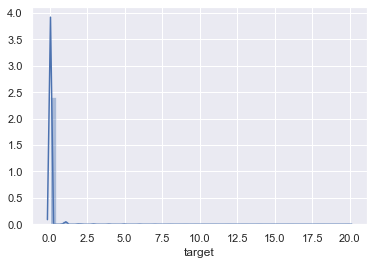

In [37]:
sns.distplot(sales.tail(100000)['target'])

In [38]:
sales.head(4)

month  shopid  itemid  target  itemcategoryid  lagitemshop1  lagitemshop2  \
0      0       0       0     0.0              40           NaN           NaN   
1      0       0       1     0.0              76           0.0           0.0   
2      0       0       2     0.0              40           0.0           0.0   
3      0       0       3     0.0              40           0.0           0.0   

   lagitemshop3  lagitem1  lagitem2  lagitem3  meanlagitemshop  meanlagitem  \
0           NaN       NaN       NaN       NaN              NaN          NaN   
1           0.0       0.0       0.0       0.0              0.0          0.0   
2           0.0       0.0       0.0       0.0              0.0          0.0   
3           0.0       0.0       0.0       0.0              0.0          0.0   

   cumulativemeanitemshop  deprecateditemshop  deprecateditem  shopcityid  \
0                     NaN                   0               0          29   
1                     NaN                   1               1          29   
2                     NaN                   1               1          29   
3                     NaN                   1               1          29   

   shoptypeid  itemcategorytypeid  itemcategorysubtypeid  nbdays  year  \
0           0                  11                      4      31     0   
1           0                  15                     31      31     0   
2           0                  11                      4      31     0   
3           0                  11                      4      31     0   

   monthofyear  nbweekends  monthssinceitemlaunched  monthssinceshoplaunched  \
0            1           4                        0                        1   
1            1           4                        0                        1   
2            1           4                        0                        1   
3            1           4                        0                        1   

   shopclosed  
0           0  
1           0  
2           0  
3           0

### Model for new items

To beat  
month32: 
total rmse new items: 2.314206726913748  
with 12986 rows  

month33: 
total rmse new items: 1.7001472640260322  
with 20900 rows  

In [40]:
#sales = pd.read_csv('sales.csv')

salesnew = sales[sales.newitem==1]
print(salesnew.shape)

del sales

salesnew = salesnew.drop(columns=[
    'lagitemshop1',
    'lagitemshop2',
    'lagitemshop3',
    'lagitemshop6',
    'lagitemshop12',
    'lagitem1',
    'lagitem2',
    'lagitem3',
    'lagitem6',
    'lagitem12',
    'meanlagitemshop',
    'meanlagitem',
    'cumulativemeanitemshop',
    'deprecateditemshop',
    'deprecateditem',
    'monthssinceitemlaunched',
    'itempriceavg',
    'itempricemin',
    'itempricemax',
    'price',
    'lastitemprice',
    'antelastitemprice',
    'ratiolastanteprice',
    'ratiolastavgprice',
    'ratiolastminprice',
    'ratiolastmaxprice',
    'ratiominmaxprice',
    'newitem'
])
print(salesnew.shape)
"""
salesnew = salesnew.fillna(0)

salesnew['month'] = salesnew['month'].astype(np.int8)
salesnew['shopid'] = salesnew['shopid'].astype(np.int8)
salesnew['target'] = salesnew['target'].astype(np.float16)
salesnew['itemcategoryid'] = salesnew['itemcategoryid'].astype(np.int8)
salesnew['shopcityid'] = salesnew['shopcityid'].astype(np.int8)
salesnew['shoptypeid'] = salesnew['shoptypeid'].astype(np.int8)
salesnew['itemcategorytypeid'] = salesnew['itemcategorytypeid'].astype(np.int8)
salesnew['itemcategorysubtypeid'] = salesnew['itemcategorysubtypeid'].astype(np.int8)
salesnew['nbdays'] = salesnew['nbdays'].astype(np.int8)
salesnew['year'] = salesnew['year'].astype(np.int8)
salesnew['monthofyear'] = salesnew['monthofyear'].astype(np.int8)
salesnew['nbweekends'] = salesnew['nbweekends'].astype(np.int8)
salesnew['monthssinceshoplaunched'] = salesnew['monthssinceshoplaunched'].astype(np.int8)
salesnew['shopclosed'] = salesnew['shopclosed'].astype(np.int8)
salesnew['lag1'] = salesnew['lag1'].astype(np.float16)
salesnew['lagshop1'] = salesnew['lagshop1'].astype(np.float16)
salesnew['lagshop2'] = salesnew['lagshop2'].astype(np.float16)
salesnew['lagshop3'] = salesnew['lagshop3'].astype(np.float16)
salesnew['lagshop6'] = salesnew['lagshop6'].astype(np.float16)
salesnew['lagshop12'] = salesnew['lagshop12'].astype(np.float16)
salesnew['lagitemcategoryidavg1'] = salesnew['lagitemcategoryidavg1'].astype(np.float16)
salesnew['lagshopiditemcategoryidavg1'] = salesnew['lagshopiditemcategoryidavg1'].astype(np.float16)
salesnew['lagshopiditemcategorytypeidavg1'] = salesnew['lagshopiditemcategorytypeidavg1'].astype(np.float16)
salesnew['lagshopiditemcategorysubtypeidavg1'] = salesnew['lagshopiditemcategorysubtypeidavg1'].astype(np.float16)
salesnew['lagshopidshopcityidavg1'] = salesnew['lagshopidshopcityidavg1'].astype(np.float16)
salesnew['lagitemidshopcityidavg1'] = salesnew['lagitemidshopcityidavg1'].astype(np.float16)
salesnew['lagshoptypeid1'] = salesnew['lagshoptypeid1'].astype(np.float16)
salesnew['tsshopid1'] = salesnew['tsshopid1'].astype(np.float16)
salesnew['tsshopid2'] = salesnew['tsshopid2'].astype(np.float16)
salesnew['tsshopid3'] = salesnew['tsshopid3'].astype(np.float16)
salesnew['tsshopid4'] = salesnew['tsshopid4'].astype(np.float16)
salesnew['tsshopid5'] = salesnew['tsshopid5'].astype(np.float16)
salesnew['tsshopid6'] = salesnew['tsshopid6'].astype(np.float16)
salesnew['tsshopid7'] = salesnew['tsshopid7'].astype(np.float16)
salesnew['tsshopid8'] = salesnew['tsshopid8'].astype(np.float16)
salesnew['tsshopid9'] = salesnew['tsshopid9'].astype(np.float16)
salesnew['tsshopid10'] = salesnew['tsshopid10'].astype(np.float16)
salesnew['tsshopid11'] = salesnew['tsshopid11'].astype(np.float16)
salesnew['tsshopid12'] = salesnew['tsshopid12'].astype(np.float16)
salesnew['tsshopcityid1'] = salesnew['tsshopcityid1'].astype(np.float16)
salesnew['tsshopcityid2'] = salesnew['tsshopcityid2'].astype(np.float16)
salesnew['tsshopcityid3'] = salesnew['tsshopcityid3'].astype(np.float16)
salesnew['tsshopcityid4'] = salesnew['tsshopcityid4'].astype(np.float16)
salesnew['tsshopcityid5'] = salesnew['tsshopcityid5'].astype(np.float16)
salesnew['tsshopcityid6'] = salesnew['tsshopcityid6'].astype(np.float16)
salesnew['tsshopcityid7'] = salesnew['tsshopcityid7'].astype(np.float16)
salesnew['tsshopcityid8'] = salesnew['tsshopcityid8'].astype(np.float16)
salesnew['tsshopcityid9'] = salesnew['tsshopcityid9'].astype(np.float16)
salesnew['tsshopcityid10'] = salesnew['tsshopcityid10'].astype(np.float16)
salesnew['tsshopcityid11'] = salesnew['tsshopcityid11'].astype(np.float16)
salesnew['tsshopcityid12'] = salesnew['tsshopcityid12'].astype(np.float16)
salesnew['tsshoptypeid1'] = salesnew['tsshoptypeid1'].astype(np.float16)
salesnew['tsshoptypeid2'] = salesnew['tsshoptypeid2'].astype(np.float16)
salesnew['tsshoptypeid3'] = salesnew['tsshoptypeid3'].astype(np.float16)
salesnew['tsshoptypeid4'] = salesnew['tsshoptypeid4'].astype(np.float16)
salesnew['tsshoptypeid5'] = salesnew['tsshoptypeid5'].astype(np.float16)
salesnew['tsshoptypeid6'] = salesnew['tsshoptypeid6'].astype(np.float16)
salesnew['tsshoptypeid7'] = salesnew['tsshoptypeid7'].astype(np.float16)
salesnew['tsshoptypeid8'] = salesnew['tsshoptypeid8'].astype(np.float16)
salesnew['tsshoptypeid9'] = salesnew['tsshoptypeid9'].astype(np.float16)
salesnew['tsshoptypeid10'] = salesnew['tsshoptypeid10'].astype(np.float16)
salesnew['tsshoptypeid11'] = salesnew['tsshoptypeid11'].astype(np.float16)
salesnew['tsshoptypeid12'] = salesnew['tsshoptypeid12'].astype(np.float16)
salesnew['tsitemcategoryid1'] = salesnew['tsitemcategoryid1'].astype(np.float16)
salesnew['tsitemcategoryid2'] = salesnew['tsitemcategoryid2'].astype(np.float16)
salesnew['tsitemcategoryid3'] = salesnew['tsitemcategoryid3'].astype(np.float16)
salesnew['tsitemcategoryid4'] = salesnew['tsitemcategoryid4'].astype(np.float16)
salesnew['tsitemcategoryid5'] = salesnew['tsitemcategoryid5'].astype(np.float16)
salesnew['tsitemcategoryid6'] = salesnew['tsitemcategoryid6'].astype(np.float16)
salesnew['tsitemcategoryid7'] = salesnew['tsitemcategoryid7'].astype(np.float16)
salesnew['tsitemcategoryid8'] = salesnew['tsitemcategoryid8'].astype(np.float16)
salesnew['tsitemcategoryid9'] = salesnew['tsitemcategoryid9'].astype(np.float16)
salesnew['tsitemcategoryid10'] = salesnew['tsitemcategoryid10'].astype(np.float16)
salesnew['tsitemcategoryid11'] = salesnew['tsitemcategoryid11'].astype(np.float16)
salesnew['tsitemcategoryid12'] = salesnew['tsitemcategoryid12'].astype(np.float16)
salesnew['tsitemcategorytypeid1'] = salesnew['tsitemcategorytypeid1'].astype(np.float16)
salesnew['tsitemcategorytypeid2'] = salesnew['tsitemcategorytypeid2'].astype(np.float16)
salesnew['tsitemcategorytypeid3'] = salesnew['tsitemcategorytypeid3'].astype(np.float16)
salesnew['tsitemcategorytypeid4'] = salesnew['tsitemcategorytypeid4'].astype(np.float16)
salesnew['tsitemcategorytypeid5'] = salesnew['tsitemcategorytypeid5'].astype(np.float16)
salesnew['tsitemcategorytypeid6'] = salesnew['tsitemcategorytypeid6'].astype(np.float16)
salesnew['tsitemcategorytypeid7'] = salesnew['tsitemcategorytypeid7'].astype(np.float16)
salesnew['tsitemcategorytypeid8'] = salesnew['tsitemcategorytypeid8'].astype(np.float16)
salesnew['tsitemcategorytypeid9'] = salesnew['tsitemcategorytypeid9'].astype(np.float16)
salesnew['tsitemcategorytypeid10'] = salesnew['tsitemcategorytypeid10'].astype(np.float16)
salesnew['tsitemcategorytypeid11'] = salesnew['tsitemcategorytypeid11'].astype(np.float16)
salesnew['tsitemcategorytypeid12'] = salesnew['tsitemcategorytypeid12'].astype(np.float16)
salesnew['tsitemcategorysubtypeid1'] = salesnew['tsitemcategorysubtypeid1'].astype(np.float16)
salesnew['tsitemcategorysubtypeid2'] = salesnew['tsitemcategorysubtypeid2'].astype(np.float16)
salesnew['tsitemcategorysubtypeid3'] = salesnew['tsitemcategorysubtypeid3'].astype(np.float16)
salesnew['tsitemcategorysubtypeid4'] = salesnew['tsitemcategorysubtypeid4'].astype(np.float16)
salesnew['tsitemcategorysubtypeid5'] = salesnew['tsitemcategorysubtypeid5'].astype(np.float16)
salesnew['tsitemcategorysubtypeid6'] = salesnew['tsitemcategorysubtypeid6'].astype(np.float16)
salesnew['tsitemcategorysubtypeid7'] = salesnew['tsitemcategorysubtypeid7'].astype(np.float16)
salesnew['tsitemcategorysubtypeid8'] = salesnew['tsitemcategorysubtypeid8'].astype(np.float16)
salesnew['tsitemcategorysubtypeid9'] = salesnew['tsitemcategorysubtypeid9'].astype(np.float16)
salesnew['tsitemcategorysubtypeid10'] = salesnew['tsitemcategorysubtypeid10'].astype(np.float16)
salesnew['tsitemcategorysubtypeid11'] = salesnew['tsitemcategorysubtypeid11'].astype(np.float16)
salesnew['tsitemcategorysubtypeid12'] = salesnew['tsitemcategorysubtypeid12'].astype(np.float16)
"""

(1018687, 308)
(1018687, 280)


"\nsalesnew = salesnew.fillna(0)\n\nsalesnew['month'] = salesnew['month'].astype(np.int8)\nsalesnew['shopid'] = salesnew['shopid'].astype(np.int8)\nsalesnew['target'] = salesnew['target'].astype(np.float16)\nsalesnew['itemcategoryid'] = salesnew['itemcategoryid'].astype(np.int8)\nsalesnew['shopcityid'] = salesnew['shopcityid'].astype(np.int8)\nsalesnew['shoptypeid'] = salesnew['shoptypeid'].astype(np.int8)\nsalesnew['itemcategorytypeid'] = salesnew['itemcategorytypeid'].astype(np.int8)\nsalesnew['itemcategorysubtypeid'] = salesnew['itemcategorysubtypeid'].astype(np.int8)\nsalesnew['nbdays'] = salesnew['nbdays'].astype(np.int8)\nsalesnew['year'] = salesnew['year'].astype(np.int8)\nsalesnew['monthofyear'] = salesnew['monthofyear'].astype(np.int8)\nsalesnew['nbweekends'] = salesnew['nbweekends'].astype(np.int8)\nsalesnew['monthssinceshoplaunched'] = salesnew['monthssinceshoplaunched'].astype(np.int8)\nsalesnew['shopclosed'] = salesnew['shopclosed'].astype(np.int8)\nsalesnew['lag1'] = sale

In [41]:
salesnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018687 entries, 0 to 11127995
Columns: 280 entries, month to tsshoptypeidshopid12
dtypes: float16(266), int64(1), int8(13)
memory usage: 545.0 MB


In [22]:
np.sort(salesnew.itemid.unique())

array([    0,     1,     2, ..., 22167, 22168, 22169])

In [42]:
for column in salesnew.columns:
    #print("salesnew['{}'] = salesnew['{}'].astype(np.float16)".format(column,column))
    print("'{}',".format(column,column))

'month',
'shopid',
'itemid',
'target',
'itemcategoryid',
'shopcityid',
'shoptypeid',
'itemcategorytypeid',
'itemcategorysubtypeid',
'nbdays',
'year',
'monthofyear',
'nbweekends',
'monthssinceshoplaunched',
'shopclosed',
'lag1',
'lagshop1',
'lagshop2',
'lagshop3',
'lagshop6',
'lagshop12',
'lagitemcategoryidavg1',
'lagshopiditemcategoryidavg1',
'lagshopiditemcategorytypeidavg1',
'lagshopiditemcategorysubtypeidavg1',
'lagshopidshopcityidavg1',
'lagitemidshopcityidavg1',
'lagshoptypeid1',
'tsshopid1',
'tsshopid2',
'tsshopid3',
'tsshopid4',
'tsshopid5',
'tsshopid6',
'tsshopid7',
'tsshopid8',
'tsshopid9',
'tsshopid10',
'tsshopid11',
'tsshopid12',
'tsshopcityid1',
'tsshopcityid2',
'tsshopcityid3',
'tsshopcityid4',
'tsshopcityid5',
'tsshopcityid6',
'tsshopcityid7',
'tsshopcityid8',
'tsshopcityid9',
'tsshopcityid10',
'tsshopcityid11',
'tsshopcityid12',
'tsshoptypeid1',
'tsshoptypeid2',
'tsshoptypeid3',
'tsshoptypeid4',
'tsshoptypeid5',
'tsshoptypeid6',
'tsshoptypeid7',
'tsshoptypeid8',
'tsshopt

In [125]:
salesnew = sales[sales.newitem==1]
print(salesnew.shape)
for i in range(35):#0..34
    print(salesnew[salesnew.month==i].shape)

(1018687, 56)
(365175, 56)
(56902, 56)
(36708, 56)
(28888, 56)
(30690, 56)
(24426, 56)
(20562, 56)
(21150, 56)
(17280, 56)
(30084, 56)
(22005, 56)
(24610, 56)
(9522, 56)
(15594, 56)
(14880, 56)
(15631, 56)
(12838, 56)
(12397, 56)
(15800, 56)
(12750, 56)
(16500, 56)
(29016, 56)
(23000, 56)
(23600, 56)
(9850, 56)
(10575, 56)
(15456, 56)
(12314, 56)
(9900, 56)
(10750, 56)
(8858, 56)
(11844, 56)
(12986, 56)
(20900, 56)
(15246, 56)


In [ ]:
work avg features on combinations of: with lags
    itemcategoryid
    itemcategorytypeid
    itemcategorysubtypeid
    shopcityid
    shoptypeid
    shopid
    
existing combinations with lags:
    itemcategoryid lag1
    shopid/itemcategoryid lag1
    shopid/itemcategorytypeid lag1
    shopid/shopcityid lag1
    shoptypeid lag1
    shopid lag1,2,3,6,12

Two features combinations avg for:
    itemcategoryid/itemcategorytypeid
    itemcategoryid/itemcategorysubtypeid
    itemcategoryid/shopcityid
    itemcategoryid/shoptypeid
    itemcategoryid/shopid
    
    itemcategorytypeid/itemcategorysubtypeid
    itemcategorytypeid/shopcityid
    itemcategorytypeid/shoptypeid
    itemcategorytypeid/shopid
    
    itemcategorysubtypeid/shopcityid
    itemcategorysubtypeid/shoptypeid
    itemcategorysubtypeid/shopid
    
    shopcityid/shoptypeid
    shopcityid/shopid
    
    shoptypeid/shopid

In [44]:
salesnew = salesnew.fillna(0)

In [46]:
features = [
    'month',
    'shopid',
    'itemid',
    'itemcategoryid',
    'shopcityid',
    'shoptypeid',
    'itemcategorytypeid',
    'itemcategorysubtypeid',
    'nbdays',
    'year',
    'monthofyear',
    'nbweekends',
    'monthssinceshoplaunched',
    'shopclosed',
    #'lag1',
    #'lagshop1',
    #'lagshop2',
    #'lagshop3',
    #'lagshop6',
    #'lagshop12',
    #'lagitemcategoryidavg1',
    #'lagshopiditemcategoryidavg1',
    #'lagshopiditemcategorytypeidavg1',
    #'lagshopiditemcategorysubtypeidavg1',
    #'lagshopidshopcityidavg1',
    #'lagshoptypeid1'
    'lag1',
    'lagshop1',
    'lagshop2',
    'lagshop3',
    'lagshop6',
    'lagshop12',
    'lagitemcategoryidavg1',
    'lagshopiditemcategoryidavg1',
    'lagshopiditemcategorytypeidavg1',
    'lagshopiditemcategorysubtypeidavg1',
    'lagshopidshopcityidavg1',
    'lagitemidshopcityidavg1',
    'lagshoptypeid1',
    'tsshopid1',
    'tsshopid2',
    'tsshopid3',
    'tsshopid4',
    'tsshopid5',
    'tsshopid6',
    'tsshopid7',
    'tsshopid8',
    'tsshopid9',
    'tsshopid10',
    'tsshopid11',
    'tsshopid12',
    'tsshopcityid1',
    'tsshopcityid2',
    'tsshopcityid3',
    'tsshopcityid4',
    'tsshopcityid5',
    'tsshopcityid6',
    'tsshopcityid7',
    'tsshopcityid8',
    'tsshopcityid9',
    'tsshopcityid10',
    'tsshopcityid11',
    'tsshopcityid12',
    'tsshoptypeid1',
    'tsshoptypeid2',
    'tsshoptypeid3',
    'tsshoptypeid4',
    'tsshoptypeid5',
    'tsshoptypeid6',
    'tsshoptypeid7',
    'tsshoptypeid8',
    'tsshoptypeid9',
    'tsshoptypeid10',
    'tsshoptypeid11',
    'tsshoptypeid12',
    'tsitemcategoryid1',
    'tsitemcategoryid2',
    'tsitemcategoryid3',
    'tsitemcategoryid4',
    'tsitemcategoryid5',
    'tsitemcategoryid6',
    'tsitemcategoryid7',
    'tsitemcategoryid8',
    'tsitemcategoryid9',
    'tsitemcategoryid10',
    'tsitemcategoryid11',
    'tsitemcategoryid12',
    'tsitemcategorytypeid1',
    'tsitemcategorytypeid2',
    'tsitemcategorytypeid3',
    'tsitemcategorytypeid4',
    'tsitemcategorytypeid5',
    'tsitemcategorytypeid6',
    'tsitemcategorytypeid7',
    'tsitemcategorytypeid8',
    'tsitemcategorytypeid9',
    'tsitemcategorytypeid10',
    'tsitemcategorytypeid11',
    'tsitemcategorytypeid12',
    'tsitemcategorysubtypeid1',
    'tsitemcategorysubtypeid2',
    'tsitemcategorysubtypeid3',
    'tsitemcategorysubtypeid4',
    'tsitemcategorysubtypeid5',
    'tsitemcategorysubtypeid6',
    'tsitemcategorysubtypeid7',
    'tsitemcategorysubtypeid8',
    'tsitemcategorysubtypeid9',
    'tsitemcategorysubtypeid10',
    'tsitemcategorysubtypeid11',
    'tsitemcategorysubtypeid12',
    'tsitemcategoryiditemcategorytypeid1',
    'tsitemcategoryiditemcategorytypeid2',
    'tsitemcategoryiditemcategorytypeid3',
    'tsitemcategoryiditemcategorytypeid4',
    'tsitemcategoryiditemcategorytypeid5',
    'tsitemcategoryiditemcategorytypeid6',
    'tsitemcategoryiditemcategorytypeid7',
    'tsitemcategoryiditemcategorytypeid8',
    'tsitemcategoryiditemcategorytypeid9',
    'tsitemcategoryiditemcategorytypeid10',
    'tsitemcategoryiditemcategorytypeid11',
    'tsitemcategoryiditemcategorytypeid12',
    'tsitemcategoryiditemcategorysubtypeid1',
    'tsitemcategoryiditemcategorysubtypeid2',
    'tsitemcategoryiditemcategorysubtypeid3',
    'tsitemcategoryiditemcategorysubtypeid4',
    'tsitemcategoryiditemcategorysubtypeid5',
    'tsitemcategoryiditemcategorysubtypeid6',
    'tsitemcategoryiditemcategorysubtypeid7',
    'tsitemcategoryiditemcategorysubtypeid8',
    'tsitemcategoryiditemcategorysubtypeid9',
    'tsitemcategoryiditemcategorysubtypeid10',
    'tsitemcategoryiditemcategorysubtypeid11',
    'tsitemcategoryiditemcategorysubtypeid12',
    'tsitemcategoryidshopcityid1',
    'tsitemcategoryidshopcityid2',
    'tsitemcategoryidshopcityid3',
    'tsitemcategoryidshopcityid4',
    'tsitemcategoryidshopcityid5',
    'tsitemcategoryidshopcityid6',
    'tsitemcategoryidshopcityid7',
    'tsitemcategoryidshopcityid8',
    'tsitemcategoryidshopcityid9',
    'tsitemcategoryidshopcityid10',
    'tsitemcategoryidshopcityid11',
    'tsitemcategoryidshopcityid12',
    'tsitemcategoryidshoptypeid1',
    'tsitemcategoryidshoptypeid2',
    'tsitemcategoryidshoptypeid3',
    'tsitemcategoryidshoptypeid4',
    'tsitemcategoryidshoptypeid5',
    'tsitemcategoryidshoptypeid6',
    'tsitemcategoryidshoptypeid7',
    'tsitemcategoryidshoptypeid8',
    'tsitemcategoryidshoptypeid9',
    'tsitemcategoryidshoptypeid10',
    'tsitemcategoryidshoptypeid11',
    'tsitemcategoryidshoptypeid12',
    'tsitemcategoryidshopid1',
    'tsitemcategoryidshopid2',
    'tsitemcategoryidshopid3',
    'tsitemcategoryidshopid4',
    'tsitemcategoryidshopid5',
    'tsitemcategoryidshopid6',
    'tsitemcategoryidshopid7',
    'tsitemcategoryidshopid8',
    'tsitemcategoryidshopid9',
    'tsitemcategoryidshopid10',
    'tsitemcategoryidshopid11',
    'tsitemcategoryidshopid12',
    'tsitemcategorytypeiditemcategorysubtypeid1',
    'tsitemcategorytypeiditemcategorysubtypeid2',
    'tsitemcategorytypeiditemcategorysubtypeid3',
    'tsitemcategorytypeiditemcategorysubtypeid4',
    'tsitemcategorytypeiditemcategorysubtypeid5',
    'tsitemcategorytypeiditemcategorysubtypeid6',
    'tsitemcategorytypeiditemcategorysubtypeid7',
    'tsitemcategorytypeiditemcategorysubtypeid8',
    'tsitemcategorytypeiditemcategorysubtypeid9',
    'tsitemcategorytypeiditemcategorysubtypeid10',
    'tsitemcategorytypeiditemcategorysubtypeid11',
    'tsitemcategorytypeiditemcategorysubtypeid12',
    'tsitemcategorytypeidshopcityid1',
    'tsitemcategorytypeidshopcityid2',
    'tsitemcategorytypeidshopcityid3',
    'tsitemcategorytypeidshopcityid4',
    'tsitemcategorytypeidshopcityid5',
    'tsitemcategorytypeidshopcityid6',
    'tsitemcategorytypeidshopcityid7',
    'tsitemcategorytypeidshopcityid8',
    'tsitemcategorytypeidshopcityid9',
    'tsitemcategorytypeidshopcityid10',
    'tsitemcategorytypeidshopcityid11',
    'tsitemcategorytypeidshopcityid12',
    'tsitemcategorytypeidshoptypeid1',
    'tsitemcategorytypeidshoptypeid2',
    'tsitemcategorytypeidshoptypeid3',
    'tsitemcategorytypeidshoptypeid4',
    'tsitemcategorytypeidshoptypeid5',
    'tsitemcategorytypeidshoptypeid6',
    'tsitemcategorytypeidshoptypeid7',
    'tsitemcategorytypeidshoptypeid8',
    'tsitemcategorytypeidshoptypeid9',
    'tsitemcategorytypeidshoptypeid10',
    'tsitemcategorytypeidshoptypeid11',
    'tsitemcategorytypeidshoptypeid12',
    'tsitemcategorytypeidshopid1',
    'tsitemcategorytypeidshopid2',
    'tsitemcategorytypeidshopid3',
    'tsitemcategorytypeidshopid4',
    'tsitemcategorytypeidshopid5',
    'tsitemcategorytypeidshopid6',
    'tsitemcategorytypeidshopid7',
    'tsitemcategorytypeidshopid8',
    'tsitemcategorytypeidshopid9',
    'tsitemcategorytypeidshopid10',
    'tsitemcategorytypeidshopid11',
    'tsitemcategorytypeidshopid12',
    'tsitemcategorysubtypeidshopcityid1',
    'tsitemcategorysubtypeidshopcityid2',
    'tsitemcategorysubtypeidshopcityid3',
    'tsitemcategorysubtypeidshopcityid4',
    'tsitemcategorysubtypeidshopcityid5',
    'tsitemcategorysubtypeidshopcityid6',
    'tsitemcategorysubtypeidshopcityid7',
    'tsitemcategorysubtypeidshopcityid8',
    'tsitemcategorysubtypeidshopcityid9',
    'tsitemcategorysubtypeidshopcityid10',
    'tsitemcategorysubtypeidshopcityid11',
    'tsitemcategorysubtypeidshopcityid12',
    'tsitemcategorysubtypeidshoptypeid1',
    'tsitemcategorysubtypeidshoptypeid2',
    'tsitemcategorysubtypeidshoptypeid3',
    'tsitemcategorysubtypeidshoptypeid4',
    'tsitemcategorysubtypeidshoptypeid5',
    'tsitemcategorysubtypeidshoptypeid6',
    'tsitemcategorysubtypeidshoptypeid7',
    'tsitemcategorysubtypeidshoptypeid8',
    'tsitemcategorysubtypeidshoptypeid9',
    'tsitemcategorysubtypeidshoptypeid10',
    'tsitemcategorysubtypeidshoptypeid11',
    'tsitemcategorysubtypeidshoptypeid12',
    'tsitemcategorysubtypeidshopid1',
    'tsitemcategorysubtypeidshopid2',
    'tsitemcategorysubtypeidshopid3',
    'tsitemcategorysubtypeidshopid4',
    'tsitemcategorysubtypeidshopid5',
    'tsitemcategorysubtypeidshopid6',
    'tsitemcategorysubtypeidshopid7',
    'tsitemcategorysubtypeidshopid8',
    'tsitemcategorysubtypeidshopid9',
    'tsitemcategorysubtypeidshopid10',
    'tsitemcategorysubtypeidshopid11',
    'tsitemcategorysubtypeidshopid12',
    'tsshopcityidshoptypeid1',
    'tsshopcityidshoptypeid2',
    'tsshopcityidshoptypeid3',
    'tsshopcityidshoptypeid4',
    'tsshopcityidshoptypeid5',
    'tsshopcityidshoptypeid6',
    'tsshopcityidshoptypeid7',
    'tsshopcityidshoptypeid8',
    'tsshopcityidshoptypeid9',
    'tsshopcityidshoptypeid10',
    'tsshopcityidshoptypeid11',
    'tsshopcityidshoptypeid12',
    'tsshopcityidshopid1',
    'tsshopcityidshopid2',
    'tsshopcityidshopid3',
    'tsshopcityidshopid4',
    'tsshopcityidshopid5',
    'tsshopcityidshopid6',
    'tsshopcityidshopid7',
    'tsshopcityidshopid8',
    'tsshopcityidshopid9',
    'tsshopcityidshopid10',
    'tsshopcityidshopid11',
    'tsshopcityidshopid12',
    'tsshoptypeidshopid1',
    'tsshoptypeidshopid2',
    'tsshoptypeidshopid3',
    'tsshoptypeidshopid4',
    'tsshoptypeidshopid5',
    'tsshoptypeidshopid6',
    'tsshoptypeidshopid7',
    'tsshoptypeidshopid8',
    'tsshoptypeidshopid9',
    'tsshoptypeidshopid10',
    'tsshoptypeidshopid11',
    'tsshoptypeidshopid12'
    
]

categorical_features = [
    'shopid',
    'itemid',
    'itemcategoryid',
    'shopcityid',
    'shoptypeid',
    'itemcategorytypeid',
    'itemcategorysubtypeid',
    'shopclosed'
]

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 44,#71
    'max_depth': 19,#15
    'feature_fraction': 0.9639040863246328,#0.930233257263184
    'bagging_fraction': 0.9149216274612932, #0.9417022004702574
    'bagging_freq': 18,#3
    'learning_rate': 0.01,#0.05
    'early_stopping_round': 200,
    'lambda': 0.8378024755045912,#0.44026767245133913
    'min_split_gain': 7.20114889206731,#0.8178089989260697
    'min_child_samples': 39,#85
    'min_data_per_group': 369,#342
    'min_child_weight': 6.683586781569385,#2.155266936013428
    'cat_smooth': 0.05596554352078842,#1.0113231069171438
    'min_data_in_leaf': 69,#126
    'max_bin': 37,#157
    'verbosity' : -1
}

sales_test = salesnew[salesnew.month > 11]

ROUNDS = 35000
traindf = sales_test[sales_test.month < 32]
testdf = sales_test[sales_test.month == 32]
traingbm = lgb.Dataset(traindf[features], label=traindf['target'], categorical_feature=categorical_features, free_raw_data=False)
testgbm = lgb.Dataset(testdf[features], label=testdf['target'], categorical_feature=categorical_features, free_raw_data=False)
m = lgb.train(params, traingbm, ROUNDS, valid_sets=[traingbm, testgbm], verbose_eval=1)
predsgbm = m.predict(testdf[features])
mse = mean_squared_error(testdf['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))

traindf = sales_test[sales_test.month < 33]
testdf = sales_test[sales_test.month == 33]
traingbm = lgb.Dataset(traindf[features], label=traindf['target'], categorical_feature=categorical_features, free_raw_data=False)
testgbm = lgb.Dataset(testdf[features], label=testdf['target'], categorical_feature=categorical_features, free_raw_data=False)
m = lgb.train(params, traingbm, ROUNDS, valid_sets=[traingbm, testgbm], verbose_eval=1)
predsgbm = m.predict(testdf[features])
mse = mean_squared_error(testdf['target'],predsgbm)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))

[1]	training's rmse: 2.34473	valid_1's rmse: 2.57538
Training until validation scores don't improve for 200 rounds.
[2]	training's rmse: 2.33228	valid_1's rmse: 2.57041
[3]	training's rmse: 2.3199	valid_1's rmse: 2.56463
[4]	training's rmse: 2.30775	valid_1's rmse: 2.56054
[5]	training's rmse: 2.29578	valid_1's rmse: 2.55675
[6]	training's rmse: 2.28386	valid_1's rmse: 2.55271
[7]	training's rmse: 2.27214	valid_1's rmse: 2.54853
[8]	training's rmse: 2.26053	valid_1's rmse: 2.54461
[9]	training's rmse: 2.24915	valid_1's rmse: 2.54073
[10]	training's rmse: 2.23792	valid_1's rmse: 2.53653
[11]	training's rmse: 2.23143	valid_1's rmse: 2.53165
[12]	training's rmse: 2.21931	valid_1's rmse: 2.52852
[13]	training's rmse: 2.20744	valid_1's rmse: 2.52544
[14]	training's rmse: 2.20118	valid_1's rmse: 2.52054
[15]	training's rmse: 2.18963	valid_1's rmse: 2.518
[16]	training's rmse: 2.17816	valid_1's rmse: 2.51503
[17]	training's rmse: 2.16691	valid_1's rmse: 2.51191
[18]	training's rmse: 2.15581	v

[153]	training's rmse: 1.32992	valid_1's rmse: 2.40198
[154]	training's rmse: 1.32668	valid_1's rmse: 2.4021
[155]	training's rmse: 1.32504	valid_1's rmse: 2.40103
[156]	training's rmse: 1.32351	valid_1's rmse: 2.40005
[157]	training's rmse: 1.32034	valid_1's rmse: 2.39998
[158]	training's rmse: 1.31722	valid_1's rmse: 2.4001
[159]	training's rmse: 1.31576	valid_1's rmse: 2.3992
[160]	training's rmse: 1.31267	valid_1's rmse: 2.39914
[161]	training's rmse: 1.30964	valid_1's rmse: 2.39926
[162]	training's rmse: 1.30665	valid_1's rmse: 2.39938
[163]	training's rmse: 1.30519	valid_1's rmse: 2.39859
[164]	training's rmse: 1.3041	valid_1's rmse: 2.39712
[165]	training's rmse: 1.30113	valid_1's rmse: 2.39724
[166]	training's rmse: 1.29822	valid_1's rmse: 2.39736
[167]	training's rmse: 1.29684	valid_1's rmse: 2.39663
[168]	training's rmse: 1.29398	valid_1's rmse: 2.39675
[169]	training's rmse: 1.29116	valid_1's rmse: 2.39686
[170]	training's rmse: 1.28987	valid_1's rmse: 2.39611
[171]	training

[303]	training's rmse: 1.11262	valid_1's rmse: 2.36678
[304]	training's rmse: 1.11216	valid_1's rmse: 2.36629
[305]	training's rmse: 1.11157	valid_1's rmse: 2.36614
[306]	training's rmse: 1.11109	valid_1's rmse: 2.36563
[307]	training's rmse: 1.11022	valid_1's rmse: 2.36563
[308]	training's rmse: 1.10936	valid_1's rmse: 2.36565
[309]	training's rmse: 1.10896	valid_1's rmse: 2.36535
[310]	training's rmse: 1.10812	valid_1's rmse: 2.36531
[311]	training's rmse: 1.10729	valid_1's rmse: 2.3653
[312]	training's rmse: 1.10648	valid_1's rmse: 2.36526
[313]	training's rmse: 1.10548	valid_1's rmse: 2.36531
[314]	training's rmse: 1.10448	valid_1's rmse: 2.36537
[315]	training's rmse: 1.10365	valid_1's rmse: 2.36541
[316]	training's rmse: 1.10284	valid_1's rmse: 2.36545
[317]	training's rmse: 1.10187	valid_1's rmse: 2.3655
[318]	training's rmse: 1.10111	valid_1's rmse: 2.36555
[319]	training's rmse: 1.10036	valid_1's rmse: 2.36559
[320]	training's rmse: 1.09963	valid_1's rmse: 2.36565
[321]	traini

[454]	training's rmse: 1.02783	valid_1's rmse: 2.3355
[455]	training's rmse: 1.02712	valid_1's rmse: 2.33553
[456]	training's rmse: 1.02666	valid_1's rmse: 2.3338
[457]	training's rmse: 1.02627	valid_1's rmse: 2.33386
[458]	training's rmse: 1.02582	valid_1's rmse: 2.33381
[459]	training's rmse: 1.02511	valid_1's rmse: 2.33387
[460]	training's rmse: 1.02468	valid_1's rmse: 2.33383
[461]	training's rmse: 1.02428	valid_1's rmse: 2.33389
[462]	training's rmse: 1.0239	valid_1's rmse: 2.33393
[463]	training's rmse: 1.02354	valid_1's rmse: 2.33398
[464]	training's rmse: 1.02319	valid_1's rmse: 2.33365
[465]	training's rmse: 1.0228	valid_1's rmse: 2.33362
[466]	training's rmse: 1.02257	valid_1's rmse: 2.33274
[467]	training's rmse: 1.02221	valid_1's rmse: 2.33266
[468]	training's rmse: 1.02184	valid_1's rmse: 2.33271
[469]	training's rmse: 1.02151	valid_1's rmse: 2.3327
[470]	training's rmse: 1.02115	valid_1's rmse: 2.33195
[471]	training's rmse: 1.0208	valid_1's rmse: 2.33193
[472]	training's

[604]	training's rmse: 0.979862	valid_1's rmse: 2.32424
[605]	training's rmse: 0.979556	valid_1's rmse: 2.32269
[606]	training's rmse: 0.979316	valid_1's rmse: 2.32247
[607]	training's rmse: 0.979091	valid_1's rmse: 2.32227
[608]	training's rmse: 0.978916	valid_1's rmse: 2.32191
[609]	training's rmse: 0.978707	valid_1's rmse: 2.32189
[610]	training's rmse: 0.978445	valid_1's rmse: 2.32189
[611]	training's rmse: 0.978193	valid_1's rmse: 2.32189
[612]	training's rmse: 0.977896	valid_1's rmse: 2.32029
[613]	training's rmse: 0.977643	valid_1's rmse: 2.32031
[614]	training's rmse: 0.977391	valid_1's rmse: 2.32034
[615]	training's rmse: 0.977144	valid_1's rmse: 2.32037
[616]	training's rmse: 0.976903	valid_1's rmse: 2.3204
[617]	training's rmse: 0.976756	valid_1's rmse: 2.32032
[618]	training's rmse: 0.976498	valid_1's rmse: 2.32034
[619]	training's rmse: 0.976189	valid_1's rmse: 2.32038
[620]	training's rmse: 0.975934	valid_1's rmse: 2.32039
[621]	training's rmse: 0.975689	valid_1's rmse: 2

[751]	training's rmse: 0.949852	valid_1's rmse: 2.31439
[752]	training's rmse: 0.94972	valid_1's rmse: 2.31437
[753]	training's rmse: 0.949524	valid_1's rmse: 2.3144
[754]	training's rmse: 0.949401	valid_1's rmse: 2.31437
[755]	training's rmse: 0.949222	valid_1's rmse: 2.3144
[756]	training's rmse: 0.949083	valid_1's rmse: 2.31445
[757]	training's rmse: 0.948901	valid_1's rmse: 2.31448
[758]	training's rmse: 0.948721	valid_1's rmse: 2.3145
[759]	training's rmse: 0.948526	valid_1's rmse: 2.31454
[760]	training's rmse: 0.948345	valid_1's rmse: 2.31462
[761]	training's rmse: 0.948164	valid_1's rmse: 2.31351
[762]	training's rmse: 0.948007	valid_1's rmse: 2.31347
[763]	training's rmse: 0.947813	valid_1's rmse: 2.31348
[764]	training's rmse: 0.947641	valid_1's rmse: 2.31349
[765]	training's rmse: 0.947506	valid_1's rmse: 2.31343
[766]	training's rmse: 0.947324	valid_1's rmse: 2.31098
[767]	training's rmse: 0.947206	valid_1's rmse: 2.31095
[768]	training's rmse: 0.947015	valid_1's rmse: 2.30

[899]	training's rmse: 0.928049	valid_1's rmse: 2.28739
[900]	training's rmse: 0.927901	valid_1's rmse: 2.28741
[901]	training's rmse: 0.927761	valid_1's rmse: 2.2873
[902]	training's rmse: 0.92766	valid_1's rmse: 2.28731
[903]	training's rmse: 0.927526	valid_1's rmse: 2.2872
[904]	training's rmse: 0.927401	valid_1's rmse: 2.2871
[905]	training's rmse: 0.927276	valid_1's rmse: 2.28713
[906]	training's rmse: 0.927122	valid_1's rmse: 2.2864
[907]	training's rmse: 0.926995	valid_1's rmse: 2.28635
[908]	training's rmse: 0.926885	valid_1's rmse: 2.28631
[909]	training's rmse: 0.926787	valid_1's rmse: 2.28633
[910]	training's rmse: 0.92666	valid_1's rmse: 2.28635
[911]	training's rmse: 0.926543	valid_1's rmse: 2.28637
[912]	training's rmse: 0.926425	valid_1's rmse: 2.28639
[913]	training's rmse: 0.926307	valid_1's rmse: 2.28643
[914]	training's rmse: 0.926191	valid_1's rmse: 2.28645
[915]	training's rmse: 0.926079	valid_1's rmse: 2.28646
[916]	training's rmse: 0.925958	valid_1's rmse: 2.2864

[1046]	training's rmse: 0.909383	valid_1's rmse: 2.28297
[1047]	training's rmse: 0.909258	valid_1's rmse: 2.28299
[1048]	training's rmse: 0.909138	valid_1's rmse: 2.283
[1049]	training's rmse: 0.909035	valid_1's rmse: 2.28302
[1050]	training's rmse: 0.908929	valid_1's rmse: 2.28306
[1051]	training's rmse: 0.908812	valid_1's rmse: 2.28306
[1052]	training's rmse: 0.908705	valid_1's rmse: 2.2829
[1053]	training's rmse: 0.908585	valid_1's rmse: 2.28293
[1054]	training's rmse: 0.908476	valid_1's rmse: 2.28262
[1055]	training's rmse: 0.908366	valid_1's rmse: 2.28207
[1056]	training's rmse: 0.908261	valid_1's rmse: 2.28156
[1057]	training's rmse: 0.908145	valid_1's rmse: 2.28157
[1058]	training's rmse: 0.908042	valid_1's rmse: 2.28114
[1059]	training's rmse: 0.907965	valid_1's rmse: 2.28114
[1060]	training's rmse: 0.907869	valid_1's rmse: 2.28116
[1061]	training's rmse: 0.907778	valid_1's rmse: 2.28116
[1062]	training's rmse: 0.907683	valid_1's rmse: 2.28117
[1063]	training's rmse: 0.907566	v

[1191]	training's rmse: 0.893957	valid_1's rmse: 2.27946
[1192]	training's rmse: 0.893862	valid_1's rmse: 2.27948
[1193]	training's rmse: 0.89376	valid_1's rmse: 2.27948
[1194]	training's rmse: 0.893663	valid_1's rmse: 2.27948
[1195]	training's rmse: 0.893569	valid_1's rmse: 2.2795
[1196]	training's rmse: 0.893465	valid_1's rmse: 2.27951
[1197]	training's rmse: 0.893383	valid_1's rmse: 2.27952
[1198]	training's rmse: 0.893308	valid_1's rmse: 2.27952
[1199]	training's rmse: 0.893233	valid_1's rmse: 2.27952
[1200]	training's rmse: 0.893158	valid_1's rmse: 2.27952
[1201]	training's rmse: 0.893075	valid_1's rmse: 2.27954
[1202]	training's rmse: 0.89299	valid_1's rmse: 2.27956
[1203]	training's rmse: 0.892888	valid_1's rmse: 2.27957
[1204]	training's rmse: 0.892772	valid_1's rmse: 2.27958
[1205]	training's rmse: 0.892701	valid_1's rmse: 2.27958
[1206]	training's rmse: 0.892637	valid_1's rmse: 2.27957
[1207]	training's rmse: 0.892546	valid_1's rmse: 2.27958
[1208]	training's rmse: 0.892455	v

[1336]	training's rmse: 0.878908	valid_1's rmse: 2.27932
[1337]	training's rmse: 0.878815	valid_1's rmse: 2.27934
[1338]	training's rmse: 0.878725	valid_1's rmse: 2.27935
[1339]	training's rmse: 0.878643	valid_1's rmse: 2.27936
[1340]	training's rmse: 0.878558	valid_1's rmse: 2.27938
[1341]	training's rmse: 0.8785	valid_1's rmse: 2.27936
[1342]	training's rmse: 0.878419	valid_1's rmse: 2.27936
[1343]	training's rmse: 0.878335	valid_1's rmse: 2.27936
[1344]	training's rmse: 0.878254	valid_1's rmse: 2.27936
[1345]	training's rmse: 0.878171	valid_1's rmse: 2.27938
[1346]	training's rmse: 0.878092	valid_1's rmse: 2.2794
[1347]	training's rmse: 0.878018	valid_1's rmse: 2.27941
[1348]	training's rmse: 0.877928	valid_1's rmse: 2.27944
[1349]	training's rmse: 0.877852	valid_1's rmse: 2.27945
[1350]	training's rmse: 0.877773	valid_1's rmse: 2.27947
[1351]	training's rmse: 0.877679	valid_1's rmse: 2.27952
[1352]	training's rmse: 0.877589	valid_1's rmse: 2.27956
[1353]	training's rmse: 0.877501	v

[1481]	training's rmse: 0.866238	valid_1's rmse: 2.27975
[1482]	training's rmse: 0.866036	valid_1's rmse: 2.27976
[1483]	training's rmse: 0.865865	valid_1's rmse: 2.27976
[1484]	training's rmse: 0.865667	valid_1's rmse: 2.27978
[1485]	training's rmse: 0.865587	valid_1's rmse: 2.27978
[1486]	training's rmse: 0.865473	valid_1's rmse: 2.27978
[1487]	training's rmse: 0.865384	valid_1's rmse: 2.27979
[1488]	training's rmse: 0.865301	valid_1's rmse: 2.27979
[1489]	training's rmse: 0.865242	valid_1's rmse: 2.2798
[1490]	training's rmse: 0.865131	valid_1's rmse: 2.27981
[1491]	training's rmse: 0.865001	valid_1's rmse: 2.27982
[1492]	training's rmse: 0.864932	valid_1's rmse: 2.27982
[1493]	training's rmse: 0.864834	valid_1's rmse: 2.27983
[1494]	training's rmse: 0.864757	valid_1's rmse: 2.27983
[1495]	training's rmse: 0.864692	valid_1's rmse: 2.27984
[1496]	training's rmse: 0.864635	valid_1's rmse: 2.27985
[1497]	training's rmse: 0.864571	valid_1's rmse: 2.27986
[1498]	training's rmse: 0.86453	

[109]	training's rmse: 1.4868	valid_1's rmse: 1.83752
[110]	training's rmse: 1.48393	valid_1's rmse: 1.8363
[111]	training's rmse: 1.47873	valid_1's rmse: 1.83635
[112]	training's rmse: 1.47689	valid_1's rmse: 1.8347
[113]	training's rmse: 1.47179	valid_1's rmse: 1.83475
[114]	training's rmse: 1.46675	valid_1's rmse: 1.83481
[115]	training's rmse: 1.4618	valid_1's rmse: 1.83486
[116]	training's rmse: 1.45892	valid_1's rmse: 1.8338
[117]	training's rmse: 1.45409	valid_1's rmse: 1.83386
[118]	training's rmse: 1.44933	valid_1's rmse: 1.83392
[119]	training's rmse: 1.44671	valid_1's rmse: 1.83273
[120]	training's rmse: 1.44203	valid_1's rmse: 1.83279
[121]	training's rmse: 1.43971	valid_1's rmse: 1.83141
[122]	training's rmse: 1.43511	valid_1's rmse: 1.83148
[123]	training's rmse: 1.43061	valid_1's rmse: 1.83154
[124]	training's rmse: 1.42834	valid_1's rmse: 1.83029
[125]	training's rmse: 1.42392	valid_1's rmse: 1.83035
[126]	training's rmse: 1.41958	valid_1's rmse: 1.83042
[127]	training'

[259]	training's rmse: 1.15896	valid_1's rmse: 1.79221
[260]	training's rmse: 1.15779	valid_1's rmse: 1.79207
[261]	training's rmse: 1.15663	valid_1's rmse: 1.79196
[262]	training's rmse: 1.15549	valid_1's rmse: 1.79201
[263]	training's rmse: 1.15437	valid_1's rmse: 1.79188
[264]	training's rmse: 1.15328	valid_1's rmse: 1.79185
[265]	training's rmse: 1.15218	valid_1's rmse: 1.7916
[266]	training's rmse: 1.15125	valid_1's rmse: 1.79151
[267]	training's rmse: 1.15012	valid_1's rmse: 1.79142
[268]	training's rmse: 1.14899	valid_1's rmse: 1.79121
[269]	training's rmse: 1.1481	valid_1's rmse: 1.79114
[270]	training's rmse: 1.14705	valid_1's rmse: 1.79103
[271]	training's rmse: 1.14615	valid_1's rmse: 1.79089
[272]	training's rmse: 1.14527	valid_1's rmse: 1.79075
[273]	training's rmse: 1.1444	valid_1's rmse: 1.79061
[274]	training's rmse: 1.14346	valid_1's rmse: 1.79033
[275]	training's rmse: 1.14265	valid_1's rmse: 1.79024
[276]	training's rmse: 1.14174	valid_1's rmse: 1.79005
[277]	trainin

[409]	training's rmse: 1.05397	valid_1's rmse: 1.77744
[410]	training's rmse: 1.05341	valid_1's rmse: 1.77755
[411]	training's rmse: 1.0529	valid_1's rmse: 1.77758
[412]	training's rmse: 1.05239	valid_1's rmse: 1.77763
[413]	training's rmse: 1.05164	valid_1's rmse: 1.77765
[414]	training's rmse: 1.05109	valid_1's rmse: 1.7777
[415]	training's rmse: 1.05062	valid_1's rmse: 1.77764
[416]	training's rmse: 1.05016	valid_1's rmse: 1.77761
[417]	training's rmse: 1.04966	valid_1's rmse: 1.77761
[418]	training's rmse: 1.0492	valid_1's rmse: 1.77755
[419]	training's rmse: 1.04876	valid_1's rmse: 1.77751
[420]	training's rmse: 1.04829	valid_1's rmse: 1.77714
[421]	training's rmse: 1.04784	valid_1's rmse: 1.77644
[422]	training's rmse: 1.04739	valid_1's rmse: 1.77638
[423]	training's rmse: 1.04695	valid_1's rmse: 1.7763
[424]	training's rmse: 1.04652	valid_1's rmse: 1.77622
[425]	training's rmse: 1.04608	valid_1's rmse: 1.7761
[426]	training's rmse: 1.04562	valid_1's rmse: 1.77606
[427]	training'

[559]	training's rmse: 0.998337	valid_1's rmse: 1.77399
[560]	training's rmse: 0.998014	valid_1's rmse: 1.77402
[561]	training's rmse: 0.997694	valid_1's rmse: 1.7741
[562]	training's rmse: 0.99739	valid_1's rmse: 1.77417
[563]	training's rmse: 0.997091	valid_1's rmse: 1.7742
[564]	training's rmse: 0.996776	valid_1's rmse: 1.77425
[565]	training's rmse: 0.996478	valid_1's rmse: 1.77429
[566]	training's rmse: 0.996184	valid_1's rmse: 1.77436
[567]	training's rmse: 0.995884	valid_1's rmse: 1.7744
[568]	training's rmse: 0.995598	valid_1's rmse: 1.77447
[569]	training's rmse: 0.995315	valid_1's rmse: 1.7745
[570]	training's rmse: 0.995013	valid_1's rmse: 1.77455
[571]	training's rmse: 0.994792	valid_1's rmse: 1.77457
[572]	training's rmse: 0.994506	valid_1's rmse: 1.7746
[573]	training's rmse: 0.994104	valid_1's rmse: 1.77463
[574]	training's rmse: 0.993828	valid_1's rmse: 1.77467
[575]	training's rmse: 0.99352	valid_1's rmse: 1.77399
[576]	training's rmse: 0.993232	valid_1's rmse: 1.77403

[706]	training's rmse: 0.963136	valid_1's rmse: 1.77306
[707]	training's rmse: 0.962919	valid_1's rmse: 1.77309
[708]	training's rmse: 0.962705	valid_1's rmse: 1.77311
[709]	training's rmse: 0.962487	valid_1's rmse: 1.77313
[710]	training's rmse: 0.962283	valid_1's rmse: 1.77312
[711]	training's rmse: 0.962078	valid_1's rmse: 1.77318
[712]	training's rmse: 0.961899	valid_1's rmse: 1.77322
[713]	training's rmse: 0.96172	valid_1's rmse: 1.77326
[714]	training's rmse: 0.961547	valid_1's rmse: 1.77329
[715]	training's rmse: 0.96139	valid_1's rmse: 1.77327
[716]	training's rmse: 0.961183	valid_1's rmse: 1.77326
[717]	training's rmse: 0.961031	valid_1's rmse: 1.77324
[718]	training's rmse: 0.960806	valid_1's rmse: 1.77326
[719]	training's rmse: 0.960629	valid_1's rmse: 1.77329
[720]	training's rmse: 0.960404	valid_1's rmse: 1.77332
[721]	training's rmse: 0.960201	valid_1's rmse: 1.77341
[722]	training's rmse: 0.960002	valid_1's rmse: 1.7735
[723]	training's rmse: 0.9598	valid_1's rmse: 1.773

month32: [835]	training's rmse: 0.951903	valid_1's rmse: 2.24864
month33: [382]	training's rmse: 1.07669	valid_1's rmse: 1.78709

In [25]:
def get_features_importance(model):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame(
        {
            'feature':model.feature_name(), 
            'split':model.feature_importance('split'), 
            'gain':100 * gain / gain.sum()
        }
    ).sort_values('gain', ascending=False)
    return feat_imp

In [26]:
get_features_importance(m)

feature  split       gain
2                               itemid   6224  66.778636
1                               shopid   2746   8.643487
21         lagshopiditemcategoryidavg1    877   4.915469
15                            lagshop1    909   4.125860
23  lagshopiditemcategorysubtypeidavg1   1065   3.364829
3                       itemcategoryid    826   3.289860
19                           lagshop12    840   2.240909
16                            lagshop2    551   1.733023
18                            lagshop6    452   1.284104
17                            lagshop3    340   0.999921
22     lagshopiditemcategorytypeidavg1    455   0.673300
24             lagshopidshopcityidavg1     74   0.469120
4                           shopcityid    126   0.355964
7                itemcategorysubtypeid    125   0.351637
20               lagitemcategoryidavg1    262   0.250616
10                         monthofyear    242   0.224663
0                                month    136   0.134916
12             monthssinceshoplaunched     81   0.064401
14                                lag1     52   0.038587
25                      lagshoptypeid1     52   0.028747
8                               nbdays     28   0.022637
6                   itemcategorytypeid      3   0.007208
11                          nbweekends      3   0.002107
9                                 year      0   0.000000
5                           shoptypeid      0   0.000000
13                          shopclosed      0   0.000000

### Deep learning for new items

In [11]:
salesnew.tail(1)

month  shopid  itemid  target  itemcategoryid  shopcityid  \
11127995     34      59   22137     0.0              40          30   

          shoptypeid  itemcategorytypeid  itemcategorysubtypeid  nbdays  year  \
11127995           5                  11                      4      30     2   

          monthofyear  nbweekends  monthssinceshoplaunched  shopclosed  \
11127995           11           4                       35           0   

              lag1  lagshop1  lagshop2  lagshop3  lagshop6  lagshop12  \
11127995  0.258565   0.14576  0.179744  0.218481  0.159568   0.221607   

          lagitemcategoryidavg1  lagshopiditemcategoryidavg1  \
11127995               0.220812                     0.100254   

          lagshopiditemcategorytypeidavg1  lagshopiditemcategorysubtypeidavg1  \
11127995                         0.125286                            0.100254   

          lagshopidshopcityidavg1  lagitemidshopcityidavg1  lagshoptypeid1  \
11127995                  0.14576                      0.0        0.239579   

          tsshopid1  tsshopid2  tsshopid3  tsshopid4  tsshopid5  tsshopid6  \
11127995    0.14576   0.179744   0.218481    0.18467   0.172163   0.159568   

          tsshopid7  ...  tsitemcategoryid2  tsitemcategoryid3  \
11127995   0.167458  ...           0.200956           0.242183   

          tsitemcategoryid4  tsitemcategoryid5  tsitemcategoryid6  \
11127995           0.247946           0.249878           0.227422   

          tsitemcategoryid7  tsitemcategoryid8  tsitemcategoryid9  \
11127995            0.22655           0.249631            0.25143   

          tsitemcategoryid10  tsitemcategoryid11  tsitemcategoryid12  \
11127995            0.289707            0.338902            0.262451   

          tsitemcategorytypeid1  tsitemcategorytypeid2  tsitemcategorytypeid3  \
11127995               0.224269               0.196066               0.213498   

          tsitemcategorytypeid4  tsitemcategorytypeid5  tsitemcategorytypeid6  \
11127995               0.202046               0.202943               0.189303   

          tsitemcategorytypeid7  tsitemcategorytypeid8  tsitemcategorytypeid9  \
11127995               0.205571               0.212729               0.203086   

          tsitemcategorytypeid10  tsitemcategorytypeid11  \
11127995                0.237846                0.290736   

          tsitemcategorytypeid12  tsitemcategorysubtypeid1  \
11127995                0.215327                  0.220812   

          tsitemcategorysubtypeid2  tsitemcategorysubtypeid3  \
11127995                  0.200956                  0.242183   

          tsitemcategorysubtypeid4  tsitemcategorysubtypeid5  \
11127995                  0.247946                  0.249878   

          tsitemcategorysubtypeid6  tsitemcategorysubtypeid7  \
11127995                  0.227422                   0.22655   

          tsitemcategorysubtypeid8  tsitemcategorysubtypeid9  \
11127995                  0.249631                   0.25143   

          tsitemcategorysubtypeid10  tsitemcategorysubtypeid11  \
11127995                   0.289707                   0.338902   

          tsitemcategorysubtypeid12  
11127995                   0.262451  

[1 rows x 100 columns]

In [20]:
salesnew = salesnew[salesnew.month!=0]

In [23]:
salesnew.itemcategoryid.nunique()

82

In [31]:
salesnew = salesnew.fillna(0)

In [64]:
i=1
for column in salesnew.columns:
    if ('1' in column)&('ts' in column)&('10' not in column)&('11' not in column)&('12' not in column):
#        print(i)
        print("'{}',".format(column))
        i+=1

'tsshopid1',
'tsshopcityid1',
'tsshoptypeid1',
'tsitemcategoryid1',
'tsitemcategorytypeid1',
'tsitemcategorysubtypeid1',
'tsitemcategoryiditemcategorytypeid1',
'tsitemcategoryiditemcategorysubtypeid1',
'tsitemcategoryidshopcityid1',
'tsitemcategoryidshoptypeid1',
'tsitemcategoryidshopid1',
'tsitemcategorytypeiditemcategorysubtypeid1',
'tsitemcategorytypeidshopcityid1',
'tsitemcategorytypeidshoptypeid1',
'tsitemcategorytypeidshopid1',
'tsitemcategorysubtypeidshopcityid1',
'tsitemcategorysubtypeidshoptypeid1',
'tsitemcategorysubtypeidshopid1',
'tsshopcityidshoptypeid1',
'tsshopcityidshopid1',
'tsshoptypeidshopid1',


In [65]:
featurests = [
    'tsshopid12',
    'tsshopcityid12',
    'tsshoptypeid12',
    'tsitemcategoryid12',
    'tsitemcategorytypeid12',
    'tsitemcategorysubtypeid12',
    'tsitemcategoryiditemcategorytypeid12',
    'tsitemcategoryiditemcategorysubtypeid12',
    'tsitemcategoryidshopcityid12',
    'tsitemcategoryidshoptypeid12',
    'tsitemcategoryidshopid12',
    'tsitemcategorytypeiditemcategorysubtypeid12',
    'tsitemcategorytypeidshopcityid12',
    'tsitemcategorytypeidshoptypeid12',
    'tsitemcategorytypeidshopid12',
    'tsitemcategorysubtypeidshopcityid12',
    'tsitemcategorysubtypeidshoptypeid12',
    'tsitemcategorysubtypeidshopid12',
    'tsshopcityidshoptypeid12',
    'tsshopcityidshopid12',
    'tsshoptypeidshopid12',
    'tsshopid11',
    'tsshopcityid11',
    'tsshoptypeid11',
    'tsitemcategoryid11',
    'tsitemcategorytypeid11',
    'tsitemcategorysubtypeid11',
    'tsitemcategoryiditemcategorytypeid11',
    'tsitemcategoryiditemcategorysubtypeid11',
    'tsitemcategoryidshopcityid11',
    'tsitemcategoryidshoptypeid11',
    'tsitemcategoryidshopid11',
    'tsitemcategorytypeiditemcategorysubtypeid11',
    'tsitemcategorytypeidshopcityid11',
    'tsitemcategorytypeidshoptypeid11',
    'tsitemcategorytypeidshopid11',
    'tsitemcategorysubtypeidshopcityid11',
    'tsitemcategorysubtypeidshoptypeid11',
    'tsitemcategorysubtypeidshopid11',
    'tsshopcityidshoptypeid11',
    'tsshopcityidshopid11',
    'tsshoptypeidshopid11',
    'tsshopid10',
    'tsshopcityid10',
    'tsshoptypeid10',
    'tsitemcategoryid10',
    'tsitemcategorytypeid10',
    'tsitemcategorysubtypeid10',
    'tsitemcategoryiditemcategorytypeid10',
    'tsitemcategoryiditemcategorysubtypeid10',
    'tsitemcategoryidshopcityid10',
    'tsitemcategoryidshoptypeid10',
    'tsitemcategoryidshopid10',
    'tsitemcategorytypeiditemcategorysubtypeid10',
    'tsitemcategorytypeidshopcityid10',
    'tsitemcategorytypeidshoptypeid10',
    'tsitemcategorytypeidshopid10',
    'tsitemcategorysubtypeidshopcityid10',
    'tsitemcategorysubtypeidshoptypeid10',
    'tsitemcategorysubtypeidshopid10',
    'tsshopcityidshoptypeid10',
    'tsshopcityidshopid10',
    'tsshoptypeidshopid10',
    'tsshopid9',
    'tsshopcityid9',
    'tsshoptypeid9',
    'tsitemcategoryid9',
    'tsitemcategorytypeid9',
    'tsitemcategorysubtypeid9',
    'tsitemcategoryiditemcategorytypeid9',
    'tsitemcategoryiditemcategorysubtypeid9',
    'tsitemcategoryidshopcityid9',
    'tsitemcategoryidshoptypeid9',
    'tsitemcategoryidshopid9',
    'tsitemcategorytypeiditemcategorysubtypeid9',
    'tsitemcategorytypeidshopcityid9',
    'tsitemcategorytypeidshoptypeid9',
    'tsitemcategorytypeidshopid9',
    'tsitemcategorysubtypeidshopcityid9',
    'tsitemcategorysubtypeidshoptypeid9',
    'tsitemcategorysubtypeidshopid9',
    'tsshopcityidshoptypeid9',
    'tsshopcityidshopid9',
    'tsshoptypeidshopid9',
    'tsshopid8',
    'tsshopcityid8',
    'tsshoptypeid8',
    'tsitemcategoryid8',
    'tsitemcategorytypeid8',
    'tsitemcategorysubtypeid8',
    'tsitemcategoryiditemcategorytypeid8',
    'tsitemcategoryiditemcategorysubtypeid8',
    'tsitemcategoryidshopcityid8',
    'tsitemcategoryidshoptypeid8',
    'tsitemcategoryidshopid8',
    'tsitemcategorytypeiditemcategorysubtypeid8',
    'tsitemcategorytypeidshopcityid8',
    'tsitemcategorytypeidshoptypeid8',
    'tsitemcategorytypeidshopid8',
    'tsitemcategorysubtypeidshopcityid8',
    'tsitemcategorysubtypeidshoptypeid8',
    'tsitemcategorysubtypeidshopid8',
    'tsshopcityidshoptypeid8',
    'tsshopcityidshopid8',
    'tsshoptypeidshopid8',
    'tsshopid7',
    'tsshopcityid7',
    'tsshoptypeid7',
    'tsitemcategoryid7',
    'tsitemcategorytypeid7',
    'tsitemcategorysubtypeid7',
    'tsitemcategoryiditemcategorytypeid7',
    'tsitemcategoryiditemcategorysubtypeid7',
    'tsitemcategoryidshopcityid7',
    'tsitemcategoryidshoptypeid7',
    'tsitemcategoryidshopid7',
    'tsitemcategorytypeiditemcategorysubtypeid7',
    'tsitemcategorytypeidshopcityid7',
    'tsitemcategorytypeidshoptypeid7',
    'tsitemcategorytypeidshopid7',
    'tsitemcategorysubtypeidshopcityid7',
    'tsitemcategorysubtypeidshoptypeid7',
    'tsitemcategorysubtypeidshopid7',
    'tsshopcityidshoptypeid7',
    'tsshopcityidshopid7',
    'tsshoptypeidshopid7',
    'tsshopid6',
    'tsshopcityid6',
    'tsshoptypeid6',
    'tsitemcategoryid6',
    'tsitemcategorytypeid6',
    'tsitemcategorysubtypeid6',
    'tsitemcategoryiditemcategorytypeid6',
    'tsitemcategoryiditemcategorysubtypeid6',
    'tsitemcategoryidshopcityid6',
    'tsitemcategoryidshoptypeid6',
    'tsitemcategoryidshopid6',
    'tsitemcategorytypeiditemcategorysubtypeid6',
    'tsitemcategorytypeidshopcityid6',
    'tsitemcategorytypeidshoptypeid6',
    'tsitemcategorytypeidshopid6',
    'tsitemcategorysubtypeidshopcityid6',
    'tsitemcategorysubtypeidshoptypeid6',
    'tsitemcategorysubtypeidshopid6',
    'tsshopcityidshoptypeid6',
    'tsshopcityidshopid6',
    'tsshoptypeidshopid6',
    'tsshopid5',
    'tsshopcityid5',
    'tsshoptypeid5',
    'tsitemcategoryid5',
    'tsitemcategorytypeid5',
    'tsitemcategorysubtypeid5',
    'tsitemcategoryiditemcategorytypeid5',
    'tsitemcategoryiditemcategorysubtypeid5',
    'tsitemcategoryidshopcityid5',
    'tsitemcategoryidshoptypeid5',
    'tsitemcategoryidshopid5',
    'tsitemcategorytypeiditemcategorysubtypeid5',
    'tsitemcategorytypeidshopcityid5',
    'tsitemcategorytypeidshoptypeid5',
    'tsitemcategorytypeidshopid5',
    'tsitemcategorysubtypeidshopcityid5',
    'tsitemcategorysubtypeidshoptypeid5',
    'tsitemcategorysubtypeidshopid5',
    'tsshopcityidshoptypeid5',
    'tsshopcityidshopid5',
    'tsshoptypeidshopid5',
    'tsshopid4',
    'tsshopcityid4',
    'tsshoptypeid4',
    'tsitemcategoryid4',
    'tsitemcategorytypeid4',
    'tsitemcategorysubtypeid4',
    'tsitemcategoryiditemcategorytypeid4',
    'tsitemcategoryiditemcategorysubtypeid4',
    'tsitemcategoryidshopcityid4',
    'tsitemcategoryidshoptypeid4',
    'tsitemcategoryidshopid4',
    'tsitemcategorytypeiditemcategorysubtypeid4',
    'tsitemcategorytypeidshopcityid4',
    'tsitemcategorytypeidshoptypeid4',
    'tsitemcategorytypeidshopid4',
    'tsitemcategorysubtypeidshopcityid4',
    'tsitemcategorysubtypeidshoptypeid4',
    'tsitemcategorysubtypeidshopid4',
    'tsshopcityidshoptypeid4',
    'tsshopcityidshopid4',
    'tsshoptypeidshopid4',
    'tsshopid3',
    'tsshopcityid3',
    'tsshoptypeid3',
    'tsitemcategoryid3',
    'tsitemcategorytypeid3',
    'tsitemcategorysubtypeid3',
    'tsitemcategoryiditemcategorytypeid3',
    'tsitemcategoryiditemcategorysubtypeid3',
    'tsitemcategoryidshopcityid3',
    'tsitemcategoryidshoptypeid3',
    'tsitemcategoryidshopid3',
    'tsitemcategorytypeiditemcategorysubtypeid3',
    'tsitemcategorytypeidshopcityid3',
    'tsitemcategorytypeidshoptypeid3',
    'tsitemcategorytypeidshopid3',
    'tsitemcategorysubtypeidshopcityid3',
    'tsitemcategorysubtypeidshoptypeid3',
    'tsitemcategorysubtypeidshopid3',
    'tsshopcityidshoptypeid3',
    'tsshopcityidshopid3',
    'tsshoptypeidshopid3',
    'tsshopid2',
    'tsshopcityid2',
    'tsshoptypeid2',
    'tsitemcategoryid2',
    'tsitemcategorytypeid2',
    'tsitemcategorysubtypeid2',
    'tsitemcategoryiditemcategorytypeid2',
    'tsitemcategoryiditemcategorysubtypeid2',
    'tsitemcategoryidshopcityid2',
    'tsitemcategoryidshoptypeid2',
    'tsitemcategoryidshopid2',
    'tsitemcategorytypeiditemcategorysubtypeid2',
    'tsitemcategorytypeidshopcityid2',
    'tsitemcategorytypeidshoptypeid2',
    'tsitemcategorytypeidshopid2',
    'tsitemcategorysubtypeidshopcityid2',
    'tsitemcategorysubtypeidshoptypeid2',
    'tsitemcategorysubtypeidshopid2',
    'tsshopcityidshoptypeid2',
    'tsshopcityidshopid2',
    'tsshoptypeidshopid2',
    'tsshopid1',
    'tsshopcityid1',
    'tsshoptypeid1',
    'tsitemcategoryid1',
    'tsitemcategorytypeid1',
    'tsitemcategorysubtypeid1',
    'tsitemcategoryiditemcategorytypeid1',
    'tsitemcategoryiditemcategorysubtypeid1',
    'tsitemcategoryidshopcityid1',
    'tsitemcategoryidshoptypeid1',
    'tsitemcategoryidshopid1',
    'tsitemcategorytypeiditemcategorysubtypeid1',
    'tsitemcategorytypeidshopcityid1',
    'tsitemcategorytypeidshoptypeid1',
    'tsitemcategorytypeidshopid1',
    'tsitemcategorysubtypeidshopcityid1',
    'tsitemcategorysubtypeidshoptypeid1',
    'tsitemcategorysubtypeidshopid1',
    'tsshopcityidshoptypeid1',
    'tsshopcityidshopid1',
    'tsshoptypeidshopid1',
            ]

otherfeatures = [
    'month',
    'nbdays',
    'year',
    'monthofyear',
    'nbweekends',
    'monthssinceshoplaunched',
    'shopclosed',
]
    
    
categoricalfeatures = [
    'shopid',
    'shoptypeid',
    'shopcityid',
    'itemcategoryid',
    'itemcategorytypeid',
    'itemcategorysubtypeid'
]

In [66]:
salestest = salesnew[(salesnew.month>11)&(salesnew.month<34)][featurests+otherfeatures+categoricalfeatures+['target']]

In [67]:
scalerfeatures = MinMaxScaler(feature_range=(0, 1))
scalerfeatures.fit(salestest[featurests+otherfeatures])

scalertarget = MinMaxScaler(feature_range=(0, 1))
scalertarget.fit(salestest['target'].values.reshape(-1,1))

salesscaled = pd.DataFrame(data=scalerfeatures.transform(salestest[featurests+otherfeatures]),columns=featurests+otherfeatures)
salesscaled['target'] = pd.DataFrame(data=scalertarget.transform(salestest['target'].values.reshape(-1,1)),columns=['target'])['target']

with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(salesscaled.head(3))

tsshopid12  tsshopcityid12  tsshoptypeid12  tsitemcategoryid12  \
0    0.092471        0.136054        0.421094                 0.0   
1    0.092471        0.136054        0.421094                 0.0   
2    0.092471        0.136054        0.421094                 0.0   

   tsitemcategorytypeid12  tsitemcategorysubtypeid12  \
0                0.047358                        0.0   
1                0.047358                        0.0   
2                0.047358                        0.0   

   tsitemcategoryiditemcategorytypeid12  \
0                                   0.0   
1                                   0.0   
2                                   0.0   

   tsitemcategoryiditemcategorysubtypeid12  tsitemcategoryidshopcityid12  \
0                                      0.0                           0.0   
1                                      0.0                           0.0   
2                                      0.0                           0.0   

   tsitemcategoryidshoptypeid12  tsitemcategoryidshopid12  \
0                           0.0                       0.0   
1                           0.0                       0.0   
2                           0.0                       0.0   

   tsitemcategorytypeiditemcategorysubtypeid12  \
0                                          0.0   
1                                          0.0   
2                                          0.0   

   tsitemcategorytypeidshopcityid12  tsitemcategorytypeidshoptypeid12  \
0                          0.002934                          0.022127   
1                          0.002934                          0.022127   
2                          0.002934                          0.022127   

   tsitemcategorytypeidshopid12  tsitemcategorysubtypeidshopcityid12  \
0                      0.002934                                  0.0   
1                      0.002934                                  0.0   
2                      0.002934                                  0.0   

   tsitemcategorysubtypeidshoptypeid12  tsitemcategorysubtypeidshopid12  \
0                                  0.0                              0.0   
1                                  0.0                              0.0   
2                                  0.0                              0.0   

   tsshopcityidshoptypeid12  tsshopcityidshopid12  tsshoptypeidshopid12  \
0                   0.12133              0.092471              0.092471   
1                   0.12133              0.092471              0.092471   
2                   0.12133              0.092471              0.092471   

   tsshopid11  tsshopcityid11  tsshoptypeid11  tsitemcategoryid11  \
0    0.039202        0.060169         0.35631                 0.0   
1    0.039202        0.060169         0.35631                 0.0   
2    0.039202        0.060169         0.35631                 0.0   

   tsitemcategorytypeid11  tsitemcategorysubtypeid11  \
0                0.040553                        0.0   
1                0.040553                        0.0   
2                0.040553                        0.0   

   tsitemcategoryiditemcategorytypeid11  \
0                                   0.0   
1                                   0.0   
2                                   0.0   

   tsitemcategoryiditemcategorysubtypeid11  tsitemcategoryidshopcityid11  \
0                                      0.0                           0.0   
1                                      0.0                           0.0   
2                                      0.0                           0.0   

   tsitemcategoryidshoptypeid11  tsitemcategoryidshopid11  \
0                           0.0                       0.0   
1                           0.0                       0.0   
2                           0.0                       0.0   

   tsitemcategorytypeiditemcategorysubtypeid11  \
0                                          0.0   
1                                          0.0   
2                 

In [107]:
#reshape to [instance,timesteps,features]

In [68]:
salesscaled['monthnotscaled'] = salestest['month'].values
for categoricalfeature in categoricalfeatures:
    salesscaled[categoricalfeature] = salestest[categoricalfeature].values

In [70]:
def consecutive_categorical_ids(feature):
    print(feature)
    max_id = np.max(salesscaled[feature].unique())
    len_id = len(salesscaled[feature].unique())
    if max_id == len_id - 1:
        print('OK')
    else:
        print('NOK, max: {}, len: {}'.format(max_id,len_id))

In [71]:
for categoricalfeature in categoricalfeatures:
    encoder = LabelEncoder()
    salesscaled[categoricalfeature] = encoder.fit_transform(salesscaled[categoricalfeature])
    consecutive_categorical_ids(categoricalfeature)

shopid
OK
shoptypeid
OK
shopcityid
OK
itemcategoryid
OK
itemcategorytypeid
OK
itemcategorysubtypeid
OK


In [72]:
def embedding_size(input_dim):
    return min(50, (input_dim + 1) // 2)

In [73]:
train = salesscaled[salesscaled.monthnotscaled<33]
test = salesscaled[salesscaled.monthnotscaled==33]

In [77]:
traintsvalues = train[featurests].values.reshape(-1,12,21)
print(traintsvalues.shape)
traincategoricalvalues = train[categoricalfeatures].values
print(traincategoricalvalues.shape)
trainotherfeatures = train[otherfeatures].values
print(trainotherfeatures.shape)
traintargets = train['target'].values.reshape(-1,1)
print(traintargets.shape)

print('')
testtsvalues = test[featurests].values.reshape(-1,12,21)
print(testtsvalues.shape)
testcategoricalvalues = test[categoricalfeatures].values
print(testcategoricalvalues.shape)
trainotherfeatures = test[otherfeatures].values
print(trainotherfeatures.shape)
testtargets = test['target'].values.reshape(-1,1)
print(testtargets.shape)

(304061, 12, 21)
(304061, 6)
(304061, 7)
(304061, 1)

(20900, 12, 21)
(20900, 6)
(20900, 7)
(20900, 1)


In [78]:
tsinputs = Input(shape=(12,21))
gru1 = GRU(64,return_sequences=True)(tsinputs)
gru2 = GRU(256)(gru1)

shopidinputs = Input(shape=(1,))
shopidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.shopid.unique())),
    input_dim=len(salesscaled.shopid.unique()),
    input_length=1)(shopidinputs)
shopidembedding = Reshape((embedding_size(len(salesscaled.shopid.unique())),))(shopidembedding)

shoptypeidinputs = Input(shape=(1,))
shoptypeidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.shoptypeid.unique())),
    input_dim=len(salesscaled.shoptypeid.unique()),
    input_length=1)(shoptypeidinputs)
shoptypeidembedding = Reshape((embedding_size(len(salesscaled.shoptypeid.unique())),))(shoptypeidembedding)

shopcityididinputs = Input(shape=(1,))
shopcityidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.shopcityid.unique())),
    input_dim=len(salesscaled.shopcityid.unique()),
    input_length=1)(shopcityididinputs)
shopcityidembedding = Reshape((embedding_size(len(salesscaled.shopcityid.unique())),))(shopcityidembedding)

itemcategoryidinputs = Input(shape=(1,))
itemcategoryidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.itemcategoryid.unique())),
    input_dim=len(salesscaled.itemcategoryid.unique()),
    input_length=1)(itemcategoryidinputs)
itemcategoryidembedding = Reshape((embedding_size(len(salesscaled.itemcategoryid.unique())),))(itemcategoryidembedding)

itemcategorytypeidinputs = Input(shape=(1,))
itemcategorytypeidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.itemcategorytypeid.unique())),
    input_dim=len(salesscaled.itemcategorytypeid.unique()),
    input_length=1)(itemcategorytypeidinputs)
itemcategorytypeidembedding = Reshape((embedding_size(len(salesscaled.itemcategorytypeid.unique())),))(itemcategorytypeidembedding)

itemcategorysubtypeidinputs = Input(shape=(1,))
itemcategorysubtypeidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.itemcategorysubtypeid.unique())),
    input_dim=len(salesscaled.itemcategorysubtypeid.unique()),
    input_length=1)(itemcategorysubtypeidinputs)
itemcategorysubtypeidembedding = Reshape((embedding_size(len(salesscaled.itemcategorysubtypeid.unique())),))(itemcategorysubtypeidembedding)

otherinputs = Input(shape=(7,))

concatenated_layer = Concatenate()([
    gru2,
    shopidembedding,
    shoptypeidembedding,
    shopcityidembedding,
    itemcategoryidembedding,
    itemcategorytypeidembedding,
    itemcategorysubtypeidembedding,
    otherinputs
])

dense1 = Dense(256)(concatenated_layer)

outs = Dense(1)(dense1)

model = Model(inputs=[
    tsinputs,
    shopidinputs,
    shoptypeidinputs,
    shopcityididinputs,
    itemcategoryidinputs,
    itemcategorytypeidinputs,
    itemcategorysubtypeidinputs,
    otherinputs
],outputs=outs)
model.compile(optimizer='adam', loss='mse')

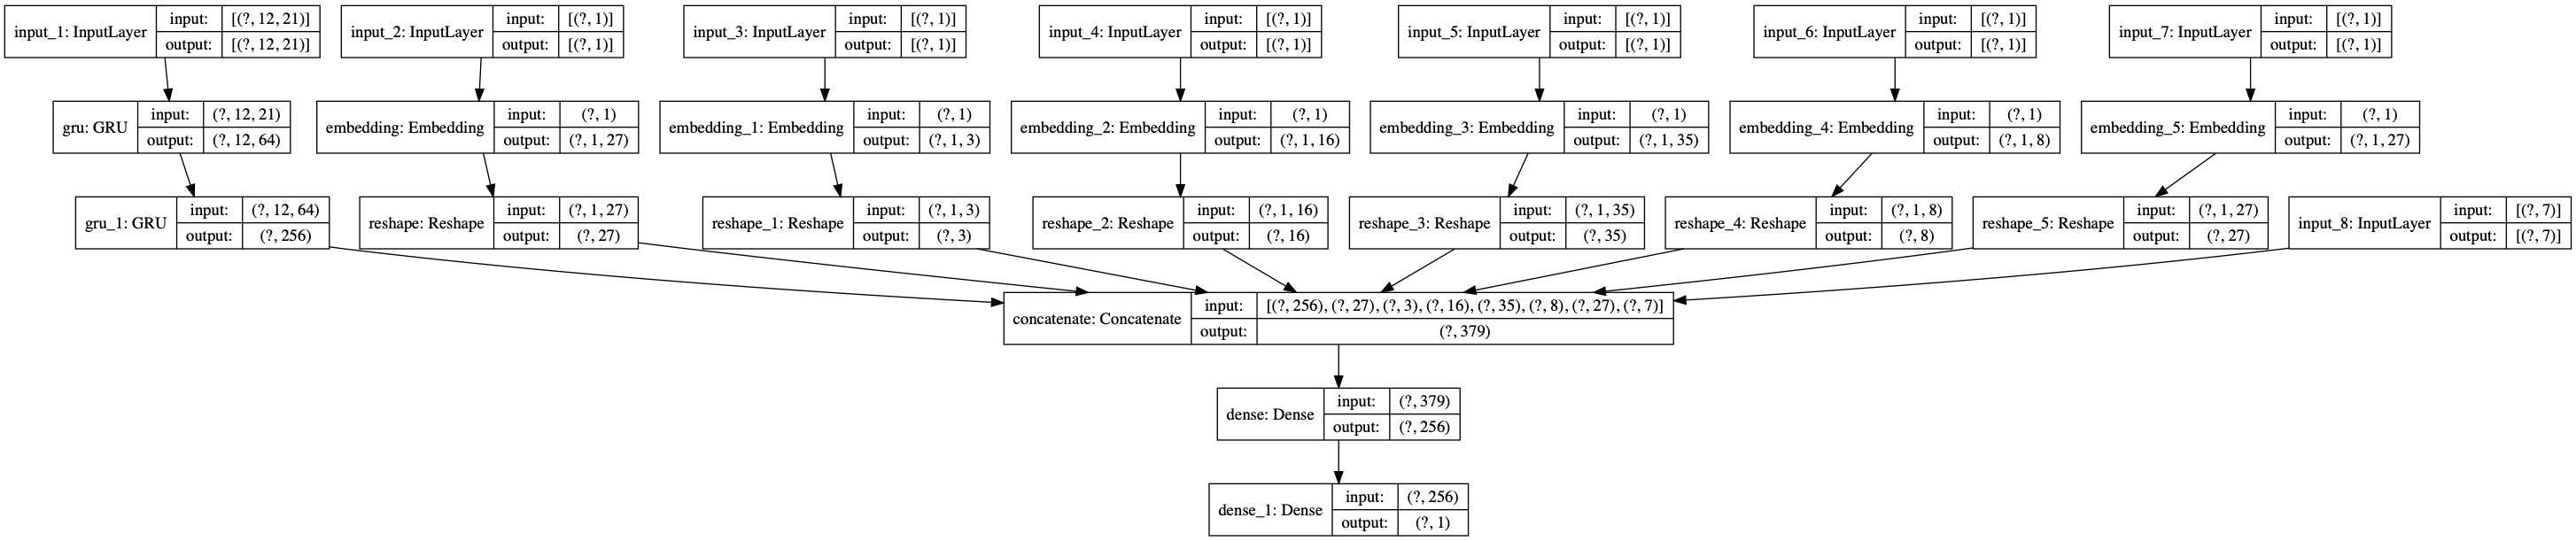

In [79]:
plot_model(model, 'model.png', show_shapes=True)

In [80]:
modelname = "newitemstest.h5"
checkpoint_cb = ModelCheckpoint(modelname, save_best_only=True)

history = model.fit([
    train[featurests].values.reshape(-1,12,21),
    train['shopid'].values.reshape(-1,1),
    train['shoptypeid'].values.reshape(-1,1),
    train['shopcityid'].values.reshape(-1,1),
    train['itemcategoryid'].values.reshape(-1,1),
    train['itemcategorytypeid'].values.reshape(-1,1),
    train['itemcategorysubtypeid'].values.reshape(-1,1),
    train[otherfeatures].values.reshape(-1,7)
],[train['target'].values.reshape(-1,1)],epochs=25,verbose=1,batch_size=512,validation_data=([
    test[featurests].values.reshape(-1,12,21),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1),
    test[otherfeatures].values.reshape(-1,7)
    ],[test['target'].values.reshape(-1,1)]),callbacks=[checkpoint_cb])

Train on 304061 samples, validate on 20900 samples
Epoch 1/25
304061/304061 [==============================] - 192s 632us/sample - loss: 0.0112 - val_loss: 0.0083
Epoch 2/25
304061/304061 [==============================] - 183s 602us/sample - loss: 0.0107 - val_loss: 0.0079
Epoch 3/25
304061/304061 [==============================] - 183s 602us/sample - loss: 0.0107 - val_loss: 0.0077
Epoch 4/25
304061/304061 [==============================] - 187s 615us/sample - loss: 0.0106 - val_loss: 0.0076
Epoch 5/25
304061/304061 [==============================] - 188s 620us/sample - loss: 0.0105 - val_loss: 0.0075
Epoch 6/25
304061/304061 [==============================] - 186s 610us/sample - loss: 0.0105 - val_loss: 0.0075
Epoch 7/25
304061/304061 [==============================] - 186s 612us/sample - loss: 0.0104 - val_loss: 0.0075
Epoch 8/25
304061/304061 [==============================] - 184s 605us/sample - loss: 0.0104 - val_loss: 0.0076
Epoch 9/25
304061/304061 [===========================

In [82]:
model = load_model(modelname) # rollback to best model
mse = model.evaluate([
    test[featurests].values.reshape(-1,12,21),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1),
    test[otherfeatures].values.reshape(-1,7)]
    , [test['target'].values.reshape(-1,1)])
print(mse)

20900/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0073539541405519895


In [84]:
preds = model.predict([
    test[featurests].values.reshape(-1,12,21),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1),
    test[otherfeatures].values.reshape(-1,7)])
preds = scalertarget.inverse_transform(preds)
mse = mean_squared_error(salesnew[(salesnew.month==33)]['target'],preds)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))
mse = mean_squared_error(scalertarget.inverse_transform(testtargets),preds)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))

total rmse : 1.7153560073180263
total rmse : 1.7152743483220394


'newitems.h5': 1.7152743483220394 (month 33) (scaled loss 0.0073539541405519895)

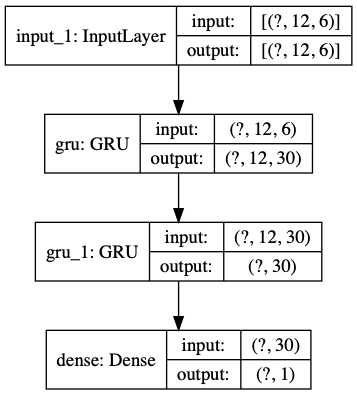

In [133]:
plot_model(model, 'model.png', show_shapes=True)

### Deep learning Model

In [ ]:
sales = pd.read_csv('sales.csv', nrows=100)

float_cols = [c for c in sales if (sales[c].dtype == "float64")&('revenue' not in c)]
float16_cols = {c: np.float16 for c in float_cols}

int_cols = [c for c in sales if (sales[c].dtype == "int64")&(c != 'itemid')]
int8_cols = {c: np.int8 for c in int_cols}

float16_cols.update(int8_cols)
sales = pd.read_csv('sales.csv', engine='c', dtype=float16_cols)

In [ ]:
sales.info()

In [ ]:
sales= sales.fillna(0)

In [36]:
for column in sales.columns:
    if ('itemid' in column):#&('ts' in column):#&('10' not in column)&('11' not in column)&('12' not in column):
        print("'{}',".format(column))

'itemid',
'lagitemidshopcityidavg1',
'tsitemid1',
'tsitemid2',
'tsitemid3',
'tsitemid4',
'tsitemid5',
'tsitemid6',
'tsitemid7',
'tsitemid8',
'tsitemid9',
'tsitemid10',
'tsitemid11',
'tsitemid12',
'tsshopiditemid1',
'tsshopiditemid2',
'tsshopiditemid3',
'tsshopiditemid4',
'tsshopiditemid5',
'tsshopiditemid6',
'tsshopiditemid7',
'tsshopiditemid8',
'tsshopiditemid9',
'tsshopiditemid10',
'tsshopiditemid11',
'tsshopiditemid12',


In [4]:
featurestscommon = [#12 lags of 22 features
    'tsshopid12',
    'tsshopcityid12',
    'tsshoptypeid12',
    'tsitemcategoryid12',
    'tsitemcategorytypeid12',
    'tsitemcategorysubtypeid12',
    'tsitemcategoryiditemcategorytypeid12',
    'tsitemcategoryiditemcategorysubtypeid12',
    'tsitemcategoryidshopcityid12',
    'tsitemcategoryidshoptypeid12',
    'tsitemcategoryidshopid12',
    'tsitemcategorytypeiditemcategorysubtypeid12',
    'tsitemcategorytypeidshopcityid12',
    'tsitemcategorytypeidshoptypeid12',
    'tsitemcategorytypeidshopid12',
    'tsitemcategorysubtypeidshopcityid12',
    'tsitemcategorysubtypeidshoptypeid12',
    'tsitemcategorysubtypeidshopid12',
    'tsshopcityidshoptypeid12',
    'tsshopcityidshopid12',
    'tsshoptypeidshopid12',
    'tsrevenue12',
    'tsshopid11',
    'tsshopcityid11',
    'tsshoptypeid11',
    'tsitemcategoryid11',
    'tsitemcategorytypeid11',
    'tsitemcategorysubtypeid11',
    'tsitemcategoryiditemcategorytypeid11',
    'tsitemcategoryiditemcategorysubtypeid11',
    'tsitemcategoryidshopcityid11',
    'tsitemcategoryidshoptypeid11',
    'tsitemcategoryidshopid11',
    'tsitemcategorytypeiditemcategorysubtypeid11',
    'tsitemcategorytypeidshopcityid11',
    'tsitemcategorytypeidshoptypeid11',
    'tsitemcategorytypeidshopid11',
    'tsitemcategorysubtypeidshopcityid11',
    'tsitemcategorysubtypeidshoptypeid11',
    'tsitemcategorysubtypeidshopid11',
    'tsshopcityidshoptypeid11',
    'tsshopcityidshopid11',
    'tsshoptypeidshopid11',
    'tsrevenue11',
    'tsshopid10',
    'tsshopcityid10',
    'tsshoptypeid10',
    'tsitemcategoryid10',
    'tsitemcategorytypeid10',
    'tsitemcategorysubtypeid10',
    'tsitemcategoryiditemcategorytypeid10',
    'tsitemcategoryiditemcategorysubtypeid10',
    'tsitemcategoryidshopcityid10',
    'tsitemcategoryidshoptypeid10',
    'tsitemcategoryidshopid10',
    'tsitemcategorytypeiditemcategorysubtypeid10',
    'tsitemcategorytypeidshopcityid10',
    'tsitemcategorytypeidshoptypeid10',
    'tsitemcategorytypeidshopid10',
    'tsitemcategorysubtypeidshopcityid10',
    'tsitemcategorysubtypeidshoptypeid10',
    'tsitemcategorysubtypeidshopid10',
    'tsshopcityidshoptypeid10',
    'tsshopcityidshopid10',
    'tsshoptypeidshopid10',
    'tsrevenue10',
    'tsshopid9',
    'tsshopcityid9',
    'tsshoptypeid9',
    'tsitemcategoryid9',
    'tsitemcategorytypeid9',
    'tsitemcategorysubtypeid9',
    'tsitemcategoryiditemcategorytypeid9',
    'tsitemcategoryiditemcategorysubtypeid9',
    'tsitemcategoryidshopcityid9',
    'tsitemcategoryidshoptypeid9',
    'tsitemcategoryidshopid9',
    'tsitemcategorytypeiditemcategorysubtypeid9',
    'tsitemcategorytypeidshopcityid9',
    'tsitemcategorytypeidshoptypeid9',
    'tsitemcategorytypeidshopid9',
    'tsitemcategorysubtypeidshopcityid9',
    'tsitemcategorysubtypeidshoptypeid9',
    'tsitemcategorysubtypeidshopid9',
    'tsshopcityidshoptypeid9',
    'tsshopcityidshopid9',
    'tsshoptypeidshopid9',
    'tsrevenue9',
    'tsshopid8',
    'tsshopcityid8',
    'tsshoptypeid8',
    'tsitemcategoryid8',
    'tsitemcategorytypeid8',
    'tsitemcategorysubtypeid8',
    'tsitemcategoryiditemcategorytypeid8',
    'tsitemcategoryiditemcategorysubtypeid8',
    'tsitemcategoryidshopcityid8',
    'tsitemcategoryidshoptypeid8',
    'tsitemcategoryidshopid8',
    'tsitemcategorytypeiditemcategorysubtypeid8',
    'tsitemcategorytypeidshopcityid8',
    'tsitemcategorytypeidshoptypeid8',
    'tsitemcategorytypeidshopid8',
    'tsitemcategorysubtypeidshopcityid8',
    'tsitemcategorysubtypeidshoptypeid8',
    'tsitemcategorysubtypeidshopid8',
    'tsshopcityidshoptypeid8',
    'tsshopcityidshopid8',
    'tsshoptypeidshopid8',
    'tsrevenue8',
    'tsshopid7',
    'tsshopcityid7',
    'tsshoptypeid7',
    'tsitemcategoryid7',
    'tsitemcategorytypeid7',
    'tsitemcategorysubtypeid7',
    'tsitemcategoryiditemcategorytypeid7',
    'tsitemcategoryiditemcategorysubtypeid7',
    'tsitemcategoryidshopcityid7',
    'tsitemcategoryidshoptypeid7',
    'tsitemcategoryidshopid7',
    'tsitemcategorytypeiditemcategorysubtypeid7',
    'tsitemcategorytypeidshopcityid7',
    'tsitemcategorytypeidshoptypeid7',
    'tsitemcategorytypeidshopid7',
    'tsitemcategorysubtypeidshopcityid7',
    'tsitemcategorysubtypeidshoptypeid7',
    'tsitemcategorysubtypeidshopid7',
    'tsshopcityidshoptypeid7',
    'tsshopcityidshopid7',
    'tsshoptypeidshopid7',
    'tsrevenue7',
    'tsshopid6',
    'tsshopcityid6',
    'tsshoptypeid6',
    'tsitemcategoryid6',
    'tsitemcategorytypeid6',
    'tsitemcategorysubtypeid6',
    'tsitemcategoryiditemcategorytypeid6',
    'tsitemcategoryiditemcategorysubtypeid6',
    'tsitemcategoryidshopcityid6',
    'tsitemcategoryidshoptypeid6',
    'tsitemcategoryidshopid6',
    'tsitemcategorytypeiditemcategorysubtypeid6',
    'tsitemcategorytypeidshopcityid6',
    'tsitemcategorytypeidshoptypeid6',
    'tsitemcategorytypeidshopid6',
    'tsitemcategorysubtypeidshopcityid6',
    'tsitemcategorysubtypeidshoptypeid6',
    'tsitemcategorysubtypeidshopid6',
    'tsshopcityidshoptypeid6',
    'tsshopcityidshopid6',
    'tsshoptypeidshopid6',
    'tsrevenue6',
    'tsshopid5',
    'tsshopcityid5',
    'tsshoptypeid5',
    'tsitemcategoryid5',
    'tsitemcategorytypeid5',
    'tsitemcategorysubtypeid5',
    'tsitemcategoryiditemcategorytypeid5',
    'tsitemcategoryiditemcategorysubtypeid5',
    'tsitemcategoryidshopcityid5',
    'tsitemcategoryidshoptypeid5',
    'tsitemcategoryidshopid5',
    'tsitemcategorytypeiditemcategorysubtypeid5',
    'tsitemcategorytypeidshopcityid5',
    'tsitemcategorytypeidshoptypeid5',
    'tsitemcategorytypeidshopid5',
    'tsitemcategorysubtypeidshopcityid5',
    'tsitemcategorysubtypeidshoptypeid5',
    'tsitemcategorysubtypeidshopid5',
    'tsshopcityidshoptypeid5',
    'tsshopcityidshopid5',
    'tsshoptypeidshopid5',
    'tsrevenue5',
    'tsshopid4',
    'tsshopcityid4',
    'tsshoptypeid4',
    'tsitemcategoryid4',
    'tsitemcategorytypeid4',
    'tsitemcategorysubtypeid4',
    'tsitemcategoryiditemcategorytypeid4',
    'tsitemcategoryiditemcategorysubtypeid4',
    'tsitemcategoryidshopcityid4',
    'tsitemcategoryidshoptypeid4',
    'tsitemcategoryidshopid4',
    'tsitemcategorytypeiditemcategorysubtypeid4',
    'tsitemcategorytypeidshopcityid4',
    'tsitemcategorytypeidshoptypeid4',
    'tsitemcategorytypeidshopid4',
    'tsitemcategorysubtypeidshopcityid4',
    'tsitemcategorysubtypeidshoptypeid4',
    'tsitemcategorysubtypeidshopid4',
    'tsshopcityidshoptypeid4',
    'tsshopcityidshopid4',
    'tsshoptypeidshopid4',
    'tsrevenue4',
    'tsshopid3',
    'tsshopcityid3',
    'tsshoptypeid3',
    'tsitemcategoryid3',
    'tsitemcategorytypeid3',
    'tsitemcategorysubtypeid3',
    'tsitemcategoryiditemcategorytypeid3',
    'tsitemcategoryiditemcategorysubtypeid3',
    'tsitemcategoryidshopcityid3',
    'tsitemcategoryidshoptypeid3',
    'tsitemcategoryidshopid3',
    'tsitemcategorytypeiditemcategorysubtypeid3',
    'tsitemcategorytypeidshopcityid3',
    'tsitemcategorytypeidshoptypeid3',
    'tsitemcategorytypeidshopid3',
    'tsitemcategorysubtypeidshopcityid3',
    'tsitemcategorysubtypeidshoptypeid3',
    'tsitemcategorysubtypeidshopid3',
    'tsshopcityidshoptypeid3',
    'tsshopcityidshopid3',
    'tsshoptypeidshopid3',
    'tsrevenue3',
    'tsshopid2',
    'tsshopcityid2',
    'tsshoptypeid2',
    'tsitemcategoryid2',
    'tsitemcategorytypeid2',
    'tsitemcategorysubtypeid2',
    'tsitemcategoryiditemcategorytypeid2',
    'tsitemcategoryiditemcategorysubtypeid2',
    'tsitemcategoryidshopcityid2',
    'tsitemcategoryidshoptypeid2',
    'tsitemcategoryidshopid2',
    'tsitemcategorytypeiditemcategorysubtypeid2',
    'tsitemcategorytypeidshopcityid2',
    'tsitemcategorytypeidshoptypeid2',
    'tsitemcategorytypeidshopid2',
    'tsitemcategorysubtypeidshopcityid2',
    'tsitemcategorysubtypeidshoptypeid2',
    'tsitemcategorysubtypeidshopid2',
    'tsshopcityidshoptypeid2',
    'tsshopcityidshopid2',
    'tsshoptypeidshopid2',
    'tsrevenue2',
    'tsshopid1',
    'tsshopcityid1',
    'tsshoptypeid1',
    'tsitemcategoryid1',
    'tsitemcategorytypeid1',
    'tsitemcategorysubtypeid1',
    'tsitemcategoryiditemcategorytypeid1',
    'tsitemcategoryiditemcategorysubtypeid1',
    'tsitemcategoryidshopcityid1',
    'tsitemcategoryidshoptypeid1',
    'tsitemcategoryidshopid1',
    'tsitemcategorytypeiditemcategorysubtypeid1',
    'tsitemcategorytypeidshopcityid1',
    'tsitemcategorytypeidshoptypeid1',
    'tsitemcategorytypeidshopid1',
    'tsitemcategorysubtypeidshopcityid1',
    'tsitemcategorysubtypeidshoptypeid1',
    'tsitemcategorysubtypeidshopid1',
    'tsshopcityidshoptypeid1',
    'tsshopcityidshopid1',
    'tsshoptypeidshopid1',
    'tsrevenue1',
            ]

otherfeaturescommon = [
    'month',
    'nbdays',
    'year',
    'monthofyear',
    'nbweekends',
    'monthssinceshoplaunched',
    'shopclosed'
]
    
    
categoricalfeaturescommon = [
    'shopid',
    'shoptypeid',
    'shopcityid',
    'itemcategoryid',
    'itemcategorytypeid',
    'itemcategorysubtypeid'
]

featurestsfull = [#12 lags of 2 features
    'tsitemid12',
    'tsitemid11',
    'tsitemid10',
    'tsitemid9',
    'tsitemid8',
    'tsitemid7',
    'tsitemid6',
    'tsitemid5',
    'tsitemid4',
    'tsitemid3',
    'tsitemid2',
    'tsitemid1',
    'tsshopiditemid12',
    'tsshopiditemid11',
    'tsshopiditemid10',
    'tsshopiditemid9',
    'tsshopiditemid8',
    'tsshopiditemid7',
    'tsshopiditemid6',
    'tsshopiditemid5',
    'tsshopiditemid4',
    'tsshopiditemid3',
    'tsshopiditemid2',
    'tsshopiditemid1'
]

otherfeaturesfull = [
    'monthssinceitemlaunched',
    'itempriceavg',
    'itempricemin',
    'itempricemax',
]

categoricalfeaturesfull = [
    'itemid'
]

In [5]:
salestest = sales[(sales.month>11)&(sales.month<34)][
    featurestscommon+otherfeaturescommon+categoricalfeaturescommon+
    featurestsfull+otherfeaturesfull+categoricalfeaturesfull+['target']
]

In [6]:
featuresscaled = featurestscommon+otherfeaturescommon+featurestsfull+otherfeaturesfull

scalerfeatures = MinMaxScaler(feature_range=(0, 1))
scalerfeatures.fit(salestest[featuresscaled])

scalertarget = MinMaxScaler(feature_range=(0, 1))
scalertarget.fit(salestest['target'].values.reshape(-1,1))

salesscaled = pd.DataFrame(data=scalerfeatures.transform(salestest[featuresscaled]),columns=featuresscaled)
salesscaled['target'] = pd.DataFrame(data=scalertarget.transform(salestest['target'].values.reshape(-1,1)),columns=['target'])['target']

with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(salesscaled.head(3))

tsshopid12  tsshopcityid12  tsshoptypeid12  tsitemcategoryid12  \
0    0.092471        0.136054        0.421094            0.043516   
1    0.092471        0.136054        0.421094            0.015320   
2    0.092471        0.136054        0.421094            0.010217   

   tsitemcategorytypeid12  tsitemcategorysubtypeid12  \
0                0.051055                   0.042473   
1                0.019069                   0.015320   
2                0.019069                   0.010936   

   tsitemcategoryiditemcategorytypeid12  \
0                              0.043516   
1                              0.015320   
2                              0.010217   

   tsitemcategoryiditemcategorysubtypeid12  tsitemcategoryidshopcityid12  \
0                                 0.043516                      0.024255   
1                                 0.015320                      0.003656   
2                                 0.010217                      0.003836   

   tsitemcategoryidshoptypeid12  tsitemcategoryidshopid12  \
0                      0.046191                  0.024255   
1                      0.016345                  0.003656   
2                      0.009619                  0.003836   

   tsitemcategorytypeiditemcategorysubtypeid12  \
0                                     0.043516   
1                                     0.015320   
2                                     0.010936   

   tsitemcategorytypeidshopcityid12  tsitemcategorytypeidshoptypeid12  \
0                          0.021350                          0.039551   
1                          0.003693                          0.014856   
2                          0.003693                          0.014856   

   tsitemcategorytypeidshopid12  tsitemcategorysubtypeidshopcityid12  \
0                      0.021350                             0.025781   
1                      0.003693                             0.003656   
2                      0.003693                             0.004282   

   tsitemcategorysubtypeidshoptypeid12  tsitemcategorysubtypeidshopid12  \
0                             0.045605                         0.025781   
1                             0.016345                         0.003656   
2                             0.010645                         0.004282   

   tsshopcityidshoptypeid12  tsshopcityidshopid12  tsshoptypeidshopid12  \
0                   0.12133              0.092471              0.092471   
1                   0.12133              0.092471              0.092471   
2                   0.12133              0.092471              0.092471   

   tsrevenue12  tsshopid11  tsshopcityid11  tsshoptypeid11  \
0       0.0772    0.039202        0.060169         0.35631   
1       0.0772    0.039202        0.060169         0.35631   
2       0.0772    0.039202        0.060169         0.35631   

   tsitemcategoryid11  tsitemcategorytypeid11  tsitemcategorysubtypeid11  \
0            0.046621                0.044077                   0.043109   
1            0.013869                0.014585                   0.013869   
2            0.010217                0.014585                   0.010542   

   tsitemcategoryiditemcategorytypeid11  \
0                              0.046621   
1                              0.013869   
2                              0.010217   

   tsitemcategoryiditemcategorysubtypeid11  tsitemcategoryidshopcityid11  \
0                                 0.046621                      0.014648   
1                                 0.013869                      0.000836   
2                                 0.010217                      0.001530   

   tsitemcategoryidshoptypeid11  tsitemcategoryidshopid11  \
0                      0.047656                  0.014648   
1                      0.014697                  0.000836   
2                      0.010040                  0.001530   

   tsitemcategorytypeiditemcategorysubtypeid11  \
0                                     0.046621   
1               

In [ ]:
categoricalfeatures = categoricalfeaturescommon + categoricalfeaturesfull

salesscaled['monthnotscaled'] = salestest['month'].values
for categoricalfeature in categoricalfeatures:
    salesscaled[categoricalfeature] = salestest[categoricalfeature].values

In [ ]:
def consecutive_categorical_ids(feature):
    print(feature)
    max_id = np.max(salesscaled[feature].unique())
    len_id = len(salesscaled[feature].unique())
    if max_id == len_id - 1:
        print('OK')
    else:
        print('NOK, max: {}, len: {}'.format(max_id,len_id))

In [ ]:
for categoricalfeature in categoricalfeatures:
    encoder = LabelEncoder()
    salesscaled[categoricalfeature] = encoder.fit_transform(salesscaled[categoricalfeature])
    consecutive_categorical_ids(categoricalfeature)

In [ ]:
def embedding_size(input_dim):
    return min(50, (input_dim + 1) // 2)

In [ ]:
train = salesscaled[salesscaled.monthnotscaled<33]
test = salesscaled[salesscaled.monthnotscaled==33]

In [ ]:
traintscommonvalues = train[featurestscommon].values.reshape(-1,12,22)
print(traintscommonvalues.shape)
traintsfullvalues = train[featurestsfull].values.reshape(-1,12,2)
print(traintsfullvalues.shape)
traincategoricalcommonvalues = train[categoricalfeaturescommon].values
print(traincategoricalcommonvalues.shape)
traincategoricalfullvalues = train[categoricalfeaturesfull].values
print(traincategoricalfullvalues.shape)
trainotherfeaturescommonvalues = train[otherfeaturescommon].values
print(trainotherfeaturescommonvalues.shape)
trainotherfeaturesfullvalues = train[otherfeaturesfull].values
print(trainotherfeaturesfullvalues.shape)
traintargets = train['target'].values.reshape(-1,1)
print(traintargets.shape)

testtscommonvalues = test[featurestscommon].values.reshape(-1,12,22)
print(testtscommonvalues.shape)
testtsfullvalues = test[featurestsfull].values.reshape(-1,12,2)
print(testtsfullvalues.shape)
testcategoricalcommonvalues = test[categoricalfeaturescommon].values
print(testcategoricalcommonvalues.shape)
testcategoricalfullvalues = test[categoricalfeaturesfull].values
print(testcategoricalfullvalues.shape)
testotherfeaturescommonvalues = test[otherfeaturescommon].values
print(testotherfeaturescommonvalues.shape)
testotherfeaturesfullvalues = test[otherfeaturesfull].values
print(testotherfeaturesfullvalues.shape)
testtargets = test['target'].values.reshape(-1,1)
print(testtargets.shape)

In [ ]:
tscommoninputs = Input(shape=(12,22))
gru1common = GRU(128,return_sequences=True)(tscommoninputs)
gru2common = GRU(256)(gru1common)

tscommonfull = Input(shape=(12,2))
gru1full = GRU(32,return_sequences=True)(tscommonfull)
gru2full = GRU(64)(gru1full)

shopidinputs = Input(shape=(1,))
shopidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.shopid.unique())),
    input_dim=len(salesscaled.shopid.unique()),
    input_length=1)(shopidinputs)
shopidembedding = Reshape((embedding_size(len(salesscaled.shopid.unique())),))(shopidembedding)

shoptypeidinputs = Input(shape=(1,))
shoptypeidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.shoptypeid.unique())),
    input_dim=len(salesscaled.shoptypeid.unique()),
    input_length=1)(shoptypeidinputs)
shoptypeidembedding = Reshape((embedding_size(len(salesscaled.shoptypeid.unique())),))(shoptypeidembedding)

shopcityididinputs = Input(shape=(1,))
shopcityidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.shopcityid.unique())),
    input_dim=len(salesscaled.shopcityid.unique()),
    input_length=1)(shopcityididinputs)
shopcityidembedding = Reshape((embedding_size(len(salesscaled.shopcityid.unique())),))(shopcityidembedding)

itemcategoryidinputs = Input(shape=(1,))
itemcategoryidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.itemcategoryid.unique())),
    input_dim=len(salesscaled.itemcategoryid.unique()),
    input_length=1)(itemcategoryidinputs)
itemcategoryidembedding = Reshape((embedding_size(len(salesscaled.itemcategoryid.unique())),))(itemcategoryidembedding)

itemcategorytypeidinputs = Input(shape=(1,))
itemcategorytypeidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.itemcategorytypeid.unique())),
    input_dim=len(salesscaled.itemcategorytypeid.unique()),
    input_length=1)(itemcategorytypeidinputs)
itemcategorytypeidembedding = Reshape((embedding_size(len(salesscaled.itemcategorytypeid.unique())),))(itemcategorytypeidembedding)

itemcategorysubtypeidinputs = Input(shape=(1,))
itemcategorysubtypeidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.itemcategorysubtypeid.unique())),
    input_dim=len(salesscaled.itemcategorysubtypeid.unique()),
    input_length=1)(itemcategorysubtypeidinputs)
itemcategorysubtypeidembedding = Reshape((embedding_size(len(salesscaled.itemcategorysubtypeid.unique())),))(itemcategorysubtypeidembedding)

itemidinputs = Input(shape=(1,))
itemidembedding = Embedding(
    output_dim=embedding_size(len(salesscaled.itemid.unique())),
    input_dim=len(salesscaled.itemid.unique()),
    input_length=1)(itemidinputs)
itemidembedding = Reshape((embedding_size(len(salesscaled.itemid.unique())),))(itemidembedding)

otherinputscommon = Input(shape=(7,))

otherinputsfull = Input(shape=(4,))

concatenated_layer = Concatenate()([
    gru2common,
    gru2full,
    shopidembedding,
    shoptypeidembedding,
    shopcityidembedding,
    itemcategoryidembedding,
    itemcategorytypeidembedding,
    itemcategorysubtypeidembedding,
    itemidembedding,
    otherinputscommon,
    otherinputsfull
])

dense1 = Dense(512)(concatenated_layer)

outs = Dense(1)(dense1)

model = Model(inputs=[
    tsinputscommon,
    tsinputsfull,
    shopidinputs,
    shoptypeidinputs,
    shopcityididinputs,
    itemcategoryidinputs,
    itemcategorytypeidinputs,
    itemcategorysubtypeidinputs,
    otherinputscommon,
    otherinputsfull
],outputs=outs)
model.compile(optimizer='adam', loss='mse')

In [ ]:
plot_model(model, 'model.png', show_shapes=True)

In [ ]:
modelname = "fullmodeltest.h5"
checkpoint_cb = ModelCheckpoint(modelname, save_best_only=True)

history = model.fit([
    train[featurestscommon].values.reshape(-1,12,22),
    train[featurestsfull].values.reshape(-1,12,2),
    train['shopid'].values.reshape(-1,1),
    train['shoptypeid'].values.reshape(-1,1),
    train['shopcityid'].values.reshape(-1,1),
    train['itemcategoryid'].values.reshape(-1,1),
    train['itemcategorytypeid'].values.reshape(-1,1),
    train['itemcategorysubtypeid'].values.reshape(-1,1),
    train['itemid'].values.reshape(-1,1),
    train[otherfeaturescommon].values.reshape(-1,7),
    train[otherfeaturesfull].values.reshape(-1,4)
],[train['target'].values.reshape(-1,1)],epochs=25,verbose=1,batch_size=512,validation_data=([
    test[featurestscommon].values.reshape(-1,12,22),
    test[featurestsfull].values.reshape(-1,12,2),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1),
    test['itemid'].values.reshape(-1,1),
    test[otherfeaturescommon].values.reshape(-1,7),
    test[otherfeaturesfull].values.reshape(-1,4)
    ],[test['target'].values.reshape(-1,1)]),callbacks=[checkpoint_cb])

In [ ]:
model = load_model(modelname) # rollback to best model
mse = model.evaluate([
    test[featurestscommon].values.reshape(-1,12,22),
    test[featurestsfull].values.reshape(-1,12,2),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1),
    test['itemid'].values.reshape(-1,1),
    test[otherfeaturescommon].values.reshape(-1,7),
    test[otherfeaturesfull].values.reshape(-1,4)
]
    , [test['target'].values.reshape(-1,1)])
print(mse)

In [ ]:
preds = model.predict([
    test[featurestscommon].values.reshape(-1,12,22),
    test[featurestsfull].values.reshape(-1,12,2),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1),
    test['itemid'].values.reshape(-1,1),
    test[otherfeaturescommon].values.reshape(-1,7),
    test[otherfeaturesfull].values.reshape(-1,4)
])
preds = scalertarget.inverse_transform(preds)
mse = mean_squared_error(sales[(sales.month==33)]['target'],preds)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))
mse = mean_squared_error(scalertarget.inverse_transform(testtargets),preds)
rmse = math.sqrt(mse)
print('total rmse : {}'.format(rmse))